##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I gotta say, Clive Barker's Undying is by far the best horror game to have ever been made. I've played Resident Evil, Silent Hill and the Evil Dead and Castlevania games but none of them have captured the pure glee with which this game tackles its horrific elements. Barker is good at what he does, which is attach the horror to our world, and it shows as his hand is clearly everywhere in this game. Heck, even his voice is in the game as one of the main characters. Full of lush visuals and enough atmosphere to shake a stick at, Undying is the game to beat in my books as the best horror title. I just wish that this had made it to a console system but alas poor PC sales nipped that one in the bud."
 b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There a

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1, 130, ...,   0,   0,   0],
       [ 11,   7,   2, ...,   0,   0,   0],
       [  8, 847,  33, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I gotta say, Clive Barker's Undying is by far the best horror game to have ever been made. I've played Resident Evil, Silent Hill and the Evil Dead and Castlevania games but none of them have captured the pure glee with which this game tackles its horrific elements. Barker is good at what he does, which is attach the horror to our world, and it shows as his hand is clearly everywhere in this game. Heck, even his voice is in the game as one of the main characters. Full of lush visuals and enough atmosphere to shake a stick at, Undying is the game to beat in my books as the best horror title. I just wish that this had made it to a console system but alas poor PC sales nipped that one in the bud."
Round-trip:  i [UNK] say [UNK] [UNK] [UNK] is by far the best horror game to have ever been made ive played [UNK] evil [UNK] [UNK] and the evil dead and [UNK] [UNK] but none of them have [UNK] the [UNK] [UNK] with which this game [UNK] its [UNK] elements [UNK] is good at what he doe

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00750345]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00750345]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 40:54 - loss: 0.6931 - accuracy: 0.4688

  2/391 [..............................] - ETA: 35s - loss: 0.6931 - accuracy: 0.4375  

  3/391 [..............................] - ETA: 33s - loss: 0.6932 - accuracy: 0.4479

  4/391 [..............................] - ETA: 33s - loss: 0.6931 - accuracy: 0.4453

  5/391 [..............................] - ETA: 32s - loss: 0.6930 - accuracy: 0.4656

  6/391 [..............................] - ETA: 31s - loss: 0.6929 - accuracy: 0.4688

  7/391 [..............................] - ETA: 31s - loss: 0.6929 - accuracy: 0.4777

  8/391 [..............................] - ETA: 30s - loss: 0.6929 - accuracy: 0.4785

  9/391 [..............................] - ETA: 29s - loss: 0.6929 - accuracy: 0.4740

 10/391 [..............................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4812

 11/391 [..............................] - ETA: 29s - loss: 0.6929 - accuracy: 0.4844

 12/391 [..............................] - ETA: 29s - loss: 0.6929 - accuracy: 0.4805

 13/391 [..............................] - ETA: 29s - loss: 0.6930 - accuracy: 0.4844

 14/391 [>.............................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4833

 15/391 [>.............................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4854

 16/391 [>.............................] - ETA: 28s - loss: 0.6930 - accuracy: 0.4893

 17/391 [>.............................] - ETA: 27s - loss: 0.6929 - accuracy: 0.4908

 18/391 [>.............................] - ETA: 27s - loss: 0.6929 - accuracy: 0.4983

 19/391 [>.............................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5049

 20/391 [>.............................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5047

 21/391 [>.............................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5074

 22/391 [>.............................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5057

 23/391 [>.............................] - ETA: 27s - loss: 0.6929 - accuracy: 0.5075

 24/391 [>.............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5072

 25/391 [>.............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5081

 26/391 [>.............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5096

 27/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5098

 28/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5100

 29/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5081

 30/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5083

 31/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5081

 32/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5068

 33/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5071

 34/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5051

 35/391 [=>............................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5045

 36/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5056

 37/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5055

 38/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5070

 39/391 [=>............................] - ETA: 26s - loss: 0.6929 - accuracy: 0.5092

 40/391 [==>...........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5109

 41/391 [==>...........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5126

 42/391 [==>...........................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5138

 43/391 [==>...........................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5145

 44/391 [==>...........................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5153

 45/391 [==>...........................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5160

 46/391 [==>...........................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5146

 47/391 [==>...........................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5143

 49/391 [==>...........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5166

 50/391 [==>...........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5156

 51/391 [==>...........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5162

 52/391 [==>...........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5141

 53/391 [===>..........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5136

 54/391 [===>..........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5150

 55/391 [===>..........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5145

 56/391 [===>..........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5112

 57/391 [===>..........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5115

 58/391 [===>..........................] - ETA: 24s - loss: 0.6928 - accuracy: 0.5119

 59/391 [===>..........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5095

 60/391 [===>..........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5091

 61/391 [===>..........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5090

 62/391 [===>..........................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5071

 63/391 [===>..........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5072

 64/391 [===>..........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5076

 65/391 [===>..........................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5067

 66/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5080

 67/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5098

 68/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5078

 69/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5079

 70/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5069

 71/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5079

 72/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5069

 73/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5075

 74/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5091

 75/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5090

 76/391 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.5076

 77/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5069

 78/391 [====>.........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5078

 79/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5065

 80/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5063

 81/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5058

 82/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5057

 83/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5058

 84/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5073

 85/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5064

 86/391 [=====>........................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5056

 87/391 [=====>........................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5059

 88/391 [=====>........................] - ETA: 22s - loss: 0.6927 - accuracy: 0.5057

 89/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5065

 90/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5068

 91/391 [=====>........................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5067

 92/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5068

 93/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5057

 94/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5052

 95/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5061

 96/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5055

 97/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5053

 98/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5053

 99/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5060

100/391 [======>.......................] - ETA: 21s - loss: 0.6927 - accuracy: 0.5058

101/391 [======>.......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5057

102/391 [======>.......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5063

104/391 [======>.......................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5063

105/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5065

106/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5057

107/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5048

108/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5055

109/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5060

110/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5053

111/391 [=======>......................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5052

112/391 [=======>......................] - ETA: 20s - loss: 0.6926 - accuracy: 0.5036

113/391 [=======>......................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5028

114/391 [=======>......................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5042

115/391 [=======>......................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5042

116/391 [=======>......................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5047

117/391 [=======>......................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5035

118/391 [========>.....................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5036

119/391 [========>.....................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5037

120/391 [========>.....................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5039

121/391 [========>.....................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5041

122/391 [========>.....................] - ETA: 19s - loss: 0.6926 - accuracy: 0.5042

123/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5039

124/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5040

125/391 [========>.....................] - ETA: 19s - loss: 0.6925 - accuracy: 0.5041

126/391 [========>.....................] - ETA: 18s - loss: 0.6925 - accuracy: 0.5042

127/391 [========>.....................] - ETA: 18s - loss: 0.6925 - accuracy: 0.5038

128/391 [========>.....................] - ETA: 18s - loss: 0.6925 - accuracy: 0.5037

129/391 [========>.....................] - ETA: 18s - loss: 0.6925 - accuracy: 0.5038

130/391 [========>.....................] - ETA: 18s - loss: 0.6925 - accuracy: 0.5037

131/391 [=========>....................] - ETA: 18s - loss: 0.6925 - accuracy: 0.5033

132/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5032

133/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5032

134/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5037

135/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5032

136/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5030

137/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5027

138/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5022

139/391 [=========>....................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5020

140/391 [=========>....................] - ETA: 17s - loss: 0.6924 - accuracy: 0.5022

141/391 [=========>....................] - ETA: 17s - loss: 0.6924 - accuracy: 0.5031

142/391 [=========>....................] - ETA: 17s - loss: 0.6924 - accuracy: 0.5033

143/391 [=========>....................] - ETA: 17s - loss: 0.6924 - accuracy: 0.5030

144/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5030

145/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5027

146/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5025

147/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5027

148/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5033

149/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5037

150/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5039

151/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5042

152/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5042

153/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5038

154/391 [==========>...................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5043

155/391 [==========>...................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5037

156/391 [==========>...................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5041

157/391 [===========>..................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5041

158/391 [===========>..................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5043

159/391 [===========>..................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5040

160/391 [===========>..................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5041

161/391 [===========>..................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5040

162/391 [===========>..................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5038

163/391 [===========>..................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5042

164/391 [===========>..................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5039

165/391 [===========>..................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5041

166/391 [===========>..................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5041

167/391 [===========>..................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5035

168/391 [===========>..................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5035

169/391 [===========>..................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5040

170/391 [============>.................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5040

171/391 [============>.................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5041

172/391 [============>.................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5038

173/391 [============>.................] - ETA: 15s - loss: 0.6921 - accuracy: 0.5033

174/391 [============>.................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5033

175/391 [============>.................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5038

176/391 [============>.................] - ETA: 15s - loss: 0.6920 - accuracy: 0.5039

177/391 [============>.................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5038

178/391 [============>.................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5047

179/391 [============>.................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5046

180/391 [============>.................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5048

181/391 [============>.................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5049

182/391 [============>.................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5046

183/391 [=============>................] - ETA: 15s - loss: 0.6919 - accuracy: 0.5050

184/391 [=============>................] - ETA: 15s - loss: 0.6918 - accuracy: 0.5046

185/391 [=============>................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5046

186/391 [=============>................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5048

187/391 [=============>................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5053

189/391 [=============>................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5055

190/391 [=============>................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5055

191/391 [=============>................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5054

192/391 [=============>................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5047

193/391 [=============>................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5043

194/391 [=============>................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5044

195/391 [=============>................] - ETA: 14s - loss: 0.6916 - accuracy: 0.5042

196/391 [==============>...............] - ETA: 14s - loss: 0.6916 - accuracy: 0.5041

197/391 [==============>...............] - ETA: 14s - loss: 0.6916 - accuracy: 0.5046

198/391 [==============>...............] - ETA: 13s - loss: 0.6915 - accuracy: 0.5043

199/391 [==============>...............] - ETA: 13s - loss: 0.6915 - accuracy: 0.5042

200/391 [==============>...............] - ETA: 13s - loss: 0.6915 - accuracy: 0.5041

201/391 [==============>...............] - ETA: 13s - loss: 0.6915 - accuracy: 0.5043

202/391 [==============>...............] - ETA: 13s - loss: 0.6914 - accuracy: 0.5034

203/391 [==============>...............] - ETA: 13s - loss: 0.6914 - accuracy: 0.5034

204/391 [==============>...............] - ETA: 13s - loss: 0.6914 - accuracy: 0.5034

205/391 [==============>...............] - ETA: 13s - loss: 0.6914 - accuracy: 0.5039

206/391 [==============>...............] - ETA: 13s - loss: 0.6914 - accuracy: 0.5036

207/391 [==============>...............] - ETA: 13s - loss: 0.6913 - accuracy: 0.5034

208/391 [==============>...............] - ETA: 13s - loss: 0.6913 - accuracy: 0.5032

209/391 [===============>..............] - ETA: 13s - loss: 0.6913 - accuracy: 0.5030

210/391 [===============>..............] - ETA: 13s - loss: 0.6912 - accuracy: 0.5028

211/391 [===============>..............] - ETA: 13s - loss: 0.6912 - accuracy: 0.5030

212/391 [===============>..............] - ETA: 12s - loss: 0.6912 - accuracy: 0.5029

213/391 [===============>..............] - ETA: 12s - loss: 0.6911 - accuracy: 0.5025

214/391 [===============>..............] - ETA: 12s - loss: 0.6911 - accuracy: 0.5028

215/391 [===============>..............] - ETA: 12s - loss: 0.6910 - accuracy: 0.5024

216/391 [===============>..............] - ETA: 12s - loss: 0.6910 - accuracy: 0.5020

217/391 [===============>..............] - ETA: 12s - loss: 0.6909 - accuracy: 0.5022

218/391 [===============>..............] - ETA: 12s - loss: 0.6909 - accuracy: 0.5016

219/391 [===============>..............] - ETA: 12s - loss: 0.6909 - accuracy: 0.5016

220/391 [===============>..............] - ETA: 12s - loss: 0.6908 - accuracy: 0.5018

221/391 [===============>..............] - ETA: 12s - loss: 0.6908 - accuracy: 0.5021

222/391 [================>.............] - ETA: 12s - loss: 0.6908 - accuracy: 0.5021

223/391 [================>.............] - ETA: 12s - loss: 0.6908 - accuracy: 0.5023

224/391 [================>.............] - ETA: 12s - loss: 0.6907 - accuracy: 0.5024

225/391 [================>.............] - ETA: 12s - loss: 0.6906 - accuracy: 0.5021

226/391 [================>.............] - ETA: 11s - loss: 0.6905 - accuracy: 0.5022

227/391 [================>.............] - ETA: 11s - loss: 0.6904 - accuracy: 0.5021

228/391 [================>.............] - ETA: 11s - loss: 0.6903 - accuracy: 0.5020

229/391 [================>.............] - ETA: 11s - loss: 0.6903 - accuracy: 0.5020

230/391 [================>.............] - ETA: 11s - loss: 0.6901 - accuracy: 0.5022

231/391 [================>.............] - ETA: 11s - loss: 0.6900 - accuracy: 0.5024

232/391 [================>.............] - ETA: 11s - loss: 0.6898 - accuracy: 0.5026

233/391 [================>.............] - ETA: 11s - loss: 0.6895 - accuracy: 0.5028

234/391 [================>.............] - ETA: 11s - loss: 0.6892 - accuracy: 0.5029

235/391 [=================>............] - ETA: 11s - loss: 0.6892 - accuracy: 0.5036

236/391 [=================>............] - ETA: 11s - loss: 0.6890 - accuracy: 0.5040

237/391 [=================>............] - ETA: 11s - loss: 0.6891 - accuracy: 0.5046

238/391 [=================>............] - ETA: 11s - loss: 0.6891 - accuracy: 0.5047

239/391 [=================>............] - ETA: 11s - loss: 0.6889 - accuracy: 0.5052

240/391 [=================>............] - ETA: 10s - loss: 0.6888 - accuracy: 0.5051

241/391 [=================>............] - ETA: 10s - loss: 0.6885 - accuracy: 0.5056

242/391 [=================>............] - ETA: 10s - loss: 0.6883 - accuracy: 0.5060

243/391 [=================>............] - ETA: 10s - loss: 0.6880 - accuracy: 0.5064

244/391 [=================>............] - ETA: 10s - loss: 0.6876 - accuracy: 0.5070

245/391 [=================>............] - ETA: 10s - loss: 0.6874 - accuracy: 0.5076

246/391 [=================>............] - ETA: 10s - loss: 0.6870 - accuracy: 0.5080

247/391 [=================>............] - ETA: 10s - loss: 0.6870 - accuracy: 0.5079

248/391 [==================>...........] - ETA: 10s - loss: 0.6867 - accuracy: 0.5083

249/391 [==================>...........] - ETA: 10s - loss: 0.6865 - accuracy: 0.5089

250/391 [==================>...........] - ETA: 10s - loss: 0.6862 - accuracy: 0.5090

251/391 [==================>...........] - ETA: 10s - loss: 0.6861 - accuracy: 0.5092

252/391 [==================>...........] - ETA: 10s - loss: 0.6858 - accuracy: 0.5091

253/391 [==================>...........] - ETA: 10s - loss: 0.6858 - accuracy: 0.5090

254/391 [==================>...........] - ETA: 9s - loss: 0.6856 - accuracy: 0.5089 

255/391 [==================>...........] - ETA: 9s - loss: 0.6852 - accuracy: 0.5091

256/391 [==================>...........] - ETA: 9s - loss: 0.6851 - accuracy: 0.5094

257/391 [==================>...........] - ETA: 9s - loss: 0.6848 - accuracy: 0.5098

258/391 [==================>...........] - ETA: 9s - loss: 0.6844 - accuracy: 0.5105

259/391 [==================>...........] - ETA: 9s - loss: 0.6844 - accuracy: 0.5103

260/391 [==================>...........] - ETA: 9s - loss: 0.6843 - accuracy: 0.5103

261/391 [===================>..........] - ETA: 9s - loss: 0.6842 - accuracy: 0.5103

262/391 [===================>..........] - ETA: 9s - loss: 0.6841 - accuracy: 0.5103

263/391 [===================>..........] - ETA: 9s - loss: 0.6840 - accuracy: 0.5103

264/391 [===================>..........] - ETA: 9s - loss: 0.6837 - accuracy: 0.5108

265/391 [===================>..........] - ETA: 9s - loss: 0.6834 - accuracy: 0.5108

266/391 [===================>..........] - ETA: 9s - loss: 0.6833 - accuracy: 0.5109

267/391 [===================>..........] - ETA: 9s - loss: 0.6830 - accuracy: 0.5115

268/391 [===================>..........] - ETA: 8s - loss: 0.6827 - accuracy: 0.5119

269/391 [===================>..........] - ETA: 8s - loss: 0.6822 - accuracy: 0.5125

270/391 [===================>..........] - ETA: 8s - loss: 0.6818 - accuracy: 0.5132

271/391 [===================>..........] - ETA: 8s - loss: 0.6819 - accuracy: 0.5138

272/391 [===================>..........] - ETA: 8s - loss: 0.6819 - accuracy: 0.5142

273/391 [===================>..........] - ETA: 8s - loss: 0.6818 - accuracy: 0.5148

274/391 [====================>.........] - ETA: 8s - loss: 0.6819 - accuracy: 0.5155

275/391 [====================>.........] - ETA: 8s - loss: 0.6820 - accuracy: 0.5157

276/391 [====================>.........] - ETA: 8s - loss: 0.6823 - accuracy: 0.5160

277/391 [====================>.........] - ETA: 8s - loss: 0.6823 - accuracy: 0.5162

278/391 [====================>.........] - ETA: 8s - loss: 0.6821 - accuracy: 0.5169

279/391 [====================>.........] - ETA: 8s - loss: 0.6819 - accuracy: 0.5171

280/391 [====================>.........] - ETA: 8s - loss: 0.6815 - accuracy: 0.5177

281/391 [====================>.........] - ETA: 8s - loss: 0.6814 - accuracy: 0.5181

282/391 [====================>.........] - ETA: 7s - loss: 0.6814 - accuracy: 0.5183

283/391 [====================>.........] - ETA: 7s - loss: 0.6812 - accuracy: 0.5187

284/391 [====================>.........] - ETA: 7s - loss: 0.6811 - accuracy: 0.5189

285/391 [====================>.........] - ETA: 7s - loss: 0.6810 - accuracy: 0.5192

286/391 [====================>.........] - ETA: 7s - loss: 0.6807 - accuracy: 0.5196

287/391 [=====================>........] - ETA: 7s - loss: 0.6804 - accuracy: 0.5199

288/391 [=====================>........] - ETA: 7s - loss: 0.6802 - accuracy: 0.5201

289/391 [=====================>........] - ETA: 7s - loss: 0.6799 - accuracy: 0.5202

290/391 [=====================>........] - ETA: 7s - loss: 0.6793 - accuracy: 0.5207

291/391 [=====================>........] - ETA: 7s - loss: 0.6792 - accuracy: 0.5209

292/391 [=====================>........] - ETA: 7s - loss: 0.6788 - accuracy: 0.5215

293/391 [=====================>........] - ETA: 7s - loss: 0.6785 - accuracy: 0.5218

294/391 [=====================>........] - ETA: 7s - loss: 0.6781 - accuracy: 0.5224

295/391 [=====================>........] - ETA: 7s - loss: 0.6780 - accuracy: 0.5228

296/391 [=====================>........] - ETA: 6s - loss: 0.6777 - accuracy: 0.5230

297/391 [=====================>........] - ETA: 6s - loss: 0.6775 - accuracy: 0.5234

298/391 [=====================>........] - ETA: 6s - loss: 0.6772 - accuracy: 0.5238

299/391 [=====================>........] - ETA: 6s - loss: 0.6769 - accuracy: 0.5242

300/391 [======================>.......] - ETA: 6s - loss: 0.6764 - accuracy: 0.5252

301/391 [======================>.......] - ETA: 6s - loss: 0.6760 - accuracy: 0.5257

302/391 [======================>.......] - ETA: 6s - loss: 0.6757 - accuracy: 0.5264

303/391 [======================>.......] - ETA: 6s - loss: 0.6755 - accuracy: 0.5266

304/391 [======================>.......] - ETA: 6s - loss: 0.6755 - accuracy: 0.5267

305/391 [======================>.......] - ETA: 6s - loss: 0.6750 - accuracy: 0.5274

306/391 [======================>.......] - ETA: 6s - loss: 0.6749 - accuracy: 0.5275

307/391 [======================>.......] - ETA: 6s - loss: 0.6744 - accuracy: 0.5282

308/391 [======================>.......] - ETA: 6s - loss: 0.6742 - accuracy: 0.5288

309/391 [======================>.......] - ETA: 5s - loss: 0.6741 - accuracy: 0.5289

310/391 [======================>.......] - ETA: 5s - loss: 0.6738 - accuracy: 0.5292

311/391 [======================>.......] - ETA: 5s - loss: 0.6737 - accuracy: 0.5295

312/391 [======================>.......] - ETA: 5s - loss: 0.6734 - accuracy: 0.5300

313/391 [=======================>......] - ETA: 5s - loss: 0.6732 - accuracy: 0.5303

314/391 [=======================>......] - ETA: 5s - loss: 0.6728 - accuracy: 0.5309

315/391 [=======================>......] - ETA: 5s - loss: 0.6726 - accuracy: 0.5313

316/391 [=======================>......] - ETA: 5s - loss: 0.6723 - accuracy: 0.5316

317/391 [=======================>......] - ETA: 5s - loss: 0.6722 - accuracy: 0.5320

318/391 [=======================>......] - ETA: 5s - loss: 0.6718 - accuracy: 0.5326

319/391 [=======================>......] - ETA: 5s - loss: 0.6716 - accuracy: 0.5329

320/391 [=======================>......] - ETA: 5s - loss: 0.6712 - accuracy: 0.5333

321/391 [=======================>......] - ETA: 5s - loss: 0.6709 - accuracy: 0.5338

322/391 [=======================>......] - ETA: 5s - loss: 0.6706 - accuracy: 0.5343

323/391 [=======================>......] - ETA: 4s - loss: 0.6702 - accuracy: 0.5348

324/391 [=======================>......] - ETA: 4s - loss: 0.6700 - accuracy: 0.5352

325/391 [=======================>......] - ETA: 4s - loss: 0.6697 - accuracy: 0.5355

326/391 [========================>.....] - ETA: 4s - loss: 0.6695 - accuracy: 0.5356

327/391 [========================>.....] - ETA: 4s - loss: 0.6693 - accuracy: 0.5358

328/391 [========================>.....] - ETA: 4s - loss: 0.6689 - accuracy: 0.5364

329/391 [========================>.....] - ETA: 4s - loss: 0.6685 - accuracy: 0.5370

330/391 [========================>.....] - ETA: 4s - loss: 0.6683 - accuracy: 0.5373

331/391 [========================>.....] - ETA: 4s - loss: 0.6680 - accuracy: 0.5378

332/391 [========================>.....] - ETA: 4s - loss: 0.6676 - accuracy: 0.5381

333/391 [========================>.....] - ETA: 4s - loss: 0.6674 - accuracy: 0.5385

334/391 [========================>.....] - ETA: 4s - loss: 0.6671 - accuracy: 0.5391

335/391 [========================>.....] - ETA: 4s - loss: 0.6666 - accuracy: 0.5398

336/391 [========================>.....] - ETA: 4s - loss: 0.6663 - accuracy: 0.5404

337/391 [========================>.....] - ETA: 3s - loss: 0.6661 - accuracy: 0.5408

338/391 [========================>.....] - ETA: 3s - loss: 0.6659 - accuracy: 0.5414

339/391 [=========================>....] - ETA: 3s - loss: 0.6657 - accuracy: 0.5417

340/391 [=========================>....] - ETA: 3s - loss: 0.6653 - accuracy: 0.5422

341/391 [=========================>....] - ETA: 3s - loss: 0.6649 - accuracy: 0.5429

342/391 [=========================>....] - ETA: 3s - loss: 0.6646 - accuracy: 0.5434

343/391 [=========================>....] - ETA: 3s - loss: 0.6641 - accuracy: 0.5437

344/391 [=========================>....] - ETA: 3s - loss: 0.6637 - accuracy: 0.5441

345/391 [=========================>....] - ETA: 3s - loss: 0.6634 - accuracy: 0.5446

346/391 [=========================>....] - ETA: 3s - loss: 0.6629 - accuracy: 0.5454

347/391 [=========================>....] - ETA: 3s - loss: 0.6626 - accuracy: 0.5458

348/391 [=========================>....] - ETA: 3s - loss: 0.6623 - accuracy: 0.5462

349/391 [=========================>....] - ETA: 3s - loss: 0.6622 - accuracy: 0.5463

350/391 [=========================>....] - ETA: 3s - loss: 0.6622 - accuracy: 0.5463

351/391 [=========================>....] - ETA: 2s - loss: 0.6618 - accuracy: 0.5469

352/391 [==========================>...] - ETA: 2s - loss: 0.6615 - accuracy: 0.5474

353/391 [==========================>...] - ETA: 2s - loss: 0.6613 - accuracy: 0.5477

354/391 [==========================>...] - ETA: 2s - loss: 0.6608 - accuracy: 0.5482

355/391 [==========================>...] - ETA: 2s - loss: 0.6603 - accuracy: 0.5488

356/391 [==========================>...] - ETA: 2s - loss: 0.6597 - accuracy: 0.5492

357/391 [==========================>...] - ETA: 2s - loss: 0.6594 - accuracy: 0.5495

358/391 [==========================>...] - ETA: 2s - loss: 0.6590 - accuracy: 0.5500

359/391 [==========================>...] - ETA: 2s - loss: 0.6588 - accuracy: 0.5503

360/391 [==========================>...] - ETA: 2s - loss: 0.6584 - accuracy: 0.5508

361/391 [==========================>...] - ETA: 2s - loss: 0.6581 - accuracy: 0.5515

362/391 [==========================>...] - ETA: 2s - loss: 0.6579 - accuracy: 0.5520

363/391 [==========================>...] - ETA: 2s - loss: 0.6579 - accuracy: 0.5522

364/391 [==========================>...] - ETA: 1s - loss: 0.6576 - accuracy: 0.5527

365/391 [===========================>..] - ETA: 1s - loss: 0.6571 - accuracy: 0.5533

366/391 [===========================>..] - ETA: 1s - loss: 0.6568 - accuracy: 0.5534

367/391 [===========================>..] - ETA: 1s - loss: 0.6563 - accuracy: 0.5539

368/391 [===========================>..] - ETA: 1s - loss: 0.6563 - accuracy: 0.5541

369/391 [===========================>..] - ETA: 1s - loss: 0.6558 - accuracy: 0.5544

370/391 [===========================>..] - ETA: 1s - loss: 0.6554 - accuracy: 0.5547

371/391 [===========================>..] - ETA: 1s - loss: 0.6551 - accuracy: 0.5552

372/391 [===========================>..] - ETA: 1s - loss: 0.6547 - accuracy: 0.5557

373/391 [===========================>..] - ETA: 1s - loss: 0.6543 - accuracy: 0.5561

374/391 [===========================>..] - ETA: 1s - loss: 0.6540 - accuracy: 0.5563

375/391 [===========================>..] - ETA: 1s - loss: 0.6536 - accuracy: 0.5568

376/391 [===========================>..] - ETA: 1s - loss: 0.6534 - accuracy: 0.5572

377/391 [===========================>..] - ETA: 1s - loss: 0.6533 - accuracy: 0.5576

378/391 [============================>.] - ETA: 0s - loss: 0.6530 - accuracy: 0.5580

379/391 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.5586

380/391 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.5591

381/391 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.5596

382/391 [============================>.] - ETA: 0s - loss: 0.6516 - accuracy: 0.5600

383/391 [============================>.] - ETA: 0s - loss: 0.6514 - accuracy: 0.5601

384/391 [============================>.] - ETA: 0s - loss: 0.6511 - accuracy: 0.5602

385/391 [============================>.] - ETA: 0s - loss: 0.6507 - accuracy: 0.5607

386/391 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.5610

387/391 [============================>.] - ETA: 0s - loss: 0.6500 - accuracy: 0.5614

388/391 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.5618

389/391 [============================>.] - ETA: 0s - loss: 0.6494 - accuracy: 0.5620

390/391 [============================>.] - ETA: 0s - loss: 0.6489 - accuracy: 0.5625

391/391 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.5628

391/391 [==============================] - 39s 84ms/step - loss: 0.6487 - accuracy: 0.5628 - val_loss: 0.5179 - val_accuracy: 0.7068


Epoch 2/10


  1/391 [..............................] - ETA: 8:11 - loss: 0.4957 - accuracy: 0.7344

  2/391 [..............................] - ETA: 22s - loss: 0.4997 - accuracy: 0.7422 

  4/391 [..............................] - ETA: 24s - loss: 0.4847 - accuracy: 0.7344

  5/391 [..............................] - ETA: 24s - loss: 0.4840 - accuracy: 0.7219

  6/391 [..............................] - ETA: 24s - loss: 0.4925 - accuracy: 0.7057

  7/391 [..............................] - ETA: 24s - loss: 0.4927 - accuracy: 0.7121

  8/391 [..............................] - ETA: 25s - loss: 0.5099 - accuracy: 0.6934

  9/391 [..............................] - ETA: 25s - loss: 0.5039 - accuracy: 0.6997

 10/391 [..............................] - ETA: 26s - loss: 0.5063 - accuracy: 0.7031

 11/391 [..............................] - ETA: 26s - loss: 0.5039 - accuracy: 0.7060

 12/391 [..............................] - ETA: 26s - loss: 0.4990 - accuracy: 0.7109

 13/391 [..............................] - ETA: 26s - loss: 0.4965 - accuracy: 0.7115

 14/391 [>.............................] - ETA: 26s - loss: 0.4927 - accuracy: 0.7188

 15/391 [>.............................] - ETA: 26s - loss: 0.4888 - accuracy: 0.7240

 16/391 [>.............................] - ETA: 26s - loss: 0.4861 - accuracy: 0.7305

 17/391 [>.............................] - ETA: 29s - loss: 0.4858 - accuracy: 0.7298

 18/391 [>.............................] - ETA: 29s - loss: 0.4887 - accuracy: 0.7283

 19/391 [>.............................] - ETA: 29s - loss: 0.4871 - accuracy: 0.7311

 20/391 [>.............................] - ETA: 29s - loss: 0.4833 - accuracy: 0.7344

 21/391 [>.............................] - ETA: 29s - loss: 0.4875 - accuracy: 0.7344

 22/391 [>.............................] - ETA: 29s - loss: 0.4878 - accuracy: 0.7358

 23/391 [>.............................] - ETA: 29s - loss: 0.4877 - accuracy: 0.7378

 24/391 [>.............................] - ETA: 28s - loss: 0.4914 - accuracy: 0.7376

 25/391 [>.............................] - ETA: 28s - loss: 0.4889 - accuracy: 0.7400

 26/391 [>.............................] - ETA: 28s - loss: 0.4905 - accuracy: 0.7392

 27/391 [=>............................] - ETA: 28s - loss: 0.4915 - accuracy: 0.7367

 28/391 [=>............................] - ETA: 28s - loss: 0.4922 - accuracy: 0.7366

 29/391 [=>............................] - ETA: 28s - loss: 0.4939 - accuracy: 0.7333

 30/391 [=>............................] - ETA: 28s - loss: 0.4944 - accuracy: 0.7339

 31/391 [=>............................] - ETA: 28s - loss: 0.4953 - accuracy: 0.7349

 32/391 [=>............................] - ETA: 28s - loss: 0.4988 - accuracy: 0.7339

 33/391 [=>............................] - ETA: 28s - loss: 0.5001 - accuracy: 0.7358

 34/391 [=>............................] - ETA: 27s - loss: 0.4992 - accuracy: 0.7394

 35/391 [=>............................] - ETA: 27s - loss: 0.4990 - accuracy: 0.7411

 36/391 [=>............................] - ETA: 27s - loss: 0.5006 - accuracy: 0.7409

 37/391 [=>............................] - ETA: 27s - loss: 0.5008 - accuracy: 0.7432

 38/391 [=>............................] - ETA: 27s - loss: 0.5007 - accuracy: 0.7451

 39/391 [=>............................] - ETA: 26s - loss: 0.5006 - accuracy: 0.7452

 40/391 [==>...........................] - ETA: 26s - loss: 0.5004 - accuracy: 0.7469

 41/391 [==>...........................] - ETA: 26s - loss: 0.5010 - accuracy: 0.7470

 42/391 [==>...........................] - ETA: 26s - loss: 0.5001 - accuracy: 0.7485

 43/391 [==>...........................] - ETA: 26s - loss: 0.5005 - accuracy: 0.7471

 44/391 [==>...........................] - ETA: 26s - loss: 0.4998 - accuracy: 0.7482

 45/391 [==>...........................] - ETA: 26s - loss: 0.5006 - accuracy: 0.7462

 46/391 [==>...........................] - ETA: 25s - loss: 0.5016 - accuracy: 0.7452

 47/391 [==>...........................] - ETA: 25s - loss: 0.5016 - accuracy: 0.7463

 48/391 [==>...........................] - ETA: 25s - loss: 0.5017 - accuracy: 0.7464

 49/391 [==>...........................] - ETA: 25s - loss: 0.4998 - accuracy: 0.7478

 50/391 [==>...........................] - ETA: 25s - loss: 0.4987 - accuracy: 0.7487

 51/391 [==>...........................] - ETA: 25s - loss: 0.4964 - accuracy: 0.7512

 52/391 [==>...........................] - ETA: 25s - loss: 0.4965 - accuracy: 0.7521

 53/391 [===>..........................] - ETA: 25s - loss: 0.4955 - accuracy: 0.7524

 54/391 [===>..........................] - ETA: 25s - loss: 0.4951 - accuracy: 0.7541

 55/391 [===>..........................] - ETA: 25s - loss: 0.4935 - accuracy: 0.7560

 56/391 [===>..........................] - ETA: 25s - loss: 0.4929 - accuracy: 0.7575

 57/391 [===>..........................] - ETA: 25s - loss: 0.4911 - accuracy: 0.7582

 58/391 [===>..........................] - ETA: 25s - loss: 0.4899 - accuracy: 0.7597

 59/391 [===>..........................] - ETA: 24s - loss: 0.4902 - accuracy: 0.7603

 60/391 [===>..........................] - ETA: 24s - loss: 0.4916 - accuracy: 0.7594

 61/391 [===>..........................] - ETA: 24s - loss: 0.4904 - accuracy: 0.7600

 62/391 [===>..........................] - ETA: 24s - loss: 0.4906 - accuracy: 0.7598

 63/391 [===>..........................] - ETA: 24s - loss: 0.4913 - accuracy: 0.7592

 64/391 [===>..........................] - ETA: 24s - loss: 0.4898 - accuracy: 0.7605

 65/391 [===>..........................] - ETA: 24s - loss: 0.4891 - accuracy: 0.7606

 66/391 [====>.........................] - ETA: 24s - loss: 0.4890 - accuracy: 0.7604

 67/391 [====>.........................] - ETA: 24s - loss: 0.4882 - accuracy: 0.7612

 68/391 [====>.........................] - ETA: 23s - loss: 0.4877 - accuracy: 0.7622

 69/391 [====>.........................] - ETA: 23s - loss: 0.4870 - accuracy: 0.7631

 70/391 [====>.........................] - ETA: 23s - loss: 0.4871 - accuracy: 0.7629

 71/391 [====>.........................] - ETA: 23s - loss: 0.4865 - accuracy: 0.7634

 73/391 [====>.........................] - ETA: 23s - loss: 0.4865 - accuracy: 0.7635

 74/391 [====>.........................] - ETA: 23s - loss: 0.4868 - accuracy: 0.7633

 75/391 [====>.........................] - ETA: 23s - loss: 0.4857 - accuracy: 0.7631

 76/391 [====>.........................] - ETA: 23s - loss: 0.4853 - accuracy: 0.7623

 77/391 [====>.........................] - ETA: 22s - loss: 0.4850 - accuracy: 0.7622

 78/391 [====>.........................] - ETA: 22s - loss: 0.4844 - accuracy: 0.7622

 79/391 [=====>........................] - ETA: 22s - loss: 0.4844 - accuracy: 0.7619

 80/391 [=====>........................] - ETA: 22s - loss: 0.4834 - accuracy: 0.7623

 81/391 [=====>........................] - ETA: 22s - loss: 0.4824 - accuracy: 0.7625

 82/391 [=====>........................] - ETA: 22s - loss: 0.4819 - accuracy: 0.7633

 83/391 [=====>........................] - ETA: 22s - loss: 0.4820 - accuracy: 0.7634

 84/391 [=====>........................] - ETA: 22s - loss: 0.4815 - accuracy: 0.7638

 85/391 [=====>........................] - ETA: 22s - loss: 0.4810 - accuracy: 0.7647

 86/391 [=====>........................] - ETA: 22s - loss: 0.4808 - accuracy: 0.7654

 87/391 [=====>........................] - ETA: 22s - loss: 0.4791 - accuracy: 0.7667

 88/391 [=====>........................] - ETA: 22s - loss: 0.4792 - accuracy: 0.7672

 89/391 [=====>........................] - ETA: 22s - loss: 0.4798 - accuracy: 0.7670

 90/391 [=====>........................] - ETA: 21s - loss: 0.4794 - accuracy: 0.7668

 91/391 [=====>........................] - ETA: 21s - loss: 0.4787 - accuracy: 0.7672

 92/391 [======>.......................] - ETA: 21s - loss: 0.4788 - accuracy: 0.7673

 93/391 [======>.......................] - ETA: 21s - loss: 0.4790 - accuracy: 0.7668

 94/391 [======>.......................] - ETA: 21s - loss: 0.4784 - accuracy: 0.7663

 95/391 [======>.......................] - ETA: 21s - loss: 0.4778 - accuracy: 0.7661

 96/391 [======>.......................] - ETA: 21s - loss: 0.4770 - accuracy: 0.7664

 97/391 [======>.......................] - ETA: 21s - loss: 0.4761 - accuracy: 0.7676

 98/391 [======>.......................] - ETA: 21s - loss: 0.4756 - accuracy: 0.7682

 99/391 [======>.......................] - ETA: 21s - loss: 0.4756 - accuracy: 0.7683

100/391 [======>.......................] - ETA: 21s - loss: 0.4758 - accuracy: 0.7680

101/391 [======>.......................] - ETA: 21s - loss: 0.4755 - accuracy: 0.7683

102/391 [======>.......................] - ETA: 21s - loss: 0.4751 - accuracy: 0.7685

103/391 [======>.......................] - ETA: 20s - loss: 0.4744 - accuracy: 0.7691

104/391 [======>.......................] - ETA: 20s - loss: 0.4735 - accuracy: 0.7698

105/391 [=======>......................] - ETA: 20s - loss: 0.4732 - accuracy: 0.7698

106/391 [=======>......................] - ETA: 20s - loss: 0.4720 - accuracy: 0.7705

107/391 [=======>......................] - ETA: 20s - loss: 0.4723 - accuracy: 0.7703

108/391 [=======>......................] - ETA: 20s - loss: 0.4721 - accuracy: 0.7700

109/391 [=======>......................] - ETA: 20s - loss: 0.4719 - accuracy: 0.7694

111/391 [=======>......................] - ETA: 20s - loss: 0.4716 - accuracy: 0.7693

112/391 [=======>......................] - ETA: 20s - loss: 0.4710 - accuracy: 0.7699

113/391 [=======>......................] - ETA: 20s - loss: 0.4707 - accuracy: 0.7702

114/391 [=======>......................] - ETA: 20s - loss: 0.4710 - accuracy: 0.7704

115/391 [=======>......................] - ETA: 20s - loss: 0.4706 - accuracy: 0.7709

116/391 [=======>......................] - ETA: 19s - loss: 0.4703 - accuracy: 0.7713

117/391 [=======>......................] - ETA: 19s - loss: 0.4706 - accuracy: 0.7708

118/391 [========>.....................] - ETA: 19s - loss: 0.4703 - accuracy: 0.7708

119/391 [========>.....................] - ETA: 19s - loss: 0.4706 - accuracy: 0.7705

120/391 [========>.....................] - ETA: 19s - loss: 0.4707 - accuracy: 0.7708

121/391 [========>.....................] - ETA: 19s - loss: 0.4705 - accuracy: 0.7707

122/391 [========>.....................] - ETA: 19s - loss: 0.4705 - accuracy: 0.7702

123/391 [========>.....................] - ETA: 19s - loss: 0.4705 - accuracy: 0.7698

124/391 [========>.....................] - ETA: 19s - loss: 0.4699 - accuracy: 0.7699

125/391 [========>.....................] - ETA: 19s - loss: 0.4699 - accuracy: 0.7697

126/391 [========>.....................] - ETA: 19s - loss: 0.4690 - accuracy: 0.7702

127/391 [========>.....................] - ETA: 19s - loss: 0.4691 - accuracy: 0.7703

128/391 [========>.....................] - ETA: 19s - loss: 0.4693 - accuracy: 0.7698

129/391 [========>.....................] - ETA: 19s - loss: 0.4688 - accuracy: 0.7701

130/391 [========>.....................] - ETA: 19s - loss: 0.4678 - accuracy: 0.7712

131/391 [=========>....................] - ETA: 19s - loss: 0.4668 - accuracy: 0.7721

132/391 [=========>....................] - ETA: 19s - loss: 0.4664 - accuracy: 0.7721

133/391 [=========>....................] - ETA: 18s - loss: 0.4663 - accuracy: 0.7723

134/391 [=========>....................] - ETA: 18s - loss: 0.4660 - accuracy: 0.7720

135/391 [=========>....................] - ETA: 18s - loss: 0.4655 - accuracy: 0.7727

136/391 [=========>....................] - ETA: 18s - loss: 0.4655 - accuracy: 0.7725

137/391 [=========>....................] - ETA: 18s - loss: 0.4649 - accuracy: 0.7729

138/391 [=========>....................] - ETA: 18s - loss: 0.4651 - accuracy: 0.7722

139/391 [=========>....................] - ETA: 18s - loss: 0.4644 - accuracy: 0.7725

140/391 [=========>....................] - ETA: 18s - loss: 0.4644 - accuracy: 0.7725

141/391 [=========>....................] - ETA: 18s - loss: 0.4650 - accuracy: 0.7724

142/391 [=========>....................] - ETA: 18s - loss: 0.4647 - accuracy: 0.7727

143/391 [=========>....................] - ETA: 18s - loss: 0.4651 - accuracy: 0.7725

144/391 [==========>...................] - ETA: 18s - loss: 0.4651 - accuracy: 0.7725

145/391 [==========>...................] - ETA: 18s - loss: 0.4655 - accuracy: 0.7731

146/391 [==========>...................] - ETA: 18s - loss: 0.4654 - accuracy: 0.7733

147/391 [==========>...................] - ETA: 17s - loss: 0.4653 - accuracy: 0.7736

148/391 [==========>...................] - ETA: 17s - loss: 0.4646 - accuracy: 0.7739

149/391 [==========>...................] - ETA: 17s - loss: 0.4647 - accuracy: 0.7735

150/391 [==========>...................] - ETA: 17s - loss: 0.4648 - accuracy: 0.7730

151/391 [==========>...................] - ETA: 17s - loss: 0.4651 - accuracy: 0.7728

152/391 [==========>...................] - ETA: 17s - loss: 0.4652 - accuracy: 0.7727

153/391 [==========>...................] - ETA: 17s - loss: 0.4659 - accuracy: 0.7723

154/391 [==========>...................] - ETA: 17s - loss: 0.4655 - accuracy: 0.7724

155/391 [==========>...................] - ETA: 17s - loss: 0.4657 - accuracy: 0.7724

156/391 [==========>...................] - ETA: 17s - loss: 0.4655 - accuracy: 0.7726

157/391 [===========>..................] - ETA: 17s - loss: 0.4654 - accuracy: 0.7729

158/391 [===========>..................] - ETA: 17s - loss: 0.4652 - accuracy: 0.7729

159/391 [===========>..................] - ETA: 17s - loss: 0.4653 - accuracy: 0.7731

160/391 [===========>..................] - ETA: 17s - loss: 0.4645 - accuracy: 0.7737

161/391 [===========>..................] - ETA: 16s - loss: 0.4642 - accuracy: 0.7738

162/391 [===========>..................] - ETA: 16s - loss: 0.4640 - accuracy: 0.7741

163/391 [===========>..................] - ETA: 16s - loss: 0.4638 - accuracy: 0.7745

164/391 [===========>..................] - ETA: 16s - loss: 0.4635 - accuracy: 0.7748

165/391 [===========>..................] - ETA: 16s - loss: 0.4636 - accuracy: 0.7745

166/391 [===========>..................] - ETA: 16s - loss: 0.4630 - accuracy: 0.7747

167/391 [===========>..................] - ETA: 16s - loss: 0.4631 - accuracy: 0.7743

168/391 [===========>..................] - ETA: 16s - loss: 0.4626 - accuracy: 0.7745

169/391 [===========>..................] - ETA: 16s - loss: 0.4620 - accuracy: 0.7751

170/391 [============>.................] - ETA: 16s - loss: 0.4614 - accuracy: 0.7759

171/391 [============>.................] - ETA: 16s - loss: 0.4608 - accuracy: 0.7762

172/391 [============>.................] - ETA: 16s - loss: 0.4599 - accuracy: 0.7768

173/391 [============>.................] - ETA: 16s - loss: 0.4600 - accuracy: 0.7768

174/391 [============>.................] - ETA: 16s - loss: 0.4593 - accuracy: 0.7774

175/391 [============>.................] - ETA: 15s - loss: 0.4594 - accuracy: 0.7776

176/391 [============>.................] - ETA: 15s - loss: 0.4593 - accuracy: 0.7780

177/391 [============>.................] - ETA: 15s - loss: 0.4590 - accuracy: 0.7782

178/391 [============>.................] - ETA: 15s - loss: 0.4580 - accuracy: 0.7784

179/391 [============>.................] - ETA: 15s - loss: 0.4581 - accuracy: 0.7783

180/391 [============>.................] - ETA: 15s - loss: 0.4583 - accuracy: 0.7780

181/391 [============>.................] - ETA: 15s - loss: 0.4579 - accuracy: 0.7781

182/391 [============>.................] - ETA: 15s - loss: 0.4580 - accuracy: 0.7779

183/391 [=============>................] - ETA: 15s - loss: 0.4578 - accuracy: 0.7780

184/391 [=============>................] - ETA: 15s - loss: 0.4575 - accuracy: 0.7780

185/391 [=============>................] - ETA: 15s - loss: 0.4570 - accuracy: 0.7783

186/391 [=============>................] - ETA: 15s - loss: 0.4566 - accuracy: 0.7787

187/391 [=============>................] - ETA: 15s - loss: 0.4563 - accuracy: 0.7793

188/391 [=============>................] - ETA: 15s - loss: 0.4564 - accuracy: 0.7794

189/391 [=============>................] - ETA: 14s - loss: 0.4560 - accuracy: 0.7798

190/391 [=============>................] - ETA: 14s - loss: 0.4564 - accuracy: 0.7797

191/391 [=============>................] - ETA: 14s - loss: 0.4564 - accuracy: 0.7795

192/391 [=============>................] - ETA: 14s - loss: 0.4561 - accuracy: 0.7799

193/391 [=============>................] - ETA: 14s - loss: 0.4556 - accuracy: 0.7800

194/391 [=============>................] - ETA: 14s - loss: 0.4550 - accuracy: 0.7802

195/391 [=============>................] - ETA: 14s - loss: 0.4541 - accuracy: 0.7808

196/391 [==============>...............] - ETA: 14s - loss: 0.4537 - accuracy: 0.7807

197/391 [==============>...............] - ETA: 14s - loss: 0.4531 - accuracy: 0.7809

198/391 [==============>...............] - ETA: 14s - loss: 0.4532 - accuracy: 0.7809

199/391 [==============>...............] - ETA: 14s - loss: 0.4529 - accuracy: 0.7810

200/391 [==============>...............] - ETA: 14s - loss: 0.4527 - accuracy: 0.7812

201/391 [==============>...............] - ETA: 14s - loss: 0.4526 - accuracy: 0.7812

202/391 [==============>...............] - ETA: 13s - loss: 0.4522 - accuracy: 0.7816

203/391 [==============>...............] - ETA: 13s - loss: 0.4518 - accuracy: 0.7821

204/391 [==============>...............] - ETA: 13s - loss: 0.4515 - accuracy: 0.7825

205/391 [==============>...............] - ETA: 13s - loss: 0.4510 - accuracy: 0.7830

206/391 [==============>...............] - ETA: 13s - loss: 0.4506 - accuracy: 0.7834

207/391 [==============>...............] - ETA: 13s - loss: 0.4509 - accuracy: 0.7835

208/391 [==============>...............] - ETA: 13s - loss: 0.4506 - accuracy: 0.7838

209/391 [===============>..............] - ETA: 13s - loss: 0.4502 - accuracy: 0.7838

210/391 [===============>..............] - ETA: 13s - loss: 0.4501 - accuracy: 0.7840

211/391 [===============>..............] - ETA: 13s - loss: 0.4502 - accuracy: 0.7841

212/391 [===============>..............] - ETA: 13s - loss: 0.4500 - accuracy: 0.7841

213/391 [===============>..............] - ETA: 13s - loss: 0.4495 - accuracy: 0.7844

214/391 [===============>..............] - ETA: 13s - loss: 0.4503 - accuracy: 0.7841

215/391 [===============>..............] - ETA: 12s - loss: 0.4501 - accuracy: 0.7840

216/391 [===============>..............] - ETA: 12s - loss: 0.4497 - accuracy: 0.7841

217/391 [===============>..............] - ETA: 12s - loss: 0.4494 - accuracy: 0.7841

218/391 [===============>..............] - ETA: 12s - loss: 0.4491 - accuracy: 0.7844

219/391 [===============>..............] - ETA: 12s - loss: 0.4483 - accuracy: 0.7850

220/391 [===============>..............] - ETA: 12s - loss: 0.4481 - accuracy: 0.7849

221/391 [===============>..............] - ETA: 12s - loss: 0.4478 - accuracy: 0.7849

222/391 [================>.............] - ETA: 12s - loss: 0.4476 - accuracy: 0.7851

223/391 [================>.............] - ETA: 12s - loss: 0.4473 - accuracy: 0.7852

224/391 [================>.............] - ETA: 12s - loss: 0.4468 - accuracy: 0.7855

225/391 [================>.............] - ETA: 12s - loss: 0.4473 - accuracy: 0.7854

226/391 [================>.............] - ETA: 12s - loss: 0.4471 - accuracy: 0.7856

227/391 [================>.............] - ETA: 12s - loss: 0.4470 - accuracy: 0.7859

228/391 [================>.............] - ETA: 12s - loss: 0.4470 - accuracy: 0.7857

230/391 [================>.............] - ETA: 11s - loss: 0.4461 - accuracy: 0.7862

231/391 [================>.............] - ETA: 11s - loss: 0.4464 - accuracy: 0.7860

232/391 [================>.............] - ETA: 11s - loss: 0.4463 - accuracy: 0.7860

233/391 [================>.............] - ETA: 11s - loss: 0.4463 - accuracy: 0.7860

234/391 [================>.............] - ETA: 11s - loss: 0.4459 - accuracy: 0.7861

235/391 [=================>............] - ETA: 11s - loss: 0.4456 - accuracy: 0.7860

236/391 [=================>............] - ETA: 11s - loss: 0.4449 - accuracy: 0.7863

237/391 [=================>............] - ETA: 11s - loss: 0.4447 - accuracy: 0.7866

238/391 [=================>............] - ETA: 11s - loss: 0.4445 - accuracy: 0.7868

239/391 [=================>............] - ETA: 11s - loss: 0.4440 - accuracy: 0.7869

240/391 [=================>............] - ETA: 11s - loss: 0.4440 - accuracy: 0.7871

241/391 [=================>............] - ETA: 11s - loss: 0.4442 - accuracy: 0.7871

242/391 [=================>............] - ETA: 10s - loss: 0.4439 - accuracy: 0.7874

243/391 [=================>............] - ETA: 10s - loss: 0.4434 - accuracy: 0.7878

244/391 [=================>............] - ETA: 10s - loss: 0.4434 - accuracy: 0.7882

245/391 [=================>............] - ETA: 10s - loss: 0.4434 - accuracy: 0.7883

246/391 [=================>............] - ETA: 10s - loss: 0.4432 - accuracy: 0.7884

247/391 [=================>............] - ETA: 10s - loss: 0.4430 - accuracy: 0.7887

248/391 [==================>...........] - ETA: 10s - loss: 0.4428 - accuracy: 0.7890

249/391 [==================>...........] - ETA: 10s - loss: 0.4424 - accuracy: 0.7893

250/391 [==================>...........] - ETA: 10s - loss: 0.4419 - accuracy: 0.7894

251/391 [==================>...........] - ETA: 10s - loss: 0.4417 - accuracy: 0.7895

252/391 [==================>...........] - ETA: 10s - loss: 0.4415 - accuracy: 0.7895

253/391 [==================>...........] - ETA: 10s - loss: 0.4413 - accuracy: 0.7896

254/391 [==================>...........] - ETA: 10s - loss: 0.4411 - accuracy: 0.7897

255/391 [==================>...........] - ETA: 10s - loss: 0.4411 - accuracy: 0.7894

256/391 [==================>...........] - ETA: 10s - loss: 0.4408 - accuracy: 0.7894

258/391 [==================>...........] - ETA: 9s - loss: 0.4401 - accuracy: 0.7897 

259/391 [==================>...........] - ETA: 9s - loss: 0.4402 - accuracy: 0.7896

260/391 [==================>...........] - ETA: 9s - loss: 0.4402 - accuracy: 0.7895

261/391 [===================>..........] - ETA: 9s - loss: 0.4403 - accuracy: 0.7892

262/391 [===================>..........] - ETA: 9s - loss: 0.4399 - accuracy: 0.7894

263/391 [===================>..........] - ETA: 9s - loss: 0.4393 - accuracy: 0.7896

264/391 [===================>..........] - ETA: 9s - loss: 0.4391 - accuracy: 0.7894

265/391 [===================>..........] - ETA: 9s - loss: 0.4390 - accuracy: 0.7895

266/391 [===================>..........] - ETA: 9s - loss: 0.4386 - accuracy: 0.7896

267/391 [===================>..........] - ETA: 9s - loss: 0.4383 - accuracy: 0.7897

268/391 [===================>..........] - ETA: 9s - loss: 0.4378 - accuracy: 0.7902

269/391 [===================>..........] - ETA: 9s - loss: 0.4377 - accuracy: 0.7903

270/391 [===================>..........] - ETA: 8s - loss: 0.4374 - accuracy: 0.7906

271/391 [===================>..........] - ETA: 8s - loss: 0.4373 - accuracy: 0.7909

272/391 [===================>..........] - ETA: 8s - loss: 0.4369 - accuracy: 0.7915

273/391 [===================>..........] - ETA: 8s - loss: 0.4367 - accuracy: 0.7916

274/391 [====================>.........] - ETA: 8s - loss: 0.4365 - accuracy: 0.7918

275/391 [====================>.........] - ETA: 8s - loss: 0.4365 - accuracy: 0.7920

276/391 [====================>.........] - ETA: 8s - loss: 0.4360 - accuracy: 0.7923

277/391 [====================>.........] - ETA: 8s - loss: 0.4357 - accuracy: 0.7924

278/391 [====================>.........] - ETA: 8s - loss: 0.4356 - accuracy: 0.7925

279/391 [====================>.........] - ETA: 8s - loss: 0.4357 - accuracy: 0.7923

280/391 [====================>.........] - ETA: 8s - loss: 0.4354 - accuracy: 0.7925

281/391 [====================>.........] - ETA: 8s - loss: 0.4350 - accuracy: 0.7928

282/391 [====================>.........] - ETA: 8s - loss: 0.4346 - accuracy: 0.7931

283/391 [====================>.........] - ETA: 8s - loss: 0.4346 - accuracy: 0.7930

284/391 [====================>.........] - ETA: 7s - loss: 0.4345 - accuracy: 0.7931

285/391 [====================>.........] - ETA: 7s - loss: 0.4342 - accuracy: 0.7933

286/391 [====================>.........] - ETA: 7s - loss: 0.4339 - accuracy: 0.7934

287/391 [=====================>........] - ETA: 7s - loss: 0.4338 - accuracy: 0.7935

288/391 [=====================>........] - ETA: 7s - loss: 0.4337 - accuracy: 0.7934

289/391 [=====================>........] - ETA: 7s - loss: 0.4337 - accuracy: 0.7934

290/391 [=====================>........] - ETA: 7s - loss: 0.4335 - accuracy: 0.7936

291/391 [=====================>........] - ETA: 7s - loss: 0.4331 - accuracy: 0.7938

292/391 [=====================>........] - ETA: 7s - loss: 0.4330 - accuracy: 0.7936

293/391 [=====================>........] - ETA: 7s - loss: 0.4330 - accuracy: 0.7936

294/391 [=====================>........] - ETA: 7s - loss: 0.4326 - accuracy: 0.7937

295/391 [=====================>........] - ETA: 7s - loss: 0.4328 - accuracy: 0.7936

296/391 [=====================>........] - ETA: 7s - loss: 0.4326 - accuracy: 0.7938

297/391 [=====================>........] - ETA: 6s - loss: 0.4325 - accuracy: 0.7938

298/391 [=====================>........] - ETA: 6s - loss: 0.4322 - accuracy: 0.7941

299/391 [=====================>........] - ETA: 6s - loss: 0.4317 - accuracy: 0.7944

300/391 [======================>.......] - ETA: 6s - loss: 0.4317 - accuracy: 0.7945

301/391 [======================>.......] - ETA: 6s - loss: 0.4316 - accuracy: 0.7947

302/391 [======================>.......] - ETA: 6s - loss: 0.4318 - accuracy: 0.7945

303/391 [======================>.......] - ETA: 6s - loss: 0.4319 - accuracy: 0.7946

304/391 [======================>.......] - ETA: 6s - loss: 0.4318 - accuracy: 0.7945

305/391 [======================>.......] - ETA: 6s - loss: 0.4316 - accuracy: 0.7945

306/391 [======================>.......] - ETA: 6s - loss: 0.4314 - accuracy: 0.7945

307/391 [======================>.......] - ETA: 6s - loss: 0.4310 - accuracy: 0.7948

308/391 [======================>.......] - ETA: 6s - loss: 0.4307 - accuracy: 0.7951

309/391 [======================>.......] - ETA: 6s - loss: 0.4304 - accuracy: 0.7952

310/391 [======================>.......] - ETA: 5s - loss: 0.4306 - accuracy: 0.7950

311/391 [======================>.......] - ETA: 5s - loss: 0.4303 - accuracy: 0.7952

312/391 [======================>.......] - ETA: 5s - loss: 0.4302 - accuracy: 0.7952

313/391 [=======================>......] - ETA: 5s - loss: 0.4303 - accuracy: 0.7952

314/391 [=======================>......] - ETA: 5s - loss: 0.4302 - accuracy: 0.7952

315/391 [=======================>......] - ETA: 5s - loss: 0.4299 - accuracy: 0.7955

316/391 [=======================>......] - ETA: 5s - loss: 0.4301 - accuracy: 0.7954

317/391 [=======================>......] - ETA: 5s - loss: 0.4301 - accuracy: 0.7954

318/391 [=======================>......] - ETA: 5s - loss: 0.4300 - accuracy: 0.7954

319/391 [=======================>......] - ETA: 5s - loss: 0.4299 - accuracy: 0.7955

320/391 [=======================>......] - ETA: 5s - loss: 0.4296 - accuracy: 0.7956

321/391 [=======================>......] - ETA: 5s - loss: 0.4294 - accuracy: 0.7958

322/391 [=======================>......] - ETA: 5s - loss: 0.4289 - accuracy: 0.7960

323/391 [=======================>......] - ETA: 5s - loss: 0.4288 - accuracy: 0.7961

324/391 [=======================>......] - ETA: 4s - loss: 0.4285 - accuracy: 0.7963

325/391 [=======================>......] - ETA: 4s - loss: 0.4283 - accuracy: 0.7964

326/391 [========================>.....] - ETA: 4s - loss: 0.4280 - accuracy: 0.7966

327/391 [========================>.....] - ETA: 4s - loss: 0.4282 - accuracy: 0.7965

328/391 [========================>.....] - ETA: 4s - loss: 0.4281 - accuracy: 0.7966

329/391 [========================>.....] - ETA: 4s - loss: 0.4278 - accuracy: 0.7968

330/391 [========================>.....] - ETA: 4s - loss: 0.4276 - accuracy: 0.7970

331/391 [========================>.....] - ETA: 4s - loss: 0.4272 - accuracy: 0.7970

332/391 [========================>.....] - ETA: 4s - loss: 0.4273 - accuracy: 0.7970

333/391 [========================>.....] - ETA: 4s - loss: 0.4273 - accuracy: 0.7970

334/391 [========================>.....] - ETA: 4s - loss: 0.4270 - accuracy: 0.7971

335/391 [========================>.....] - ETA: 4s - loss: 0.4266 - accuracy: 0.7972

336/391 [========================>.....] - ETA: 4s - loss: 0.4261 - accuracy: 0.7976

337/391 [========================>.....] - ETA: 3s - loss: 0.4258 - accuracy: 0.7978

338/391 [========================>.....] - ETA: 3s - loss: 0.4256 - accuracy: 0.7980

339/391 [=========================>....] - ETA: 3s - loss: 0.4253 - accuracy: 0.7983

340/391 [=========================>....] - ETA: 3s - loss: 0.4255 - accuracy: 0.7982

341/391 [=========================>....] - ETA: 3s - loss: 0.4254 - accuracy: 0.7982

342/391 [=========================>....] - ETA: 3s - loss: 0.4251 - accuracy: 0.7984

343/391 [=========================>....] - ETA: 3s - loss: 0.4251 - accuracy: 0.7986

344/391 [=========================>....] - ETA: 3s - loss: 0.4248 - accuracy: 0.7987

345/391 [=========================>....] - ETA: 3s - loss: 0.4247 - accuracy: 0.7988

346/391 [=========================>....] - ETA: 3s - loss: 0.4246 - accuracy: 0.7989

347/391 [=========================>....] - ETA: 3s - loss: 0.4244 - accuracy: 0.7990

348/391 [=========================>....] - ETA: 3s - loss: 0.4243 - accuracy: 0.7990

349/391 [=========================>....] - ETA: 3s - loss: 0.4238 - accuracy: 0.7994

350/391 [=========================>....] - ETA: 3s - loss: 0.4236 - accuracy: 0.7995

351/391 [=========================>....] - ETA: 2s - loss: 0.4235 - accuracy: 0.7995

352/391 [==========================>...] - ETA: 2s - loss: 0.4232 - accuracy: 0.7998

353/391 [==========================>...] - ETA: 2s - loss: 0.4234 - accuracy: 0.7995

354/391 [==========================>...] - ETA: 2s - loss: 0.4235 - accuracy: 0.7994

355/391 [==========================>...] - ETA: 2s - loss: 0.4234 - accuracy: 0.7994

356/391 [==========================>...] - ETA: 2s - loss: 0.4233 - accuracy: 0.7995

357/391 [==========================>...] - ETA: 2s - loss: 0.4232 - accuracy: 0.7995

358/391 [==========================>...] - ETA: 2s - loss: 0.4236 - accuracy: 0.7994

359/391 [==========================>...] - ETA: 2s - loss: 0.4236 - accuracy: 0.7993

360/391 [==========================>...] - ETA: 2s - loss: 0.4234 - accuracy: 0.7993

361/391 [==========================>...] - ETA: 2s - loss: 0.4233 - accuracy: 0.7994

362/391 [==========================>...] - ETA: 2s - loss: 0.4233 - accuracy: 0.7996

363/391 [==========================>...] - ETA: 2s - loss: 0.4232 - accuracy: 0.7997

364/391 [==========================>...] - ETA: 1s - loss: 0.4233 - accuracy: 0.7997

365/391 [===========================>..] - ETA: 1s - loss: 0.4232 - accuracy: 0.7996

366/391 [===========================>..] - ETA: 1s - loss: 0.4230 - accuracy: 0.7997

367/391 [===========================>..] - ETA: 1s - loss: 0.4225 - accuracy: 0.8000

368/391 [===========================>..] - ETA: 1s - loss: 0.4222 - accuracy: 0.8002

369/391 [===========================>..] - ETA: 1s - loss: 0.4219 - accuracy: 0.8005

370/391 [===========================>..] - ETA: 1s - loss: 0.4219 - accuracy: 0.8003

371/391 [===========================>..] - ETA: 1s - loss: 0.4219 - accuracy: 0.8003

372/391 [===========================>..] - ETA: 1s - loss: 0.4219 - accuracy: 0.8003

373/391 [===========================>..] - ETA: 1s - loss: 0.4218 - accuracy: 0.8004

374/391 [===========================>..] - ETA: 1s - loss: 0.4217 - accuracy: 0.8004

375/391 [===========================>..] - ETA: 1s - loss: 0.4220 - accuracy: 0.8003

376/391 [===========================>..] - ETA: 1s - loss: 0.4217 - accuracy: 0.8004

377/391 [===========================>..] - ETA: 1s - loss: 0.4217 - accuracy: 0.8004

378/391 [============================>.] - ETA: 0s - loss: 0.4213 - accuracy: 0.8006

379/391 [============================>.] - ETA: 0s - loss: 0.4212 - accuracy: 0.8008

380/391 [============================>.] - ETA: 0s - loss: 0.4208 - accuracy: 0.8012

381/391 [============================>.] - ETA: 0s - loss: 0.4207 - accuracy: 0.8013

382/391 [============================>.] - ETA: 0s - loss: 0.4207 - accuracy: 0.8014

383/391 [============================>.] - ETA: 0s - loss: 0.4207 - accuracy: 0.8014

384/391 [============================>.] - ETA: 0s - loss: 0.4207 - accuracy: 0.8014

385/391 [============================>.] - ETA: 0s - loss: 0.4207 - accuracy: 0.8013

386/391 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.8014

387/391 [============================>.] - ETA: 0s - loss: 0.4202 - accuracy: 0.8016

388/391 [============================>.] - ETA: 0s - loss: 0.4200 - accuracy: 0.8016

389/391 [============================>.] - ETA: 0s - loss: 0.4200 - accuracy: 0.8015

390/391 [============================>.] - ETA: 0s - loss: 0.4196 - accuracy: 0.8018

391/391 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8019

391/391 [==============================] - 32s 78ms/step - loss: 0.4195 - accuracy: 0.8019 - val_loss: 0.3714 - val_accuracy: 0.8349


Epoch 3/10


  1/391 [..............................] - ETA: 3:55 - loss: 0.3885 - accuracy: 0.8438

  2/391 [..............................] - ETA: 22s - loss: 0.4123 - accuracy: 0.8125 

  3/391 [..............................] - ETA: 28s - loss: 0.4024 - accuracy: 0.8229

  4/391 [..............................] - ETA: 28s - loss: 0.4020 - accuracy: 0.8125

  5/391 [..............................] - ETA: 33s - loss: 0.4205 - accuracy: 0.8125

  6/391 [..............................] - ETA: 30s - loss: 0.4006 - accuracy: 0.8255

  7/391 [..............................] - ETA: 30s - loss: 0.3974 - accuracy: 0.8281

  8/391 [..............................] - ETA: 30s - loss: 0.4016 - accuracy: 0.8262

  9/391 [..............................] - ETA: 29s - loss: 0.3974 - accuracy: 0.8316

 10/391 [..............................] - ETA: 29s - loss: 0.3920 - accuracy: 0.8344

 11/391 [..............................] - ETA: 29s - loss: 0.3937 - accuracy: 0.8324

 12/391 [..............................] - ETA: 29s - loss: 0.3904 - accuracy: 0.8307

 13/391 [..............................] - ETA: 28s - loss: 0.3861 - accuracy: 0.8317

 14/391 [>.............................] - ETA: 28s - loss: 0.3876 - accuracy: 0.8337

 15/391 [>.............................] - ETA: 28s - loss: 0.3847 - accuracy: 0.8344

 16/391 [>.............................] - ETA: 28s - loss: 0.3860 - accuracy: 0.8320

 17/391 [>.............................] - ETA: 28s - loss: 0.3860 - accuracy: 0.8272

 18/391 [>.............................] - ETA: 28s - loss: 0.3823 - accuracy: 0.8299

 19/391 [>.............................] - ETA: 27s - loss: 0.3819 - accuracy: 0.8289

 20/391 [>.............................] - ETA: 27s - loss: 0.3776 - accuracy: 0.8344

 21/391 [>.............................] - ETA: 27s - loss: 0.3753 - accuracy: 0.8356

 22/391 [>.............................] - ETA: 27s - loss: 0.3742 - accuracy: 0.8359

 23/391 [>.............................] - ETA: 27s - loss: 0.3726 - accuracy: 0.8363

 24/391 [>.............................] - ETA: 27s - loss: 0.3701 - accuracy: 0.8372

 25/391 [>.............................] - ETA: 27s - loss: 0.3703 - accuracy: 0.8375

 26/391 [>.............................] - ETA: 27s - loss: 0.3707 - accuracy: 0.8383

 27/391 [=>............................] - ETA: 27s - loss: 0.3683 - accuracy: 0.8403

 28/391 [=>............................] - ETA: 27s - loss: 0.3724 - accuracy: 0.8387

 29/391 [=>............................] - ETA: 27s - loss: 0.3716 - accuracy: 0.8384

 30/391 [=>............................] - ETA: 27s - loss: 0.3696 - accuracy: 0.8391

 31/391 [=>............................] - ETA: 27s - loss: 0.3684 - accuracy: 0.8402

 32/391 [=>............................] - ETA: 26s - loss: 0.3661 - accuracy: 0.8423

 33/391 [=>............................] - ETA: 26s - loss: 0.3644 - accuracy: 0.8433

 34/391 [=>............................] - ETA: 26s - loss: 0.3627 - accuracy: 0.8433

 35/391 [=>............................] - ETA: 26s - loss: 0.3610 - accuracy: 0.8442

 36/391 [=>............................] - ETA: 26s - loss: 0.3625 - accuracy: 0.8420

 37/391 [=>............................] - ETA: 26s - loss: 0.3613 - accuracy: 0.8425

 38/391 [=>............................] - ETA: 26s - loss: 0.3628 - accuracy: 0.8413

 39/391 [=>............................] - ETA: 26s - loss: 0.3627 - accuracy: 0.8397

 40/391 [==>...........................] - ETA: 26s - loss: 0.3604 - accuracy: 0.8414

 41/391 [==>...........................] - ETA: 26s - loss: 0.3579 - accuracy: 0.8438

 42/391 [==>...........................] - ETA: 26s - loss: 0.3573 - accuracy: 0.8438

 43/391 [==>...........................] - ETA: 26s - loss: 0.3555 - accuracy: 0.8434

 44/391 [==>...........................] - ETA: 25s - loss: 0.3579 - accuracy: 0.8430

 45/391 [==>...........................] - ETA: 25s - loss: 0.3577 - accuracy: 0.8434

 46/391 [==>...........................] - ETA: 25s - loss: 0.3605 - accuracy: 0.8417

 47/391 [==>...........................] - ETA: 25s - loss: 0.3596 - accuracy: 0.8428

 48/391 [==>...........................] - ETA: 25s - loss: 0.3612 - accuracy: 0.8424

 49/391 [==>...........................] - ETA: 25s - loss: 0.3625 - accuracy: 0.8412

 50/391 [==>...........................] - ETA: 25s - loss: 0.3608 - accuracy: 0.8422

 51/391 [==>...........................] - ETA: 25s - loss: 0.3601 - accuracy: 0.8419

 52/391 [==>...........................] - ETA: 25s - loss: 0.3591 - accuracy: 0.8425

 53/391 [===>..........................] - ETA: 25s - loss: 0.3594 - accuracy: 0.8426

 54/391 [===>..........................] - ETA: 25s - loss: 0.3594 - accuracy: 0.8420

 55/391 [===>..........................] - ETA: 25s - loss: 0.3609 - accuracy: 0.8406

 56/391 [===>..........................] - ETA: 25s - loss: 0.3594 - accuracy: 0.8415

 57/391 [===>..........................] - ETA: 24s - loss: 0.3619 - accuracy: 0.8402

 58/391 [===>..........................] - ETA: 24s - loss: 0.3609 - accuracy: 0.8408

 59/391 [===>..........................] - ETA: 24s - loss: 0.3608 - accuracy: 0.8406

 60/391 [===>..........................] - ETA: 24s - loss: 0.3604 - accuracy: 0.8411

 61/391 [===>..........................] - ETA: 24s - loss: 0.3609 - accuracy: 0.8404

 62/391 [===>..........................] - ETA: 24s - loss: 0.3585 - accuracy: 0.8422

 63/391 [===>..........................] - ETA: 24s - loss: 0.3566 - accuracy: 0.8435

 64/391 [===>..........................] - ETA: 24s - loss: 0.3579 - accuracy: 0.8430

 65/391 [===>..........................] - ETA: 24s - loss: 0.3588 - accuracy: 0.8421

 66/391 [====>.........................] - ETA: 24s - loss: 0.3588 - accuracy: 0.8423

 67/391 [====>.........................] - ETA: 24s - loss: 0.3604 - accuracy: 0.8419

 68/391 [====>.........................] - ETA: 24s - loss: 0.3597 - accuracy: 0.8421

 69/391 [====>.........................] - ETA: 24s - loss: 0.3607 - accuracy: 0.8417

 70/391 [====>.........................] - ETA: 23s - loss: 0.3604 - accuracy: 0.8422

 71/391 [====>.........................] - ETA: 23s - loss: 0.3598 - accuracy: 0.8418

 72/391 [====>.........................] - ETA: 23s - loss: 0.3603 - accuracy: 0.8414

 73/391 [====>.........................] - ETA: 23s - loss: 0.3601 - accuracy: 0.8412

 74/391 [====>.........................] - ETA: 23s - loss: 0.3599 - accuracy: 0.8410

 75/391 [====>.........................] - ETA: 23s - loss: 0.3603 - accuracy: 0.8404

 76/391 [====>.........................] - ETA: 23s - loss: 0.3606 - accuracy: 0.8407

 77/391 [====>.........................] - ETA: 23s - loss: 0.3601 - accuracy: 0.8409

 78/391 [====>.........................] - ETA: 23s - loss: 0.3595 - accuracy: 0.8413

 79/391 [=====>........................] - ETA: 23s - loss: 0.3593 - accuracy: 0.8420

 80/391 [=====>........................] - ETA: 23s - loss: 0.3591 - accuracy: 0.8420

 81/391 [=====>........................] - ETA: 23s - loss: 0.3593 - accuracy: 0.8422

 82/391 [=====>........................] - ETA: 22s - loss: 0.3583 - accuracy: 0.8430

 83/391 [=====>........................] - ETA: 22s - loss: 0.3575 - accuracy: 0.8436

 84/391 [=====>........................] - ETA: 22s - loss: 0.3581 - accuracy: 0.8432

 85/391 [=====>........................] - ETA: 22s - loss: 0.3571 - accuracy: 0.8436

 86/391 [=====>........................] - ETA: 22s - loss: 0.3578 - accuracy: 0.8430

 87/391 [=====>........................] - ETA: 22s - loss: 0.3567 - accuracy: 0.8438

 88/391 [=====>........................] - ETA: 22s - loss: 0.3580 - accuracy: 0.8434

 89/391 [=====>........................] - ETA: 22s - loss: 0.3599 - accuracy: 0.8423

 90/391 [=====>........................] - ETA: 22s - loss: 0.3598 - accuracy: 0.8424

 91/391 [=====>........................] - ETA: 22s - loss: 0.3593 - accuracy: 0.8424

 92/391 [======>.......................] - ETA: 22s - loss: 0.3594 - accuracy: 0.8422

 93/391 [======>.......................] - ETA: 22s - loss: 0.3596 - accuracy: 0.8419

 94/391 [======>.......................] - ETA: 22s - loss: 0.3614 - accuracy: 0.8409

 95/391 [======>.......................] - ETA: 22s - loss: 0.3634 - accuracy: 0.8403

 96/391 [======>.......................] - ETA: 22s - loss: 0.3636 - accuracy: 0.8405

 97/391 [======>.......................] - ETA: 22s - loss: 0.3630 - accuracy: 0.8407

 98/391 [======>.......................] - ETA: 21s - loss: 0.3637 - accuracy: 0.8402

 99/391 [======>.......................] - ETA: 21s - loss: 0.3633 - accuracy: 0.8400

100/391 [======>.......................] - ETA: 21s - loss: 0.3634 - accuracy: 0.8391

101/391 [======>.......................] - ETA: 21s - loss: 0.3632 - accuracy: 0.8391

102/391 [======>.......................] - ETA: 21s - loss: 0.3632 - accuracy: 0.8390

103/391 [======>.......................] - ETA: 21s - loss: 0.3635 - accuracy: 0.8384

104/391 [======>.......................] - ETA: 21s - loss: 0.3628 - accuracy: 0.8385

105/391 [=======>......................] - ETA: 21s - loss: 0.3625 - accuracy: 0.8382

106/391 [=======>......................] - ETA: 21s - loss: 0.3644 - accuracy: 0.8376

107/391 [=======>......................] - ETA: 21s - loss: 0.3640 - accuracy: 0.8376

108/391 [=======>......................] - ETA: 21s - loss: 0.3637 - accuracy: 0.8380

109/391 [=======>......................] - ETA: 21s - loss: 0.3634 - accuracy: 0.8384

110/391 [=======>......................] - ETA: 21s - loss: 0.3627 - accuracy: 0.8386

111/391 [=======>......................] - ETA: 21s - loss: 0.3634 - accuracy: 0.8385

112/391 [=======>......................] - ETA: 20s - loss: 0.3636 - accuracy: 0.8383

114/391 [=======>......................] - ETA: 20s - loss: 0.3618 - accuracy: 0.8398

115/391 [=======>......................] - ETA: 20s - loss: 0.3619 - accuracy: 0.8393

116/391 [=======>......................] - ETA: 20s - loss: 0.3621 - accuracy: 0.8393

117/391 [=======>......................] - ETA: 20s - loss: 0.3629 - accuracy: 0.8387

118/391 [========>.....................] - ETA: 20s - loss: 0.3631 - accuracy: 0.8386

119/391 [========>.....................] - ETA: 20s - loss: 0.3639 - accuracy: 0.8382

120/391 [========>.....................] - ETA: 20s - loss: 0.3636 - accuracy: 0.8387

121/391 [========>.....................] - ETA: 20s - loss: 0.3634 - accuracy: 0.8391

122/391 [========>.....................] - ETA: 20s - loss: 0.3635 - accuracy: 0.8394

123/391 [========>.....................] - ETA: 20s - loss: 0.3636 - accuracy: 0.8390

124/391 [========>.....................] - ETA: 19s - loss: 0.3633 - accuracy: 0.8385

125/391 [========>.....................] - ETA: 19s - loss: 0.3638 - accuracy: 0.8380

126/391 [========>.....................] - ETA: 19s - loss: 0.3638 - accuracy: 0.8378

127/391 [========>.....................] - ETA: 19s - loss: 0.3639 - accuracy: 0.8376

128/391 [========>.....................] - ETA: 19s - loss: 0.3638 - accuracy: 0.8376

129/391 [========>.....................] - ETA: 19s - loss: 0.3633 - accuracy: 0.8379

130/391 [========>.....................] - ETA: 19s - loss: 0.3632 - accuracy: 0.8380

131/391 [=========>....................] - ETA: 19s - loss: 0.3626 - accuracy: 0.8383

132/391 [=========>....................] - ETA: 19s - loss: 0.3619 - accuracy: 0.8388

133/391 [=========>....................] - ETA: 19s - loss: 0.3615 - accuracy: 0.8391

134/391 [=========>....................] - ETA: 19s - loss: 0.3619 - accuracy: 0.8393

135/391 [=========>....................] - ETA: 19s - loss: 0.3618 - accuracy: 0.8391

136/391 [=========>....................] - ETA: 18s - loss: 0.3610 - accuracy: 0.8393

137/391 [=========>....................] - ETA: 18s - loss: 0.3613 - accuracy: 0.8391

138/391 [=========>....................] - ETA: 18s - loss: 0.3610 - accuracy: 0.8391

139/391 [=========>....................] - ETA: 18s - loss: 0.3609 - accuracy: 0.8394

140/391 [=========>....................] - ETA: 18s - loss: 0.3600 - accuracy: 0.8398

141/391 [=========>....................] - ETA: 18s - loss: 0.3598 - accuracy: 0.8396

142/391 [=========>....................] - ETA: 18s - loss: 0.3592 - accuracy: 0.8398

143/391 [=========>....................] - ETA: 18s - loss: 0.3593 - accuracy: 0.8400

144/391 [==========>...................] - ETA: 18s - loss: 0.3591 - accuracy: 0.8402

145/391 [==========>...................] - ETA: 18s - loss: 0.3594 - accuracy: 0.8400

146/391 [==========>...................] - ETA: 18s - loss: 0.3585 - accuracy: 0.8404

147/391 [==========>...................] - ETA: 18s - loss: 0.3588 - accuracy: 0.8402

148/391 [==========>...................] - ETA: 18s - loss: 0.3586 - accuracy: 0.8402

149/391 [==========>...................] - ETA: 18s - loss: 0.3588 - accuracy: 0.8400

150/391 [==========>...................] - ETA: 17s - loss: 0.3589 - accuracy: 0.8400

151/391 [==========>...................] - ETA: 17s - loss: 0.3580 - accuracy: 0.8405

152/391 [==========>...................] - ETA: 17s - loss: 0.3580 - accuracy: 0.8405

153/391 [==========>...................] - ETA: 17s - loss: 0.3585 - accuracy: 0.8404

154/391 [==========>...................] - ETA: 17s - loss: 0.3592 - accuracy: 0.8405

155/391 [==========>...................] - ETA: 17s - loss: 0.3587 - accuracy: 0.8407

156/391 [==========>...................] - ETA: 17s - loss: 0.3585 - accuracy: 0.8410

157/391 [===========>..................] - ETA: 17s - loss: 0.3590 - accuracy: 0.8409

158/391 [===========>..................] - ETA: 17s - loss: 0.3589 - accuracy: 0.8407

159/391 [===========>..................] - ETA: 17s - loss: 0.3588 - accuracy: 0.8407

160/391 [===========>..................] - ETA: 17s - loss: 0.3586 - accuracy: 0.8408

161/391 [===========>..................] - ETA: 17s - loss: 0.3590 - accuracy: 0.8405

162/391 [===========>..................] - ETA: 17s - loss: 0.3591 - accuracy: 0.8405

163/391 [===========>..................] - ETA: 17s - loss: 0.3589 - accuracy: 0.8405

164/391 [===========>..................] - ETA: 16s - loss: 0.3584 - accuracy: 0.8408

165/391 [===========>..................] - ETA: 16s - loss: 0.3589 - accuracy: 0.8404

166/391 [===========>..................] - ETA: 16s - loss: 0.3584 - accuracy: 0.8409

167/391 [===========>..................] - ETA: 16s - loss: 0.3583 - accuracy: 0.8409

168/391 [===========>..................] - ETA: 16s - loss: 0.3580 - accuracy: 0.8411

169/391 [===========>..................] - ETA: 16s - loss: 0.3583 - accuracy: 0.8411

170/391 [============>.................] - ETA: 16s - loss: 0.3579 - accuracy: 0.8411

171/391 [============>.................] - ETA: 16s - loss: 0.3575 - accuracy: 0.8410

172/391 [============>.................] - ETA: 16s - loss: 0.3580 - accuracy: 0.8408

173/391 [============>.................] - ETA: 16s - loss: 0.3577 - accuracy: 0.8411

174/391 [============>.................] - ETA: 16s - loss: 0.3579 - accuracy: 0.8411

175/391 [============>.................] - ETA: 16s - loss: 0.3578 - accuracy: 0.8413

176/391 [============>.................] - ETA: 16s - loss: 0.3571 - accuracy: 0.8414

177/391 [============>.................] - ETA: 15s - loss: 0.3568 - accuracy: 0.8415

178/391 [============>.................] - ETA: 15s - loss: 0.3566 - accuracy: 0.8416

179/391 [============>.................] - ETA: 15s - loss: 0.3567 - accuracy: 0.8413

180/391 [============>.................] - ETA: 15s - loss: 0.3566 - accuracy: 0.8414

181/391 [============>.................] - ETA: 15s - loss: 0.3563 - accuracy: 0.8417

182/391 [============>.................] - ETA: 15s - loss: 0.3565 - accuracy: 0.8415

183/391 [=============>................] - ETA: 15s - loss: 0.3567 - accuracy: 0.8413

184/391 [=============>................] - ETA: 15s - loss: 0.3561 - accuracy: 0.8416

185/391 [=============>................] - ETA: 15s - loss: 0.3556 - accuracy: 0.8418

186/391 [=============>................] - ETA: 15s - loss: 0.3554 - accuracy: 0.8420

187/391 [=============>................] - ETA: 15s - loss: 0.3559 - accuracy: 0.8417

188/391 [=============>................] - ETA: 15s - loss: 0.3563 - accuracy: 0.8416

189/391 [=============>................] - ETA: 15s - loss: 0.3562 - accuracy: 0.8414

190/391 [=============>................] - ETA: 14s - loss: 0.3563 - accuracy: 0.8413

191/391 [=============>................] - ETA: 14s - loss: 0.3560 - accuracy: 0.8414

192/391 [=============>................] - ETA: 14s - loss: 0.3555 - accuracy: 0.8417

193/391 [=============>................] - ETA: 14s - loss: 0.3555 - accuracy: 0.8417

194/391 [=============>................] - ETA: 14s - loss: 0.3558 - accuracy: 0.8417

196/391 [==============>...............] - ETA: 14s - loss: 0.3555 - accuracy: 0.8424

197/391 [==============>...............] - ETA: 14s - loss: 0.3559 - accuracy: 0.8422

198/391 [==============>...............] - ETA: 14s - loss: 0.3552 - accuracy: 0.8426

199/391 [==============>...............] - ETA: 14s - loss: 0.3559 - accuracy: 0.8422

200/391 [==============>...............] - ETA: 14s - loss: 0.3557 - accuracy: 0.8422

201/391 [==============>...............] - ETA: 14s - loss: 0.3561 - accuracy: 0.8420

202/391 [==============>...............] - ETA: 14s - loss: 0.3562 - accuracy: 0.8420

203/391 [==============>...............] - ETA: 13s - loss: 0.3565 - accuracy: 0.8421

204/391 [==============>...............] - ETA: 13s - loss: 0.3570 - accuracy: 0.8419

205/391 [==============>...............] - ETA: 13s - loss: 0.3568 - accuracy: 0.8420

206/391 [==============>...............] - ETA: 13s - loss: 0.3563 - accuracy: 0.8424

207/391 [==============>...............] - ETA: 13s - loss: 0.3562 - accuracy: 0.8424

208/391 [==============>...............] - ETA: 13s - loss: 0.3560 - accuracy: 0.8426

209/391 [===============>..............] - ETA: 13s - loss: 0.3562 - accuracy: 0.8428

210/391 [===============>..............] - ETA: 13s - loss: 0.3560 - accuracy: 0.8432

211/391 [===============>..............] - ETA: 13s - loss: 0.3555 - accuracy: 0.8432

212/391 [===============>..............] - ETA: 13s - loss: 0.3557 - accuracy: 0.8432

213/391 [===============>..............] - ETA: 13s - loss: 0.3556 - accuracy: 0.8432

214/391 [===============>..............] - ETA: 13s - loss: 0.3554 - accuracy: 0.8432

215/391 [===============>..............] - ETA: 13s - loss: 0.3546 - accuracy: 0.8437

216/391 [===============>..............] - ETA: 12s - loss: 0.3543 - accuracy: 0.8438

217/391 [===============>..............] - ETA: 12s - loss: 0.3546 - accuracy: 0.8437

218/391 [===============>..............] - ETA: 12s - loss: 0.3543 - accuracy: 0.8440

219/391 [===============>..............] - ETA: 12s - loss: 0.3540 - accuracy: 0.8440

220/391 [===============>..............] - ETA: 12s - loss: 0.3540 - accuracy: 0.8442

221/391 [===============>..............] - ETA: 12s - loss: 0.3544 - accuracy: 0.8442

222/391 [================>.............] - ETA: 12s - loss: 0.3542 - accuracy: 0.8442

223/391 [================>.............] - ETA: 12s - loss: 0.3542 - accuracy: 0.8441

224/391 [================>.............] - ETA: 12s - loss: 0.3541 - accuracy: 0.8443

225/391 [================>.............] - ETA: 12s - loss: 0.3543 - accuracy: 0.8443

226/391 [================>.............] - ETA: 12s - loss: 0.3545 - accuracy: 0.8442

227/391 [================>.............] - ETA: 12s - loss: 0.3550 - accuracy: 0.8439

228/391 [================>.............] - ETA: 12s - loss: 0.3545 - accuracy: 0.8442

229/391 [================>.............] - ETA: 11s - loss: 0.3542 - accuracy: 0.8445

230/391 [================>.............] - ETA: 11s - loss: 0.3544 - accuracy: 0.8442

231/391 [================>.............] - ETA: 11s - loss: 0.3545 - accuracy: 0.8443

232/391 [================>.............] - ETA: 11s - loss: 0.3546 - accuracy: 0.8441

233/391 [================>.............] - ETA: 11s - loss: 0.3542 - accuracy: 0.8444

234/391 [================>.............] - ETA: 11s - loss: 0.3540 - accuracy: 0.8442

235/391 [=================>............] - ETA: 11s - loss: 0.3537 - accuracy: 0.8443

236/391 [=================>............] - ETA: 11s - loss: 0.3540 - accuracy: 0.8440

237/391 [=================>............] - ETA: 11s - loss: 0.3537 - accuracy: 0.8441

238/391 [=================>............] - ETA: 11s - loss: 0.3536 - accuracy: 0.8438

239/391 [=================>............] - ETA: 11s - loss: 0.3535 - accuracy: 0.8437

240/391 [=================>............] - ETA: 11s - loss: 0.3530 - accuracy: 0.8439

241/391 [=================>............] - ETA: 11s - loss: 0.3529 - accuracy: 0.8439

242/391 [=================>............] - ETA: 11s - loss: 0.3533 - accuracy: 0.8438

243/391 [=================>............] - ETA: 10s - loss: 0.3530 - accuracy: 0.8441

244/391 [=================>............] - ETA: 10s - loss: 0.3529 - accuracy: 0.8443

245/391 [=================>............] - ETA: 10s - loss: 0.3529 - accuracy: 0.8442

246/391 [=================>............] - ETA: 10s - loss: 0.3525 - accuracy: 0.8444

247/391 [=================>............] - ETA: 10s - loss: 0.3519 - accuracy: 0.8447

248/391 [==================>...........] - ETA: 10s - loss: 0.3523 - accuracy: 0.8446

249/391 [==================>...........] - ETA: 10s - loss: 0.3526 - accuracy: 0.8444

250/391 [==================>...........] - ETA: 10s - loss: 0.3524 - accuracy: 0.8447

251/391 [==================>...........] - ETA: 10s - loss: 0.3523 - accuracy: 0.8445

252/391 [==================>...........] - ETA: 10s - loss: 0.3523 - accuracy: 0.8443

253/391 [==================>...........] - ETA: 10s - loss: 0.3519 - accuracy: 0.8446

254/391 [==================>...........] - ETA: 10s - loss: 0.3516 - accuracy: 0.8447

256/391 [==================>...........] - ETA: 9s - loss: 0.3510 - accuracy: 0.8450 

257/391 [==================>...........] - ETA: 9s - loss: 0.3510 - accuracy: 0.8452

258/391 [==================>...........] - ETA: 9s - loss: 0.3511 - accuracy: 0.8451

259/391 [==================>...........] - ETA: 9s - loss: 0.3511 - accuracy: 0.8452

260/391 [==================>...........] - ETA: 9s - loss: 0.3511 - accuracy: 0.8454

261/391 [===================>..........] - ETA: 9s - loss: 0.3510 - accuracy: 0.8454

262/391 [===================>..........] - ETA: 9s - loss: 0.3508 - accuracy: 0.8456

263/391 [===================>..........] - ETA: 9s - loss: 0.3508 - accuracy: 0.8457

264/391 [===================>..........] - ETA: 9s - loss: 0.3505 - accuracy: 0.8459

265/391 [===================>..........] - ETA: 9s - loss: 0.3504 - accuracy: 0.8459

266/391 [===================>..........] - ETA: 9s - loss: 0.3506 - accuracy: 0.8457

267/391 [===================>..........] - ETA: 9s - loss: 0.3508 - accuracy: 0.8457

268/391 [===================>..........] - ETA: 9s - loss: 0.3512 - accuracy: 0.8453

269/391 [===================>..........] - ETA: 8s - loss: 0.3508 - accuracy: 0.8455

270/391 [===================>..........] - ETA: 8s - loss: 0.3509 - accuracy: 0.8453

271/391 [===================>..........] - ETA: 8s - loss: 0.3505 - accuracy: 0.8454

272/391 [===================>..........] - ETA: 8s - loss: 0.3510 - accuracy: 0.8451

274/391 [====================>.........] - ETA: 8s - loss: 0.3510 - accuracy: 0.8450

275/391 [====================>.........] - ETA: 8s - loss: 0.3509 - accuracy: 0.8449

276/391 [====================>.........] - ETA: 8s - loss: 0.3503 - accuracy: 0.8453

277/391 [====================>.........] - ETA: 8s - loss: 0.3508 - accuracy: 0.8452

278/391 [====================>.........] - ETA: 8s - loss: 0.3502 - accuracy: 0.8456

279/391 [====================>.........] - ETA: 8s - loss: 0.3504 - accuracy: 0.8457

280/391 [====================>.........] - ETA: 8s - loss: 0.3502 - accuracy: 0.8455

281/391 [====================>.........] - ETA: 8s - loss: 0.3502 - accuracy: 0.8455

282/391 [====================>.........] - ETA: 8s - loss: 0.3502 - accuracy: 0.8456

283/391 [====================>.........] - ETA: 7s - loss: 0.3500 - accuracy: 0.8457

284/391 [====================>.........] - ETA: 7s - loss: 0.3498 - accuracy: 0.8457

285/391 [====================>.........] - ETA: 7s - loss: 0.3498 - accuracy: 0.8458

286/391 [====================>.........] - ETA: 7s - loss: 0.3494 - accuracy: 0.8460

287/391 [=====================>........] - ETA: 7s - loss: 0.3494 - accuracy: 0.8459

288/391 [=====================>........] - ETA: 7s - loss: 0.3492 - accuracy: 0.8459

289/391 [=====================>........] - ETA: 7s - loss: 0.3494 - accuracy: 0.8458

290/391 [=====================>........] - ETA: 7s - loss: 0.3493 - accuracy: 0.8459

291/391 [=====================>........] - ETA: 7s - loss: 0.3493 - accuracy: 0.8459

292/391 [=====================>........] - ETA: 7s - loss: 0.3493 - accuracy: 0.8460

293/391 [=====================>........] - ETA: 7s - loss: 0.3491 - accuracy: 0.8460

294/391 [=====================>........] - ETA: 7s - loss: 0.3493 - accuracy: 0.8460

296/391 [=====================>........] - ETA: 7s - loss: 0.3487 - accuracy: 0.8461

297/391 [=====================>........] - ETA: 6s - loss: 0.3485 - accuracy: 0.8463

298/391 [=====================>........] - ETA: 6s - loss: 0.3485 - accuracy: 0.8463

299/391 [=====================>........] - ETA: 6s - loss: 0.3484 - accuracy: 0.8464

300/391 [======================>.......] - ETA: 6s - loss: 0.3485 - accuracy: 0.8465

301/391 [======================>.......] - ETA: 6s - loss: 0.3485 - accuracy: 0.8466

302/391 [======================>.......] - ETA: 6s - loss: 0.3490 - accuracy: 0.8463

304/391 [======================>.......] - ETA: 6s - loss: 0.3489 - accuracy: 0.8462

305/391 [======================>.......] - ETA: 6s - loss: 0.3489 - accuracy: 0.8463

306/391 [======================>.......] - ETA: 6s - loss: 0.3488 - accuracy: 0.8463

307/391 [======================>.......] - ETA: 6s - loss: 0.3488 - accuracy: 0.8463

308/391 [======================>.......] - ETA: 6s - loss: 0.3486 - accuracy: 0.8464

309/391 [======================>.......] - ETA: 6s - loss: 0.3487 - accuracy: 0.8464

310/391 [======================>.......] - ETA: 5s - loss: 0.3484 - accuracy: 0.8465

311/391 [======================>.......] - ETA: 5s - loss: 0.3484 - accuracy: 0.8465

312/391 [======================>.......] - ETA: 5s - loss: 0.3486 - accuracy: 0.8463

313/391 [=======================>......] - ETA: 5s - loss: 0.3488 - accuracy: 0.8461

314/391 [=======================>......] - ETA: 5s - loss: 0.3491 - accuracy: 0.8460

315/391 [=======================>......] - ETA: 5s - loss: 0.3490 - accuracy: 0.8459

316/391 [=======================>......] - ETA: 5s - loss: 0.3487 - accuracy: 0.8461

317/391 [=======================>......] - ETA: 5s - loss: 0.3489 - accuracy: 0.8457

318/391 [=======================>......] - ETA: 5s - loss: 0.3488 - accuracy: 0.8458

319/391 [=======================>......] - ETA: 5s - loss: 0.3485 - accuracy: 0.8460

320/391 [=======================>......] - ETA: 5s - loss: 0.3485 - accuracy: 0.8460

321/391 [=======================>......] - ETA: 5s - loss: 0.3485 - accuracy: 0.8461

322/391 [=======================>......] - ETA: 5s - loss: 0.3483 - accuracy: 0.8462

323/391 [=======================>......] - ETA: 5s - loss: 0.3481 - accuracy: 0.8463

324/391 [=======================>......] - ETA: 4s - loss: 0.3481 - accuracy: 0.8462

325/391 [=======================>......] - ETA: 4s - loss: 0.3480 - accuracy: 0.8462

326/391 [========================>.....] - ETA: 4s - loss: 0.3481 - accuracy: 0.8463

327/391 [========================>.....] - ETA: 4s - loss: 0.3477 - accuracy: 0.8464

328/391 [========================>.....] - ETA: 4s - loss: 0.3474 - accuracy: 0.8466

329/391 [========================>.....] - ETA: 4s - loss: 0.3471 - accuracy: 0.8466

330/391 [========================>.....] - ETA: 4s - loss: 0.3469 - accuracy: 0.8468

331/391 [========================>.....] - ETA: 4s - loss: 0.3468 - accuracy: 0.8468

332/391 [========================>.....] - ETA: 4s - loss: 0.3471 - accuracy: 0.8468

333/391 [========================>.....] - ETA: 4s - loss: 0.3468 - accuracy: 0.8469

334/391 [========================>.....] - ETA: 4s - loss: 0.3466 - accuracy: 0.8469

335/391 [========================>.....] - ETA: 4s - loss: 0.3467 - accuracy: 0.8469

336/391 [========================>.....] - ETA: 4s - loss: 0.3465 - accuracy: 0.8471

337/391 [========================>.....] - ETA: 4s - loss: 0.3465 - accuracy: 0.8470

338/391 [========================>.....] - ETA: 3s - loss: 0.3465 - accuracy: 0.8468

339/391 [=========================>....] - ETA: 3s - loss: 0.3465 - accuracy: 0.8468

340/391 [=========================>....] - ETA: 3s - loss: 0.3462 - accuracy: 0.8470

341/391 [=========================>....] - ETA: 3s - loss: 0.3460 - accuracy: 0.8473

342/391 [=========================>....] - ETA: 3s - loss: 0.3462 - accuracy: 0.8474

343/391 [=========================>....] - ETA: 3s - loss: 0.3462 - accuracy: 0.8473

344/391 [=========================>....] - ETA: 3s - loss: 0.3461 - accuracy: 0.8474

345/391 [=========================>....] - ETA: 3s - loss: 0.3463 - accuracy: 0.8472

346/391 [=========================>....] - ETA: 3s - loss: 0.3463 - accuracy: 0.8470

347/391 [=========================>....] - ETA: 3s - loss: 0.3461 - accuracy: 0.8471

348/391 [=========================>....] - ETA: 3s - loss: 0.3459 - accuracy: 0.8472

349/391 [=========================>....] - ETA: 3s - loss: 0.3456 - accuracy: 0.8473

350/391 [=========================>....] - ETA: 3s - loss: 0.3458 - accuracy: 0.8471

351/391 [=========================>....] - ETA: 2s - loss: 0.3459 - accuracy: 0.8470

352/391 [==========================>...] - ETA: 2s - loss: 0.3456 - accuracy: 0.8472

353/391 [==========================>...] - ETA: 2s - loss: 0.3455 - accuracy: 0.8472

354/391 [==========================>...] - ETA: 2s - loss: 0.3453 - accuracy: 0.8472

355/391 [==========================>...] - ETA: 2s - loss: 0.3456 - accuracy: 0.8471

356/391 [==========================>...] - ETA: 2s - loss: 0.3455 - accuracy: 0.8473

357/391 [==========================>...] - ETA: 2s - loss: 0.3459 - accuracy: 0.8470

358/391 [==========================>...] - ETA: 2s - loss: 0.3458 - accuracy: 0.8472

359/391 [==========================>...] - ETA: 2s - loss: 0.3456 - accuracy: 0.8473

360/391 [==========================>...] - ETA: 2s - loss: 0.3454 - accuracy: 0.8474

361/391 [==========================>...] - ETA: 2s - loss: 0.3456 - accuracy: 0.8472

362/391 [==========================>...] - ETA: 2s - loss: 0.3455 - accuracy: 0.8471

363/391 [==========================>...] - ETA: 2s - loss: 0.3455 - accuracy: 0.8471

364/391 [==========================>...] - ETA: 1s - loss: 0.3452 - accuracy: 0.8472

365/391 [===========================>..] - ETA: 1s - loss: 0.3451 - accuracy: 0.8473

366/391 [===========================>..] - ETA: 1s - loss: 0.3452 - accuracy: 0.8472

367/391 [===========================>..] - ETA: 1s - loss: 0.3453 - accuracy: 0.8473

368/391 [===========================>..] - ETA: 1s - loss: 0.3459 - accuracy: 0.8471

369/391 [===========================>..] - ETA: 1s - loss: 0.3460 - accuracy: 0.8471

370/391 [===========================>..] - ETA: 1s - loss: 0.3459 - accuracy: 0.8471

371/391 [===========================>..] - ETA: 1s - loss: 0.3459 - accuracy: 0.8472

372/391 [===========================>..] - ETA: 1s - loss: 0.3457 - accuracy: 0.8473

373/391 [===========================>..] - ETA: 1s - loss: 0.3454 - accuracy: 0.8475

374/391 [===========================>..] - ETA: 1s - loss: 0.3452 - accuracy: 0.8476

375/391 [===========================>..] - ETA: 1s - loss: 0.3454 - accuracy: 0.8476

376/391 [===========================>..] - ETA: 1s - loss: 0.3457 - accuracy: 0.8474

377/391 [===========================>..] - ETA: 1s - loss: 0.3459 - accuracy: 0.8473

378/391 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.8473

379/391 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.8474

380/391 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.8475

381/391 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8474

382/391 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.8473

383/391 [============================>.] - ETA: 0s - loss: 0.3458 - accuracy: 0.8474

384/391 [============================>.] - ETA: 0s - loss: 0.3458 - accuracy: 0.8473

385/391 [============================>.] - ETA: 0s - loss: 0.3457 - accuracy: 0.8473

386/391 [============================>.] - ETA: 0s - loss: 0.3456 - accuracy: 0.8474

387/391 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.8476

388/391 [============================>.] - ETA: 0s - loss: 0.3453 - accuracy: 0.8477

389/391 [============================>.] - ETA: 0s - loss: 0.3452 - accuracy: 0.8478

390/391 [============================>.] - ETA: 0s - loss: 0.3452 - accuracy: 0.8478

391/391 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8479

391/391 [==============================] - 31s 78ms/step - loss: 0.3451 - accuracy: 0.8479 - val_loss: 0.3427 - val_accuracy: 0.8495


Epoch 4/10


  1/391 [..............................] - ETA: 4:08 - loss: 0.2957 - accuracy: 0.8594

  2/391 [..............................] - ETA: 29s - loss: 0.2960 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 29s - loss: 0.3458 - accuracy: 0.8229

  4/391 [..............................] - ETA: 27s - loss: 0.3100 - accuracy: 0.8477

  5/391 [..............................] - ETA: 27s - loss: 0.3222 - accuracy: 0.8500

  6/391 [..............................] - ETA: 28s - loss: 0.3062 - accuracy: 0.8542

  7/391 [..............................] - ETA: 28s - loss: 0.3053 - accuracy: 0.8527

  8/391 [..............................] - ETA: 27s - loss: 0.3137 - accuracy: 0.8535

  9/391 [..............................] - ETA: 27s - loss: 0.3131 - accuracy: 0.8524

 10/391 [..............................] - ETA: 28s - loss: 0.3089 - accuracy: 0.8516

 11/391 [..............................] - ETA: 28s - loss: 0.3137 - accuracy: 0.8509

 12/391 [..............................] - ETA: 28s - loss: 0.3179 - accuracy: 0.8490

 13/391 [..............................] - ETA: 28s - loss: 0.3117 - accuracy: 0.8546

 14/391 [>.............................] - ETA: 28s - loss: 0.3147 - accuracy: 0.8538

 15/391 [>.............................] - ETA: 28s - loss: 0.3164 - accuracy: 0.8542

 16/391 [>.............................] - ETA: 28s - loss: 0.3165 - accuracy: 0.8525

 17/391 [>.............................] - ETA: 28s - loss: 0.3156 - accuracy: 0.8548

 18/391 [>.............................] - ETA: 28s - loss: 0.3188 - accuracy: 0.8542

 19/391 [>.............................] - ETA: 28s - loss: 0.3132 - accuracy: 0.8586

 20/391 [>.............................] - ETA: 27s - loss: 0.3147 - accuracy: 0.8555

 21/391 [>.............................] - ETA: 27s - loss: 0.3138 - accuracy: 0.8549

 22/391 [>.............................] - ETA: 28s - loss: 0.3227 - accuracy: 0.8537

 23/391 [>.............................] - ETA: 28s - loss: 0.3205 - accuracy: 0.8553

 24/391 [>.............................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8561

 25/391 [>.............................] - ETA: 27s - loss: 0.3184 - accuracy: 0.8581

 26/391 [>.............................] - ETA: 27s - loss: 0.3167 - accuracy: 0.8582

 27/391 [=>............................] - ETA: 27s - loss: 0.3128 - accuracy: 0.8605

 28/391 [=>............................] - ETA: 27s - loss: 0.3086 - accuracy: 0.8633

 29/391 [=>............................] - ETA: 27s - loss: 0.3066 - accuracy: 0.8642

 30/391 [=>............................] - ETA: 27s - loss: 0.3089 - accuracy: 0.8630

 31/391 [=>............................] - ETA: 27s - loss: 0.3108 - accuracy: 0.8629

 32/391 [=>............................] - ETA: 26s - loss: 0.3119 - accuracy: 0.8618

 33/391 [=>............................] - ETA: 26s - loss: 0.3134 - accuracy: 0.8617

 34/391 [=>............................] - ETA: 26s - loss: 0.3128 - accuracy: 0.8617

 35/391 [=>............................] - ETA: 26s - loss: 0.3124 - accuracy: 0.8616

 36/391 [=>............................] - ETA: 26s - loss: 0.3121 - accuracy: 0.8611

 37/391 [=>............................] - ETA: 26s - loss: 0.3145 - accuracy: 0.8598

 38/391 [=>............................] - ETA: 26s - loss: 0.3151 - accuracy: 0.8590

 39/391 [=>............................] - ETA: 26s - loss: 0.3169 - accuracy: 0.8590

 40/391 [==>...........................] - ETA: 25s - loss: 0.3163 - accuracy: 0.8586

 41/391 [==>...........................] - ETA: 25s - loss: 0.3183 - accuracy: 0.8579

 42/391 [==>...........................] - ETA: 25s - loss: 0.3177 - accuracy: 0.8590

 43/391 [==>...........................] - ETA: 25s - loss: 0.3180 - accuracy: 0.8597

 44/391 [==>...........................] - ETA: 25s - loss: 0.3174 - accuracy: 0.8608

 45/391 [==>...........................] - ETA: 25s - loss: 0.3187 - accuracy: 0.8608

 46/391 [==>...........................] - ETA: 25s - loss: 0.3177 - accuracy: 0.8614

 47/391 [==>...........................] - ETA: 25s - loss: 0.3177 - accuracy: 0.8610

 48/391 [==>...........................] - ETA: 25s - loss: 0.3196 - accuracy: 0.8597

 49/391 [==>...........................] - ETA: 25s - loss: 0.3195 - accuracy: 0.8594

 50/391 [==>...........................] - ETA: 25s - loss: 0.3210 - accuracy: 0.8578

 51/391 [==>...........................] - ETA: 25s - loss: 0.3201 - accuracy: 0.8575

 52/391 [==>...........................] - ETA: 25s - loss: 0.3238 - accuracy: 0.8561

 53/391 [===>..........................] - ETA: 24s - loss: 0.3234 - accuracy: 0.8567

 54/391 [===>..........................] - ETA: 24s - loss: 0.3240 - accuracy: 0.8568

 55/391 [===>..........................] - ETA: 24s - loss: 0.3291 - accuracy: 0.8545

 56/391 [===>..........................] - ETA: 24s - loss: 0.3276 - accuracy: 0.8560

 57/391 [===>..........................] - ETA: 24s - loss: 0.3259 - accuracy: 0.8566

 58/391 [===>..........................] - ETA: 24s - loss: 0.3289 - accuracy: 0.8551

 59/391 [===>..........................] - ETA: 24s - loss: 0.3282 - accuracy: 0.8541

 60/391 [===>..........................] - ETA: 24s - loss: 0.3262 - accuracy: 0.8552

 61/391 [===>..........................] - ETA: 24s - loss: 0.3273 - accuracy: 0.8540

 63/391 [===>..........................] - ETA: 23s - loss: 0.3270 - accuracy: 0.8542

 64/391 [===>..........................] - ETA: 23s - loss: 0.3281 - accuracy: 0.8538

 65/391 [===>..........................] - ETA: 23s - loss: 0.3268 - accuracy: 0.8534

 66/391 [====>.........................] - ETA: 23s - loss: 0.3254 - accuracy: 0.8544

 67/391 [====>.........................] - ETA: 23s - loss: 0.3255 - accuracy: 0.8542

 68/391 [====>.........................] - ETA: 23s - loss: 0.3250 - accuracy: 0.8543

 69/391 [====>.........................] - ETA: 23s - loss: 0.3249 - accuracy: 0.8548

 70/391 [====>.........................] - ETA: 23s - loss: 0.3263 - accuracy: 0.8545

 71/391 [====>.........................] - ETA: 23s - loss: 0.3262 - accuracy: 0.8550

 72/391 [====>.........................] - ETA: 23s - loss: 0.3261 - accuracy: 0.8555

 73/391 [====>.........................] - ETA: 23s - loss: 0.3254 - accuracy: 0.8555

 74/391 [====>.........................] - ETA: 22s - loss: 0.3240 - accuracy: 0.8560

 75/391 [====>.........................] - ETA: 22s - loss: 0.3234 - accuracy: 0.8562

 76/391 [====>.........................] - ETA: 23s - loss: 0.3235 - accuracy: 0.8567

 77/391 [====>.........................] - ETA: 23s - loss: 0.3245 - accuracy: 0.8559

 78/391 [====>.........................] - ETA: 23s - loss: 0.3240 - accuracy: 0.8564

 79/391 [=====>........................] - ETA: 23s - loss: 0.3239 - accuracy: 0.8564

 81/391 [=====>........................] - ETA: 22s - loss: 0.3233 - accuracy: 0.8573

 82/391 [=====>........................] - ETA: 22s - loss: 0.3222 - accuracy: 0.8573

 83/391 [=====>........................] - ETA: 22s - loss: 0.3214 - accuracy: 0.8575

 84/391 [=====>........................] - ETA: 22s - loss: 0.3210 - accuracy: 0.8579

 85/391 [=====>........................] - ETA: 22s - loss: 0.3219 - accuracy: 0.8574

 86/391 [=====>........................] - ETA: 22s - loss: 0.3225 - accuracy: 0.8566

 87/391 [=====>........................] - ETA: 22s - loss: 0.3230 - accuracy: 0.8563

 88/391 [=====>........................] - ETA: 22s - loss: 0.3214 - accuracy: 0.8576

 89/391 [=====>........................] - ETA: 21s - loss: 0.3207 - accuracy: 0.8578

 90/391 [=====>........................] - ETA: 21s - loss: 0.3216 - accuracy: 0.8568

 91/391 [=====>........................] - ETA: 21s - loss: 0.3226 - accuracy: 0.8566

 92/391 [======>.......................] - ETA: 21s - loss: 0.3235 - accuracy: 0.8563

 93/391 [======>.......................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8570

 94/391 [======>.......................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8577

 95/391 [======>.......................] - ETA: 21s - loss: 0.3215 - accuracy: 0.8581

 96/391 [======>.......................] - ETA: 21s - loss: 0.3211 - accuracy: 0.8574

 97/391 [======>.......................] - ETA: 21s - loss: 0.3209 - accuracy: 0.8573

 98/391 [======>.......................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8573

 99/391 [======>.......................] - ETA: 21s - loss: 0.3215 - accuracy: 0.8567

101/391 [======>.......................] - ETA: 20s - loss: 0.3230 - accuracy: 0.8563

102/391 [======>.......................] - ETA: 20s - loss: 0.3227 - accuracy: 0.8566

103/391 [======>.......................] - ETA: 20s - loss: 0.3217 - accuracy: 0.8574

104/391 [======>.......................] - ETA: 20s - loss: 0.3200 - accuracy: 0.8583

105/391 [=======>......................] - ETA: 20s - loss: 0.3204 - accuracy: 0.8583

106/391 [=======>......................] - ETA: 20s - loss: 0.3211 - accuracy: 0.8579

107/391 [=======>......................] - ETA: 20s - loss: 0.3207 - accuracy: 0.8581

108/391 [=======>......................] - ETA: 20s - loss: 0.3210 - accuracy: 0.8578

109/391 [=======>......................] - ETA: 20s - loss: 0.3218 - accuracy: 0.8575

110/391 [=======>......................] - ETA: 20s - loss: 0.3220 - accuracy: 0.8571

111/391 [=======>......................] - ETA: 20s - loss: 0.3222 - accuracy: 0.8568

112/391 [=======>......................] - ETA: 20s - loss: 0.3225 - accuracy: 0.8563

113/391 [=======>......................] - ETA: 20s - loss: 0.3228 - accuracy: 0.8562

114/391 [=======>......................] - ETA: 20s - loss: 0.3222 - accuracy: 0.8565

115/391 [=======>......................] - ETA: 19s - loss: 0.3219 - accuracy: 0.8565

116/391 [=======>......................] - ETA: 19s - loss: 0.3228 - accuracy: 0.8557

117/391 [=======>......................] - ETA: 19s - loss: 0.3225 - accuracy: 0.8559

118/391 [========>.....................] - ETA: 19s - loss: 0.3217 - accuracy: 0.8562

119/391 [========>.....................] - ETA: 19s - loss: 0.3219 - accuracy: 0.8560

120/391 [========>.....................] - ETA: 19s - loss: 0.3226 - accuracy: 0.8557

121/391 [========>.....................] - ETA: 19s - loss: 0.3232 - accuracy: 0.8554

122/391 [========>.....................] - ETA: 19s - loss: 0.3231 - accuracy: 0.8554

123/391 [========>.....................] - ETA: 19s - loss: 0.3233 - accuracy: 0.8552

124/391 [========>.....................] - ETA: 19s - loss: 0.3224 - accuracy: 0.8558

125/391 [========>.....................] - ETA: 19s - loss: 0.3216 - accuracy: 0.8562

126/391 [========>.....................] - ETA: 19s - loss: 0.3212 - accuracy: 0.8563

127/391 [========>.....................] - ETA: 19s - loss: 0.3206 - accuracy: 0.8567

128/391 [========>.....................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8563

129/391 [========>.....................] - ETA: 18s - loss: 0.3218 - accuracy: 0.8562

130/391 [========>.....................] - ETA: 18s - loss: 0.3218 - accuracy: 0.8562

131/391 [=========>....................] - ETA: 18s - loss: 0.3226 - accuracy: 0.8560

132/391 [=========>....................] - ETA: 18s - loss: 0.3221 - accuracy: 0.8562

133/391 [=========>....................] - ETA: 18s - loss: 0.3221 - accuracy: 0.8563

134/391 [=========>....................] - ETA: 18s - loss: 0.3223 - accuracy: 0.8558

135/391 [=========>....................] - ETA: 18s - loss: 0.3223 - accuracy: 0.8558

136/391 [=========>....................] - ETA: 18s - loss: 0.3215 - accuracy: 0.8562

137/391 [=========>....................] - ETA: 18s - loss: 0.3218 - accuracy: 0.8561

138/391 [=========>....................] - ETA: 18s - loss: 0.3227 - accuracy: 0.8555

139/391 [=========>....................] - ETA: 18s - loss: 0.3219 - accuracy: 0.8559

140/391 [=========>....................] - ETA: 18s - loss: 0.3214 - accuracy: 0.8565

141/391 [=========>....................] - ETA: 17s - loss: 0.3226 - accuracy: 0.8562

142/391 [=========>....................] - ETA: 17s - loss: 0.3235 - accuracy: 0.8553

143/391 [=========>....................] - ETA: 17s - loss: 0.3236 - accuracy: 0.8552

144/391 [==========>...................] - ETA: 17s - loss: 0.3237 - accuracy: 0.8550

145/391 [==========>...................] - ETA: 17s - loss: 0.3235 - accuracy: 0.8552

146/391 [==========>...................] - ETA: 17s - loss: 0.3234 - accuracy: 0.8553

147/391 [==========>...................] - ETA: 17s - loss: 0.3242 - accuracy: 0.8548

148/391 [==========>...................] - ETA: 17s - loss: 0.3249 - accuracy: 0.8544

149/391 [==========>...................] - ETA: 17s - loss: 0.3255 - accuracy: 0.8539

150/391 [==========>...................] - ETA: 17s - loss: 0.3253 - accuracy: 0.8539

151/391 [==========>...................] - ETA: 17s - loss: 0.3255 - accuracy: 0.8538

152/391 [==========>...................] - ETA: 17s - loss: 0.3249 - accuracy: 0.8543

153/391 [==========>...................] - ETA: 17s - loss: 0.3238 - accuracy: 0.8551

154/391 [==========>...................] - ETA: 17s - loss: 0.3235 - accuracy: 0.8552

155/391 [==========>...................] - ETA: 17s - loss: 0.3237 - accuracy: 0.8546

156/391 [==========>...................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8546

158/391 [===========>..................] - ETA: 16s - loss: 0.3238 - accuracy: 0.8551

159/391 [===========>..................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8551

160/391 [===========>..................] - ETA: 16s - loss: 0.3238 - accuracy: 0.8551

161/391 [===========>..................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8548

162/391 [===========>..................] - ETA: 16s - loss: 0.3234 - accuracy: 0.8547

163/391 [===========>..................] - ETA: 16s - loss: 0.3233 - accuracy: 0.8546

164/391 [===========>..................] - ETA: 16s - loss: 0.3238 - accuracy: 0.8548

165/391 [===========>..................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8549

166/391 [===========>..................] - ETA: 16s - loss: 0.3248 - accuracy: 0.8546

167/391 [===========>..................] - ETA: 16s - loss: 0.3255 - accuracy: 0.8545

168/391 [===========>..................] - ETA: 16s - loss: 0.3256 - accuracy: 0.8545

169/391 [===========>..................] - ETA: 16s - loss: 0.3258 - accuracy: 0.8546

170/391 [============>.................] - ETA: 16s - loss: 0.3257 - accuracy: 0.8545

171/391 [============>.................] - ETA: 15s - loss: 0.3263 - accuracy: 0.8542

172/391 [============>.................] - ETA: 15s - loss: 0.3264 - accuracy: 0.8541

173/391 [============>.................] - ETA: 15s - loss: 0.3267 - accuracy: 0.8539

174/391 [============>.................] - ETA: 15s - loss: 0.3269 - accuracy: 0.8536

175/391 [============>.................] - ETA: 15s - loss: 0.3268 - accuracy: 0.8538

176/391 [============>.................] - ETA: 15s - loss: 0.3269 - accuracy: 0.8536

177/391 [============>.................] - ETA: 15s - loss: 0.3264 - accuracy: 0.8537

178/391 [============>.................] - ETA: 15s - loss: 0.3263 - accuracy: 0.8536

179/391 [============>.................] - ETA: 15s - loss: 0.3263 - accuracy: 0.8535

180/391 [============>.................] - ETA: 15s - loss: 0.3269 - accuracy: 0.8530

181/391 [============>.................] - ETA: 15s - loss: 0.3271 - accuracy: 0.8532

182/391 [============>.................] - ETA: 15s - loss: 0.3270 - accuracy: 0.8534

183/391 [=============>................] - ETA: 15s - loss: 0.3274 - accuracy: 0.8531

184/391 [=============>................] - ETA: 15s - loss: 0.3272 - accuracy: 0.8533

185/391 [=============>................] - ETA: 14s - loss: 0.3272 - accuracy: 0.8534

186/391 [=============>................] - ETA: 14s - loss: 0.3265 - accuracy: 0.8539

187/391 [=============>................] - ETA: 14s - loss: 0.3279 - accuracy: 0.8533

188/391 [=============>................] - ETA: 14s - loss: 0.3278 - accuracy: 0.8533

189/391 [=============>................] - ETA: 14s - loss: 0.3285 - accuracy: 0.8528

190/391 [=============>................] - ETA: 14s - loss: 0.3281 - accuracy: 0.8529

191/391 [=============>................] - ETA: 14s - loss: 0.3276 - accuracy: 0.8532

192/391 [=============>................] - ETA: 14s - loss: 0.3275 - accuracy: 0.8531

193/391 [=============>................] - ETA: 14s - loss: 0.3273 - accuracy: 0.8531

194/391 [=============>................] - ETA: 14s - loss: 0.3270 - accuracy: 0.8535

195/391 [=============>................] - ETA: 14s - loss: 0.3271 - accuracy: 0.8533

196/391 [==============>...............] - ETA: 14s - loss: 0.3268 - accuracy: 0.8533

197/391 [==============>...............] - ETA: 14s - loss: 0.3268 - accuracy: 0.8533

198/391 [==============>...............] - ETA: 14s - loss: 0.3267 - accuracy: 0.8534

199/391 [==============>...............] - ETA: 14s - loss: 0.3271 - accuracy: 0.8533

200/391 [==============>...............] - ETA: 13s - loss: 0.3269 - accuracy: 0.8535

201/391 [==============>...............] - ETA: 13s - loss: 0.3271 - accuracy: 0.8537

202/391 [==============>...............] - ETA: 13s - loss: 0.3269 - accuracy: 0.8539

203/391 [==============>...............] - ETA: 13s - loss: 0.3268 - accuracy: 0.8540

204/391 [==============>...............] - ETA: 13s - loss: 0.3272 - accuracy: 0.8539

205/391 [==============>...............] - ETA: 13s - loss: 0.3269 - accuracy: 0.8539

206/391 [==============>...............] - ETA: 13s - loss: 0.3268 - accuracy: 0.8540

207/391 [==============>...............] - ETA: 13s - loss: 0.3266 - accuracy: 0.8542

208/391 [==============>...............] - ETA: 13s - loss: 0.3266 - accuracy: 0.8542

209/391 [===============>..............] - ETA: 13s - loss: 0.3261 - accuracy: 0.8544

210/391 [===============>..............] - ETA: 13s - loss: 0.3260 - accuracy: 0.8546

211/391 [===============>..............] - ETA: 13s - loss: 0.3261 - accuracy: 0.8546

212/391 [===============>..............] - ETA: 13s - loss: 0.3256 - accuracy: 0.8550

213/391 [===============>..............] - ETA: 13s - loss: 0.3251 - accuracy: 0.8552

214/391 [===============>..............] - ETA: 12s - loss: 0.3251 - accuracy: 0.8554

215/391 [===============>..............] - ETA: 12s - loss: 0.3249 - accuracy: 0.8556

216/391 [===============>..............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8560

217/391 [===============>..............] - ETA: 12s - loss: 0.3244 - accuracy: 0.8561

218/391 [===============>..............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8560

219/391 [===============>..............] - ETA: 12s - loss: 0.3242 - accuracy: 0.8560

220/391 [===============>..............] - ETA: 12s - loss: 0.3238 - accuracy: 0.8562

221/391 [===============>..............] - ETA: 12s - loss: 0.3240 - accuracy: 0.8562

222/391 [================>.............] - ETA: 12s - loss: 0.3240 - accuracy: 0.8562

223/391 [================>.............] - ETA: 12s - loss: 0.3235 - accuracy: 0.8565

224/391 [================>.............] - ETA: 12s - loss: 0.3234 - accuracy: 0.8567

225/391 [================>.............] - ETA: 12s - loss: 0.3234 - accuracy: 0.8566

227/391 [================>.............] - ETA: 11s - loss: 0.3231 - accuracy: 0.8569

228/391 [================>.............] - ETA: 11s - loss: 0.3233 - accuracy: 0.8568

229/391 [================>.............] - ETA: 11s - loss: 0.3235 - accuracy: 0.8566

230/391 [================>.............] - ETA: 11s - loss: 0.3233 - accuracy: 0.8567

231/391 [================>.............] - ETA: 11s - loss: 0.3236 - accuracy: 0.8565

232/391 [================>.............] - ETA: 11s - loss: 0.3231 - accuracy: 0.8568

233/391 [================>.............] - ETA: 11s - loss: 0.3230 - accuracy: 0.8567

234/391 [================>.............] - ETA: 11s - loss: 0.3229 - accuracy: 0.8567

235/391 [=================>............] - ETA: 11s - loss: 0.3228 - accuracy: 0.8566

236/391 [=================>............] - ETA: 11s - loss: 0.3230 - accuracy: 0.8565

237/391 [=================>............] - ETA: 11s - loss: 0.3238 - accuracy: 0.8557

238/391 [=================>............] - ETA: 11s - loss: 0.3234 - accuracy: 0.8560

239/391 [=================>............] - ETA: 11s - loss: 0.3236 - accuracy: 0.8558

240/391 [=================>............] - ETA: 11s - loss: 0.3239 - accuracy: 0.8557

241/391 [=================>............] - ETA: 10s - loss: 0.3241 - accuracy: 0.8556

242/391 [=================>............] - ETA: 10s - loss: 0.3242 - accuracy: 0.8555

243/391 [=================>............] - ETA: 10s - loss: 0.3240 - accuracy: 0.8557

244/391 [=================>............] - ETA: 10s - loss: 0.3245 - accuracy: 0.8553

245/391 [=================>............] - ETA: 10s - loss: 0.3247 - accuracy: 0.8553

246/391 [=================>............] - ETA: 10s - loss: 0.3250 - accuracy: 0.8552

247/391 [=================>............] - ETA: 10s - loss: 0.3246 - accuracy: 0.8555

248/391 [==================>...........] - ETA: 10s - loss: 0.3242 - accuracy: 0.8555

249/391 [==================>...........] - ETA: 10s - loss: 0.3242 - accuracy: 0.8557

250/391 [==================>...........] - ETA: 10s - loss: 0.3241 - accuracy: 0.8556

251/391 [==================>...........] - ETA: 10s - loss: 0.3245 - accuracy: 0.8555

252/391 [==================>...........] - ETA: 10s - loss: 0.3242 - accuracy: 0.8556

253/391 [==================>...........] - ETA: 10s - loss: 0.3240 - accuracy: 0.8558

254/391 [==================>...........] - ETA: 10s - loss: 0.3240 - accuracy: 0.8559

255/391 [==================>...........] - ETA: 9s - loss: 0.3245 - accuracy: 0.8558 

256/391 [==================>...........] - ETA: 9s - loss: 0.3248 - accuracy: 0.8558

257/391 [==================>...........] - ETA: 9s - loss: 0.3255 - accuracy: 0.8557

258/391 [==================>...........] - ETA: 9s - loss: 0.3259 - accuracy: 0.8554

259/391 [==================>...........] - ETA: 9s - loss: 0.3260 - accuracy: 0.8555

260/391 [==================>...........] - ETA: 9s - loss: 0.3262 - accuracy: 0.8553

261/391 [===================>..........] - ETA: 9s - loss: 0.3258 - accuracy: 0.8556

262/391 [===================>..........] - ETA: 9s - loss: 0.3258 - accuracy: 0.8556

263/391 [===================>..........] - ETA: 9s - loss: 0.3256 - accuracy: 0.8557

264/391 [===================>..........] - ETA: 9s - loss: 0.3258 - accuracy: 0.8557

265/391 [===================>..........] - ETA: 9s - loss: 0.3262 - accuracy: 0.8556

266/391 [===================>..........] - ETA: 9s - loss: 0.3261 - accuracy: 0.8556

267/391 [===================>..........] - ETA: 9s - loss: 0.3264 - accuracy: 0.8556

268/391 [===================>..........] - ETA: 8s - loss: 0.3266 - accuracy: 0.8555

269/391 [===================>..........] - ETA: 8s - loss: 0.3266 - accuracy: 0.8554

270/391 [===================>..........] - ETA: 8s - loss: 0.3267 - accuracy: 0.8554

271/391 [===================>..........] - ETA: 8s - loss: 0.3267 - accuracy: 0.8554

272/391 [===================>..........] - ETA: 8s - loss: 0.3264 - accuracy: 0.8552

273/391 [===================>..........] - ETA: 8s - loss: 0.3264 - accuracy: 0.8552

274/391 [====================>.........] - ETA: 8s - loss: 0.3263 - accuracy: 0.8550

275/391 [====================>.........] - ETA: 8s - loss: 0.3261 - accuracy: 0.8551

276/391 [====================>.........] - ETA: 8s - loss: 0.3260 - accuracy: 0.8552

277/391 [====================>.........] - ETA: 8s - loss: 0.3254 - accuracy: 0.8557

278/391 [====================>.........] - ETA: 8s - loss: 0.3253 - accuracy: 0.8556

279/391 [====================>.........] - ETA: 8s - loss: 0.3253 - accuracy: 0.8555

280/391 [====================>.........] - ETA: 8s - loss: 0.3251 - accuracy: 0.8557

281/391 [====================>.........] - ETA: 8s - loss: 0.3247 - accuracy: 0.8560

282/391 [====================>.........] - ETA: 7s - loss: 0.3246 - accuracy: 0.8561

283/391 [====================>.........] - ETA: 7s - loss: 0.3245 - accuracy: 0.8561

284/391 [====================>.........] - ETA: 7s - loss: 0.3242 - accuracy: 0.8563

285/391 [====================>.........] - ETA: 7s - loss: 0.3240 - accuracy: 0.8563

286/391 [====================>.........] - ETA: 7s - loss: 0.3243 - accuracy: 0.8562

287/391 [=====================>........] - ETA: 7s - loss: 0.3240 - accuracy: 0.8564

288/391 [=====================>........] - ETA: 7s - loss: 0.3240 - accuracy: 0.8565

289/391 [=====================>........] - ETA: 7s - loss: 0.3241 - accuracy: 0.8564

290/391 [=====================>........] - ETA: 7s - loss: 0.3241 - accuracy: 0.8565

291/391 [=====================>........] - ETA: 7s - loss: 0.3246 - accuracy: 0.8562

292/391 [=====================>........] - ETA: 7s - loss: 0.3243 - accuracy: 0.8564

293/391 [=====================>........] - ETA: 7s - loss: 0.3240 - accuracy: 0.8562

294/391 [=====================>........] - ETA: 7s - loss: 0.3240 - accuracy: 0.8563

295/391 [=====================>........] - ETA: 7s - loss: 0.3235 - accuracy: 0.8566

296/391 [=====================>........] - ETA: 6s - loss: 0.3234 - accuracy: 0.8567

297/391 [=====================>........] - ETA: 6s - loss: 0.3234 - accuracy: 0.8566

298/391 [=====================>........] - ETA: 6s - loss: 0.3229 - accuracy: 0.8569

299/391 [=====================>........] - ETA: 6s - loss: 0.3230 - accuracy: 0.8569

300/391 [======================>.......] - ETA: 6s - loss: 0.3228 - accuracy: 0.8570

301/391 [======================>.......] - ETA: 6s - loss: 0.3228 - accuracy: 0.8570

302/391 [======================>.......] - ETA: 6s - loss: 0.3234 - accuracy: 0.8568

303/391 [======================>.......] - ETA: 6s - loss: 0.3237 - accuracy: 0.8567

304/391 [======================>.......] - ETA: 6s - loss: 0.3238 - accuracy: 0.8568

305/391 [======================>.......] - ETA: 6s - loss: 0.3240 - accuracy: 0.8567

306/391 [======================>.......] - ETA: 6s - loss: 0.3241 - accuracy: 0.8568

307/391 [======================>.......] - ETA: 6s - loss: 0.3239 - accuracy: 0.8568

308/391 [======================>.......] - ETA: 6s - loss: 0.3238 - accuracy: 0.8568

309/391 [======================>.......] - ETA: 6s - loss: 0.3238 - accuracy: 0.8568

310/391 [======================>.......] - ETA: 5s - loss: 0.3241 - accuracy: 0.8567

311/391 [======================>.......] - ETA: 5s - loss: 0.3239 - accuracy: 0.8566

312/391 [======================>.......] - ETA: 5s - loss: 0.3239 - accuracy: 0.8566

313/391 [=======================>......] - ETA: 5s - loss: 0.3242 - accuracy: 0.8564

314/391 [=======================>......] - ETA: 5s - loss: 0.3242 - accuracy: 0.8565

315/391 [=======================>......] - ETA: 5s - loss: 0.3242 - accuracy: 0.8564

316/391 [=======================>......] - ETA: 5s - loss: 0.3243 - accuracy: 0.8564

317/391 [=======================>......] - ETA: 5s - loss: 0.3245 - accuracy: 0.8563

318/391 [=======================>......] - ETA: 5s - loss: 0.3240 - accuracy: 0.8565

319/391 [=======================>......] - ETA: 5s - loss: 0.3236 - accuracy: 0.8568

320/391 [=======================>......] - ETA: 5s - loss: 0.3233 - accuracy: 0.8571

321/391 [=======================>......] - ETA: 5s - loss: 0.3232 - accuracy: 0.8571

322/391 [=======================>......] - ETA: 5s - loss: 0.3233 - accuracy: 0.8570

323/391 [=======================>......] - ETA: 4s - loss: 0.3232 - accuracy: 0.8572

324/391 [=======================>......] - ETA: 4s - loss: 0.3231 - accuracy: 0.8571

325/391 [=======================>......] - ETA: 4s - loss: 0.3231 - accuracy: 0.8571

326/391 [========================>.....] - ETA: 4s - loss: 0.3230 - accuracy: 0.8572

327/391 [========================>.....] - ETA: 4s - loss: 0.3232 - accuracy: 0.8571

328/391 [========================>.....] - ETA: 4s - loss: 0.3235 - accuracy: 0.8570

329/391 [========================>.....] - ETA: 4s - loss: 0.3236 - accuracy: 0.8571

330/391 [========================>.....] - ETA: 4s - loss: 0.3233 - accuracy: 0.8572

331/391 [========================>.....] - ETA: 4s - loss: 0.3233 - accuracy: 0.8571

332/391 [========================>.....] - ETA: 4s - loss: 0.3232 - accuracy: 0.8570

333/391 [========================>.....] - ETA: 4s - loss: 0.3232 - accuracy: 0.8570

334/391 [========================>.....] - ETA: 4s - loss: 0.3233 - accuracy: 0.8569

335/391 [========================>.....] - ETA: 4s - loss: 0.3230 - accuracy: 0.8571

336/391 [========================>.....] - ETA: 4s - loss: 0.3227 - accuracy: 0.8573

337/391 [========================>.....] - ETA: 3s - loss: 0.3231 - accuracy: 0.8571

338/391 [========================>.....] - ETA: 3s - loss: 0.3232 - accuracy: 0.8571

339/391 [=========================>....] - ETA: 3s - loss: 0.3234 - accuracy: 0.8568

340/391 [=========================>....] - ETA: 3s - loss: 0.3233 - accuracy: 0.8569

341/391 [=========================>....] - ETA: 3s - loss: 0.3232 - accuracy: 0.8570

342/391 [=========================>....] - ETA: 3s - loss: 0.3232 - accuracy: 0.8570

343/391 [=========================>....] - ETA: 3s - loss: 0.3229 - accuracy: 0.8573

344/391 [=========================>....] - ETA: 3s - loss: 0.3228 - accuracy: 0.8573

345/391 [=========================>....] - ETA: 3s - loss: 0.3228 - accuracy: 0.8572

346/391 [=========================>....] - ETA: 3s - loss: 0.3228 - accuracy: 0.8573

347/391 [=========================>....] - ETA: 3s - loss: 0.3227 - accuracy: 0.8572

348/391 [=========================>....] - ETA: 3s - loss: 0.3230 - accuracy: 0.8571

350/391 [=========================>....] - ETA: 2s - loss: 0.3233 - accuracy: 0.8571

351/391 [=========================>....] - ETA: 2s - loss: 0.3232 - accuracy: 0.8573

352/391 [==========================>...] - ETA: 2s - loss: 0.3230 - accuracy: 0.8574

353/391 [==========================>...] - ETA: 2s - loss: 0.3229 - accuracy: 0.8574

354/391 [==========================>...] - ETA: 2s - loss: 0.3227 - accuracy: 0.8577

355/391 [==========================>...] - ETA: 2s - loss: 0.3228 - accuracy: 0.8577

356/391 [==========================>...] - ETA: 2s - loss: 0.3230 - accuracy: 0.8576

357/391 [==========================>...] - ETA: 2s - loss: 0.3227 - accuracy: 0.8578

358/391 [==========================>...] - ETA: 2s - loss: 0.3225 - accuracy: 0.8581

359/391 [==========================>...] - ETA: 2s - loss: 0.3225 - accuracy: 0.8581

360/391 [==========================>...] - ETA: 2s - loss: 0.3227 - accuracy: 0.8580

361/391 [==========================>...] - ETA: 2s - loss: 0.3227 - accuracy: 0.8581

362/391 [==========================>...] - ETA: 2s - loss: 0.3230 - accuracy: 0.8579

363/391 [==========================>...] - ETA: 2s - loss: 0.3228 - accuracy: 0.8580

364/391 [==========================>...] - ETA: 1s - loss: 0.3228 - accuracy: 0.8580

365/391 [===========================>..] - ETA: 1s - loss: 0.3231 - accuracy: 0.8578

366/391 [===========================>..] - ETA: 1s - loss: 0.3231 - accuracy: 0.8579

367/391 [===========================>..] - ETA: 1s - loss: 0.3231 - accuracy: 0.8580

368/391 [===========================>..] - ETA: 1s - loss: 0.3228 - accuracy: 0.8581

369/391 [===========================>..] - ETA: 1s - loss: 0.3227 - accuracy: 0.8582

370/391 [===========================>..] - ETA: 1s - loss: 0.3224 - accuracy: 0.8583

371/391 [===========================>..] - ETA: 1s - loss: 0.3223 - accuracy: 0.8585

372/391 [===========================>..] - ETA: 1s - loss: 0.3224 - accuracy: 0.8585

373/391 [===========================>..] - ETA: 1s - loss: 0.3225 - accuracy: 0.8585

374/391 [===========================>..] - ETA: 1s - loss: 0.3223 - accuracy: 0.8585

376/391 [===========================>..] - ETA: 1s - loss: 0.3225 - accuracy: 0.8584

377/391 [===========================>..] - ETA: 1s - loss: 0.3225 - accuracy: 0.8584

378/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8585

379/391 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8584

380/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8584

381/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8581

382/391 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8582

383/391 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8582

384/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8580

385/391 [============================>.] - ETA: 0s - loss: 0.3232 - accuracy: 0.8580

386/391 [============================>.] - ETA: 0s - loss: 0.3232 - accuracy: 0.8580

387/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8580

388/391 [============================>.] - ETA: 0s - loss: 0.3234 - accuracy: 0.8578

389/391 [============================>.] - ETA: 0s - loss: 0.3237 - accuracy: 0.8578

390/391 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8577

391/391 [==============================] - 31s 77ms/step - loss: 0.3238 - accuracy: 0.8577 - val_loss: 0.3328 - val_accuracy: 0.8396


Epoch 5/10


  1/391 [..............................] - ETA: 10:50 - loss: 0.2552 - accuracy: 0.8906

  2/391 [..............................] - ETA: 27s - loss: 0.2819 - accuracy: 0.8828  

  4/391 [..............................] - ETA: 24s - loss: 0.3096 - accuracy: 0.8672

  5/391 [..............................] - ETA: 24s - loss: 0.3240 - accuracy: 0.8594

  6/391 [..............................] - ETA: 24s - loss: 0.3102 - accuracy: 0.8672

  7/391 [..............................] - ETA: 25s - loss: 0.3146 - accuracy: 0.8594

  8/391 [..............................] - ETA: 25s - loss: 0.3154 - accuracy: 0.8594

  9/391 [..............................] - ETA: 26s - loss: 0.3060 - accuracy: 0.8628

 10/391 [..............................] - ETA: 25s - loss: 0.2973 - accuracy: 0.8641

 11/391 [..............................] - ETA: 26s - loss: 0.3000 - accuracy: 0.8608

 12/391 [..............................] - ETA: 26s - loss: 0.2948 - accuracy: 0.8633

 13/391 [..............................] - ETA: 26s - loss: 0.2935 - accuracy: 0.8642

 14/391 [>.............................] - ETA: 26s - loss: 0.2884 - accuracy: 0.8661

 15/391 [>.............................] - ETA: 26s - loss: 0.2812 - accuracy: 0.8698

 16/391 [>.............................] - ETA: 26s - loss: 0.2873 - accuracy: 0.8672

 17/391 [>.............................] - ETA: 26s - loss: 0.2942 - accuracy: 0.8658

 18/391 [>.............................] - ETA: 26s - loss: 0.3059 - accuracy: 0.8620

 19/391 [>.............................] - ETA: 26s - loss: 0.3145 - accuracy: 0.8602

 20/391 [>.............................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8609

 21/391 [>.............................] - ETA: 25s - loss: 0.3120 - accuracy: 0.8631

 22/391 [>.............................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8601

 23/391 [>.............................] - ETA: 25s - loss: 0.3152 - accuracy: 0.8580

 24/391 [>.............................] - ETA: 25s - loss: 0.3204 - accuracy: 0.8529

 25/391 [>.............................] - ETA: 25s - loss: 0.3195 - accuracy: 0.8531

 26/391 [>.............................] - ETA: 25s - loss: 0.3190 - accuracy: 0.8546

 27/391 [=>............................] - ETA: 25s - loss: 0.3201 - accuracy: 0.8542

 28/391 [=>............................] - ETA: 25s - loss: 0.3196 - accuracy: 0.8527

 29/391 [=>............................] - ETA: 25s - loss: 0.3202 - accuracy: 0.8534

 30/391 [=>............................] - ETA: 25s - loss: 0.3195 - accuracy: 0.8552

 31/391 [=>............................] - ETA: 25s - loss: 0.3212 - accuracy: 0.8543

 32/391 [=>............................] - ETA: 24s - loss: 0.3229 - accuracy: 0.8540

 33/391 [=>............................] - ETA: 24s - loss: 0.3249 - accuracy: 0.8537

 34/391 [=>............................] - ETA: 24s - loss: 0.3264 - accuracy: 0.8516

 35/391 [=>............................] - ETA: 24s - loss: 0.3230 - accuracy: 0.8540

 36/391 [=>............................] - ETA: 25s - loss: 0.3257 - accuracy: 0.8537

 37/391 [=>............................] - ETA: 25s - loss: 0.3228 - accuracy: 0.8560

 38/391 [=>............................] - ETA: 25s - loss: 0.3223 - accuracy: 0.8557

 39/391 [=>............................] - ETA: 24s - loss: 0.3195 - accuracy: 0.8578

 40/391 [==>...........................] - ETA: 24s - loss: 0.3213 - accuracy: 0.8582

 41/391 [==>...........................] - ETA: 24s - loss: 0.3221 - accuracy: 0.8567

 42/391 [==>...........................] - ETA: 24s - loss: 0.3219 - accuracy: 0.8571

 43/391 [==>...........................] - ETA: 24s - loss: 0.3203 - accuracy: 0.8579

 44/391 [==>...........................] - ETA: 24s - loss: 0.3191 - accuracy: 0.8572

 45/391 [==>...........................] - ETA: 24s - loss: 0.3175 - accuracy: 0.8580

 47/391 [==>...........................] - ETA: 24s - loss: 0.3182 - accuracy: 0.8570

 48/391 [==>...........................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8564

 49/391 [==>...........................] - ETA: 24s - loss: 0.3198 - accuracy: 0.8575

 50/391 [==>...........................] - ETA: 24s - loss: 0.3193 - accuracy: 0.8578

 51/391 [==>...........................] - ETA: 24s - loss: 0.3191 - accuracy: 0.8578

 52/391 [==>...........................] - ETA: 24s - loss: 0.3174 - accuracy: 0.8597

 53/391 [===>..........................] - ETA: 24s - loss: 0.3184 - accuracy: 0.8588

 54/391 [===>..........................] - ETA: 24s - loss: 0.3165 - accuracy: 0.8602

 55/391 [===>..........................] - ETA: 24s - loss: 0.3165 - accuracy: 0.8599

 56/391 [===>..........................] - ETA: 24s - loss: 0.3162 - accuracy: 0.8605

 57/391 [===>..........................] - ETA: 23s - loss: 0.3146 - accuracy: 0.8618

 58/391 [===>..........................] - ETA: 23s - loss: 0.3155 - accuracy: 0.8610

 59/391 [===>..........................] - ETA: 23s - loss: 0.3181 - accuracy: 0.8596

 60/391 [===>..........................] - ETA: 23s - loss: 0.3168 - accuracy: 0.8604

 61/391 [===>..........................] - ETA: 23s - loss: 0.3155 - accuracy: 0.8617

 62/391 [===>..........................] - ETA: 23s - loss: 0.3144 - accuracy: 0.8616

 63/391 [===>..........................] - ETA: 23s - loss: 0.3122 - accuracy: 0.8624

 64/391 [===>..........................] - ETA: 23s - loss: 0.3128 - accuracy: 0.8623



 65/391 [===>..........................] - ETA: 23s - loss: 0.3113 - accuracy: 0.8632

 66/391 [====>.........................] - ETA: 23s - loss: 0.3109 - accuracy: 0.8636

 67/391 [====>.........................] - ETA: 23s - loss: 0.3116 - accuracy: 0.8629

 68/391 [====>.........................] - ETA: 23s - loss: 0.3113 - accuracy: 0.8626

 69/391 [====>.........................] - ETA: 23s - loss: 0.3115 - accuracy: 0.8619

 70/391 [====>.........................] - ETA: 23s - loss: 0.3112 - accuracy: 0.8618

 71/391 [====>.........................] - ETA: 22s - loss: 0.3118 - accuracy: 0.8620

 72/391 [====>.........................] - ETA: 22s - loss: 0.3125 - accuracy: 0.8618

 73/391 [====>.........................] - ETA: 22s - loss: 0.3117 - accuracy: 0.8622

 74/391 [====>.........................] - ETA: 22s - loss: 0.3121 - accuracy: 0.8613

 75/391 [====>.........................] - ETA: 22s - loss: 0.3124 - accuracy: 0.8612

 76/391 [====>.........................] - ETA: 22s - loss: 0.3136 - accuracy: 0.8606

 77/391 [====>.........................] - ETA: 22s - loss: 0.3124 - accuracy: 0.8616

 78/391 [====>.........................] - ETA: 22s - loss: 0.3111 - accuracy: 0.8620

 79/391 [=====>........................] - ETA: 22s - loss: 0.3113 - accuracy: 0.8617

 80/391 [=====>........................] - ETA: 22s - loss: 0.3120 - accuracy: 0.8617

 81/391 [=====>........................] - ETA: 22s - loss: 0.3136 - accuracy: 0.8611

 82/391 [=====>........................] - ETA: 22s - loss: 0.3120 - accuracy: 0.8619

 83/391 [=====>........................] - ETA: 21s - loss: 0.3128 - accuracy: 0.8613

 84/391 [=====>........................] - ETA: 21s - loss: 0.3119 - accuracy: 0.8622

 85/391 [=====>........................] - ETA: 21s - loss: 0.3133 - accuracy: 0.8608

 86/391 [=====>........................] - ETA: 21s - loss: 0.3132 - accuracy: 0.8608

 87/391 [=====>........................] - ETA: 21s - loss: 0.3140 - accuracy: 0.8601

 88/391 [=====>........................] - ETA: 21s - loss: 0.3139 - accuracy: 0.8599

 89/391 [=====>........................] - ETA: 21s - loss: 0.3144 - accuracy: 0.8594

 90/391 [=====>........................] - ETA: 21s - loss: 0.3147 - accuracy: 0.8597

 91/391 [=====>........................] - ETA: 21s - loss: 0.3144 - accuracy: 0.8595

 92/391 [======>.......................] - ETA: 21s - loss: 0.3138 - accuracy: 0.8601

 93/391 [======>.......................] - ETA: 21s - loss: 0.3129 - accuracy: 0.8607

 94/391 [======>.......................] - ETA: 21s - loss: 0.3142 - accuracy: 0.8602

 95/391 [======>.......................] - ETA: 21s - loss: 0.3141 - accuracy: 0.8599

 96/391 [======>.......................] - ETA: 21s - loss: 0.3141 - accuracy: 0.8595

 97/391 [======>.......................] - ETA: 20s - loss: 0.3134 - accuracy: 0.8602

 98/391 [======>.......................] - ETA: 20s - loss: 0.3131 - accuracy: 0.8605

 99/391 [======>.......................] - ETA: 20s - loss: 0.3142 - accuracy: 0.8603

100/391 [======>.......................] - ETA: 20s - loss: 0.3137 - accuracy: 0.8606

101/391 [======>.......................] - ETA: 20s - loss: 0.3153 - accuracy: 0.8595

102/391 [======>.......................] - ETA: 20s - loss: 0.3142 - accuracy: 0.8600

103/391 [======>.......................] - ETA: 20s - loss: 0.3152 - accuracy: 0.8594

104/391 [======>.......................] - ETA: 20s - loss: 0.3151 - accuracy: 0.8595

105/391 [=======>......................] - ETA: 20s - loss: 0.3166 - accuracy: 0.8592

106/391 [=======>......................] - ETA: 20s - loss: 0.3166 - accuracy: 0.8591

107/391 [=======>......................] - ETA: 20s - loss: 0.3150 - accuracy: 0.8601

108/391 [=======>......................] - ETA: 20s - loss: 0.3156 - accuracy: 0.8604

109/391 [=======>......................] - ETA: 20s - loss: 0.3150 - accuracy: 0.8604

110/391 [=======>......................] - ETA: 20s - loss: 0.3143 - accuracy: 0.8608

111/391 [=======>......................] - ETA: 20s - loss: 0.3157 - accuracy: 0.8599

112/391 [=======>......................] - ETA: 20s - loss: 0.3169 - accuracy: 0.8595

113/391 [=======>......................] - ETA: 19s - loss: 0.3169 - accuracy: 0.8595

114/391 [=======>......................] - ETA: 19s - loss: 0.3190 - accuracy: 0.8588

115/391 [=======>......................] - ETA: 19s - loss: 0.3201 - accuracy: 0.8586

116/391 [=======>......................] - ETA: 19s - loss: 0.3196 - accuracy: 0.8591

117/391 [=======>......................] - ETA: 19s - loss: 0.3194 - accuracy: 0.8591

118/391 [========>.....................] - ETA: 19s - loss: 0.3195 - accuracy: 0.8586

119/391 [========>.....................] - ETA: 19s - loss: 0.3195 - accuracy: 0.8590

120/391 [========>.....................] - ETA: 19s - loss: 0.3193 - accuracy: 0.8589

121/391 [========>.....................] - ETA: 19s - loss: 0.3193 - accuracy: 0.8589

122/391 [========>.....................] - ETA: 19s - loss: 0.3189 - accuracy: 0.8590

123/391 [========>.....................] - ETA: 19s - loss: 0.3185 - accuracy: 0.8591

124/391 [========>.....................] - ETA: 19s - loss: 0.3180 - accuracy: 0.8594

125/391 [========>.....................] - ETA: 19s - loss: 0.3190 - accuracy: 0.8590

126/391 [========>.....................] - ETA: 19s - loss: 0.3183 - accuracy: 0.8595

127/391 [========>.....................] - ETA: 19s - loss: 0.3190 - accuracy: 0.8593

128/391 [========>.....................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8594

129/391 [========>.....................] - ETA: 18s - loss: 0.3193 - accuracy: 0.8593

130/391 [========>.....................] - ETA: 19s - loss: 0.3185 - accuracy: 0.8596

131/391 [=========>....................] - ETA: 19s - loss: 0.3183 - accuracy: 0.8595

132/391 [=========>....................] - ETA: 18s - loss: 0.3194 - accuracy: 0.8591

133/391 [=========>....................] - ETA: 18s - loss: 0.3196 - accuracy: 0.8588

134/391 [=========>....................] - ETA: 18s - loss: 0.3198 - accuracy: 0.8588

135/391 [=========>....................] - ETA: 18s - loss: 0.3205 - accuracy: 0.8588

136/391 [=========>....................] - ETA: 18s - loss: 0.3214 - accuracy: 0.8587

137/391 [=========>....................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8591

138/391 [=========>....................] - ETA: 18s - loss: 0.3204 - accuracy: 0.8594

139/391 [=========>....................] - ETA: 18s - loss: 0.3204 - accuracy: 0.8596

140/391 [=========>....................] - ETA: 18s - loss: 0.3193 - accuracy: 0.8600

141/391 [=========>....................] - ETA: 18s - loss: 0.3191 - accuracy: 0.8599

142/391 [=========>....................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8601

143/391 [=========>....................] - ETA: 18s - loss: 0.3194 - accuracy: 0.8602

144/391 [==========>...................] - ETA: 18s - loss: 0.3204 - accuracy: 0.8601

145/391 [==========>...................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8597

146/391 [==========>...................] - ETA: 17s - loss: 0.3201 - accuracy: 0.8599

147/391 [==========>...................] - ETA: 17s - loss: 0.3199 - accuracy: 0.8599

148/391 [==========>...................] - ETA: 17s - loss: 0.3191 - accuracy: 0.8604

149/391 [==========>...................] - ETA: 17s - loss: 0.3195 - accuracy: 0.8603

150/391 [==========>...................] - ETA: 17s - loss: 0.3191 - accuracy: 0.8602

151/391 [==========>...................] - ETA: 17s - loss: 0.3184 - accuracy: 0.8605

152/391 [==========>...................] - ETA: 17s - loss: 0.3183 - accuracy: 0.8604

153/391 [==========>...................] - ETA: 17s - loss: 0.3175 - accuracy: 0.8608

154/391 [==========>...................] - ETA: 17s - loss: 0.3175 - accuracy: 0.8609

155/391 [==========>...................] - ETA: 17s - loss: 0.3173 - accuracy: 0.8605

156/391 [==========>...................] - ETA: 17s - loss: 0.3174 - accuracy: 0.8606

157/391 [===========>..................] - ETA: 17s - loss: 0.3180 - accuracy: 0.8603

158/391 [===========>..................] - ETA: 17s - loss: 0.3179 - accuracy: 0.8604

159/391 [===========>..................] - ETA: 17s - loss: 0.3187 - accuracy: 0.8601

160/391 [===========>..................] - ETA: 16s - loss: 0.3182 - accuracy: 0.8604

161/391 [===========>..................] - ETA: 16s - loss: 0.3177 - accuracy: 0.8608

162/391 [===========>..................] - ETA: 16s - loss: 0.3175 - accuracy: 0.8611

163/391 [===========>..................] - ETA: 16s - loss: 0.3164 - accuracy: 0.8617

164/391 [===========>..................] - ETA: 16s - loss: 0.3172 - accuracy: 0.8616

165/391 [===========>..................] - ETA: 16s - loss: 0.3173 - accuracy: 0.8617

166/391 [===========>..................] - ETA: 16s - loss: 0.3166 - accuracy: 0.8620

167/391 [===========>..................] - ETA: 16s - loss: 0.3169 - accuracy: 0.8621

168/391 [===========>..................] - ETA: 16s - loss: 0.3175 - accuracy: 0.8620

169/391 [===========>..................] - ETA: 16s - loss: 0.3183 - accuracy: 0.8617

170/391 [============>.................] - ETA: 16s - loss: 0.3185 - accuracy: 0.8614

171/391 [============>.................] - ETA: 16s - loss: 0.3187 - accuracy: 0.8615

172/391 [============>.................] - ETA: 16s - loss: 0.3185 - accuracy: 0.8615

173/391 [============>.................] - ETA: 16s - loss: 0.3184 - accuracy: 0.8615

174/391 [============>.................] - ETA: 16s - loss: 0.3186 - accuracy: 0.8614

175/391 [============>.................] - ETA: 16s - loss: 0.3185 - accuracy: 0.8614

176/391 [============>.................] - ETA: 15s - loss: 0.3181 - accuracy: 0.8619

177/391 [============>.................] - ETA: 15s - loss: 0.3180 - accuracy: 0.8621

178/391 [============>.................] - ETA: 15s - loss: 0.3181 - accuracy: 0.8620

180/391 [============>.................] - ETA: 15s - loss: 0.3185 - accuracy: 0.8619

181/391 [============>.................] - ETA: 15s - loss: 0.3184 - accuracy: 0.8619

182/391 [============>.................] - ETA: 15s - loss: 0.3181 - accuracy: 0.8618

183/391 [=============>................] - ETA: 15s - loss: 0.3175 - accuracy: 0.8620

184/391 [=============>................] - ETA: 15s - loss: 0.3177 - accuracy: 0.8620

185/391 [=============>................] - ETA: 15s - loss: 0.3177 - accuracy: 0.8618

186/391 [=============>................] - ETA: 15s - loss: 0.3179 - accuracy: 0.8618

187/391 [=============>................] - ETA: 15s - loss: 0.3173 - accuracy: 0.8621

188/391 [=============>................] - ETA: 15s - loss: 0.3172 - accuracy: 0.8622

189/391 [=============>................] - ETA: 14s - loss: 0.3165 - accuracy: 0.8626

190/391 [=============>................] - ETA: 14s - loss: 0.3176 - accuracy: 0.8623

191/391 [=============>................] - ETA: 14s - loss: 0.3176 - accuracy: 0.8622

192/391 [=============>................] - ETA: 14s - loss: 0.3170 - accuracy: 0.8626

193/391 [=============>................] - ETA: 14s - loss: 0.3171 - accuracy: 0.8629

194/391 [=============>................] - ETA: 14s - loss: 0.3174 - accuracy: 0.8629

195/391 [=============>................] - ETA: 14s - loss: 0.3166 - accuracy: 0.8634

196/391 [==============>...............] - ETA: 14s - loss: 0.3166 - accuracy: 0.8634

197/391 [==============>...............] - ETA: 14s - loss: 0.3165 - accuracy: 0.8633

198/391 [==============>...............] - ETA: 14s - loss: 0.3168 - accuracy: 0.8631

199/391 [==============>...............] - ETA: 14s - loss: 0.3167 - accuracy: 0.8631

200/391 [==============>...............] - ETA: 14s - loss: 0.3181 - accuracy: 0.8627

201/391 [==============>...............] - ETA: 14s - loss: 0.3183 - accuracy: 0.8628

202/391 [==============>...............] - ETA: 13s - loss: 0.3191 - accuracy: 0.8625

204/391 [==============>...............] - ETA: 13s - loss: 0.3188 - accuracy: 0.8623

205/391 [==============>...............] - ETA: 13s - loss: 0.3186 - accuracy: 0.8623

206/391 [==============>...............] - ETA: 13s - loss: 0.3189 - accuracy: 0.8623

207/391 [==============>...............] - ETA: 13s - loss: 0.3191 - accuracy: 0.8622

208/391 [==============>...............] - ETA: 13s - loss: 0.3192 - accuracy: 0.8622

209/391 [===============>..............] - ETA: 13s - loss: 0.3191 - accuracy: 0.8622

210/391 [===============>..............] - ETA: 13s - loss: 0.3187 - accuracy: 0.8625

211/391 [===============>..............] - ETA: 13s - loss: 0.3184 - accuracy: 0.8626

212/391 [===============>..............] - ETA: 13s - loss: 0.3183 - accuracy: 0.8629

213/391 [===============>..............] - ETA: 13s - loss: 0.3188 - accuracy: 0.8625

214/391 [===============>..............] - ETA: 13s - loss: 0.3190 - accuracy: 0.8624

215/391 [===============>..............] - ETA: 12s - loss: 0.3191 - accuracy: 0.8624

216/391 [===============>..............] - ETA: 12s - loss: 0.3196 - accuracy: 0.8620

217/391 [===============>..............] - ETA: 12s - loss: 0.3196 - accuracy: 0.8619

218/391 [===============>..............] - ETA: 12s - loss: 0.3193 - accuracy: 0.8621

219/391 [===============>..............] - ETA: 12s - loss: 0.3194 - accuracy: 0.8619

220/391 [===============>..............] - ETA: 12s - loss: 0.3192 - accuracy: 0.8618

221/391 [===============>..............] - ETA: 12s - loss: 0.3193 - accuracy: 0.8618

222/391 [================>.............] - ETA: 12s - loss: 0.3191 - accuracy: 0.8619

224/391 [================>.............] - ETA: 12s - loss: 0.3194 - accuracy: 0.8617

225/391 [================>.............] - ETA: 12s - loss: 0.3195 - accuracy: 0.8617

226/391 [================>.............] - ETA: 12s - loss: 0.3198 - accuracy: 0.8615

227/391 [================>.............] - ETA: 12s - loss: 0.3193 - accuracy: 0.8617

228/391 [================>.............] - ETA: 12s - loss: 0.3188 - accuracy: 0.8620

229/391 [================>.............] - ETA: 11s - loss: 0.3184 - accuracy: 0.8623

230/391 [================>.............] - ETA: 11s - loss: 0.3179 - accuracy: 0.8625

231/391 [================>.............] - ETA: 11s - loss: 0.3177 - accuracy: 0.8626

232/391 [================>.............] - ETA: 11s - loss: 0.3176 - accuracy: 0.8625

233/391 [================>.............] - ETA: 11s - loss: 0.3172 - accuracy: 0.8627

234/391 [================>.............] - ETA: 11s - loss: 0.3168 - accuracy: 0.8628

235/391 [=================>............] - ETA: 11s - loss: 0.3171 - accuracy: 0.8627

236/391 [=================>............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8627

237/391 [=================>............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8626

238/391 [=================>............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8626

239/391 [=================>............] - ETA: 11s - loss: 0.3170 - accuracy: 0.8628

240/391 [=================>............] - ETA: 11s - loss: 0.3168 - accuracy: 0.8630

241/391 [=================>............] - ETA: 11s - loss: 0.3162 - accuracy: 0.8633

242/391 [=================>............] - ETA: 11s - loss: 0.3157 - accuracy: 0.8636

243/391 [=================>............] - ETA: 10s - loss: 0.3159 - accuracy: 0.8634

244/391 [=================>............] - ETA: 10s - loss: 0.3158 - accuracy: 0.8635

245/391 [=================>............] - ETA: 10s - loss: 0.3156 - accuracy: 0.8637

246/391 [=================>............] - ETA: 10s - loss: 0.3156 - accuracy: 0.8637

247/391 [=================>............] - ETA: 10s - loss: 0.3154 - accuracy: 0.8637

248/391 [==================>...........] - ETA: 10s - loss: 0.3158 - accuracy: 0.8637

249/391 [==================>...........] - ETA: 10s - loss: 0.3156 - accuracy: 0.8638

250/391 [==================>...........] - ETA: 10s - loss: 0.3155 - accuracy: 0.8639

251/391 [==================>...........] - ETA: 10s - loss: 0.3157 - accuracy: 0.8637

252/391 [==================>...........] - ETA: 10s - loss: 0.3157 - accuracy: 0.8637

253/391 [==================>...........] - ETA: 10s - loss: 0.3156 - accuracy: 0.8635

254/391 [==================>...........] - ETA: 10s - loss: 0.3156 - accuracy: 0.8634

255/391 [==================>...........] - ETA: 10s - loss: 0.3156 - accuracy: 0.8632

256/391 [==================>...........] - ETA: 9s - loss: 0.3157 - accuracy: 0.8630 

257/391 [==================>...........] - ETA: 9s - loss: 0.3161 - accuracy: 0.8629

258/391 [==================>...........] - ETA: 9s - loss: 0.3156 - accuracy: 0.8629

260/391 [==================>...........] - ETA: 9s - loss: 0.3154 - accuracy: 0.8630

261/391 [===================>..........] - ETA: 9s - loss: 0.3150 - accuracy: 0.8631

262/391 [===================>..........] - ETA: 9s - loss: 0.3155 - accuracy: 0.8630

263/391 [===================>..........] - ETA: 9s - loss: 0.3158 - accuracy: 0.8629

264/391 [===================>..........] - ETA: 9s - loss: 0.3162 - accuracy: 0.8628

265/391 [===================>..........] - ETA: 9s - loss: 0.3159 - accuracy: 0.8630

266/391 [===================>..........] - ETA: 9s - loss: 0.3165 - accuracy: 0.8627

267/391 [===================>..........] - ETA: 9s - loss: 0.3164 - accuracy: 0.8628

268/391 [===================>..........] - ETA: 9s - loss: 0.3168 - accuracy: 0.8626

269/391 [===================>..........] - ETA: 8s - loss: 0.3167 - accuracy: 0.8627

270/391 [===================>..........] - ETA: 8s - loss: 0.3165 - accuracy: 0.8626

271/391 [===================>..........] - ETA: 8s - loss: 0.3164 - accuracy: 0.8628

272/391 [===================>..........] - ETA: 8s - loss: 0.3166 - accuracy: 0.8627

273/391 [===================>..........] - ETA: 8s - loss: 0.3162 - accuracy: 0.8629

274/391 [====================>.........] - ETA: 8s - loss: 0.3160 - accuracy: 0.8632

275/391 [====================>.........] - ETA: 8s - loss: 0.3163 - accuracy: 0.8632

276/391 [====================>.........] - ETA: 8s - loss: 0.3163 - accuracy: 0.8631

277/391 [====================>.........] - ETA: 8s - loss: 0.3161 - accuracy: 0.8631

278/391 [====================>.........] - ETA: 8s - loss: 0.3158 - accuracy: 0.8632

279/391 [====================>.........] - ETA: 8s - loss: 0.3156 - accuracy: 0.8635

280/391 [====================>.........] - ETA: 8s - loss: 0.3158 - accuracy: 0.8633

281/391 [====================>.........] - ETA: 8s - loss: 0.3157 - accuracy: 0.8634

282/391 [====================>.........] - ETA: 8s - loss: 0.3155 - accuracy: 0.8633

283/391 [====================>.........] - ETA: 7s - loss: 0.3152 - accuracy: 0.8634

284/391 [====================>.........] - ETA: 7s - loss: 0.3154 - accuracy: 0.8632

285/391 [====================>.........] - ETA: 7s - loss: 0.3155 - accuracy: 0.8632

286/391 [====================>.........] - ETA: 7s - loss: 0.3152 - accuracy: 0.8633

287/391 [=====================>........] - ETA: 7s - loss: 0.3152 - accuracy: 0.8633

288/391 [=====================>........] - ETA: 7s - loss: 0.3156 - accuracy: 0.8632

289/391 [=====================>........] - ETA: 7s - loss: 0.3149 - accuracy: 0.8636

290/391 [=====================>........] - ETA: 7s - loss: 0.3145 - accuracy: 0.8638

291/391 [=====================>........] - ETA: 7s - loss: 0.3149 - accuracy: 0.8636

292/391 [=====================>........] - ETA: 7s - loss: 0.3156 - accuracy: 0.8634

293/391 [=====================>........] - ETA: 7s - loss: 0.3154 - accuracy: 0.8635

294/391 [=====================>........] - ETA: 7s - loss: 0.3152 - accuracy: 0.8634

295/391 [=====================>........] - ETA: 7s - loss: 0.3152 - accuracy: 0.8634

296/391 [=====================>........] - ETA: 6s - loss: 0.3149 - accuracy: 0.8637

297/391 [=====================>........] - ETA: 6s - loss: 0.3152 - accuracy: 0.8634

298/391 [=====================>........] - ETA: 6s - loss: 0.3147 - accuracy: 0.8636

299/391 [=====================>........] - ETA: 6s - loss: 0.3148 - accuracy: 0.8637

300/391 [======================>.......] - ETA: 6s - loss: 0.3145 - accuracy: 0.8639

301/391 [======================>.......] - ETA: 6s - loss: 0.3145 - accuracy: 0.8638

302/391 [======================>.......] - ETA: 6s - loss: 0.3144 - accuracy: 0.8638

303/391 [======================>.......] - ETA: 6s - loss: 0.3144 - accuracy: 0.8639

304/391 [======================>.......] - ETA: 6s - loss: 0.3141 - accuracy: 0.8641

305/391 [======================>.......] - ETA: 6s - loss: 0.3141 - accuracy: 0.8639

306/391 [======================>.......] - ETA: 6s - loss: 0.3140 - accuracy: 0.8639

307/391 [======================>.......] - ETA: 6s - loss: 0.3139 - accuracy: 0.8638

308/391 [======================>.......] - ETA: 6s - loss: 0.3140 - accuracy: 0.8638

309/391 [======================>.......] - ETA: 6s - loss: 0.3139 - accuracy: 0.8638

310/391 [======================>.......] - ETA: 5s - loss: 0.3140 - accuracy: 0.8639

312/391 [======================>.......] - ETA: 5s - loss: 0.3139 - accuracy: 0.8639

313/391 [=======================>......] - ETA: 5s - loss: 0.3139 - accuracy: 0.8639

314/391 [=======================>......] - ETA: 5s - loss: 0.3137 - accuracy: 0.8639

315/391 [=======================>......] - ETA: 5s - loss: 0.3136 - accuracy: 0.8639

316/391 [=======================>......] - ETA: 5s - loss: 0.3135 - accuracy: 0.8639

317/391 [=======================>......] - ETA: 5s - loss: 0.3140 - accuracy: 0.8638

318/391 [=======================>......] - ETA: 5s - loss: 0.3144 - accuracy: 0.8637

319/391 [=======================>......] - ETA: 5s - loss: 0.3140 - accuracy: 0.8639

320/391 [=======================>......] - ETA: 5s - loss: 0.3140 - accuracy: 0.8639

321/391 [=======================>......] - ETA: 5s - loss: 0.3141 - accuracy: 0.8639

322/391 [=======================>......] - ETA: 5s - loss: 0.3139 - accuracy: 0.8639

324/391 [=======================>......] - ETA: 4s - loss: 0.3142 - accuracy: 0.8637

325/391 [=======================>......] - ETA: 4s - loss: 0.3139 - accuracy: 0.8638

326/391 [========================>.....] - ETA: 4s - loss: 0.3141 - accuracy: 0.8638

327/391 [========================>.....] - ETA: 4s - loss: 0.3137 - accuracy: 0.8640

328/391 [========================>.....] - ETA: 4s - loss: 0.3136 - accuracy: 0.8640

329/391 [========================>.....] - ETA: 4s - loss: 0.3134 - accuracy: 0.8641

330/391 [========================>.....] - ETA: 4s - loss: 0.3134 - accuracy: 0.8641

331/391 [========================>.....] - ETA: 4s - loss: 0.3135 - accuracy: 0.8640

332/391 [========================>.....] - ETA: 4s - loss: 0.3136 - accuracy: 0.8638

333/391 [========================>.....] - ETA: 4s - loss: 0.3133 - accuracy: 0.8639

334/391 [========================>.....] - ETA: 4s - loss: 0.3132 - accuracy: 0.8640

335/391 [========================>.....] - ETA: 4s - loss: 0.3132 - accuracy: 0.8640

336/391 [========================>.....] - ETA: 4s - loss: 0.3130 - accuracy: 0.8642

337/391 [========================>.....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8643

338/391 [========================>.....] - ETA: 3s - loss: 0.3129 - accuracy: 0.8643

339/391 [=========================>....] - ETA: 3s - loss: 0.3125 - accuracy: 0.8646

340/391 [=========================>....] - ETA: 3s - loss: 0.3127 - accuracy: 0.8646

341/391 [=========================>....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8645

342/391 [=========================>....] - ETA: 3s - loss: 0.3124 - accuracy: 0.8646

343/391 [=========================>....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8644

344/391 [=========================>....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8644

345/391 [=========================>....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8643

346/391 [=========================>....] - ETA: 3s - loss: 0.3136 - accuracy: 0.8639

347/391 [=========================>....] - ETA: 3s - loss: 0.3135 - accuracy: 0.8640

348/391 [=========================>....] - ETA: 3s - loss: 0.3133 - accuracy: 0.8640

349/391 [=========================>....] - ETA: 3s - loss: 0.3132 - accuracy: 0.8641

350/391 [=========================>....] - ETA: 3s - loss: 0.3130 - accuracy: 0.8642

351/391 [=========================>....] - ETA: 2s - loss: 0.3129 - accuracy: 0.8642

352/391 [==========================>...] - ETA: 2s - loss: 0.3126 - accuracy: 0.8643

353/391 [==========================>...] - ETA: 2s - loss: 0.3126 - accuracy: 0.8643

354/391 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8642

355/391 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8643

356/391 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8643

357/391 [==========================>...] - ETA: 2s - loss: 0.3127 - accuracy: 0.8643

358/391 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8643

359/391 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8643

360/391 [==========================>...] - ETA: 2s - loss: 0.3129 - accuracy: 0.8642

361/391 [==========================>...] - ETA: 2s - loss: 0.3128 - accuracy: 0.8644

362/391 [==========================>...] - ETA: 2s - loss: 0.3127 - accuracy: 0.8643

363/391 [==========================>...] - ETA: 2s - loss: 0.3126 - accuracy: 0.8642

364/391 [==========================>...] - ETA: 1s - loss: 0.3128 - accuracy: 0.8641

365/391 [===========================>..] - ETA: 1s - loss: 0.3127 - accuracy: 0.8640

366/391 [===========================>..] - ETA: 1s - loss: 0.3129 - accuracy: 0.8640

367/391 [===========================>..] - ETA: 1s - loss: 0.3127 - accuracy: 0.8641

368/391 [===========================>..] - ETA: 1s - loss: 0.3128 - accuracy: 0.8641

369/391 [===========================>..] - ETA: 1s - loss: 0.3126 - accuracy: 0.8642

370/391 [===========================>..] - ETA: 1s - loss: 0.3126 - accuracy: 0.8642

371/391 [===========================>..] - ETA: 1s - loss: 0.3123 - accuracy: 0.8643

372/391 [===========================>..] - ETA: 1s - loss: 0.3128 - accuracy: 0.8642

373/391 [===========================>..] - ETA: 1s - loss: 0.3128 - accuracy: 0.8641

374/391 [===========================>..] - ETA: 1s - loss: 0.3129 - accuracy: 0.8641

375/391 [===========================>..] - ETA: 1s - loss: 0.3132 - accuracy: 0.8641

376/391 [===========================>..] - ETA: 1s - loss: 0.3133 - accuracy: 0.8640

377/391 [===========================>..] - ETA: 1s - loss: 0.3136 - accuracy: 0.8639

378/391 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.8641

379/391 [============================>.] - ETA: 0s - loss: 0.3134 - accuracy: 0.8641

380/391 [============================>.] - ETA: 0s - loss: 0.3134 - accuracy: 0.8641

381/391 [============================>.] - ETA: 0s - loss: 0.3133 - accuracy: 0.8643

382/391 [============================>.] - ETA: 0s - loss: 0.3134 - accuracy: 0.8641

383/391 [============================>.] - ETA: 0s - loss: 0.3136 - accuracy: 0.8639

384/391 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8639

385/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8637

386/391 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8639

387/391 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8638

389/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8638

390/391 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8638

391/391 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8638

391/391 [==============================] - 32s 77ms/step - loss: 0.3144 - accuracy: 0.8638 - val_loss: 0.3377 - val_accuracy: 0.8328


Epoch 6/10


  1/391 [..............................] - ETA: 7:50 - loss: 0.3737 - accuracy: 0.7812

  2/391 [..............................] - ETA: 40s - loss: 0.3472 - accuracy: 0.8281 

  3/391 [..............................] - ETA: 33s - loss: 0.3271 - accuracy: 0.8333

  4/391 [..............................] - ETA: 32s - loss: 0.3154 - accuracy: 0.8359

  5/391 [..............................] - ETA: 31s - loss: 0.3088 - accuracy: 0.8406

  6/391 [..............................] - ETA: 30s - loss: 0.3116 - accuracy: 0.8438

  7/391 [..............................] - ETA: 28s - loss: 0.3104 - accuracy: 0.8460

  8/391 [..............................] - ETA: 28s - loss: 0.3039 - accuracy: 0.8535

  9/391 [..............................] - ETA: 27s - loss: 0.2997 - accuracy: 0.8576

 10/391 [..............................] - ETA: 27s - loss: 0.2988 - accuracy: 0.8609

 11/391 [..............................] - ETA: 27s - loss: 0.2971 - accuracy: 0.8665

 12/391 [..............................] - ETA: 26s - loss: 0.2931 - accuracy: 0.8698

 13/391 [..............................] - ETA: 26s - loss: 0.2985 - accuracy: 0.8678

 14/391 [>.............................] - ETA: 26s - loss: 0.3067 - accuracy: 0.8638

 15/391 [>.............................] - ETA: 26s - loss: 0.3033 - accuracy: 0.8656

 16/391 [>.............................] - ETA: 25s - loss: 0.2949 - accuracy: 0.8711

 17/391 [>.............................] - ETA: 25s - loss: 0.2922 - accuracy: 0.8713

 18/391 [>.............................] - ETA: 25s - loss: 0.2912 - accuracy: 0.8724

 19/391 [>.............................] - ETA: 25s - loss: 0.2904 - accuracy: 0.8742

 20/391 [>.............................] - ETA: 26s - loss: 0.2960 - accuracy: 0.8742

 21/391 [>.............................] - ETA: 27s - loss: 0.2977 - accuracy: 0.8735

 22/391 [>.............................] - ETA: 26s - loss: 0.2953 - accuracy: 0.8757

 23/391 [>.............................] - ETA: 26s - loss: 0.2952 - accuracy: 0.8750

 24/391 [>.............................] - ETA: 26s - loss: 0.2964 - accuracy: 0.8730

 25/391 [>.............................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8712

 26/391 [>.............................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8714

 27/391 [=>............................] - ETA: 26s - loss: 0.2941 - accuracy: 0.8727

 28/391 [=>............................] - ETA: 26s - loss: 0.2994 - accuracy: 0.8700

 29/391 [=>............................] - ETA: 26s - loss: 0.2982 - accuracy: 0.8707

 30/391 [=>............................] - ETA: 26s - loss: 0.2989 - accuracy: 0.8708

 31/391 [=>............................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8715

 32/391 [=>............................] - ETA: 26s - loss: 0.2998 - accuracy: 0.8730

 33/391 [=>............................] - ETA: 26s - loss: 0.2984 - accuracy: 0.8741

 34/391 [=>............................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8727

 35/391 [=>............................] - ETA: 25s - loss: 0.2992 - accuracy: 0.8741

 36/391 [=>............................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8728

 37/391 [=>............................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8733

 38/391 [=>............................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8738

 39/391 [=>............................] - ETA: 25s - loss: 0.3038 - accuracy: 0.8726

 40/391 [==>...........................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8715

 41/391 [==>...........................] - ETA: 25s - loss: 0.3032 - accuracy: 0.8712

 42/391 [==>...........................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8705

 43/391 [==>...........................] - ETA: 25s - loss: 0.3049 - accuracy: 0.8703

 44/391 [==>...........................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8697

 45/391 [==>...........................] - ETA: 25s - loss: 0.3084 - accuracy: 0.8681

 46/391 [==>...........................] - ETA: 25s - loss: 0.3092 - accuracy: 0.8682

 47/391 [==>...........................] - ETA: 25s - loss: 0.3121 - accuracy: 0.8674

 48/391 [==>...........................] - ETA: 24s - loss: 0.3125 - accuracy: 0.8662

 49/391 [==>...........................] - ETA: 24s - loss: 0.3115 - accuracy: 0.8667

 50/391 [==>...........................] - ETA: 24s - loss: 0.3119 - accuracy: 0.8675

 52/391 [==>...........................] - ETA: 24s - loss: 0.3108 - accuracy: 0.8687

 53/391 [===>..........................] - ETA: 24s - loss: 0.3097 - accuracy: 0.8700

 54/391 [===>..........................] - ETA: 24s - loss: 0.3104 - accuracy: 0.8686

 55/391 [===>..........................] - ETA: 23s - loss: 0.3097 - accuracy: 0.8685

 56/391 [===>..........................] - ETA: 23s - loss: 0.3098 - accuracy: 0.8677

 57/391 [===>..........................] - ETA: 23s - loss: 0.3094 - accuracy: 0.8671

 58/391 [===>..........................] - ETA: 24s - loss: 0.3109 - accuracy: 0.8658

 59/391 [===>..........................] - ETA: 23s - loss: 0.3125 - accuracy: 0.8660

 60/391 [===>..........................] - ETA: 23s - loss: 0.3125 - accuracy: 0.8656

 61/391 [===>..........................] - ETA: 23s - loss: 0.3136 - accuracy: 0.8653

 62/391 [===>..........................] - ETA: 23s - loss: 0.3132 - accuracy: 0.8659

 63/391 [===>..........................] - ETA: 23s - loss: 0.3127 - accuracy: 0.8661

 64/391 [===>..........................] - ETA: 23s - loss: 0.3129 - accuracy: 0.8660

 65/391 [===>..........................] - ETA: 23s - loss: 0.3135 - accuracy: 0.8659

 66/391 [====>.........................] - ETA: 23s - loss: 0.3135 - accuracy: 0.8658

 67/391 [====>.........................] - ETA: 23s - loss: 0.3136 - accuracy: 0.8659

 68/391 [====>.........................] - ETA: 23s - loss: 0.3131 - accuracy: 0.8663

 69/391 [====>.........................] - ETA: 23s - loss: 0.3129 - accuracy: 0.8666

 70/391 [====>.........................] - ETA: 23s - loss: 0.3127 - accuracy: 0.8672

 71/391 [====>.........................] - ETA: 23s - loss: 0.3119 - accuracy: 0.8671

 72/391 [====>.........................] - ETA: 23s - loss: 0.3119 - accuracy: 0.8670

 73/391 [====>.........................] - ETA: 23s - loss: 0.3122 - accuracy: 0.8671

 74/391 [====>.........................] - ETA: 23s - loss: 0.3125 - accuracy: 0.8672

 75/391 [====>.........................] - ETA: 22s - loss: 0.3128 - accuracy: 0.8669

 76/391 [====>.........................] - ETA: 22s - loss: 0.3124 - accuracy: 0.8674

 77/391 [====>.........................] - ETA: 22s - loss: 0.3127 - accuracy: 0.8661

 78/391 [====>.........................] - ETA: 22s - loss: 0.3129 - accuracy: 0.8664

 79/391 [=====>........................] - ETA: 22s - loss: 0.3143 - accuracy: 0.8655

 81/391 [=====>........................] - ETA: 22s - loss: 0.3158 - accuracy: 0.8644

 82/391 [=====>........................] - ETA: 22s - loss: 0.3151 - accuracy: 0.8649

 83/391 [=====>........................] - ETA: 22s - loss: 0.3147 - accuracy: 0.8652

 84/391 [=====>........................] - ETA: 22s - loss: 0.3146 - accuracy: 0.8653

 85/391 [=====>........................] - ETA: 22s - loss: 0.3142 - accuracy: 0.8658

 86/391 [=====>........................] - ETA: 22s - loss: 0.3133 - accuracy: 0.8661

 87/391 [=====>........................] - ETA: 22s - loss: 0.3143 - accuracy: 0.8657

 88/391 [=====>........................] - ETA: 22s - loss: 0.3140 - accuracy: 0.8656

 89/391 [=====>........................] - ETA: 21s - loss: 0.3155 - accuracy: 0.8650

 90/391 [=====>........................] - ETA: 21s - loss: 0.3135 - accuracy: 0.8658

 91/391 [=====>........................] - ETA: 21s - loss: 0.3136 - accuracy: 0.8654

 92/391 [======>.......................] - ETA: 21s - loss: 0.3130 - accuracy: 0.8655

 93/391 [======>.......................] - ETA: 21s - loss: 0.3122 - accuracy: 0.8658

 94/391 [======>.......................] - ETA: 21s - loss: 0.3112 - accuracy: 0.8662

 95/391 [======>.......................] - ETA: 21s - loss: 0.3104 - accuracy: 0.8664

 96/391 [======>.......................] - ETA: 21s - loss: 0.3101 - accuracy: 0.8664

 97/391 [======>.......................] - ETA: 21s - loss: 0.3102 - accuracy: 0.8666

 98/391 [======>.......................] - ETA: 21s - loss: 0.3090 - accuracy: 0.8670

 99/391 [======>.......................] - ETA: 21s - loss: 0.3076 - accuracy: 0.8676

100/391 [======>.......................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8686

101/391 [======>.......................] - ETA: 21s - loss: 0.3047 - accuracy: 0.8688

102/391 [======>.......................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8684

103/391 [======>.......................] - ETA: 21s - loss: 0.3052 - accuracy: 0.8686

104/391 [======>.......................] - ETA: 21s - loss: 0.3047 - accuracy: 0.8688

105/391 [=======>......................] - ETA: 20s - loss: 0.3045 - accuracy: 0.8693

106/391 [=======>......................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8688

107/391 [=======>......................] - ETA: 20s - loss: 0.3045 - accuracy: 0.8687

108/391 [=======>......................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8682

109/391 [=======>......................] - ETA: 20s - loss: 0.3064 - accuracy: 0.8680

110/391 [=======>......................] - ETA: 20s - loss: 0.3057 - accuracy: 0.8683

111/391 [=======>......................] - ETA: 20s - loss: 0.3063 - accuracy: 0.8675

112/391 [=======>......................] - ETA: 20s - loss: 0.3065 - accuracy: 0.8676

113/391 [=======>......................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8679

114/391 [=======>......................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8684

115/391 [=======>......................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8682

116/391 [=======>......................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8680

117/391 [=======>......................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8682

118/391 [========>.....................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8686

119/391 [========>.....................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8683

120/391 [========>.....................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8684

121/391 [========>.....................] - ETA: 19s - loss: 0.3050 - accuracy: 0.8685

122/391 [========>.....................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8685

123/391 [========>.....................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8685

124/391 [========>.....................] - ETA: 19s - loss: 0.3070 - accuracy: 0.8676

125/391 [========>.....................] - ETA: 19s - loss: 0.3074 - accuracy: 0.8671

126/391 [========>.....................] - ETA: 19s - loss: 0.3072 - accuracy: 0.8672

127/391 [========>.....................] - ETA: 19s - loss: 0.3089 - accuracy: 0.8664

128/391 [========>.....................] - ETA: 19s - loss: 0.3088 - accuracy: 0.8666

129/391 [========>.....................] - ETA: 19s - loss: 0.3090 - accuracy: 0.8666

130/391 [========>.....................] - ETA: 19s - loss: 0.3090 - accuracy: 0.8662

131/391 [=========>....................] - ETA: 18s - loss: 0.3083 - accuracy: 0.8663

132/391 [=========>....................] - ETA: 18s - loss: 0.3081 - accuracy: 0.8660

133/391 [=========>....................] - ETA: 18s - loss: 0.3080 - accuracy: 0.8658

134/391 [=========>....................] - ETA: 18s - loss: 0.3078 - accuracy: 0.8654

135/391 [=========>....................] - ETA: 18s - loss: 0.3083 - accuracy: 0.8649

136/391 [=========>....................] - ETA: 18s - loss: 0.3076 - accuracy: 0.8651

137/391 [=========>....................] - ETA: 18s - loss: 0.3088 - accuracy: 0.8645

138/391 [=========>....................] - ETA: 18s - loss: 0.3077 - accuracy: 0.8653

139/391 [=========>....................] - ETA: 18s - loss: 0.3078 - accuracy: 0.8656

140/391 [=========>....................] - ETA: 18s - loss: 0.3080 - accuracy: 0.8653

142/391 [=========>....................] - ETA: 18s - loss: 0.3079 - accuracy: 0.8653

143/391 [=========>....................] - ETA: 18s - loss: 0.3080 - accuracy: 0.8655

144/391 [==========>...................] - ETA: 18s - loss: 0.3091 - accuracy: 0.8648

145/391 [==========>...................] - ETA: 18s - loss: 0.3097 - accuracy: 0.8650

146/391 [==========>...................] - ETA: 17s - loss: 0.3088 - accuracy: 0.8655

147/391 [==========>...................] - ETA: 17s - loss: 0.3084 - accuracy: 0.8654

148/391 [==========>...................] - ETA: 17s - loss: 0.3091 - accuracy: 0.8651

149/391 [==========>...................] - ETA: 17s - loss: 0.3095 - accuracy: 0.8649

150/391 [==========>...................] - ETA: 17s - loss: 0.3106 - accuracy: 0.8645

151/391 [==========>...................] - ETA: 17s - loss: 0.3105 - accuracy: 0.8648

152/391 [==========>...................] - ETA: 17s - loss: 0.3110 - accuracy: 0.8642

153/391 [==========>...................] - ETA: 17s - loss: 0.3108 - accuracy: 0.8641

154/391 [==========>...................] - ETA: 17s - loss: 0.3108 - accuracy: 0.8637

155/391 [==========>...................] - ETA: 17s - loss: 0.3111 - accuracy: 0.8637

156/391 [==========>...................] - ETA: 17s - loss: 0.3126 - accuracy: 0.8631

157/391 [===========>..................] - ETA: 17s - loss: 0.3125 - accuracy: 0.8630

158/391 [===========>..................] - ETA: 17s - loss: 0.3121 - accuracy: 0.8630

159/391 [===========>..................] - ETA: 17s - loss: 0.3128 - accuracy: 0.8627

160/391 [===========>..................] - ETA: 16s - loss: 0.3128 - accuracy: 0.8626

161/391 [===========>..................] - ETA: 16s - loss: 0.3128 - accuracy: 0.8627

162/391 [===========>..................] - ETA: 16s - loss: 0.3129 - accuracy: 0.8625

163/391 [===========>..................] - ETA: 16s - loss: 0.3131 - accuracy: 0.8624

164/391 [===========>..................] - ETA: 16s - loss: 0.3122 - accuracy: 0.8628

165/391 [===========>..................] - ETA: 16s - loss: 0.3119 - accuracy: 0.8630

166/391 [===========>..................] - ETA: 16s - loss: 0.3124 - accuracy: 0.8629

167/391 [===========>..................] - ETA: 16s - loss: 0.3121 - accuracy: 0.8631

169/391 [===========>..................] - ETA: 16s - loss: 0.3130 - accuracy: 0.8626

170/391 [============>.................] - ETA: 16s - loss: 0.3128 - accuracy: 0.8625

171/391 [============>.................] - ETA: 16s - loss: 0.3122 - accuracy: 0.8626

172/391 [============>.................] - ETA: 15s - loss: 0.3118 - accuracy: 0.8627

173/391 [============>.................] - ETA: 15s - loss: 0.3114 - accuracy: 0.8630

174/391 [============>.................] - ETA: 15s - loss: 0.3119 - accuracy: 0.8628

175/391 [============>.................] - ETA: 15s - loss: 0.3128 - accuracy: 0.8622

176/391 [============>.................] - ETA: 15s - loss: 0.3134 - accuracy: 0.8619

177/391 [============>.................] - ETA: 15s - loss: 0.3137 - accuracy: 0.8617

178/391 [============>.................] - ETA: 15s - loss: 0.3135 - accuracy: 0.8619

179/391 [============>.................] - ETA: 15s - loss: 0.3136 - accuracy: 0.8616

180/391 [============>.................] - ETA: 15s - loss: 0.3139 - accuracy: 0.8615

181/391 [============>.................] - ETA: 15s - loss: 0.3136 - accuracy: 0.8616

182/391 [============>.................] - ETA: 15s - loss: 0.3135 - accuracy: 0.8615

183/391 [=============>................] - ETA: 15s - loss: 0.3137 - accuracy: 0.8613

184/391 [=============>................] - ETA: 15s - loss: 0.3136 - accuracy: 0.8612

185/391 [=============>................] - ETA: 15s - loss: 0.3140 - accuracy: 0.8611

186/391 [=============>................] - ETA: 14s - loss: 0.3141 - accuracy: 0.8610

187/391 [=============>................] - ETA: 14s - loss: 0.3140 - accuracy: 0.8607

188/391 [=============>................] - ETA: 14s - loss: 0.3141 - accuracy: 0.8606

189/391 [=============>................] - ETA: 14s - loss: 0.3139 - accuracy: 0.8610

190/391 [=============>................] - ETA: 14s - loss: 0.3137 - accuracy: 0.8609

191/391 [=============>................] - ETA: 14s - loss: 0.3136 - accuracy: 0.8609

192/391 [=============>................] - ETA: 14s - loss: 0.3135 - accuracy: 0.8608

193/391 [=============>................] - ETA: 14s - loss: 0.3140 - accuracy: 0.8609

194/391 [=============>................] - ETA: 14s - loss: 0.3134 - accuracy: 0.8615

195/391 [=============>................] - ETA: 14s - loss: 0.3136 - accuracy: 0.8615

196/391 [==============>...............] - ETA: 14s - loss: 0.3134 - accuracy: 0.8615

197/391 [==============>...............] - ETA: 14s - loss: 0.3135 - accuracy: 0.8615

198/391 [==============>...............] - ETA: 14s - loss: 0.3134 - accuracy: 0.8614

199/391 [==============>...............] - ETA: 14s - loss: 0.3134 - accuracy: 0.8614

200/391 [==============>...............] - ETA: 13s - loss: 0.3133 - accuracy: 0.8614

201/391 [==============>...............] - ETA: 13s - loss: 0.3129 - accuracy: 0.8617

202/391 [==============>...............] - ETA: 13s - loss: 0.3124 - accuracy: 0.8620

203/391 [==============>...............] - ETA: 13s - loss: 0.3123 - accuracy: 0.8619

204/391 [==============>...............] - ETA: 13s - loss: 0.3127 - accuracy: 0.8614

205/391 [==============>...............] - ETA: 13s - loss: 0.3136 - accuracy: 0.8613

206/391 [==============>...............] - ETA: 13s - loss: 0.3143 - accuracy: 0.8610

207/391 [==============>...............] - ETA: 13s - loss: 0.3136 - accuracy: 0.8613

208/391 [==============>...............] - ETA: 13s - loss: 0.3130 - accuracy: 0.8616

209/391 [===============>..............] - ETA: 13s - loss: 0.3133 - accuracy: 0.8612

210/391 [===============>..............] - ETA: 13s - loss: 0.3133 - accuracy: 0.8612

211/391 [===============>..............] - ETA: 13s - loss: 0.3131 - accuracy: 0.8612

212/391 [===============>..............] - ETA: 13s - loss: 0.3129 - accuracy: 0.8612

213/391 [===============>..............] - ETA: 13s - loss: 0.3129 - accuracy: 0.8616

214/391 [===============>..............] - ETA: 13s - loss: 0.3132 - accuracy: 0.8613

215/391 [===============>..............] - ETA: 12s - loss: 0.3132 - accuracy: 0.8616

216/391 [===============>..............] - ETA: 12s - loss: 0.3133 - accuracy: 0.8615

217/391 [===============>..............] - ETA: 12s - loss: 0.3133 - accuracy: 0.8619

218/391 [===============>..............] - ETA: 12s - loss: 0.3135 - accuracy: 0.8617

219/391 [===============>..............] - ETA: 12s - loss: 0.3133 - accuracy: 0.8619

220/391 [===============>..............] - ETA: 12s - loss: 0.3127 - accuracy: 0.8622

221/391 [===============>..............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8623

222/391 [================>.............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8625

223/391 [================>.............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8626

225/391 [================>.............] - ETA: 12s - loss: 0.3123 - accuracy: 0.8627

226/391 [================>.............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8626

227/391 [================>.............] - ETA: 12s - loss: 0.3127 - accuracy: 0.8627

228/391 [================>.............] - ETA: 11s - loss: 0.3124 - accuracy: 0.8628

229/391 [================>.............] - ETA: 11s - loss: 0.3123 - accuracy: 0.8629

230/391 [================>.............] - ETA: 11s - loss: 0.3121 - accuracy: 0.8631

231/391 [================>.............] - ETA: 11s - loss: 0.3115 - accuracy: 0.8634

232/391 [================>.............] - ETA: 11s - loss: 0.3115 - accuracy: 0.8636

233/391 [================>.............] - ETA: 11s - loss: 0.3110 - accuracy: 0.8638

234/391 [================>.............] - ETA: 11s - loss: 0.3113 - accuracy: 0.8638

235/391 [=================>............] - ETA: 11s - loss: 0.3120 - accuracy: 0.8636

236/391 [=================>............] - ETA: 11s - loss: 0.3116 - accuracy: 0.8639

237/391 [=================>............] - ETA: 11s - loss: 0.3117 - accuracy: 0.8637

238/391 [=================>............] - ETA: 11s - loss: 0.3119 - accuracy: 0.8636

239/391 [=================>............] - ETA: 11s - loss: 0.3113 - accuracy: 0.8640

240/391 [=================>............] - ETA: 11s - loss: 0.3116 - accuracy: 0.8640

241/391 [=================>............] - ETA: 11s - loss: 0.3110 - accuracy: 0.8643

242/391 [=================>............] - ETA: 10s - loss: 0.3105 - accuracy: 0.8646

243/391 [=================>............] - ETA: 10s - loss: 0.3106 - accuracy: 0.8646

244/391 [=================>............] - ETA: 10s - loss: 0.3104 - accuracy: 0.8646

245/391 [=================>............] - ETA: 10s - loss: 0.3105 - accuracy: 0.8645

246/391 [=================>............] - ETA: 10s - loss: 0.3103 - accuracy: 0.8644

248/391 [==================>...........] - ETA: 10s - loss: 0.3108 - accuracy: 0.8642

249/391 [==================>...........] - ETA: 10s - loss: 0.3109 - accuracy: 0.8641

250/391 [==================>...........] - ETA: 10s - loss: 0.3109 - accuracy: 0.8643

251/391 [==================>...........] - ETA: 10s - loss: 0.3113 - accuracy: 0.8644

252/391 [==================>...........] - ETA: 10s - loss: 0.3110 - accuracy: 0.8646

253/391 [==================>...........] - ETA: 10s - loss: 0.3113 - accuracy: 0.8646

255/391 [==================>...........] - ETA: 9s - loss: 0.3110 - accuracy: 0.8646 

257/391 [==================>...........] - ETA: 9s - loss: 0.3112 - accuracy: 0.8645

258/391 [==================>...........] - ETA: 9s - loss: 0.3110 - accuracy: 0.8648

259/391 [==================>...........] - ETA: 9s - loss: 0.3111 - accuracy: 0.8648

260/391 [==================>...........] - ETA: 9s - loss: 0.3109 - accuracy: 0.8650

261/391 [===================>..........] - ETA: 9s - loss: 0.3106 - accuracy: 0.8653

262/391 [===================>..........] - ETA: 9s - loss: 0.3104 - accuracy: 0.8654

263/391 [===================>..........] - ETA: 9s - loss: 0.3101 - accuracy: 0.8655

264/391 [===================>..........] - ETA: 9s - loss: 0.3097 - accuracy: 0.8657

265/391 [===================>..........] - ETA: 9s - loss: 0.3095 - accuracy: 0.8658

266/391 [===================>..........] - ETA: 9s - loss: 0.3091 - accuracy: 0.8660

267/391 [===================>..........] - ETA: 9s - loss: 0.3088 - accuracy: 0.8662

269/391 [===================>..........] - ETA: 8s - loss: 0.3090 - accuracy: 0.8660

270/391 [===================>..........] - ETA: 8s - loss: 0.3083 - accuracy: 0.8664

271/391 [===================>..........] - ETA: 8s - loss: 0.3087 - accuracy: 0.8662

272/391 [===================>..........] - ETA: 8s - loss: 0.3085 - accuracy: 0.8662

273/391 [===================>..........] - ETA: 8s - loss: 0.3084 - accuracy: 0.8663

274/391 [====================>.........] - ETA: 8s - loss: 0.3083 - accuracy: 0.8663

275/391 [====================>.........] - ETA: 8s - loss: 0.3085 - accuracy: 0.8664

276/391 [====================>.........] - ETA: 8s - loss: 0.3084 - accuracy: 0.8663

277/391 [====================>.........] - ETA: 8s - loss: 0.3085 - accuracy: 0.8664

278/391 [====================>.........] - ETA: 8s - loss: 0.3083 - accuracy: 0.8663

279/391 [====================>.........] - ETA: 8s - loss: 0.3086 - accuracy: 0.8663

281/391 [====================>.........] - ETA: 8s - loss: 0.3083 - accuracy: 0.8664

282/391 [====================>.........] - ETA: 7s - loss: 0.3080 - accuracy: 0.8667

283/391 [====================>.........] - ETA: 7s - loss: 0.3086 - accuracy: 0.8665

284/391 [====================>.........] - ETA: 7s - loss: 0.3083 - accuracy: 0.8667

285/391 [====================>.........] - ETA: 7s - loss: 0.3082 - accuracy: 0.8668

286/391 [====================>.........] - ETA: 7s - loss: 0.3085 - accuracy: 0.8669

287/391 [=====================>........] - ETA: 7s - loss: 0.3085 - accuracy: 0.8670

288/391 [=====================>........] - ETA: 7s - loss: 0.3079 - accuracy: 0.8674

289/391 [=====================>........] - ETA: 7s - loss: 0.3082 - accuracy: 0.8673

290/391 [=====================>........] - ETA: 7s - loss: 0.3088 - accuracy: 0.8670

291/391 [=====================>........] - ETA: 7s - loss: 0.3086 - accuracy: 0.8669

292/391 [=====================>........] - ETA: 7s - loss: 0.3086 - accuracy: 0.8669

293/391 [=====================>........] - ETA: 7s - loss: 0.3084 - accuracy: 0.8668

294/391 [=====================>........] - ETA: 7s - loss: 0.3083 - accuracy: 0.8669

295/391 [=====================>........] - ETA: 7s - loss: 0.3085 - accuracy: 0.8668

296/391 [=====================>........] - ETA: 6s - loss: 0.3083 - accuracy: 0.8668

297/391 [=====================>........] - ETA: 6s - loss: 0.3086 - accuracy: 0.8668

298/391 [=====================>........] - ETA: 6s - loss: 0.3085 - accuracy: 0.8669

299/391 [=====================>........] - ETA: 6s - loss: 0.3085 - accuracy: 0.8670

300/391 [======================>.......] - ETA: 6s - loss: 0.3089 - accuracy: 0.8668

301/391 [======================>.......] - ETA: 6s - loss: 0.3088 - accuracy: 0.8669

302/391 [======================>.......] - ETA: 6s - loss: 0.3087 - accuracy: 0.8670

303/391 [======================>.......] - ETA: 6s - loss: 0.3085 - accuracy: 0.8670

304/391 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8671

305/391 [======================>.......] - ETA: 6s - loss: 0.3078 - accuracy: 0.8672

306/391 [======================>.......] - ETA: 6s - loss: 0.3080 - accuracy: 0.8671

307/391 [======================>.......] - ETA: 6s - loss: 0.3080 - accuracy: 0.8670

308/391 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8668

309/391 [======================>.......] - ETA: 5s - loss: 0.3082 - accuracy: 0.8671

310/391 [======================>.......] - ETA: 5s - loss: 0.3088 - accuracy: 0.8669

311/391 [======================>.......] - ETA: 5s - loss: 0.3092 - accuracy: 0.8668

312/391 [======================>.......] - ETA: 5s - loss: 0.3089 - accuracy: 0.8668

313/391 [=======================>......] - ETA: 5s - loss: 0.3093 - accuracy: 0.8668

314/391 [=======================>......] - ETA: 5s - loss: 0.3095 - accuracy: 0.8665

315/391 [=======================>......] - ETA: 5s - loss: 0.3099 - accuracy: 0.8664

316/391 [=======================>......] - ETA: 5s - loss: 0.3100 - accuracy: 0.8662

317/391 [=======================>......] - ETA: 5s - loss: 0.3102 - accuracy: 0.8661

318/391 [=======================>......] - ETA: 5s - loss: 0.3102 - accuracy: 0.8661

319/391 [=======================>......] - ETA: 5s - loss: 0.3105 - accuracy: 0.8658

320/391 [=======================>......] - ETA: 5s - loss: 0.3104 - accuracy: 0.8659

321/391 [=======================>......] - ETA: 5s - loss: 0.3102 - accuracy: 0.8658

322/391 [=======================>......] - ETA: 5s - loss: 0.3102 - accuracy: 0.8658

323/391 [=======================>......] - ETA: 4s - loss: 0.3102 - accuracy: 0.8658

324/391 [=======================>......] - ETA: 4s - loss: 0.3103 - accuracy: 0.8658

325/391 [=======================>......] - ETA: 4s - loss: 0.3100 - accuracy: 0.8660

326/391 [========================>.....] - ETA: 4s - loss: 0.3102 - accuracy: 0.8659

327/391 [========================>.....] - ETA: 4s - loss: 0.3099 - accuracy: 0.8661

328/391 [========================>.....] - ETA: 4s - loss: 0.3097 - accuracy: 0.8660

329/391 [========================>.....] - ETA: 4s - loss: 0.3096 - accuracy: 0.8662

330/391 [========================>.....] - ETA: 4s - loss: 0.3093 - accuracy: 0.8663

331/391 [========================>.....] - ETA: 4s - loss: 0.3090 - accuracy: 0.8663

332/391 [========================>.....] - ETA: 4s - loss: 0.3092 - accuracy: 0.8663

333/391 [========================>.....] - ETA: 4s - loss: 0.3090 - accuracy: 0.8665

334/391 [========================>.....] - ETA: 4s - loss: 0.3091 - accuracy: 0.8664

335/391 [========================>.....] - ETA: 4s - loss: 0.3091 - accuracy: 0.8664

336/391 [========================>.....] - ETA: 4s - loss: 0.3095 - accuracy: 0.8661

337/391 [========================>.....] - ETA: 3s - loss: 0.3097 - accuracy: 0.8659

338/391 [========================>.....] - ETA: 3s - loss: 0.3098 - accuracy: 0.8660

339/391 [=========================>....] - ETA: 3s - loss: 0.3097 - accuracy: 0.8661

340/391 [=========================>....] - ETA: 3s - loss: 0.3099 - accuracy: 0.8661

341/391 [=========================>....] - ETA: 3s - loss: 0.3102 - accuracy: 0.8661

342/391 [=========================>....] - ETA: 3s - loss: 0.3103 - accuracy: 0.8660

343/391 [=========================>....] - ETA: 3s - loss: 0.3106 - accuracy: 0.8659

344/391 [=========================>....] - ETA: 3s - loss: 0.3104 - accuracy: 0.8661

345/391 [=========================>....] - ETA: 3s - loss: 0.3104 - accuracy: 0.8663

347/391 [=========================>....] - ETA: 3s - loss: 0.3101 - accuracy: 0.8665

348/391 [=========================>....] - ETA: 3s - loss: 0.3102 - accuracy: 0.8664

349/391 [=========================>....] - ETA: 3s - loss: 0.3102 - accuracy: 0.8661

350/391 [=========================>....] - ETA: 2s - loss: 0.3102 - accuracy: 0.8660

351/391 [=========================>....] - ETA: 2s - loss: 0.3101 - accuracy: 0.8661

352/391 [==========================>...] - ETA: 2s - loss: 0.3105 - accuracy: 0.8658

353/391 [==========================>...] - ETA: 2s - loss: 0.3104 - accuracy: 0.8657

354/391 [==========================>...] - ETA: 2s - loss: 0.3104 - accuracy: 0.8657

355/391 [==========================>...] - ETA: 2s - loss: 0.3102 - accuracy: 0.8658

356/391 [==========================>...] - ETA: 2s - loss: 0.3100 - accuracy: 0.8659

357/391 [==========================>...] - ETA: 2s - loss: 0.3098 - accuracy: 0.8659

358/391 [==========================>...] - ETA: 2s - loss: 0.3096 - accuracy: 0.8660

359/391 [==========================>...] - ETA: 2s - loss: 0.3096 - accuracy: 0.8660

360/391 [==========================>...] - ETA: 2s - loss: 0.3100 - accuracy: 0.8658

361/391 [==========================>...] - ETA: 2s - loss: 0.3103 - accuracy: 0.8657

362/391 [==========================>...] - ETA: 2s - loss: 0.3101 - accuracy: 0.8658

363/391 [==========================>...] - ETA: 2s - loss: 0.3101 - accuracy: 0.8659

364/391 [==========================>...] - ETA: 1s - loss: 0.3098 - accuracy: 0.8661

365/391 [===========================>..] - ETA: 1s - loss: 0.3097 - accuracy: 0.8660

366/391 [===========================>..] - ETA: 1s - loss: 0.3099 - accuracy: 0.8658

367/391 [===========================>..] - ETA: 1s - loss: 0.3097 - accuracy: 0.8658

368/391 [===========================>..] - ETA: 1s - loss: 0.3100 - accuracy: 0.8658

369/391 [===========================>..] - ETA: 1s - loss: 0.3102 - accuracy: 0.8655

370/391 [===========================>..] - ETA: 1s - loss: 0.3102 - accuracy: 0.8655

371/391 [===========================>..] - ETA: 1s - loss: 0.3105 - accuracy: 0.8654

372/391 [===========================>..] - ETA: 1s - loss: 0.3103 - accuracy: 0.8655

373/391 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8655

374/391 [===========================>..] - ETA: 1s - loss: 0.3105 - accuracy: 0.8655

375/391 [===========================>..] - ETA: 1s - loss: 0.3107 - accuracy: 0.8654

376/391 [===========================>..] - ETA: 1s - loss: 0.3112 - accuracy: 0.8652

377/391 [===========================>..] - ETA: 1s - loss: 0.3112 - accuracy: 0.8651

378/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8651

379/391 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8652

380/391 [============================>.] - ETA: 0s - loss: 0.3108 - accuracy: 0.8653

381/391 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8654

382/391 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8654

383/391 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8654

384/391 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8655

385/391 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8655

386/391 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8655

387/391 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8656

388/391 [============================>.] - ETA: 0s - loss: 0.3104 - accuracy: 0.8656

389/391 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8655

390/391 [============================>.] - ETA: 0s - loss: 0.3106 - accuracy: 0.8655

391/391 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8655

391/391 [==============================] - 31s 76ms/step - loss: 0.3105 - accuracy: 0.8655 - val_loss: 0.3301 - val_accuracy: 0.8630


Epoch 7/10


  1/391 [..............................] - ETA: 5:16 - loss: 0.2885 - accuracy: 0.8594

  2/391 [..............................] - ETA: 30s - loss: 0.2857 - accuracy: 0.8750 

  3/391 [..............................] - ETA: 27s - loss: 0.3096 - accuracy: 0.8698

  4/391 [..............................] - ETA: 28s - loss: 0.2882 - accuracy: 0.8867

  5/391 [..............................] - ETA: 27s - loss: 0.3143 - accuracy: 0.8813

  6/391 [..............................] - ETA: 27s - loss: 0.2910 - accuracy: 0.8880

  7/391 [..............................] - ETA: 27s - loss: 0.2896 - accuracy: 0.8884

  8/391 [..............................] - ETA: 26s - loss: 0.2934 - accuracy: 0.8867

  9/391 [..............................] - ETA: 25s - loss: 0.2925 - accuracy: 0.8837

 10/391 [..............................] - ETA: 25s - loss: 0.2902 - accuracy: 0.8844

 11/391 [..............................] - ETA: 25s - loss: 0.2903 - accuracy: 0.8821

 12/391 [..............................] - ETA: 25s - loss: 0.2829 - accuracy: 0.8854

 13/391 [..............................] - ETA: 26s - loss: 0.2841 - accuracy: 0.8810

 14/391 [>.............................] - ETA: 26s - loss: 0.2819 - accuracy: 0.8817

 15/391 [>.............................] - ETA: 25s - loss: 0.2765 - accuracy: 0.8823

 17/391 [>.............................] - ETA: 24s - loss: 0.2743 - accuracy: 0.8842

 18/391 [>.............................] - ETA: 24s - loss: 0.2783 - accuracy: 0.8819

 19/391 [>.............................] - ETA: 25s - loss: 0.2835 - accuracy: 0.8791

 20/391 [>.............................] - ETA: 25s - loss: 0.2779 - accuracy: 0.8820

 21/391 [>.............................] - ETA: 25s - loss: 0.2854 - accuracy: 0.8802

 22/391 [>.............................] - ETA: 25s - loss: 0.2848 - accuracy: 0.8793

 23/391 [>.............................] - ETA: 25s - loss: 0.2909 - accuracy: 0.8764

 24/391 [>.............................] - ETA: 25s - loss: 0.2912 - accuracy: 0.8770

 25/391 [>.............................] - ETA: 25s - loss: 0.2963 - accuracy: 0.8731

 26/391 [>.............................] - ETA: 25s - loss: 0.2973 - accuracy: 0.8708

 27/391 [=>............................] - ETA: 25s - loss: 0.2941 - accuracy: 0.8715

 28/391 [=>............................] - ETA: 25s - loss: 0.2923 - accuracy: 0.8728

 29/391 [=>............................] - ETA: 25s - loss: 0.2967 - accuracy: 0.8712

 30/391 [=>............................] - ETA: 25s - loss: 0.2966 - accuracy: 0.8729

 31/391 [=>............................] - ETA: 25s - loss: 0.2993 - accuracy: 0.8725

 32/391 [=>............................] - ETA: 25s - loss: 0.2989 - accuracy: 0.8735

 33/391 [=>............................] - ETA: 25s - loss: 0.2982 - accuracy: 0.8741

 34/391 [=>............................] - ETA: 25s - loss: 0.2968 - accuracy: 0.8759

 35/391 [=>............................] - ETA: 25s - loss: 0.2951 - accuracy: 0.8772

 36/391 [=>............................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8780

 37/391 [=>............................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8784

 38/391 [=>............................] - ETA: 24s - loss: 0.2924 - accuracy: 0.8787

 39/391 [=>............................] - ETA: 24s - loss: 0.2910 - accuracy: 0.8778

 40/391 [==>...........................] - ETA: 24s - loss: 0.2928 - accuracy: 0.8777

 41/391 [==>...........................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8784

 42/391 [==>...........................] - ETA: 24s - loss: 0.2927 - accuracy: 0.8772

 43/391 [==>...........................] - ETA: 24s - loss: 0.2928 - accuracy: 0.8768

 44/391 [==>...........................] - ETA: 24s - loss: 0.2931 - accuracy: 0.8757

 45/391 [==>...........................] - ETA: 24s - loss: 0.2912 - accuracy: 0.8764

 46/391 [==>...........................] - ETA: 24s - loss: 0.2914 - accuracy: 0.8767

 47/391 [==>...........................] - ETA: 24s - loss: 0.2930 - accuracy: 0.8767

 48/391 [==>...........................] - ETA: 24s - loss: 0.2938 - accuracy: 0.8760

 49/391 [==>...........................] - ETA: 24s - loss: 0.2921 - accuracy: 0.8769

 50/391 [==>...........................] - ETA: 24s - loss: 0.2918 - accuracy: 0.8766

 51/391 [==>...........................] - ETA: 24s - loss: 0.2923 - accuracy: 0.8765

 52/391 [==>...........................] - ETA: 24s - loss: 0.2930 - accuracy: 0.8768

 53/391 [===>..........................] - ETA: 23s - loss: 0.2923 - accuracy: 0.8777

 54/391 [===>..........................] - ETA: 23s - loss: 0.2920 - accuracy: 0.8776

 55/391 [===>..........................] - ETA: 23s - loss: 0.2921 - accuracy: 0.8773

 56/391 [===>..........................] - ETA: 23s - loss: 0.2927 - accuracy: 0.8764

 57/391 [===>..........................] - ETA: 23s - loss: 0.2922 - accuracy: 0.8766

 58/391 [===>..........................] - ETA: 23s - loss: 0.2912 - accuracy: 0.8763

 59/391 [===>..........................] - ETA: 23s - loss: 0.2918 - accuracy: 0.8763

 60/391 [===>..........................] - ETA: 23s - loss: 0.2930 - accuracy: 0.8758

 61/391 [===>..........................] - ETA: 23s - loss: 0.2923 - accuracy: 0.8763

 62/391 [===>..........................] - ETA: 23s - loss: 0.2928 - accuracy: 0.8755

 63/391 [===>..........................] - ETA: 23s - loss: 0.2923 - accuracy: 0.8760

 65/391 [===>..........................] - ETA: 23s - loss: 0.2928 - accuracy: 0.8760

 66/391 [====>.........................] - ETA: 22s - loss: 0.2926 - accuracy: 0.8764

 67/391 [====>.........................] - ETA: 22s - loss: 0.2958 - accuracy: 0.8750

 68/391 [====>.........................] - ETA: 22s - loss: 0.2951 - accuracy: 0.8757

 69/391 [====>.........................] - ETA: 22s - loss: 0.2943 - accuracy: 0.8757

 70/391 [====>.........................] - ETA: 22s - loss: 0.2943 - accuracy: 0.8750

 71/391 [====>.........................] - ETA: 22s - loss: 0.2937 - accuracy: 0.8752

 72/391 [====>.........................] - ETA: 22s - loss: 0.2942 - accuracy: 0.8750

 73/391 [====>.........................] - ETA: 22s - loss: 0.2954 - accuracy: 0.8744

 74/391 [====>.........................] - ETA: 22s - loss: 0.2962 - accuracy: 0.8735

 75/391 [====>.........................] - ETA: 22s - loss: 0.2975 - accuracy: 0.8727

 76/391 [====>.........................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8723

 77/391 [====>.........................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8726

 78/391 [====>.........................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8724

 79/391 [=====>........................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8730

 80/391 [=====>........................] - ETA: 22s - loss: 0.2969 - accuracy: 0.8727

 81/391 [=====>........................] - ETA: 22s - loss: 0.2972 - accuracy: 0.8725

 82/391 [=====>........................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8716

 83/391 [=====>........................] - ETA: 21s - loss: 0.2977 - accuracy: 0.8722

 84/391 [=====>........................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8722

 85/391 [=====>........................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8722

 86/391 [=====>........................] - ETA: 21s - loss: 0.2990 - accuracy: 0.8723

 87/391 [=====>........................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8728

 88/391 [=====>........................] - ETA: 21s - loss: 0.2994 - accuracy: 0.8727

 89/391 [=====>........................] - ETA: 21s - loss: 0.2998 - accuracy: 0.8729

 90/391 [=====>........................] - ETA: 21s - loss: 0.2998 - accuracy: 0.8734

 91/391 [=====>........................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8741

 92/391 [======>.......................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8745

 93/391 [======>.......................] - ETA: 21s - loss: 0.2991 - accuracy: 0.8740

 94/391 [======>.......................] - ETA: 21s - loss: 0.2989 - accuracy: 0.8743

 95/391 [======>.......................] - ETA: 20s - loss: 0.2992 - accuracy: 0.8742

 96/391 [======>.......................] - ETA: 20s - loss: 0.2988 - accuracy: 0.8740

 97/391 [======>.......................] - ETA: 20s - loss: 0.2977 - accuracy: 0.8745

 98/391 [======>.......................] - ETA: 20s - loss: 0.2973 - accuracy: 0.8747

 99/391 [======>.......................] - ETA: 20s - loss: 0.2971 - accuracy: 0.8748

100/391 [======>.......................] - ETA: 20s - loss: 0.2968 - accuracy: 0.8748

101/391 [======>.......................] - ETA: 20s - loss: 0.2958 - accuracy: 0.8755

102/391 [======>.......................] - ETA: 20s - loss: 0.2958 - accuracy: 0.8758

103/391 [======>.......................] - ETA: 20s - loss: 0.2975 - accuracy: 0.8750

104/391 [======>.......................] - ETA: 20s - loss: 0.2971 - accuracy: 0.8752

105/391 [=======>......................] - ETA: 20s - loss: 0.2984 - accuracy: 0.8744

106/391 [=======>......................] - ETA: 20s - loss: 0.2986 - accuracy: 0.8744

107/391 [=======>......................] - ETA: 20s - loss: 0.2979 - accuracy: 0.8746

108/391 [=======>......................] - ETA: 20s - loss: 0.2982 - accuracy: 0.8741

109/391 [=======>......................] - ETA: 20s - loss: 0.2987 - accuracy: 0.8740

110/391 [=======>......................] - ETA: 20s - loss: 0.2978 - accuracy: 0.8741

111/391 [=======>......................] - ETA: 20s - loss: 0.2973 - accuracy: 0.8743

112/391 [=======>......................] - ETA: 19s - loss: 0.2968 - accuracy: 0.8749

113/391 [=======>......................] - ETA: 19s - loss: 0.2967 - accuracy: 0.8749

114/391 [=======>......................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8746

115/391 [=======>......................] - ETA: 19s - loss: 0.2978 - accuracy: 0.8747

116/391 [=======>......................] - ETA: 19s - loss: 0.2972 - accuracy: 0.8751

117/391 [=======>......................] - ETA: 19s - loss: 0.2973 - accuracy: 0.8745

118/391 [========>.....................] - ETA: 19s - loss: 0.2981 - accuracy: 0.8739

119/391 [========>.....................] - ETA: 19s - loss: 0.2984 - accuracy: 0.8742

120/391 [========>.....................] - ETA: 19s - loss: 0.2973 - accuracy: 0.8749

121/391 [========>.....................] - ETA: 19s - loss: 0.2981 - accuracy: 0.8745

122/391 [========>.....................] - ETA: 19s - loss: 0.2979 - accuracy: 0.8749

123/391 [========>.....................] - ETA: 19s - loss: 0.2975 - accuracy: 0.8751

124/391 [========>.....................] - ETA: 19s - loss: 0.2975 - accuracy: 0.8754

125/391 [========>.....................] - ETA: 18s - loss: 0.2978 - accuracy: 0.8752

126/391 [========>.....................] - ETA: 18s - loss: 0.2991 - accuracy: 0.8746

127/391 [========>.....................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8746

128/391 [========>.....................] - ETA: 18s - loss: 0.2995 - accuracy: 0.8741

129/391 [========>.....................] - ETA: 18s - loss: 0.3000 - accuracy: 0.8734

130/391 [========>.....................] - ETA: 18s - loss: 0.2996 - accuracy: 0.8733

131/391 [=========>....................] - ETA: 18s - loss: 0.2999 - accuracy: 0.8732

132/391 [=========>....................] - ETA: 18s - loss: 0.3004 - accuracy: 0.8728

133/391 [=========>....................] - ETA: 18s - loss: 0.3008 - accuracy: 0.8723

134/391 [=========>....................] - ETA: 18s - loss: 0.3016 - accuracy: 0.8717

135/391 [=========>....................] - ETA: 18s - loss: 0.3017 - accuracy: 0.8716

136/391 [=========>....................] - ETA: 18s - loss: 0.3015 - accuracy: 0.8714

137/391 [=========>....................] - ETA: 18s - loss: 0.3019 - accuracy: 0.8715

138/391 [=========>....................] - ETA: 18s - loss: 0.3021 - accuracy: 0.8712

139/391 [=========>....................] - ETA: 18s - loss: 0.3024 - accuracy: 0.8711

140/391 [=========>....................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8713

141/391 [=========>....................] - ETA: 17s - loss: 0.3017 - accuracy: 0.8713

142/391 [=========>....................] - ETA: 17s - loss: 0.3017 - accuracy: 0.8714

143/391 [=========>....................] - ETA: 17s - loss: 0.3013 - accuracy: 0.8716

144/391 [==========>...................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8713

145/391 [==========>...................] - ETA: 17s - loss: 0.3015 - accuracy: 0.8717

146/391 [==========>...................] - ETA: 17s - loss: 0.3020 - accuracy: 0.8715

147/391 [==========>...................] - ETA: 17s - loss: 0.3019 - accuracy: 0.8714

148/391 [==========>...................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8711

149/391 [==========>...................] - ETA: 17s - loss: 0.3026 - accuracy: 0.8710

150/391 [==========>...................] - ETA: 17s - loss: 0.3027 - accuracy: 0.8708

151/391 [==========>...................] - ETA: 17s - loss: 0.3028 - accuracy: 0.8704

152/391 [==========>...................] - ETA: 17s - loss: 0.3029 - accuracy: 0.8705

153/391 [==========>...................] - ETA: 16s - loss: 0.3026 - accuracy: 0.8706

154/391 [==========>...................] - ETA: 16s - loss: 0.3022 - accuracy: 0.8706

155/391 [==========>...................] - ETA: 16s - loss: 0.3016 - accuracy: 0.8710

156/391 [==========>...................] - ETA: 16s - loss: 0.3015 - accuracy: 0.8712

157/391 [===========>..................] - ETA: 16s - loss: 0.3012 - accuracy: 0.8715

159/391 [===========>..................] - ETA: 16s - loss: 0.3004 - accuracy: 0.8717

160/391 [===========>..................] - ETA: 16s - loss: 0.3003 - accuracy: 0.8718

161/391 [===========>..................] - ETA: 16s - loss: 0.3003 - accuracy: 0.8716

162/391 [===========>..................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8720

163/391 [===========>..................] - ETA: 16s - loss: 0.3005 - accuracy: 0.8719

164/391 [===========>..................] - ETA: 16s - loss: 0.3002 - accuracy: 0.8721

165/391 [===========>..................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8723

167/391 [===========>..................] - ETA: 15s - loss: 0.2997 - accuracy: 0.8727

168/391 [===========>..................] - ETA: 15s - loss: 0.2998 - accuracy: 0.8724

169/391 [===========>..................] - ETA: 15s - loss: 0.3007 - accuracy: 0.8720

170/391 [============>.................] - ETA: 15s - loss: 0.3001 - accuracy: 0.8723

171/391 [============>.................] - ETA: 15s - loss: 0.3001 - accuracy: 0.8724

172/391 [============>.................] - ETA: 15s - loss: 0.3001 - accuracy: 0.8723

173/391 [============>.................] - ETA: 15s - loss: 0.3004 - accuracy: 0.8719

174/391 [============>.................] - ETA: 15s - loss: 0.3014 - accuracy: 0.8717

175/391 [============>.................] - ETA: 15s - loss: 0.3013 - accuracy: 0.8715

176/391 [============>.................] - ETA: 15s - loss: 0.3025 - accuracy: 0.8711

177/391 [============>.................] - ETA: 15s - loss: 0.3028 - accuracy: 0.8714

178/391 [============>.................] - ETA: 15s - loss: 0.3027 - accuracy: 0.8713

179/391 [============>.................] - ETA: 15s - loss: 0.3023 - accuracy: 0.8716

180/391 [============>.................] - ETA: 15s - loss: 0.3026 - accuracy: 0.8717

181/391 [============>.................] - ETA: 15s - loss: 0.3037 - accuracy: 0.8710

182/391 [============>.................] - ETA: 14s - loss: 0.3038 - accuracy: 0.8710

183/391 [=============>................] - ETA: 14s - loss: 0.3034 - accuracy: 0.8709

184/391 [=============>................] - ETA: 14s - loss: 0.3040 - accuracy: 0.8706

185/391 [=============>................] - ETA: 14s - loss: 0.3040 - accuracy: 0.8706

186/391 [=============>................] - ETA: 14s - loss: 0.3044 - accuracy: 0.8702

187/391 [=============>................] - ETA: 14s - loss: 0.3045 - accuracy: 0.8703

188/391 [=============>................] - ETA: 14s - loss: 0.3048 - accuracy: 0.8699

189/391 [=============>................] - ETA: 14s - loss: 0.3056 - accuracy: 0.8696

190/391 [=============>................] - ETA: 14s - loss: 0.3056 - accuracy: 0.8696

191/391 [=============>................] - ETA: 14s - loss: 0.3052 - accuracy: 0.8696

192/391 [=============>................] - ETA: 14s - loss: 0.3052 - accuracy: 0.8695

193/391 [=============>................] - ETA: 14s - loss: 0.3048 - accuracy: 0.8697

194/391 [=============>................] - ETA: 14s - loss: 0.3050 - accuracy: 0.8697

195/391 [=============>................] - ETA: 14s - loss: 0.3053 - accuracy: 0.8696

196/391 [==============>...............] - ETA: 14s - loss: 0.3049 - accuracy: 0.8696

197/391 [==============>...............] - ETA: 14s - loss: 0.3045 - accuracy: 0.8698

198/391 [==============>...............] - ETA: 13s - loss: 0.3051 - accuracy: 0.8695

199/391 [==============>...............] - ETA: 13s - loss: 0.3055 - accuracy: 0.8693

200/391 [==============>...............] - ETA: 13s - loss: 0.3056 - accuracy: 0.8694

201/391 [==============>...............] - ETA: 13s - loss: 0.3055 - accuracy: 0.8694

202/391 [==============>...............] - ETA: 13s - loss: 0.3058 - accuracy: 0.8694

203/391 [==============>...............] - ETA: 13s - loss: 0.3057 - accuracy: 0.8695

204/391 [==============>...............] - ETA: 13s - loss: 0.3060 - accuracy: 0.8693

205/391 [==============>...............] - ETA: 13s - loss: 0.3062 - accuracy: 0.8688

206/391 [==============>...............] - ETA: 13s - loss: 0.3061 - accuracy: 0.8690

207/391 [==============>...............] - ETA: 13s - loss: 0.3061 - accuracy: 0.8693

208/391 [==============>...............] - ETA: 13s - loss: 0.3060 - accuracy: 0.8694

209/391 [===============>..............] - ETA: 13s - loss: 0.3057 - accuracy: 0.8694

210/391 [===============>..............] - ETA: 13s - loss: 0.3052 - accuracy: 0.8696

211/391 [===============>..............] - ETA: 12s - loss: 0.3057 - accuracy: 0.8695

212/391 [===============>..............] - ETA: 12s - loss: 0.3051 - accuracy: 0.8698

213/391 [===============>..............] - ETA: 12s - loss: 0.3050 - accuracy: 0.8696

214/391 [===============>..............] - ETA: 12s - loss: 0.3046 - accuracy: 0.8699

215/391 [===============>..............] - ETA: 12s - loss: 0.3047 - accuracy: 0.8700

217/391 [===============>..............] - ETA: 12s - loss: 0.3051 - accuracy: 0.8695

219/391 [===============>..............] - ETA: 12s - loss: 0.3052 - accuracy: 0.8694

220/391 [===============>..............] - ETA: 12s - loss: 0.3055 - accuracy: 0.8692

221/391 [===============>..............] - ETA: 12s - loss: 0.3060 - accuracy: 0.8691

222/391 [================>.............] - ETA: 12s - loss: 0.3057 - accuracy: 0.8693

223/391 [================>.............] - ETA: 12s - loss: 0.3061 - accuracy: 0.8692

224/391 [================>.............] - ETA: 11s - loss: 0.3061 - accuracy: 0.8689

225/391 [================>.............] - ETA: 11s - loss: 0.3063 - accuracy: 0.8687

226/391 [================>.............] - ETA: 11s - loss: 0.3064 - accuracy: 0.8688

227/391 [================>.............] - ETA: 11s - loss: 0.3066 - accuracy: 0.8686

228/391 [================>.............] - ETA: 11s - loss: 0.3064 - accuracy: 0.8688

229/391 [================>.............] - ETA: 11s - loss: 0.3060 - accuracy: 0.8690

230/391 [================>.............] - ETA: 11s - loss: 0.3055 - accuracy: 0.8694

231/391 [================>.............] - ETA: 11s - loss: 0.3051 - accuracy: 0.8695

232/391 [================>.............] - ETA: 11s - loss: 0.3050 - accuracy: 0.8693

233/391 [================>.............] - ETA: 11s - loss: 0.3049 - accuracy: 0.8693

234/391 [================>.............] - ETA: 11s - loss: 0.3051 - accuracy: 0.8693

235/391 [=================>............] - ETA: 11s - loss: 0.3048 - accuracy: 0.8695

236/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8696

237/391 [=================>............] - ETA: 11s - loss: 0.3047 - accuracy: 0.8696

238/391 [=================>............] - ETA: 10s - loss: 0.3045 - accuracy: 0.8697

239/391 [=================>............] - ETA: 10s - loss: 0.3043 - accuracy: 0.8699

240/391 [=================>............] - ETA: 10s - loss: 0.3047 - accuracy: 0.8696

241/391 [=================>............] - ETA: 10s - loss: 0.3045 - accuracy: 0.8696

242/391 [=================>............] - ETA: 10s - loss: 0.3045 - accuracy: 0.8695

243/391 [=================>............] - ETA: 10s - loss: 0.3046 - accuracy: 0.8695

244/391 [=================>............] - ETA: 10s - loss: 0.3045 - accuracy: 0.8695

245/391 [=================>............] - ETA: 10s - loss: 0.3043 - accuracy: 0.8695

246/391 [=================>............] - ETA: 10s - loss: 0.3042 - accuracy: 0.8694

247/391 [=================>............] - ETA: 10s - loss: 0.3044 - accuracy: 0.8695

248/391 [==================>...........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8693

249/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

250/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

251/391 [==================>...........] - ETA: 10s - loss: 0.3054 - accuracy: 0.8686

252/391 [==================>...........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8687 

253/391 [==================>...........] - ETA: 9s - loss: 0.3058 - accuracy: 0.8685

254/391 [==================>...........] - ETA: 9s - loss: 0.3058 - accuracy: 0.8685

255/391 [==================>...........] - ETA: 9s - loss: 0.3056 - accuracy: 0.8688

256/391 [==================>...........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8689

257/391 [==================>...........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8691

258/391 [==================>...........] - ETA: 9s - loss: 0.3052 - accuracy: 0.8693

259/391 [==================>...........] - ETA: 9s - loss: 0.3048 - accuracy: 0.8694

260/391 [==================>...........] - ETA: 9s - loss: 0.3051 - accuracy: 0.8694

261/391 [===================>..........] - ETA: 9s - loss: 0.3050 - accuracy: 0.8694

262/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8695

263/391 [===================>..........] - ETA: 9s - loss: 0.3048 - accuracy: 0.8695

264/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8695

265/391 [===================>..........] - ETA: 9s - loss: 0.3042 - accuracy: 0.8698

266/391 [===================>..........] - ETA: 8s - loss: 0.3040 - accuracy: 0.8698

267/391 [===================>..........] - ETA: 8s - loss: 0.3038 - accuracy: 0.8700

268/391 [===================>..........] - ETA: 8s - loss: 0.3036 - accuracy: 0.8699

269/391 [===================>..........] - ETA: 8s - loss: 0.3039 - accuracy: 0.8697

270/391 [===================>..........] - ETA: 8s - loss: 0.3036 - accuracy: 0.8699

271/391 [===================>..........] - ETA: 8s - loss: 0.3036 - accuracy: 0.8696

272/391 [===================>..........] - ETA: 8s - loss: 0.3037 - accuracy: 0.8697

273/391 [===================>..........] - ETA: 8s - loss: 0.3036 - accuracy: 0.8697

274/391 [====================>.........] - ETA: 8s - loss: 0.3039 - accuracy: 0.8695

275/391 [====================>.........] - ETA: 8s - loss: 0.3034 - accuracy: 0.8697

276/391 [====================>.........] - ETA: 8s - loss: 0.3033 - accuracy: 0.8699

277/391 [====================>.........] - ETA: 8s - loss: 0.3030 - accuracy: 0.8699

278/391 [====================>.........] - ETA: 8s - loss: 0.3030 - accuracy: 0.8699

279/391 [====================>.........] - ETA: 8s - loss: 0.3033 - accuracy: 0.8697

280/391 [====================>.........] - ETA: 7s - loss: 0.3036 - accuracy: 0.8697

281/391 [====================>.........] - ETA: 7s - loss: 0.3040 - accuracy: 0.8697

282/391 [====================>.........] - ETA: 7s - loss: 0.3045 - accuracy: 0.8695

283/391 [====================>.........] - ETA: 7s - loss: 0.3043 - accuracy: 0.8694

284/391 [====================>.........] - ETA: 7s - loss: 0.3043 - accuracy: 0.8694

285/391 [====================>.........] - ETA: 7s - loss: 0.3038 - accuracy: 0.8696

286/391 [====================>.........] - ETA: 7s - loss: 0.3038 - accuracy: 0.8696

287/391 [=====================>........] - ETA: 7s - loss: 0.3041 - accuracy: 0.8695

288/391 [=====================>........] - ETA: 7s - loss: 0.3040 - accuracy: 0.8695

289/391 [=====================>........] - ETA: 7s - loss: 0.3038 - accuracy: 0.8695

290/391 [=====================>........] - ETA: 7s - loss: 0.3036 - accuracy: 0.8696

291/391 [=====================>........] - ETA: 7s - loss: 0.3034 - accuracy: 0.8696

292/391 [=====================>........] - ETA: 7s - loss: 0.3034 - accuracy: 0.8696

293/391 [=====================>........] - ETA: 7s - loss: 0.3031 - accuracy: 0.8696

294/391 [=====================>........] - ETA: 7s - loss: 0.3029 - accuracy: 0.8697

295/391 [=====================>........] - ETA: 6s - loss: 0.3029 - accuracy: 0.8698

296/391 [=====================>........] - ETA: 6s - loss: 0.3030 - accuracy: 0.8698

297/391 [=====================>........] - ETA: 6s - loss: 0.3026 - accuracy: 0.8701

298/391 [=====================>........] - ETA: 6s - loss: 0.3027 - accuracy: 0.8698

299/391 [=====================>........] - ETA: 6s - loss: 0.3027 - accuracy: 0.8699

300/391 [======================>.......] - ETA: 6s - loss: 0.3026 - accuracy: 0.8698

301/391 [======================>.......] - ETA: 6s - loss: 0.3028 - accuracy: 0.8698

302/391 [======================>.......] - ETA: 6s - loss: 0.3030 - accuracy: 0.8696

303/391 [======================>.......] - ETA: 6s - loss: 0.3032 - accuracy: 0.8696

304/391 [======================>.......] - ETA: 6s - loss: 0.3030 - accuracy: 0.8697

305/391 [======================>.......] - ETA: 6s - loss: 0.3032 - accuracy: 0.8695

306/391 [======================>.......] - ETA: 6s - loss: 0.3034 - accuracy: 0.8693

307/391 [======================>.......] - ETA: 6s - loss: 0.3033 - accuracy: 0.8692

308/391 [======================>.......] - ETA: 6s - loss: 0.3034 - accuracy: 0.8693

309/391 [======================>.......] - ETA: 5s - loss: 0.3036 - accuracy: 0.8691

310/391 [======================>.......] - ETA: 5s - loss: 0.3034 - accuracy: 0.8692

311/391 [======================>.......] - ETA: 5s - loss: 0.3037 - accuracy: 0.8690

312/391 [======================>.......] - ETA: 5s - loss: 0.3040 - accuracy: 0.8688

313/391 [=======================>......] - ETA: 5s - loss: 0.3040 - accuracy: 0.8688

314/391 [=======================>......] - ETA: 5s - loss: 0.3037 - accuracy: 0.8689

315/391 [=======================>......] - ETA: 5s - loss: 0.3040 - accuracy: 0.8687

316/391 [=======================>......] - ETA: 5s - loss: 0.3037 - accuracy: 0.8689

317/391 [=======================>......] - ETA: 5s - loss: 0.3037 - accuracy: 0.8688

318/391 [=======================>......] - ETA: 5s - loss: 0.3039 - accuracy: 0.8687

319/391 [=======================>......] - ETA: 5s - loss: 0.3043 - accuracy: 0.8685

320/391 [=======================>......] - ETA: 5s - loss: 0.3047 - accuracy: 0.8684

321/391 [=======================>......] - ETA: 5s - loss: 0.3047 - accuracy: 0.8683

322/391 [=======================>......] - ETA: 4s - loss: 0.3047 - accuracy: 0.8683

323/391 [=======================>......] - ETA: 4s - loss: 0.3046 - accuracy: 0.8683

324/391 [=======================>......] - ETA: 4s - loss: 0.3043 - accuracy: 0.8685

325/391 [=======================>......] - ETA: 4s - loss: 0.3040 - accuracy: 0.8686

326/391 [========================>.....] - ETA: 4s - loss: 0.3041 - accuracy: 0.8685

327/391 [========================>.....] - ETA: 4s - loss: 0.3038 - accuracy: 0.8686

328/391 [========================>.....] - ETA: 4s - loss: 0.3037 - accuracy: 0.8686

329/391 [========================>.....] - ETA: 4s - loss: 0.3038 - accuracy: 0.8685

330/391 [========================>.....] - ETA: 4s - loss: 0.3040 - accuracy: 0.8683

331/391 [========================>.....] - ETA: 4s - loss: 0.3041 - accuracy: 0.8682

332/391 [========================>.....] - ETA: 4s - loss: 0.3041 - accuracy: 0.8681

333/391 [========================>.....] - ETA: 4s - loss: 0.3042 - accuracy: 0.8682

334/391 [========================>.....] - ETA: 4s - loss: 0.3043 - accuracy: 0.8684

336/391 [========================>.....] - ETA: 3s - loss: 0.3043 - accuracy: 0.8685

337/391 [========================>.....] - ETA: 3s - loss: 0.3049 - accuracy: 0.8682

338/391 [========================>.....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8681

339/391 [=========================>....] - ETA: 3s - loss: 0.3052 - accuracy: 0.8679

340/391 [=========================>....] - ETA: 3s - loss: 0.3053 - accuracy: 0.8678

341/391 [=========================>....] - ETA: 3s - loss: 0.3054 - accuracy: 0.8677

342/391 [=========================>....] - ETA: 3s - loss: 0.3055 - accuracy: 0.8675

343/391 [=========================>....] - ETA: 3s - loss: 0.3054 - accuracy: 0.8675

344/391 [=========================>....] - ETA: 3s - loss: 0.3054 - accuracy: 0.8673

345/391 [=========================>....] - ETA: 3s - loss: 0.3052 - accuracy: 0.8673

346/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8675

347/391 [=========================>....] - ETA: 3s - loss: 0.3047 - accuracy: 0.8676

348/391 [=========================>....] - ETA: 3s - loss: 0.3048 - accuracy: 0.8675

349/391 [=========================>....] - ETA: 3s - loss: 0.3053 - accuracy: 0.8674

350/391 [=========================>....] - ETA: 2s - loss: 0.3053 - accuracy: 0.8676

351/391 [=========================>....] - ETA: 2s - loss: 0.3051 - accuracy: 0.8677

352/391 [==========================>...] - ETA: 2s - loss: 0.3052 - accuracy: 0.8678

353/391 [==========================>...] - ETA: 2s - loss: 0.3048 - accuracy: 0.8681

354/391 [==========================>...] - ETA: 2s - loss: 0.3052 - accuracy: 0.8678

355/391 [==========================>...] - ETA: 2s - loss: 0.3052 - accuracy: 0.8678

356/391 [==========================>...] - ETA: 2s - loss: 0.3055 - accuracy: 0.8676

357/391 [==========================>...] - ETA: 2s - loss: 0.3053 - accuracy: 0.8676

358/391 [==========================>...] - ETA: 2s - loss: 0.3052 - accuracy: 0.8677

359/391 [==========================>...] - ETA: 2s - loss: 0.3054 - accuracy: 0.8677

360/391 [==========================>...] - ETA: 2s - loss: 0.3053 - accuracy: 0.8678

361/391 [==========================>...] - ETA: 2s - loss: 0.3056 - accuracy: 0.8677

362/391 [==========================>...] - ETA: 2s - loss: 0.3055 - accuracy: 0.8677

363/391 [==========================>...] - ETA: 2s - loss: 0.3054 - accuracy: 0.8676

364/391 [==========================>...] - ETA: 1s - loss: 0.3052 - accuracy: 0.8679

365/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8679

366/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8677

367/391 [===========================>..] - ETA: 1s - loss: 0.3053 - accuracy: 0.8677

368/391 [===========================>..] - ETA: 1s - loss: 0.3054 - accuracy: 0.8677

369/391 [===========================>..] - ETA: 1s - loss: 0.3053 - accuracy: 0.8678

370/391 [===========================>..] - ETA: 1s - loss: 0.3050 - accuracy: 0.8680

371/391 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.8682

372/391 [===========================>..] - ETA: 1s - loss: 0.3049 - accuracy: 0.8682

373/391 [===========================>..] - ETA: 1s - loss: 0.3049 - accuracy: 0.8682

374/391 [===========================>..] - ETA: 1s - loss: 0.3049 - accuracy: 0.8682

375/391 [===========================>..] - ETA: 1s - loss: 0.3047 - accuracy: 0.8684

376/391 [===========================>..] - ETA: 1s - loss: 0.3045 - accuracy: 0.8684

377/391 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.8684

378/391 [============================>.] - ETA: 0s - loss: 0.3049 - accuracy: 0.8684

379/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8682

380/391 [============================>.] - ETA: 0s - loss: 0.3051 - accuracy: 0.8682

382/391 [============================>.] - ETA: 0s - loss: 0.3054 - accuracy: 0.8680

383/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8678

384/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8677

385/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8675

386/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8674

387/391 [============================>.] - ETA: 0s - loss: 0.3058 - accuracy: 0.8673

388/391 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8673

389/391 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8672

390/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8671

391/391 [==============================] - 32s 79ms/step - loss: 0.3061 - accuracy: 0.8672 - val_loss: 0.3756 - val_accuracy: 0.8562


Epoch 8/10


  1/391 [..............................] - ETA: 5:30 - loss: 0.3602 - accuracy: 0.8438

  2/391 [..............................] - ETA: 34s - loss: 0.3450 - accuracy: 0.8828 

  3/391 [..............................] - ETA: 29s - loss: 0.4034 - accuracy: 0.8385

  4/391 [..............................] - ETA: 29s - loss: 0.3636 - accuracy: 0.8594

  6/391 [..............................] - ETA: 26s - loss: 0.3506 - accuracy: 0.8646

  7/391 [..............................] - ETA: 25s - loss: 0.3361 - accuracy: 0.8683

  8/391 [..............................] - ETA: 25s - loss: 0.3327 - accuracy: 0.8691

  9/391 [..............................] - ETA: 25s - loss: 0.3362 - accuracy: 0.8611

 10/391 [..............................] - ETA: 26s - loss: 0.3333 - accuracy: 0.8594

 11/391 [..............................] - ETA: 26s - loss: 0.3288 - accuracy: 0.8608

 12/391 [..............................] - ETA: 25s - loss: 0.3288 - accuracy: 0.8633

 13/391 [..............................] - ETA: 26s - loss: 0.3253 - accuracy: 0.8618

 14/391 [>.............................] - ETA: 26s - loss: 0.3230 - accuracy: 0.8605

 15/391 [>.............................] - ETA: 26s - loss: 0.3182 - accuracy: 0.8656

 16/391 [>.............................] - ETA: 25s - loss: 0.3170 - accuracy: 0.8672

 17/391 [>.............................] - ETA: 25s - loss: 0.3162 - accuracy: 0.8658

 18/391 [>.............................] - ETA: 25s - loss: 0.3156 - accuracy: 0.8637

 19/391 [>.............................] - ETA: 25s - loss: 0.3118 - accuracy: 0.8651

 20/391 [>.............................] - ETA: 26s - loss: 0.3069 - accuracy: 0.8672

 21/391 [>.............................] - ETA: 26s - loss: 0.3043 - accuracy: 0.8698

 22/391 [>.............................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8707

 23/391 [>.............................] - ETA: 26s - loss: 0.3061 - accuracy: 0.8709

 24/391 [>.............................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8724

 25/391 [>.............................] - ETA: 26s - loss: 0.3029 - accuracy: 0.8737

 26/391 [>.............................] - ETA: 26s - loss: 0.3039 - accuracy: 0.8720

 27/391 [=>............................] - ETA: 25s - loss: 0.2993 - accuracy: 0.8738

 28/391 [=>............................] - ETA: 26s - loss: 0.2980 - accuracy: 0.8744

 29/391 [=>............................] - ETA: 26s - loss: 0.2999 - accuracy: 0.8750

 30/391 [=>............................] - ETA: 25s - loss: 0.2967 - accuracy: 0.8771

 31/391 [=>............................] - ETA: 25s - loss: 0.2982 - accuracy: 0.8755

 32/391 [=>............................] - ETA: 25s - loss: 0.3052 - accuracy: 0.8735

 33/391 [=>............................] - ETA: 25s - loss: 0.3067 - accuracy: 0.8741

 34/391 [=>............................] - ETA: 25s - loss: 0.3093 - accuracy: 0.8732

 35/391 [=>............................] - ETA: 25s - loss: 0.3099 - accuracy: 0.8723

 36/391 [=>............................] - ETA: 25s - loss: 0.3097 - accuracy: 0.8720

 37/391 [=>............................] - ETA: 25s - loss: 0.3088 - accuracy: 0.8720

 38/391 [=>............................] - ETA: 25s - loss: 0.3098 - accuracy: 0.8717

 39/391 [=>............................] - ETA: 25s - loss: 0.3093 - accuracy: 0.8718

 40/391 [==>...........................] - ETA: 25s - loss: 0.3108 - accuracy: 0.8715

 41/391 [==>...........................] - ETA: 25s - loss: 0.3093 - accuracy: 0.8720

 42/391 [==>...........................] - ETA: 24s - loss: 0.3118 - accuracy: 0.8694

 43/391 [==>...........................] - ETA: 25s - loss: 0.3095 - accuracy: 0.8710

 44/391 [==>...........................] - ETA: 25s - loss: 0.3099 - accuracy: 0.8707

 45/391 [==>...........................] - ETA: 24s - loss: 0.3112 - accuracy: 0.8687

 46/391 [==>...........................] - ETA: 24s - loss: 0.3109 - accuracy: 0.8682

 47/391 [==>...........................] - ETA: 24s - loss: 0.3114 - accuracy: 0.8674

 48/391 [==>...........................] - ETA: 24s - loss: 0.3124 - accuracy: 0.8672

 49/391 [==>...........................] - ETA: 24s - loss: 0.3128 - accuracy: 0.8661

 50/391 [==>...........................] - ETA: 24s - loss: 0.3112 - accuracy: 0.8672

 51/391 [==>...........................] - ETA: 24s - loss: 0.3107 - accuracy: 0.8676

 52/391 [==>...........................] - ETA: 24s - loss: 0.3101 - accuracy: 0.8681

 53/391 [===>..........................] - ETA: 24s - loss: 0.3120 - accuracy: 0.8667

 54/391 [===>..........................] - ETA: 24s - loss: 0.3119 - accuracy: 0.8672

 55/391 [===>..........................] - ETA: 24s - loss: 0.3129 - accuracy: 0.8662

 56/391 [===>..........................] - ETA: 24s - loss: 0.3144 - accuracy: 0.8664

 57/391 [===>..........................] - ETA: 24s - loss: 0.3133 - accuracy: 0.8671

 58/391 [===>..........................] - ETA: 24s - loss: 0.3145 - accuracy: 0.8669

 59/391 [===>..........................] - ETA: 23s - loss: 0.3156 - accuracy: 0.8663

 60/391 [===>..........................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8677

 61/391 [===>..........................] - ETA: 23s - loss: 0.3111 - accuracy: 0.8683

 62/391 [===>..........................] - ETA: 23s - loss: 0.3131 - accuracy: 0.8672

 63/391 [===>..........................] - ETA: 23s - loss: 0.3147 - accuracy: 0.8658

 64/391 [===>..........................] - ETA: 23s - loss: 0.3144 - accuracy: 0.8652

 65/391 [===>..........................] - ETA: 23s - loss: 0.3146 - accuracy: 0.8649

 66/391 [====>.........................] - ETA: 23s - loss: 0.3138 - accuracy: 0.8660

 67/391 [====>.........................] - ETA: 23s - loss: 0.3131 - accuracy: 0.8664

 68/391 [====>.........................] - ETA: 23s - loss: 0.3124 - accuracy: 0.8670

 69/391 [====>.........................] - ETA: 23s - loss: 0.3121 - accuracy: 0.8673

 70/391 [====>.........................] - ETA: 22s - loss: 0.3121 - accuracy: 0.8674

 71/391 [====>.........................] - ETA: 22s - loss: 0.3121 - accuracy: 0.8673

 72/391 [====>.........................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8668

 73/391 [====>.........................] - ETA: 22s - loss: 0.3126 - accuracy: 0.8675

 74/391 [====>.........................] - ETA: 22s - loss: 0.3123 - accuracy: 0.8676

 75/391 [====>.........................] - ETA: 22s - loss: 0.3119 - accuracy: 0.8675

 76/391 [====>.........................] - ETA: 22s - loss: 0.3108 - accuracy: 0.8686

 77/391 [====>.........................] - ETA: 22s - loss: 0.3105 - accuracy: 0.8685

 78/391 [====>.........................] - ETA: 22s - loss: 0.3104 - accuracy: 0.8676

 79/391 [=====>........................] - ETA: 22s - loss: 0.3097 - accuracy: 0.8681

 80/391 [=====>........................] - ETA: 22s - loss: 0.3119 - accuracy: 0.8672

 81/391 [=====>........................] - ETA: 21s - loss: 0.3123 - accuracy: 0.8671

 82/391 [=====>........................] - ETA: 21s - loss: 0.3129 - accuracy: 0.8674

 83/391 [=====>........................] - ETA: 21s - loss: 0.3127 - accuracy: 0.8678

 84/391 [=====>........................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8677

 85/391 [=====>........................] - ETA: 21s - loss: 0.3121 - accuracy: 0.8678

 86/391 [=====>........................] - ETA: 21s - loss: 0.3119 - accuracy: 0.8683

 87/391 [=====>........................] - ETA: 21s - loss: 0.3100 - accuracy: 0.8689

 88/391 [=====>........................] - ETA: 21s - loss: 0.3104 - accuracy: 0.8684

 89/391 [=====>........................] - ETA: 21s - loss: 0.3102 - accuracy: 0.8682

 90/391 [=====>........................] - ETA: 21s - loss: 0.3117 - accuracy: 0.8674

 91/391 [=====>........................] - ETA: 21s - loss: 0.3127 - accuracy: 0.8664

 92/391 [======>.......................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8665

 93/391 [======>.......................] - ETA: 21s - loss: 0.3127 - accuracy: 0.8666

 94/391 [======>.......................] - ETA: 21s - loss: 0.3120 - accuracy: 0.8669

 95/391 [======>.......................] - ETA: 21s - loss: 0.3110 - accuracy: 0.8674

 96/391 [======>.......................] - ETA: 21s - loss: 0.3103 - accuracy: 0.8677

 97/391 [======>.......................] - ETA: 21s - loss: 0.3097 - accuracy: 0.8681

 98/391 [======>.......................] - ETA: 21s - loss: 0.3099 - accuracy: 0.8678

 99/391 [======>.......................] - ETA: 20s - loss: 0.3092 - accuracy: 0.8681

100/391 [======>.......................] - ETA: 20s - loss: 0.3095 - accuracy: 0.8677

101/391 [======>.......................] - ETA: 20s - loss: 0.3086 - accuracy: 0.8677

102/391 [======>.......................] - ETA: 20s - loss: 0.3086 - accuracy: 0.8678

103/391 [======>.......................] - ETA: 20s - loss: 0.3089 - accuracy: 0.8671

104/391 [======>.......................] - ETA: 20s - loss: 0.3082 - accuracy: 0.8672

106/391 [=======>......................] - ETA: 20s - loss: 0.3099 - accuracy: 0.8657

107/391 [=======>......................] - ETA: 20s - loss: 0.3103 - accuracy: 0.8657

108/391 [=======>......................] - ETA: 20s - loss: 0.3103 - accuracy: 0.8652

109/391 [=======>......................] - ETA: 20s - loss: 0.3104 - accuracy: 0.8647

110/391 [=======>......................] - ETA: 19s - loss: 0.3112 - accuracy: 0.8642

111/391 [=======>......................] - ETA: 19s - loss: 0.3108 - accuracy: 0.8647

112/391 [=======>......................] - ETA: 19s - loss: 0.3097 - accuracy: 0.8654

113/391 [=======>......................] - ETA: 19s - loss: 0.3104 - accuracy: 0.8649

114/391 [=======>......................] - ETA: 19s - loss: 0.3102 - accuracy: 0.8649

115/391 [=======>......................] - ETA: 19s - loss: 0.3095 - accuracy: 0.8656

116/391 [=======>......................] - ETA: 19s - loss: 0.3102 - accuracy: 0.8656

117/391 [=======>......................] - ETA: 19s - loss: 0.3097 - accuracy: 0.8661

118/391 [========>.....................] - ETA: 19s - loss: 0.3088 - accuracy: 0.8667

119/391 [========>.....................] - ETA: 19s - loss: 0.3083 - accuracy: 0.8665

120/391 [========>.....................] - ETA: 19s - loss: 0.3085 - accuracy: 0.8661

121/391 [========>.....................] - ETA: 19s - loss: 0.3091 - accuracy: 0.8660

122/391 [========>.....................] - ETA: 19s - loss: 0.3087 - accuracy: 0.8658

123/391 [========>.....................] - ETA: 19s - loss: 0.3075 - accuracy: 0.8664

125/391 [========>.....................] - ETA: 18s - loss: 0.3067 - accuracy: 0.8670

126/391 [========>.....................] - ETA: 18s - loss: 0.3066 - accuracy: 0.8671

127/391 [========>.....................] - ETA: 18s - loss: 0.3075 - accuracy: 0.8670

128/391 [========>.....................] - ETA: 18s - loss: 0.3084 - accuracy: 0.8668

129/391 [========>.....................] - ETA: 18s - loss: 0.3086 - accuracy: 0.8671

130/391 [========>.....................] - ETA: 18s - loss: 0.3082 - accuracy: 0.8673

131/391 [=========>....................] - ETA: 18s - loss: 0.3093 - accuracy: 0.8668

132/391 [=========>....................] - ETA: 18s - loss: 0.3092 - accuracy: 0.8667

133/391 [=========>....................] - ETA: 18s - loss: 0.3089 - accuracy: 0.8668

134/391 [=========>....................] - ETA: 18s - loss: 0.3086 - accuracy: 0.8668

135/391 [=========>....................] - ETA: 18s - loss: 0.3088 - accuracy: 0.8666

136/391 [=========>....................] - ETA: 18s - loss: 0.3094 - accuracy: 0.8663

137/391 [=========>....................] - ETA: 18s - loss: 0.3093 - accuracy: 0.8662

138/391 [=========>....................] - ETA: 18s - loss: 0.3094 - accuracy: 0.8659

140/391 [=========>....................] - ETA: 17s - loss: 0.3081 - accuracy: 0.8665

141/391 [=========>....................] - ETA: 17s - loss: 0.3082 - accuracy: 0.8662

142/391 [=========>....................] - ETA: 17s - loss: 0.3077 - accuracy: 0.8666

143/391 [=========>....................] - ETA: 17s - loss: 0.3078 - accuracy: 0.8666

144/391 [==========>...................] - ETA: 17s - loss: 0.3087 - accuracy: 0.8664

145/391 [==========>...................] - ETA: 17s - loss: 0.3093 - accuracy: 0.8663

146/391 [==========>...................] - ETA: 17s - loss: 0.3096 - accuracy: 0.8664

147/391 [==========>...................] - ETA: 17s - loss: 0.3090 - accuracy: 0.8669

148/391 [==========>...................] - ETA: 17s - loss: 0.3083 - accuracy: 0.8673

149/391 [==========>...................] - ETA: 17s - loss: 0.3082 - accuracy: 0.8673

150/391 [==========>...................] - ETA: 17s - loss: 0.3080 - accuracy: 0.8676

151/391 [==========>...................] - ETA: 17s - loss: 0.3084 - accuracy: 0.8673

152/391 [==========>...................] - ETA: 17s - loss: 0.3087 - accuracy: 0.8672

153/391 [==========>...................] - ETA: 17s - loss: 0.3090 - accuracy: 0.8673

154/391 [==========>...................] - ETA: 17s - loss: 0.3086 - accuracy: 0.8676

155/391 [==========>...................] - ETA: 16s - loss: 0.3084 - accuracy: 0.8675

156/391 [==========>...................] - ETA: 16s - loss: 0.3100 - accuracy: 0.8670

157/391 [===========>..................] - ETA: 16s - loss: 0.3096 - accuracy: 0.8669

158/391 [===========>..................] - ETA: 16s - loss: 0.3099 - accuracy: 0.8664

159/391 [===========>..................] - ETA: 16s - loss: 0.3094 - accuracy: 0.8665

160/391 [===========>..................] - ETA: 16s - loss: 0.3084 - accuracy: 0.8671

161/391 [===========>..................] - ETA: 16s - loss: 0.3079 - accuracy: 0.8675

162/391 [===========>..................] - ETA: 16s - loss: 0.3087 - accuracy: 0.8674

163/391 [===========>..................] - ETA: 16s - loss: 0.3095 - accuracy: 0.8669

164/391 [===========>..................] - ETA: 16s - loss: 0.3097 - accuracy: 0.8668

165/391 [===========>..................] - ETA: 16s - loss: 0.3094 - accuracy: 0.8671

166/391 [===========>..................] - ETA: 16s - loss: 0.3098 - accuracy: 0.8669

167/391 [===========>..................] - ETA: 16s - loss: 0.3102 - accuracy: 0.8667

168/391 [===========>..................] - ETA: 16s - loss: 0.3103 - accuracy: 0.8668

169/391 [===========>..................] - ETA: 16s - loss: 0.3103 - accuracy: 0.8668

170/391 [============>.................] - ETA: 16s - loss: 0.3109 - accuracy: 0.8665

171/391 [============>.................] - ETA: 15s - loss: 0.3111 - accuracy: 0.8662

172/391 [============>.................] - ETA: 15s - loss: 0.3108 - accuracy: 0.8664

173/391 [============>.................] - ETA: 15s - loss: 0.3101 - accuracy: 0.8667

174/391 [============>.................] - ETA: 15s - loss: 0.3102 - accuracy: 0.8666

175/391 [============>.................] - ETA: 15s - loss: 0.3101 - accuracy: 0.8667

176/391 [============>.................] - ETA: 15s - loss: 0.3099 - accuracy: 0.8667

177/391 [============>.................] - ETA: 15s - loss: 0.3098 - accuracy: 0.8671

178/391 [============>.................] - ETA: 15s - loss: 0.3097 - accuracy: 0.8669

179/391 [============>.................] - ETA: 15s - loss: 0.3091 - accuracy: 0.8672

180/391 [============>.................] - ETA: 15s - loss: 0.3097 - accuracy: 0.8672

181/391 [============>.................] - ETA: 15s - loss: 0.3091 - accuracy: 0.8674

182/391 [============>.................] - ETA: 15s - loss: 0.3089 - accuracy: 0.8677

183/391 [=============>................] - ETA: 15s - loss: 0.3089 - accuracy: 0.8676

184/391 [=============>................] - ETA: 15s - loss: 0.3093 - accuracy: 0.8675

185/391 [=============>................] - ETA: 14s - loss: 0.3087 - accuracy: 0.8679

186/391 [=============>................] - ETA: 14s - loss: 0.3091 - accuracy: 0.8678

187/391 [=============>................] - ETA: 14s - loss: 0.3093 - accuracy: 0.8677

188/391 [=============>................] - ETA: 14s - loss: 0.3102 - accuracy: 0.8674

189/391 [=============>................] - ETA: 14s - loss: 0.3103 - accuracy: 0.8676

190/391 [=============>................] - ETA: 14s - loss: 0.3103 - accuracy: 0.8674

191/391 [=============>................] - ETA: 14s - loss: 0.3104 - accuracy: 0.8671

192/391 [=============>................] - ETA: 14s - loss: 0.3105 - accuracy: 0.8673

193/391 [=============>................] - ETA: 14s - loss: 0.3108 - accuracy: 0.8670

194/391 [=============>................] - ETA: 14s - loss: 0.3109 - accuracy: 0.8668

195/391 [=============>................] - ETA: 14s - loss: 0.3108 - accuracy: 0.8667

196/391 [==============>...............] - ETA: 14s - loss: 0.3111 - accuracy: 0.8665

197/391 [==============>...............] - ETA: 14s - loss: 0.3110 - accuracy: 0.8664

198/391 [==============>...............] - ETA: 14s - loss: 0.3108 - accuracy: 0.8666

199/391 [==============>...............] - ETA: 14s - loss: 0.3105 - accuracy: 0.8668

200/391 [==============>...............] - ETA: 14s - loss: 0.3112 - accuracy: 0.8664

201/391 [==============>...............] - ETA: 13s - loss: 0.3110 - accuracy: 0.8665

202/391 [==============>...............] - ETA: 13s - loss: 0.3105 - accuracy: 0.8668

203/391 [==============>...............] - ETA: 13s - loss: 0.3106 - accuracy: 0.8665

204/391 [==============>...............] - ETA: 13s - loss: 0.3104 - accuracy: 0.8667

205/391 [==============>...............] - ETA: 13s - loss: 0.3103 - accuracy: 0.8665

206/391 [==============>...............] - ETA: 13s - loss: 0.3108 - accuracy: 0.8664

207/391 [==============>...............] - ETA: 13s - loss: 0.3110 - accuracy: 0.8663

208/391 [==============>...............] - ETA: 13s - loss: 0.3108 - accuracy: 0.8666

209/391 [===============>..............] - ETA: 13s - loss: 0.3111 - accuracy: 0.8665

210/391 [===============>..............] - ETA: 13s - loss: 0.3115 - accuracy: 0.8665

211/391 [===============>..............] - ETA: 13s - loss: 0.3116 - accuracy: 0.8666

212/391 [===============>..............] - ETA: 13s - loss: 0.3120 - accuracy: 0.8663

213/391 [===============>..............] - ETA: 13s - loss: 0.3121 - accuracy: 0.8661

214/391 [===============>..............] - ETA: 12s - loss: 0.3120 - accuracy: 0.8662

215/391 [===============>..............] - ETA: 12s - loss: 0.3121 - accuracy: 0.8661

216/391 [===============>..............] - ETA: 12s - loss: 0.3120 - accuracy: 0.8659

217/391 [===============>..............] - ETA: 12s - loss: 0.3122 - accuracy: 0.8659

218/391 [===============>..............] - ETA: 12s - loss: 0.3120 - accuracy: 0.8662

219/391 [===============>..............] - ETA: 12s - loss: 0.3121 - accuracy: 0.8662

220/391 [===============>..............] - ETA: 12s - loss: 0.3126 - accuracy: 0.8661

221/391 [===============>..............] - ETA: 12s - loss: 0.3128 - accuracy: 0.8660

222/391 [================>.............] - ETA: 12s - loss: 0.3128 - accuracy: 0.8661

223/391 [================>.............] - ETA: 12s - loss: 0.3133 - accuracy: 0.8659

224/391 [================>.............] - ETA: 12s - loss: 0.3131 - accuracy: 0.8661

225/391 [================>.............] - ETA: 12s - loss: 0.3130 - accuracy: 0.8662

226/391 [================>.............] - ETA: 12s - loss: 0.3130 - accuracy: 0.8661

227/391 [================>.............] - ETA: 12s - loss: 0.3130 - accuracy: 0.8661

228/391 [================>.............] - ETA: 11s - loss: 0.3129 - accuracy: 0.8662

229/391 [================>.............] - ETA: 11s - loss: 0.3126 - accuracy: 0.8664

230/391 [================>.............] - ETA: 11s - loss: 0.3125 - accuracy: 0.8663

231/391 [================>.............] - ETA: 11s - loss: 0.3130 - accuracy: 0.8661

232/391 [================>.............] - ETA: 11s - loss: 0.3128 - accuracy: 0.8661

233/391 [================>.............] - ETA: 11s - loss: 0.3126 - accuracy: 0.8664

234/391 [================>.............] - ETA: 11s - loss: 0.3126 - accuracy: 0.8665

235/391 [=================>............] - ETA: 11s - loss: 0.3127 - accuracy: 0.8666

236/391 [=================>............] - ETA: 11s - loss: 0.3123 - accuracy: 0.8667

237/391 [=================>............] - ETA: 11s - loss: 0.3118 - accuracy: 0.8670

238/391 [=================>............] - ETA: 11s - loss: 0.3114 - accuracy: 0.8670

239/391 [=================>............] - ETA: 11s - loss: 0.3115 - accuracy: 0.8670

240/391 [=================>............] - ETA: 11s - loss: 0.3119 - accuracy: 0.8669

241/391 [=================>............] - ETA: 11s - loss: 0.3112 - accuracy: 0.8672

242/391 [=================>............] - ETA: 10s - loss: 0.3119 - accuracy: 0.8669

243/391 [=================>............] - ETA: 10s - loss: 0.3121 - accuracy: 0.8668

244/391 [=================>............] - ETA: 10s - loss: 0.3126 - accuracy: 0.8666

245/391 [=================>............] - ETA: 10s - loss: 0.3122 - accuracy: 0.8668

246/391 [=================>............] - ETA: 10s - loss: 0.3123 - accuracy: 0.8667

247/391 [=================>............] - ETA: 10s - loss: 0.3128 - accuracy: 0.8664

248/391 [==================>...........] - ETA: 10s - loss: 0.3129 - accuracy: 0.8661

249/391 [==================>...........] - ETA: 10s - loss: 0.3126 - accuracy: 0.8662

250/391 [==================>...........] - ETA: 10s - loss: 0.3121 - accuracy: 0.8664

251/391 [==================>...........] - ETA: 10s - loss: 0.3127 - accuracy: 0.8661

252/391 [==================>...........] - ETA: 10s - loss: 0.3125 - accuracy: 0.8661

253/391 [==================>...........] - ETA: 10s - loss: 0.3125 - accuracy: 0.8661

254/391 [==================>...........] - ETA: 10s - loss: 0.3127 - accuracy: 0.8660

255/391 [==================>...........] - ETA: 10s - loss: 0.3127 - accuracy: 0.8659

256/391 [==================>...........] - ETA: 9s - loss: 0.3127 - accuracy: 0.8657 

258/391 [==================>...........] - ETA: 9s - loss: 0.3127 - accuracy: 0.8657

259/391 [==================>...........] - ETA: 9s - loss: 0.3123 - accuracy: 0.8660

260/391 [==================>...........] - ETA: 9s - loss: 0.3128 - accuracy: 0.8657

261/391 [===================>..........] - ETA: 9s - loss: 0.3129 - accuracy: 0.8655

262/391 [===================>..........] - ETA: 9s - loss: 0.3125 - accuracy: 0.8659

263/391 [===================>..........] - ETA: 9s - loss: 0.3125 - accuracy: 0.8659

264/391 [===================>..........] - ETA: 9s - loss: 0.3126 - accuracy: 0.8660

265/391 [===================>..........] - ETA: 9s - loss: 0.3126 - accuracy: 0.8659

266/391 [===================>..........] - ETA: 9s - loss: 0.3126 - accuracy: 0.8660

267/391 [===================>..........] - ETA: 9s - loss: 0.3124 - accuracy: 0.8659

268/391 [===================>..........] - ETA: 9s - loss: 0.3121 - accuracy: 0.8660

269/391 [===================>..........] - ETA: 8s - loss: 0.3115 - accuracy: 0.8662

270/391 [===================>..........] - ETA: 8s - loss: 0.3112 - accuracy: 0.8664

271/391 [===================>..........] - ETA: 8s - loss: 0.3110 - accuracy: 0.8665

272/391 [===================>..........] - ETA: 8s - loss: 0.3112 - accuracy: 0.8665

273/391 [===================>..........] - ETA: 8s - loss: 0.3115 - accuracy: 0.8664

274/391 [====================>.........] - ETA: 8s - loss: 0.3117 - accuracy: 0.8663

275/391 [====================>.........] - ETA: 8s - loss: 0.3114 - accuracy: 0.8664

276/391 [====================>.........] - ETA: 8s - loss: 0.3111 - accuracy: 0.8666

277/391 [====================>.........] - ETA: 8s - loss: 0.3107 - accuracy: 0.8669

278/391 [====================>.........] - ETA: 8s - loss: 0.3107 - accuracy: 0.8668

279/391 [====================>.........] - ETA: 8s - loss: 0.3106 - accuracy: 0.8667

280/391 [====================>.........] - ETA: 8s - loss: 0.3110 - accuracy: 0.8665

281/391 [====================>.........] - ETA: 8s - loss: 0.3106 - accuracy: 0.8668

282/391 [====================>.........] - ETA: 8s - loss: 0.3104 - accuracy: 0.8669

283/391 [====================>.........] - ETA: 7s - loss: 0.3099 - accuracy: 0.8672

284/391 [====================>.........] - ETA: 7s - loss: 0.3099 - accuracy: 0.8673

285/391 [====================>.........] - ETA: 7s - loss: 0.3096 - accuracy: 0.8673

286/391 [====================>.........] - ETA: 7s - loss: 0.3096 - accuracy: 0.8672

287/391 [=====================>........] - ETA: 7s - loss: 0.3098 - accuracy: 0.8673

288/391 [=====================>........] - ETA: 7s - loss: 0.3098 - accuracy: 0.8672

289/391 [=====================>........] - ETA: 7s - loss: 0.3096 - accuracy: 0.8673

290/391 [=====================>........] - ETA: 7s - loss: 0.3095 - accuracy: 0.8673

291/391 [=====================>........] - ETA: 7s - loss: 0.3092 - accuracy: 0.8676

292/391 [=====================>........] - ETA: 7s - loss: 0.3092 - accuracy: 0.8675

293/391 [=====================>........] - ETA: 7s - loss: 0.3090 - accuracy: 0.8677

294/391 [=====================>........] - ETA: 7s - loss: 0.3089 - accuracy: 0.8677

295/391 [=====================>........] - ETA: 7s - loss: 0.3089 - accuracy: 0.8677

296/391 [=====================>........] - ETA: 6s - loss: 0.3086 - accuracy: 0.8678

297/391 [=====================>........] - ETA: 6s - loss: 0.3085 - accuracy: 0.8678

298/391 [=====================>........] - ETA: 6s - loss: 0.3082 - accuracy: 0.8678

300/391 [======================>.......] - ETA: 6s - loss: 0.3079 - accuracy: 0.8679

301/391 [======================>.......] - ETA: 6s - loss: 0.3078 - accuracy: 0.8678

302/391 [======================>.......] - ETA: 6s - loss: 0.3078 - accuracy: 0.8677

303/391 [======================>.......] - ETA: 6s - loss: 0.3075 - accuracy: 0.8679

304/391 [======================>.......] - ETA: 6s - loss: 0.3071 - accuracy: 0.8680

305/391 [======================>.......] - ETA: 6s - loss: 0.3070 - accuracy: 0.8680

306/391 [======================>.......] - ETA: 6s - loss: 0.3071 - accuracy: 0.8681

307/391 [======================>.......] - ETA: 6s - loss: 0.3071 - accuracy: 0.8681

308/391 [======================>.......] - ETA: 6s - loss: 0.3070 - accuracy: 0.8680

309/391 [======================>.......] - ETA: 5s - loss: 0.3068 - accuracy: 0.8682

310/391 [======================>.......] - ETA: 5s - loss: 0.3064 - accuracy: 0.8684

311/391 [======================>.......] - ETA: 5s - loss: 0.3063 - accuracy: 0.8685

312/391 [======================>.......] - ETA: 5s - loss: 0.3062 - accuracy: 0.8686

313/391 [=======================>......] - ETA: 5s - loss: 0.3063 - accuracy: 0.8685

314/391 [=======================>......] - ETA: 5s - loss: 0.3063 - accuracy: 0.8684

315/391 [=======================>......] - ETA: 5s - loss: 0.3064 - accuracy: 0.8684

316/391 [=======================>......] - ETA: 5s - loss: 0.3062 - accuracy: 0.8685

317/391 [=======================>......] - ETA: 5s - loss: 0.3061 - accuracy: 0.8685

318/391 [=======================>......] - ETA: 5s - loss: 0.3063 - accuracy: 0.8684

319/391 [=======================>......] - ETA: 5s - loss: 0.3065 - accuracy: 0.8683

320/391 [=======================>......] - ETA: 5s - loss: 0.3063 - accuracy: 0.8685

321/391 [=======================>......] - ETA: 5s - loss: 0.3061 - accuracy: 0.8684

322/391 [=======================>......] - ETA: 5s - loss: 0.3062 - accuracy: 0.8683

323/391 [=======================>......] - ETA: 4s - loss: 0.3060 - accuracy: 0.8684

324/391 [=======================>......] - ETA: 4s - loss: 0.3062 - accuracy: 0.8683

325/391 [=======================>......] - ETA: 4s - loss: 0.3062 - accuracy: 0.8682

326/391 [========================>.....] - ETA: 4s - loss: 0.3062 - accuracy: 0.8683

327/391 [========================>.....] - ETA: 4s - loss: 0.3060 - accuracy: 0.8684

328/391 [========================>.....] - ETA: 4s - loss: 0.3063 - accuracy: 0.8682

329/391 [========================>.....] - ETA: 4s - loss: 0.3062 - accuracy: 0.8683

330/391 [========================>.....] - ETA: 4s - loss: 0.3060 - accuracy: 0.8685

331/391 [========================>.....] - ETA: 4s - loss: 0.3060 - accuracy: 0.8684

332/391 [========================>.....] - ETA: 4s - loss: 0.3059 - accuracy: 0.8685

333/391 [========================>.....] - ETA: 4s - loss: 0.3058 - accuracy: 0.8685

334/391 [========================>.....] - ETA: 4s - loss: 0.3063 - accuracy: 0.8683

335/391 [========================>.....] - ETA: 4s - loss: 0.3065 - accuracy: 0.8682

336/391 [========================>.....] - ETA: 4s - loss: 0.3064 - accuracy: 0.8683

337/391 [========================>.....] - ETA: 3s - loss: 0.3070 - accuracy: 0.8680

338/391 [========================>.....] - ETA: 3s - loss: 0.3069 - accuracy: 0.8680

339/391 [=========================>....] - ETA: 3s - loss: 0.3067 - accuracy: 0.8680

340/391 [=========================>....] - ETA: 3s - loss: 0.3063 - accuracy: 0.8682

341/391 [=========================>....] - ETA: 3s - loss: 0.3065 - accuracy: 0.8683

342/391 [=========================>....] - ETA: 3s - loss: 0.3066 - accuracy: 0.8682

343/391 [=========================>....] - ETA: 3s - loss: 0.3070 - accuracy: 0.8682

344/391 [=========================>....] - ETA: 3s - loss: 0.3073 - accuracy: 0.8681

345/391 [=========================>....] - ETA: 3s - loss: 0.3070 - accuracy: 0.8681

346/391 [=========================>....] - ETA: 3s - loss: 0.3073 - accuracy: 0.8681

347/391 [=========================>....] - ETA: 3s - loss: 0.3069 - accuracy: 0.8682

348/391 [=========================>....] - ETA: 3s - loss: 0.3069 - accuracy: 0.8682

349/391 [=========================>....] - ETA: 3s - loss: 0.3069 - accuracy: 0.8683

350/391 [=========================>....] - ETA: 3s - loss: 0.3069 - accuracy: 0.8683

351/391 [=========================>....] - ETA: 2s - loss: 0.3070 - accuracy: 0.8682

352/391 [==========================>...] - ETA: 2s - loss: 0.3075 - accuracy: 0.8680

353/391 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8681

354/391 [==========================>...] - ETA: 2s - loss: 0.3071 - accuracy: 0.8682

355/391 [==========================>...] - ETA: 2s - loss: 0.3071 - accuracy: 0.8681

356/391 [==========================>...] - ETA: 2s - loss: 0.3069 - accuracy: 0.8682

357/391 [==========================>...] - ETA: 2s - loss: 0.3067 - accuracy: 0.8683

358/391 [==========================>...] - ETA: 2s - loss: 0.3066 - accuracy: 0.8685

359/391 [==========================>...] - ETA: 2s - loss: 0.3070 - accuracy: 0.8684

360/391 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8682

361/391 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8682

362/391 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8681

363/391 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8681

364/391 [==========================>...] - ETA: 1s - loss: 0.3071 - accuracy: 0.8683

365/391 [===========================>..] - ETA: 1s - loss: 0.3068 - accuracy: 0.8685

366/391 [===========================>..] - ETA: 1s - loss: 0.3067 - accuracy: 0.8685

367/391 [===========================>..] - ETA: 1s - loss: 0.3069 - accuracy: 0.8684

368/391 [===========================>..] - ETA: 1s - loss: 0.3068 - accuracy: 0.8685

369/391 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8686

370/391 [===========================>..] - ETA: 1s - loss: 0.3063 - accuracy: 0.8687

371/391 [===========================>..] - ETA: 1s - loss: 0.3063 - accuracy: 0.8687

372/391 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8687

373/391 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8687

374/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8687

375/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8687

376/391 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8688

377/391 [===========================>..] - ETA: 1s - loss: 0.3068 - accuracy: 0.8687

378/391 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8690

379/391 [============================>.] - ETA: 0s - loss: 0.3063 - accuracy: 0.8690

380/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8690

381/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8689

382/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8688

383/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8687

384/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8688

385/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

386/391 [============================>.] - ETA: 0s - loss: 0.3063 - accuracy: 0.8690

387/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8690

388/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8690

389/391 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8691

390/391 [============================>.] - ETA: 0s - loss: 0.3058 - accuracy: 0.8693

391/391 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.8694

391/391 [==============================] - 31s 77ms/step - loss: 0.3056 - accuracy: 0.8694 - val_loss: 0.3190 - val_accuracy: 0.8583


Epoch 9/10


  1/391 [..............................] - ETA: 4:29 - loss: 0.3207 - accuracy: 0.8906

  2/391 [..............................] - ETA: 20s - loss: 0.2836 - accuracy: 0.9062 

  3/391 [..............................] - ETA: 22s - loss: 0.3042 - accuracy: 0.8750

  4/391 [..............................] - ETA: 24s - loss: 0.2977 - accuracy: 0.8789

  5/391 [..............................] - ETA: 26s - loss: 0.3016 - accuracy: 0.8781

  6/391 [..............................] - ETA: 26s - loss: 0.3068 - accuracy: 0.8750

  7/391 [..............................] - ETA: 26s - loss: 0.3140 - accuracy: 0.8728

  8/391 [..............................] - ETA: 26s - loss: 0.3241 - accuracy: 0.8672

  9/391 [..............................] - ETA: 25s - loss: 0.3238 - accuracy: 0.8646

 10/391 [..............................] - ETA: 26s - loss: 0.3148 - accuracy: 0.8656

 11/391 [..............................] - ETA: 26s - loss: 0.3242 - accuracy: 0.8622

 12/391 [..............................] - ETA: 25s - loss: 0.3211 - accuracy: 0.8633

 13/391 [..............................] - ETA: 26s - loss: 0.3170 - accuracy: 0.8618

 14/391 [>.............................] - ETA: 26s - loss: 0.3149 - accuracy: 0.8605

 15/391 [>.............................] - ETA: 26s - loss: 0.3107 - accuracy: 0.8604

 16/391 [>.............................] - ETA: 26s - loss: 0.3101 - accuracy: 0.8594

 17/391 [>.............................] - ETA: 26s - loss: 0.3059 - accuracy: 0.8631

 18/391 [>.............................] - ETA: 26s - loss: 0.3059 - accuracy: 0.8663

 19/391 [>.............................] - ETA: 26s - loss: 0.3040 - accuracy: 0.8684

 20/391 [>.............................] - ETA: 26s - loss: 0.3083 - accuracy: 0.8656

 21/391 [>.............................] - ETA: 25s - loss: 0.3130 - accuracy: 0.8646

 22/391 [>.............................] - ETA: 26s - loss: 0.3165 - accuracy: 0.8629

 23/391 [>.............................] - ETA: 25s - loss: 0.3160 - accuracy: 0.8641

 24/391 [>.............................] - ETA: 26s - loss: 0.3113 - accuracy: 0.8665

 25/391 [>.............................] - ETA: 26s - loss: 0.3102 - accuracy: 0.8656

 26/391 [>.............................] - ETA: 26s - loss: 0.3086 - accuracy: 0.8654

 27/391 [=>............................] - ETA: 26s - loss: 0.3088 - accuracy: 0.8652

 28/391 [=>............................] - ETA: 25s - loss: 0.3106 - accuracy: 0.8650

 29/391 [=>............................] - ETA: 25s - loss: 0.3099 - accuracy: 0.8648

 30/391 [=>............................] - ETA: 25s - loss: 0.3091 - accuracy: 0.8651

 31/391 [=>............................] - ETA: 26s - loss: 0.3094 - accuracy: 0.8654

 32/391 [=>............................] - ETA: 26s - loss: 0.3091 - accuracy: 0.8652

 33/391 [=>............................] - ETA: 25s - loss: 0.3055 - accuracy: 0.8670

 34/391 [=>............................] - ETA: 25s - loss: 0.3096 - accuracy: 0.8644

 35/391 [=>............................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8634

 36/391 [=>............................] - ETA: 25s - loss: 0.3123 - accuracy: 0.8646

 37/391 [=>............................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8640

 38/391 [=>............................] - ETA: 25s - loss: 0.3140 - accuracy: 0.8635

 39/391 [=>............................] - ETA: 24s - loss: 0.3163 - accuracy: 0.8626

 40/391 [==>...........................] - ETA: 24s - loss: 0.3157 - accuracy: 0.8625

 41/391 [==>...........................] - ETA: 24s - loss: 0.3153 - accuracy: 0.8636

 42/391 [==>...........................] - ETA: 24s - loss: 0.3165 - accuracy: 0.8624

 43/391 [==>...........................] - ETA: 24s - loss: 0.3162 - accuracy: 0.8630

 44/391 [==>...........................] - ETA: 24s - loss: 0.3176 - accuracy: 0.8622

 45/391 [==>...........................] - ETA: 24s - loss: 0.3171 - accuracy: 0.8622

 46/391 [==>...........................] - ETA: 24s - loss: 0.3166 - accuracy: 0.8618

 47/391 [==>...........................] - ETA: 24s - loss: 0.3148 - accuracy: 0.8634

 48/391 [==>...........................] - ETA: 24s - loss: 0.3158 - accuracy: 0.8623

 49/391 [==>...........................] - ETA: 24s - loss: 0.3171 - accuracy: 0.8622

 50/391 [==>...........................] - ETA: 24s - loss: 0.3165 - accuracy: 0.8628

 51/391 [==>...........................] - ETA: 24s - loss: 0.3147 - accuracy: 0.8640

 52/391 [==>...........................] - ETA: 24s - loss: 0.3153 - accuracy: 0.8639

 53/391 [===>..........................] - ETA: 24s - loss: 0.3143 - accuracy: 0.8635

 54/391 [===>..........................] - ETA: 24s - loss: 0.3157 - accuracy: 0.8631

 55/391 [===>..........................] - ETA: 24s - loss: 0.3159 - accuracy: 0.8636

 56/391 [===>..........................] - ETA: 24s - loss: 0.3138 - accuracy: 0.8644

 57/391 [===>..........................] - ETA: 24s - loss: 0.3157 - accuracy: 0.8632

 58/391 [===>..........................] - ETA: 24s - loss: 0.3147 - accuracy: 0.8637

 59/391 [===>..........................] - ETA: 24s - loss: 0.3152 - accuracy: 0.8636

 60/391 [===>..........................] - ETA: 24s - loss: 0.3142 - accuracy: 0.8643

 61/391 [===>..........................] - ETA: 24s - loss: 0.3127 - accuracy: 0.8655

 62/391 [===>..........................] - ETA: 24s - loss: 0.3146 - accuracy: 0.8652

 63/391 [===>..........................] - ETA: 24s - loss: 0.3144 - accuracy: 0.8658

 64/391 [===>..........................] - ETA: 23s - loss: 0.3134 - accuracy: 0.8665

 65/391 [===>..........................] - ETA: 23s - loss: 0.3144 - accuracy: 0.8663

 66/391 [====>.........................] - ETA: 23s - loss: 0.3139 - accuracy: 0.8670

 67/391 [====>.........................] - ETA: 23s - loss: 0.3132 - accuracy: 0.8671

 68/391 [====>.........................] - ETA: 23s - loss: 0.3132 - accuracy: 0.8672

 69/391 [====>.........................] - ETA: 23s - loss: 0.3143 - accuracy: 0.8664

 70/391 [====>.........................] - ETA: 23s - loss: 0.3131 - accuracy: 0.8665

 71/391 [====>.........................] - ETA: 23s - loss: 0.3137 - accuracy: 0.8662

 72/391 [====>.........................] - ETA: 23s - loss: 0.3139 - accuracy: 0.8659

 73/391 [====>.........................] - ETA: 23s - loss: 0.3148 - accuracy: 0.8652

 74/391 [====>.........................] - ETA: 23s - loss: 0.3139 - accuracy: 0.8651

 75/391 [====>.........................] - ETA: 22s - loss: 0.3127 - accuracy: 0.8654

 76/391 [====>.........................] - ETA: 22s - loss: 0.3128 - accuracy: 0.8645

 77/391 [====>.........................] - ETA: 22s - loss: 0.3132 - accuracy: 0.8644

 78/391 [====>.........................] - ETA: 22s - loss: 0.3124 - accuracy: 0.8648

 79/391 [=====>........................] - ETA: 22s - loss: 0.3128 - accuracy: 0.8647

 80/391 [=====>........................] - ETA: 22s - loss: 0.3133 - accuracy: 0.8650

 81/391 [=====>........................] - ETA: 22s - loss: 0.3139 - accuracy: 0.8648

 82/391 [=====>........................] - ETA: 22s - loss: 0.3141 - accuracy: 0.8643

 83/391 [=====>........................] - ETA: 22s - loss: 0.3147 - accuracy: 0.8637

 84/391 [=====>........................] - ETA: 22s - loss: 0.3144 - accuracy: 0.8637

 85/391 [=====>........................] - ETA: 22s - loss: 0.3136 - accuracy: 0.8643

 86/391 [=====>........................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8645

 87/391 [=====>........................] - ETA: 22s - loss: 0.3125 - accuracy: 0.8648

 88/391 [=====>........................] - ETA: 22s - loss: 0.3113 - accuracy: 0.8649

 89/391 [=====>........................] - ETA: 22s - loss: 0.3112 - accuracy: 0.8650

 90/391 [=====>........................] - ETA: 22s - loss: 0.3109 - accuracy: 0.8646

 91/391 [=====>........................] - ETA: 21s - loss: 0.3101 - accuracy: 0.8650

 92/391 [======>.......................] - ETA: 21s - loss: 0.3096 - accuracy: 0.8651

 93/391 [======>.......................] - ETA: 21s - loss: 0.3096 - accuracy: 0.8651

 94/391 [======>.......................] - ETA: 21s - loss: 0.3091 - accuracy: 0.8649

 95/391 [======>.......................] - ETA: 21s - loss: 0.3078 - accuracy: 0.8655

 96/391 [======>.......................] - ETA: 21s - loss: 0.3091 - accuracy: 0.8654

 97/391 [======>.......................] - ETA: 21s - loss: 0.3084 - accuracy: 0.8653

 98/391 [======>.......................] - ETA: 21s - loss: 0.3085 - accuracy: 0.8653

 99/391 [======>.......................] - ETA: 21s - loss: 0.3087 - accuracy: 0.8652

100/391 [======>.......................] - ETA: 21s - loss: 0.3087 - accuracy: 0.8655

101/391 [======>.......................] - ETA: 21s - loss: 0.3082 - accuracy: 0.8657

102/391 [======>.......................] - ETA: 20s - loss: 0.3073 - accuracy: 0.8661

103/391 [======>.......................] - ETA: 20s - loss: 0.3067 - accuracy: 0.8662

104/391 [======>.......................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8666

105/391 [=======>......................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8667

106/391 [=======>......................] - ETA: 20s - loss: 0.3052 - accuracy: 0.8669

107/391 [=======>......................] - ETA: 20s - loss: 0.3055 - accuracy: 0.8671

108/391 [=======>......................] - ETA: 20s - loss: 0.3071 - accuracy: 0.8662

109/391 [=======>......................] - ETA: 20s - loss: 0.3069 - accuracy: 0.8668

110/391 [=======>......................] - ETA: 20s - loss: 0.3066 - accuracy: 0.8669

111/391 [=======>......................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8670

112/391 [=======>......................] - ETA: 20s - loss: 0.3067 - accuracy: 0.8669

113/391 [=======>......................] - ETA: 20s - loss: 0.3067 - accuracy: 0.8667

114/391 [=======>......................] - ETA: 19s - loss: 0.3069 - accuracy: 0.8664

115/391 [=======>......................] - ETA: 19s - loss: 0.3073 - accuracy: 0.8662

116/391 [=======>......................] - ETA: 19s - loss: 0.3069 - accuracy: 0.8661

117/391 [=======>......................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8665

118/391 [========>.....................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8661

119/391 [========>.....................] - ETA: 19s - loss: 0.3066 - accuracy: 0.8659

120/391 [========>.....................] - ETA: 19s - loss: 0.3072 - accuracy: 0.8656

121/391 [========>.....................] - ETA: 19s - loss: 0.3062 - accuracy: 0.8660

122/391 [========>.....................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8667

123/391 [========>.....................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8665

124/391 [========>.....................] - ETA: 19s - loss: 0.3061 - accuracy: 0.8663

125/391 [========>.....................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8665

126/391 [========>.....................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8662

127/391 [========>.....................] - ETA: 19s - loss: 0.3060 - accuracy: 0.8661

128/391 [========>.....................] - ETA: 18s - loss: 0.3058 - accuracy: 0.8662

129/391 [========>.....................] - ETA: 18s - loss: 0.3056 - accuracy: 0.8663

130/391 [========>.....................] - ETA: 18s - loss: 0.3051 - accuracy: 0.8666

131/391 [=========>....................] - ETA: 18s - loss: 0.3042 - accuracy: 0.8669

132/391 [=========>....................] - ETA: 18s - loss: 0.3037 - accuracy: 0.8672

133/391 [=========>....................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8667

134/391 [=========>....................] - ETA: 18s - loss: 0.3041 - accuracy: 0.8668

136/391 [=========>....................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8666

137/391 [=========>....................] - ETA: 18s - loss: 0.3033 - accuracy: 0.8671

138/391 [=========>....................] - ETA: 18s - loss: 0.3025 - accuracy: 0.8673

139/391 [=========>....................] - ETA: 18s - loss: 0.3028 - accuracy: 0.8672

140/391 [=========>....................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8676

141/391 [=========>....................] - ETA: 17s - loss: 0.3017 - accuracy: 0.8681

142/391 [=========>....................] - ETA: 17s - loss: 0.3015 - accuracy: 0.8685

143/391 [=========>....................] - ETA: 17s - loss: 0.3014 - accuracy: 0.8688

144/391 [==========>...................] - ETA: 17s - loss: 0.3007 - accuracy: 0.8691

145/391 [==========>...................] - ETA: 17s - loss: 0.3001 - accuracy: 0.8696

146/391 [==========>...................] - ETA: 17s - loss: 0.3000 - accuracy: 0.8701

147/391 [==========>...................] - ETA: 17s - loss: 0.2997 - accuracy: 0.8701

148/391 [==========>...................] - ETA: 17s - loss: 0.2989 - accuracy: 0.8706

149/391 [==========>...................] - ETA: 17s - loss: 0.2989 - accuracy: 0.8705

150/391 [==========>...................] - ETA: 17s - loss: 0.2994 - accuracy: 0.8702

151/391 [==========>...................] - ETA: 17s - loss: 0.2986 - accuracy: 0.8706

152/391 [==========>...................] - ETA: 17s - loss: 0.2989 - accuracy: 0.8706

153/391 [==========>...................] - ETA: 17s - loss: 0.2991 - accuracy: 0.8703

154/391 [==========>...................] - ETA: 16s - loss: 0.2989 - accuracy: 0.8704

155/391 [==========>...................] - ETA: 16s - loss: 0.2994 - accuracy: 0.8704

156/391 [==========>...................] - ETA: 16s - loss: 0.2993 - accuracy: 0.8705

157/391 [===========>..................] - ETA: 16s - loss: 0.2991 - accuracy: 0.8707

158/391 [===========>..................] - ETA: 16s - loss: 0.2990 - accuracy: 0.8707

159/391 [===========>..................] - ETA: 16s - loss: 0.2980 - accuracy: 0.8712

160/391 [===========>..................] - ETA: 16s - loss: 0.2981 - accuracy: 0.8712

161/391 [===========>..................] - ETA: 16s - loss: 0.2982 - accuracy: 0.8712

162/391 [===========>..................] - ETA: 16s - loss: 0.2983 - accuracy: 0.8713

163/391 [===========>..................] - ETA: 16s - loss: 0.2975 - accuracy: 0.8717

164/391 [===========>..................] - ETA: 16s - loss: 0.2971 - accuracy: 0.8720

165/391 [===========>..................] - ETA: 16s - loss: 0.2967 - accuracy: 0.8723

166/391 [===========>..................] - ETA: 16s - loss: 0.2966 - accuracy: 0.8720

167/391 [===========>..................] - ETA: 16s - loss: 0.2964 - accuracy: 0.8722

168/391 [===========>..................] - ETA: 16s - loss: 0.2961 - accuracy: 0.8724

169/391 [===========>..................] - ETA: 15s - loss: 0.2960 - accuracy: 0.8721

170/391 [============>.................] - ETA: 15s - loss: 0.2964 - accuracy: 0.8720

171/391 [============>.................] - ETA: 15s - loss: 0.2964 - accuracy: 0.8721

172/391 [============>.................] - ETA: 15s - loss: 0.2973 - accuracy: 0.8715

173/391 [============>.................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8711

174/391 [============>.................] - ETA: 15s - loss: 0.2976 - accuracy: 0.8712

175/391 [============>.................] - ETA: 15s - loss: 0.2974 - accuracy: 0.8712

176/391 [============>.................] - ETA: 15s - loss: 0.2977 - accuracy: 0.8714

177/391 [============>.................] - ETA: 15s - loss: 0.2976 - accuracy: 0.8716

178/391 [============>.................] - ETA: 15s - loss: 0.2976 - accuracy: 0.8717

179/391 [============>.................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8719

180/391 [============>.................] - ETA: 15s - loss: 0.2973 - accuracy: 0.8720

181/391 [============>.................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8718

182/391 [============>.................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8719

183/391 [=============>................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8718

184/391 [=============>................] - ETA: 14s - loss: 0.2972 - accuracy: 0.8719

185/391 [=============>................] - ETA: 14s - loss: 0.2977 - accuracy: 0.8717

186/391 [=============>................] - ETA: 14s - loss: 0.2985 - accuracy: 0.8712

187/391 [=============>................] - ETA: 14s - loss: 0.2982 - accuracy: 0.8713

188/391 [=============>................] - ETA: 14s - loss: 0.2984 - accuracy: 0.8712

189/391 [=============>................] - ETA: 14s - loss: 0.2985 - accuracy: 0.8713

190/391 [=============>................] - ETA: 14s - loss: 0.2987 - accuracy: 0.8711

191/391 [=============>................] - ETA: 14s - loss: 0.2991 - accuracy: 0.8712

192/391 [=============>................] - ETA: 14s - loss: 0.2991 - accuracy: 0.8712

193/391 [=============>................] - ETA: 14s - loss: 0.2988 - accuracy: 0.8714

194/391 [=============>................] - ETA: 14s - loss: 0.2988 - accuracy: 0.8715

195/391 [=============>................] - ETA: 14s - loss: 0.2985 - accuracy: 0.8716

196/391 [==============>...............] - ETA: 14s - loss: 0.2985 - accuracy: 0.8713

197/391 [==============>...............] - ETA: 14s - loss: 0.2981 - accuracy: 0.8717

198/391 [==============>...............] - ETA: 14s - loss: 0.2983 - accuracy: 0.8718

199/391 [==============>...............] - ETA: 14s - loss: 0.2983 - accuracy: 0.8719

200/391 [==============>...............] - ETA: 13s - loss: 0.2976 - accuracy: 0.8723

201/391 [==============>...............] - ETA: 13s - loss: 0.2976 - accuracy: 0.8720

202/391 [==============>...............] - ETA: 13s - loss: 0.2975 - accuracy: 0.8721

203/391 [==============>...............] - ETA: 13s - loss: 0.2975 - accuracy: 0.8719

204/391 [==============>...............] - ETA: 13s - loss: 0.2970 - accuracy: 0.8721

205/391 [==============>...............] - ETA: 13s - loss: 0.2971 - accuracy: 0.8720

206/391 [==============>...............] - ETA: 13s - loss: 0.2973 - accuracy: 0.8718

207/391 [==============>...............] - ETA: 13s - loss: 0.2973 - accuracy: 0.8715

208/391 [==============>...............] - ETA: 13s - loss: 0.2966 - accuracy: 0.8718

209/391 [===============>..............] - ETA: 13s - loss: 0.2969 - accuracy: 0.8716

210/391 [===============>..............] - ETA: 13s - loss: 0.2970 - accuracy: 0.8716

211/391 [===============>..............] - ETA: 13s - loss: 0.2967 - accuracy: 0.8718

212/391 [===============>..............] - ETA: 13s - loss: 0.2971 - accuracy: 0.8715

213/391 [===============>..............] - ETA: 13s - loss: 0.2972 - accuracy: 0.8716

214/391 [===============>..............] - ETA: 12s - loss: 0.2974 - accuracy: 0.8716

215/391 [===============>..............] - ETA: 12s - loss: 0.2978 - accuracy: 0.8715

216/391 [===============>..............] - ETA: 12s - loss: 0.2981 - accuracy: 0.8712

217/391 [===============>..............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8712

218/391 [===============>..............] - ETA: 12s - loss: 0.2987 - accuracy: 0.8706

219/391 [===============>..............] - ETA: 12s - loss: 0.2988 - accuracy: 0.8703

220/391 [===============>..............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8705

221/391 [===============>..............] - ETA: 12s - loss: 0.2986 - accuracy: 0.8705

222/391 [================>.............] - ETA: 12s - loss: 0.2985 - accuracy: 0.8703

223/391 [================>.............] - ETA: 12s - loss: 0.2987 - accuracy: 0.8700

224/391 [================>.............] - ETA: 12s - loss: 0.2983 - accuracy: 0.8704

225/391 [================>.............] - ETA: 12s - loss: 0.2984 - accuracy: 0.8701

226/391 [================>.............] - ETA: 12s - loss: 0.2981 - accuracy: 0.8704

227/391 [================>.............] - ETA: 11s - loss: 0.2981 - accuracy: 0.8705

228/391 [================>.............] - ETA: 11s - loss: 0.2980 - accuracy: 0.8705

229/391 [================>.............] - ETA: 11s - loss: 0.2978 - accuracy: 0.8706

230/391 [================>.............] - ETA: 11s - loss: 0.2979 - accuracy: 0.8708

231/391 [================>.............] - ETA: 11s - loss: 0.2975 - accuracy: 0.8710

232/391 [================>.............] - ETA: 11s - loss: 0.2975 - accuracy: 0.8710

233/391 [================>.............] - ETA: 11s - loss: 0.2970 - accuracy: 0.8712

234/391 [================>.............] - ETA: 11s - loss: 0.2969 - accuracy: 0.8713

235/391 [=================>............] - ETA: 11s - loss: 0.2964 - accuracy: 0.8716

236/391 [=================>............] - ETA: 11s - loss: 0.2967 - accuracy: 0.8714

237/391 [=================>............] - ETA: 11s - loss: 0.2971 - accuracy: 0.8712

238/391 [=================>............] - ETA: 11s - loss: 0.2984 - accuracy: 0.8706

239/391 [=================>............] - ETA: 11s - loss: 0.2985 - accuracy: 0.8704

240/391 [=================>............] - ETA: 11s - loss: 0.2985 - accuracy: 0.8704

241/391 [=================>............] - ETA: 11s - loss: 0.2989 - accuracy: 0.8700

242/391 [=================>............] - ETA: 10s - loss: 0.2997 - accuracy: 0.8698

243/391 [=================>............] - ETA: 10s - loss: 0.2998 - accuracy: 0.8695

244/391 [=================>............] - ETA: 10s - loss: 0.3000 - accuracy: 0.8695

245/391 [=================>............] - ETA: 10s - loss: 0.3000 - accuracy: 0.8694

246/391 [=================>............] - ETA: 10s - loss: 0.3002 - accuracy: 0.8692

247/391 [=================>............] - ETA: 10s - loss: 0.3001 - accuracy: 0.8692

248/391 [==================>...........] - ETA: 10s - loss: 0.3004 - accuracy: 0.8693

249/391 [==================>...........] - ETA: 10s - loss: 0.3007 - accuracy: 0.8692

250/391 [==================>...........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8694

251/391 [==================>...........] - ETA: 10s - loss: 0.3002 - accuracy: 0.8694

252/391 [==================>...........] - ETA: 10s - loss: 0.3007 - accuracy: 0.8694

253/391 [==================>...........] - ETA: 10s - loss: 0.3008 - accuracy: 0.8690

254/391 [==================>...........] - ETA: 10s - loss: 0.3008 - accuracy: 0.8689

255/391 [==================>...........] - ETA: 10s - loss: 0.3005 - accuracy: 0.8690

256/391 [==================>...........] - ETA: 9s - loss: 0.3002 - accuracy: 0.8691 

257/391 [==================>...........] - ETA: 9s - loss: 0.3001 - accuracy: 0.8692

258/391 [==================>...........] - ETA: 9s - loss: 0.3005 - accuracy: 0.8690

259/391 [==================>...........] - ETA: 9s - loss: 0.3001 - accuracy: 0.8693

260/391 [==================>...........] - ETA: 9s - loss: 0.2997 - accuracy: 0.8694

261/391 [===================>..........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8694

262/391 [===================>..........] - ETA: 9s - loss: 0.2997 - accuracy: 0.8693

263/391 [===================>..........] - ETA: 9s - loss: 0.2997 - accuracy: 0.8694

264/391 [===================>..........] - ETA: 9s - loss: 0.3001 - accuracy: 0.8691

265/391 [===================>..........] - ETA: 9s - loss: 0.2999 - accuracy: 0.8692

266/391 [===================>..........] - ETA: 9s - loss: 0.2996 - accuracy: 0.8693

267/391 [===================>..........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8694

268/391 [===================>..........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8694

269/391 [===================>..........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8694

270/391 [===================>..........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8694

271/391 [===================>..........] - ETA: 8s - loss: 0.2996 - accuracy: 0.8696

272/391 [===================>..........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8695

273/391 [===================>..........] - ETA: 8s - loss: 0.2996 - accuracy: 0.8696

274/391 [====================>.........] - ETA: 8s - loss: 0.2995 - accuracy: 0.8695

275/391 [====================>.........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8698

276/391 [====================>.........] - ETA: 8s - loss: 0.2989 - accuracy: 0.8697

277/391 [====================>.........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8695

278/391 [====================>.........] - ETA: 8s - loss: 0.3000 - accuracy: 0.8694

279/391 [====================>.........] - ETA: 8s - loss: 0.3001 - accuracy: 0.8693

280/391 [====================>.........] - ETA: 8s - loss: 0.3000 - accuracy: 0.8691

281/391 [====================>.........] - ETA: 8s - loss: 0.3000 - accuracy: 0.8692

282/391 [====================>.........] - ETA: 8s - loss: 0.3000 - accuracy: 0.8691

284/391 [====================>.........] - ETA: 7s - loss: 0.2995 - accuracy: 0.8694

285/391 [====================>.........] - ETA: 7s - loss: 0.2997 - accuracy: 0.8692

286/391 [====================>.........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8694

287/391 [=====================>........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8694

288/391 [=====================>........] - ETA: 7s - loss: 0.2996 - accuracy: 0.8693

289/391 [=====================>........] - ETA: 7s - loss: 0.3001 - accuracy: 0.8693

290/391 [=====================>........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8695

291/391 [=====================>........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8695

292/391 [=====================>........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8693

293/391 [=====================>........] - ETA: 7s - loss: 0.3001 - accuracy: 0.8694

294/391 [=====================>........] - ETA: 7s - loss: 0.3001 - accuracy: 0.8695

295/391 [=====================>........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8692

296/391 [=====================>........] - ETA: 6s - loss: 0.3000 - accuracy: 0.8692

297/391 [=====================>........] - ETA: 6s - loss: 0.3001 - accuracy: 0.8691

298/391 [=====================>........] - ETA: 6s - loss: 0.2999 - accuracy: 0.8693

299/391 [=====================>........] - ETA: 6s - loss: 0.3005 - accuracy: 0.8693

300/391 [======================>.......] - ETA: 6s - loss: 0.3006 - accuracy: 0.8691

301/391 [======================>.......] - ETA: 6s - loss: 0.3007 - accuracy: 0.8690

302/391 [======================>.......] - ETA: 6s - loss: 0.3006 - accuracy: 0.8691

303/391 [======================>.......] - ETA: 6s - loss: 0.3004 - accuracy: 0.8692

304/391 [======================>.......] - ETA: 6s - loss: 0.3005 - accuracy: 0.8692

305/391 [======================>.......] - ETA: 6s - loss: 0.3005 - accuracy: 0.8692

306/391 [======================>.......] - ETA: 6s - loss: 0.3004 - accuracy: 0.8692

307/391 [======================>.......] - ETA: 6s - loss: 0.3006 - accuracy: 0.8691

308/391 [======================>.......] - ETA: 6s - loss: 0.3009 - accuracy: 0.8688

309/391 [======================>.......] - ETA: 6s - loss: 0.3011 - accuracy: 0.8687

310/391 [======================>.......] - ETA: 5s - loss: 0.3011 - accuracy: 0.8687

311/391 [======================>.......] - ETA: 5s - loss: 0.3013 - accuracy: 0.8688

312/391 [======================>.......] - ETA: 5s - loss: 0.3011 - accuracy: 0.8689

313/391 [=======================>......] - ETA: 5s - loss: 0.3011 - accuracy: 0.8689

314/391 [=======================>......] - ETA: 5s - loss: 0.3012 - accuracy: 0.8689

315/391 [=======================>......] - ETA: 5s - loss: 0.3012 - accuracy: 0.8689

316/391 [=======================>......] - ETA: 5s - loss: 0.3011 - accuracy: 0.8689

317/391 [=======================>......] - ETA: 5s - loss: 0.3014 - accuracy: 0.8687

319/391 [=======================>......] - ETA: 5s - loss: 0.3009 - accuracy: 0.8690

320/391 [=======================>......] - ETA: 5s - loss: 0.3007 - accuracy: 0.8691

321/391 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8692

322/391 [=======================>......] - ETA: 5s - loss: 0.3005 - accuracy: 0.8692

323/391 [=======================>......] - ETA: 4s - loss: 0.3005 - accuracy: 0.8692

324/391 [=======================>......] - ETA: 4s - loss: 0.3001 - accuracy: 0.8695

325/391 [=======================>......] - ETA: 4s - loss: 0.3002 - accuracy: 0.8694

326/391 [========================>.....] - ETA: 4s - loss: 0.3002 - accuracy: 0.8694

327/391 [========================>.....] - ETA: 4s - loss: 0.3003 - accuracy: 0.8693

328/391 [========================>.....] - ETA: 4s - loss: 0.3002 - accuracy: 0.8694

329/391 [========================>.....] - ETA: 4s - loss: 0.3001 - accuracy: 0.8695

330/391 [========================>.....] - ETA: 4s - loss: 0.3001 - accuracy: 0.8694

331/391 [========================>.....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8693

332/391 [========================>.....] - ETA: 4s - loss: 0.3005 - accuracy: 0.8694

333/391 [========================>.....] - ETA: 4s - loss: 0.3006 - accuracy: 0.8694

334/391 [========================>.....] - ETA: 4s - loss: 0.3010 - accuracy: 0.8692

335/391 [========================>.....] - ETA: 4s - loss: 0.3011 - accuracy: 0.8692

336/391 [========================>.....] - ETA: 4s - loss: 0.3007 - accuracy: 0.8694

337/391 [========================>.....] - ETA: 3s - loss: 0.3007 - accuracy: 0.8694

338/391 [========================>.....] - ETA: 3s - loss: 0.3007 - accuracy: 0.8695

339/391 [=========================>....] - ETA: 3s - loss: 0.3008 - accuracy: 0.8694

340/391 [=========================>....] - ETA: 3s - loss: 0.3010 - accuracy: 0.8693

341/391 [=========================>....] - ETA: 3s - loss: 0.3010 - accuracy: 0.8695

342/391 [=========================>....] - ETA: 3s - loss: 0.3011 - accuracy: 0.8694

343/391 [=========================>....] - ETA: 3s - loss: 0.3011 - accuracy: 0.8692

344/391 [=========================>....] - ETA: 3s - loss: 0.3007 - accuracy: 0.8695

345/391 [=========================>....] - ETA: 3s - loss: 0.3009 - accuracy: 0.8693

346/391 [=========================>....] - ETA: 3s - loss: 0.3007 - accuracy: 0.8695

347/391 [=========================>....] - ETA: 3s - loss: 0.3007 - accuracy: 0.8696

348/391 [=========================>....] - ETA: 3s - loss: 0.3003 - accuracy: 0.8697

349/391 [=========================>....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8697

350/391 [=========================>....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8697

351/391 [=========================>....] - ETA: 2s - loss: 0.3006 - accuracy: 0.8697

352/391 [==========================>...] - ETA: 2s - loss: 0.3004 - accuracy: 0.8698

353/391 [==========================>...] - ETA: 2s - loss: 0.3005 - accuracy: 0.8698

354/391 [==========================>...] - ETA: 2s - loss: 0.3008 - accuracy: 0.8697

355/391 [==========================>...] - ETA: 2s - loss: 0.3011 - accuracy: 0.8696

356/391 [==========================>...] - ETA: 2s - loss: 0.3010 - accuracy: 0.8697

357/391 [==========================>...] - ETA: 2s - loss: 0.3011 - accuracy: 0.8698

358/391 [==========================>...] - ETA: 2s - loss: 0.3012 - accuracy: 0.8697

359/391 [==========================>...] - ETA: 2s - loss: 0.3011 - accuracy: 0.8698

360/391 [==========================>...] - ETA: 2s - loss: 0.3010 - accuracy: 0.8698

361/391 [==========================>...] - ETA: 2s - loss: 0.3009 - accuracy: 0.8698

362/391 [==========================>...] - ETA: 2s - loss: 0.3013 - accuracy: 0.8696

363/391 [==========================>...] - ETA: 2s - loss: 0.3011 - accuracy: 0.8697

364/391 [==========================>...] - ETA: 1s - loss: 0.3009 - accuracy: 0.8700

365/391 [===========================>..] - ETA: 1s - loss: 0.3011 - accuracy: 0.8699

366/391 [===========================>..] - ETA: 1s - loss: 0.3012 - accuracy: 0.8697

367/391 [===========================>..] - ETA: 1s - loss: 0.3013 - accuracy: 0.8697

368/391 [===========================>..] - ETA: 1s - loss: 0.3010 - accuracy: 0.8699

369/391 [===========================>..] - ETA: 1s - loss: 0.3007 - accuracy: 0.8700

370/391 [===========================>..] - ETA: 1s - loss: 0.3006 - accuracy: 0.8701

371/391 [===========================>..] - ETA: 1s - loss: 0.3006 - accuracy: 0.8701

372/391 [===========================>..] - ETA: 1s - loss: 0.3006 - accuracy: 0.8700

373/391 [===========================>..] - ETA: 1s - loss: 0.3005 - accuracy: 0.8701

374/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8699

375/391 [===========================>..] - ETA: 1s - loss: 0.3006 - accuracy: 0.8699

376/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8698

377/391 [===========================>..] - ETA: 1s - loss: 0.3008 - accuracy: 0.8698

378/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8699

379/391 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8698

380/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8701

381/391 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8699

382/391 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8698

383/391 [============================>.] - ETA: 0s - loss: 0.3012 - accuracy: 0.8699

384/391 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8697

385/391 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8697

386/391 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8696

387/391 [============================>.] - ETA: 0s - loss: 0.3012 - accuracy: 0.8698

388/391 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8696

389/391 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8696

390/391 [============================>.] - ETA: 0s - loss: 0.3018 - accuracy: 0.8694

391/391 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8694

391/391 [==============================] - 31s 77ms/step - loss: 0.3019 - accuracy: 0.8694 - val_loss: 0.3194 - val_accuracy: 0.8526


Epoch 10/10


  1/391 [..............................] - ETA: 10:46 - loss: 0.2611 - accuracy: 0.8750

  2/391 [..............................] - ETA: 1:18 - loss: 0.2812 - accuracy: 0.8594 

  3/391 [..............................] - ETA: 53s - loss: 0.2731 - accuracy: 0.8750 

  4/391 [..............................] - ETA: 45s - loss: 0.2701 - accuracy: 0.8828

  5/391 [..............................] - ETA: 41s - loss: 0.2689 - accuracy: 0.8813

  6/391 [..............................] - ETA: 37s - loss: 0.2751 - accuracy: 0.8802

  7/391 [..............................] - ETA: 35s - loss: 0.2921 - accuracy: 0.8728

  8/391 [..............................] - ETA: 34s - loss: 0.3036 - accuracy: 0.8711

  9/391 [..............................] - ETA: 33s - loss: 0.3070 - accuracy: 0.8750

 10/391 [..............................] - ETA: 32s - loss: 0.3058 - accuracy: 0.8781

 11/391 [..............................] - ETA: 31s - loss: 0.3095 - accuracy: 0.8722

 12/391 [..............................] - ETA: 31s - loss: 0.3076 - accuracy: 0.8698

 13/391 [..............................] - ETA: 31s - loss: 0.3143 - accuracy: 0.8702

 15/391 [>.............................] - ETA: 29s - loss: 0.3156 - accuracy: 0.8667

 16/391 [>.............................] - ETA: 29s - loss: 0.3128 - accuracy: 0.8721

 17/391 [>.............................] - ETA: 28s - loss: 0.3129 - accuracy: 0.8722

 18/391 [>.............................] - ETA: 28s - loss: 0.3121 - accuracy: 0.8715

 19/391 [>.............................] - ETA: 28s - loss: 0.3121 - accuracy: 0.8709

 20/391 [>.............................] - ETA: 28s - loss: 0.3075 - accuracy: 0.8727

 21/391 [>.............................] - ETA: 28s - loss: 0.3086 - accuracy: 0.8698

 22/391 [>.............................] - ETA: 28s - loss: 0.3072 - accuracy: 0.8714

 23/391 [>.............................] - ETA: 28s - loss: 0.3090 - accuracy: 0.8730

 24/391 [>.............................] - ETA: 27s - loss: 0.3073 - accuracy: 0.8730

 25/391 [>.............................] - ETA: 27s - loss: 0.3014 - accuracy: 0.8750

 26/391 [>.............................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8774

 27/391 [=>............................] - ETA: 29s - loss: 0.2917 - accuracy: 0.8791

 28/391 [=>............................] - ETA: 28s - loss: 0.2890 - accuracy: 0.8789

 30/391 [=>............................] - ETA: 27s - loss: 0.2867 - accuracy: 0.8792

 31/391 [=>............................] - ETA: 27s - loss: 0.2904 - accuracy: 0.8770

 32/391 [=>............................] - ETA: 27s - loss: 0.2931 - accuracy: 0.8755

 33/391 [=>............................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8750

 34/391 [=>............................] - ETA: 27s - loss: 0.2943 - accuracy: 0.8745

 35/391 [=>............................] - ETA: 27s - loss: 0.2935 - accuracy: 0.8754

 36/391 [=>............................] - ETA: 27s - loss: 0.2970 - accuracy: 0.8728

 37/391 [=>............................] - ETA: 27s - loss: 0.2976 - accuracy: 0.8725

 38/391 [=>............................] - ETA: 27s - loss: 0.2968 - accuracy: 0.8721

 39/391 [=>............................] - ETA: 27s - loss: 0.2994 - accuracy: 0.8702

 40/391 [==>...........................] - ETA: 26s - loss: 0.2987 - accuracy: 0.8691

 41/391 [==>...........................] - ETA: 26s - loss: 0.2994 - accuracy: 0.8681

 42/391 [==>...........................] - ETA: 26s - loss: 0.2995 - accuracy: 0.8664

 43/391 [==>...........................] - ETA: 26s - loss: 0.2985 - accuracy: 0.8677

 44/391 [==>...........................] - ETA: 26s - loss: 0.2969 - accuracy: 0.8686

 45/391 [==>...........................] - ETA: 26s - loss: 0.2979 - accuracy: 0.8674

 46/391 [==>...........................] - ETA: 26s - loss: 0.2990 - accuracy: 0.8679

 47/391 [==>...........................] - ETA: 26s - loss: 0.2993 - accuracy: 0.8684

 48/391 [==>...........................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8672

 49/391 [==>...........................] - ETA: 26s - loss: 0.3002 - accuracy: 0.8677

 50/391 [==>...........................] - ETA: 25s - loss: 0.3015 - accuracy: 0.8675

 51/391 [==>...........................] - ETA: 25s - loss: 0.2999 - accuracy: 0.8689

 52/391 [==>...........................] - ETA: 25s - loss: 0.2991 - accuracy: 0.8684

 53/391 [===>..........................] - ETA: 25s - loss: 0.2978 - accuracy: 0.8688

 54/391 [===>..........................] - ETA: 25s - loss: 0.2973 - accuracy: 0.8686

 55/391 [===>..........................] - ETA: 25s - loss: 0.2990 - accuracy: 0.8685

 56/391 [===>..........................] - ETA: 25s - loss: 0.2990 - accuracy: 0.8686

 57/391 [===>..........................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8679

 58/391 [===>..........................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8680

 59/391 [===>..........................] - ETA: 25s - loss: 0.3019 - accuracy: 0.8676

 60/391 [===>..........................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8682

 61/391 [===>..........................] - ETA: 24s - loss: 0.3044 - accuracy: 0.8668

 62/391 [===>..........................] - ETA: 24s - loss: 0.3025 - accuracy: 0.8677

 63/391 [===>..........................] - ETA: 24s - loss: 0.3024 - accuracy: 0.8673

 64/391 [===>..........................] - ETA: 24s - loss: 0.3040 - accuracy: 0.8657

 65/391 [===>..........................] - ETA: 24s - loss: 0.3027 - accuracy: 0.8666

 66/391 [====>.........................] - ETA: 24s - loss: 0.3032 - accuracy: 0.8667

 67/391 [====>.........................] - ETA: 24s - loss: 0.3034 - accuracy: 0.8668

 68/391 [====>.........................] - ETA: 24s - loss: 0.3021 - accuracy: 0.8681

 69/391 [====>.........................] - ETA: 24s - loss: 0.3022 - accuracy: 0.8682

 70/391 [====>.........................] - ETA: 24s - loss: 0.3025 - accuracy: 0.8674

 71/391 [====>.........................] - ETA: 24s - loss: 0.3016 - accuracy: 0.8677

 72/391 [====>.........................] - ETA: 24s - loss: 0.3022 - accuracy: 0.8672

 73/391 [====>.........................] - ETA: 24s - loss: 0.3017 - accuracy: 0.8675

 74/391 [====>.........................] - ETA: 24s - loss: 0.3018 - accuracy: 0.8682

 75/391 [====>.........................] - ETA: 24s - loss: 0.3012 - accuracy: 0.8683

 76/391 [====>.........................] - ETA: 24s - loss: 0.3002 - accuracy: 0.8686

 77/391 [====>.........................] - ETA: 23s - loss: 0.2999 - accuracy: 0.8689

 78/391 [====>.........................] - ETA: 23s - loss: 0.2991 - accuracy: 0.8688

 79/391 [=====>........................] - ETA: 23s - loss: 0.2973 - accuracy: 0.8693

 80/391 [=====>........................] - ETA: 23s - loss: 0.2971 - accuracy: 0.8695

 81/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8698

 82/391 [=====>........................] - ETA: 23s - loss: 0.2972 - accuracy: 0.8697

 83/391 [=====>........................] - ETA: 23s - loss: 0.2970 - accuracy: 0.8697

 84/391 [=====>........................] - ETA: 23s - loss: 0.2995 - accuracy: 0.8690

 85/391 [=====>........................] - ETA: 23s - loss: 0.3000 - accuracy: 0.8691

 86/391 [=====>........................] - ETA: 22s - loss: 0.3000 - accuracy: 0.8694

 87/391 [=====>........................] - ETA: 22s - loss: 0.3020 - accuracy: 0.8682

 88/391 [=====>........................] - ETA: 22s - loss: 0.3009 - accuracy: 0.8683

 89/391 [=====>........................] - ETA: 22s - loss: 0.3012 - accuracy: 0.8682

 90/391 [=====>........................] - ETA: 22s - loss: 0.3002 - accuracy: 0.8689

 91/391 [=====>........................] - ETA: 22s - loss: 0.3013 - accuracy: 0.8685

 92/391 [======>.......................] - ETA: 22s - loss: 0.3023 - accuracy: 0.8682

 93/391 [======>.......................] - ETA: 22s - loss: 0.3020 - accuracy: 0.8686

 94/391 [======>.......................] - ETA: 22s - loss: 0.3021 - accuracy: 0.8685

 95/391 [======>.......................] - ETA: 22s - loss: 0.3027 - accuracy: 0.8684

 96/391 [======>.......................] - ETA: 21s - loss: 0.3020 - accuracy: 0.8693

 97/391 [======>.......................] - ETA: 21s - loss: 0.3017 - accuracy: 0.8694

 98/391 [======>.......................] - ETA: 21s - loss: 0.3026 - accuracy: 0.8689

 99/391 [======>.......................] - ETA: 21s - loss: 0.3033 - accuracy: 0.8688

100/391 [======>.......................] - ETA: 21s - loss: 0.3019 - accuracy: 0.8698

101/391 [======>.......................] - ETA: 21s - loss: 0.3024 - accuracy: 0.8696

102/391 [======>.......................] - ETA: 21s - loss: 0.3023 - accuracy: 0.8698

103/391 [======>.......................] - ETA: 21s - loss: 0.3023 - accuracy: 0.8698

104/391 [======>.......................] - ETA: 21s - loss: 0.3016 - accuracy: 0.8705

105/391 [=======>......................] - ETA: 21s - loss: 0.3030 - accuracy: 0.8695

106/391 [=======>......................] - ETA: 21s - loss: 0.3036 - accuracy: 0.8688

107/391 [=======>......................] - ETA: 21s - loss: 0.3034 - accuracy: 0.8690

108/391 [=======>......................] - ETA: 21s - loss: 0.3035 - accuracy: 0.8688

109/391 [=======>......................] - ETA: 20s - loss: 0.3030 - accuracy: 0.8694

110/391 [=======>......................] - ETA: 20s - loss: 0.3029 - accuracy: 0.8697

111/391 [=======>......................] - ETA: 20s - loss: 0.3032 - accuracy: 0.8699

112/391 [=======>......................] - ETA: 20s - loss: 0.3026 - accuracy: 0.8704

113/391 [=======>......................] - ETA: 20s - loss: 0.3016 - accuracy: 0.8710

114/391 [=======>......................] - ETA: 20s - loss: 0.3007 - accuracy: 0.8714

115/391 [=======>......................] - ETA: 20s - loss: 0.3005 - accuracy: 0.8716

116/391 [=======>......................] - ETA: 20s - loss: 0.3005 - accuracy: 0.8714

117/391 [=======>......................] - ETA: 20s - loss: 0.3011 - accuracy: 0.8709

119/391 [========>.....................] - ETA: 20s - loss: 0.3020 - accuracy: 0.8709

120/391 [========>.....................] - ETA: 20s - loss: 0.3017 - accuracy: 0.8711

121/391 [========>.....................] - ETA: 19s - loss: 0.3014 - accuracy: 0.8710

122/391 [========>.....................] - ETA: 19s - loss: 0.3017 - accuracy: 0.8708

123/391 [========>.....................] - ETA: 19s - loss: 0.3017 - accuracy: 0.8706

124/391 [========>.....................] - ETA: 19s - loss: 0.3020 - accuracy: 0.8706

125/391 [========>.....................] - ETA: 19s - loss: 0.3016 - accuracy: 0.8709

126/391 [========>.....................] - ETA: 19s - loss: 0.3012 - accuracy: 0.8712

127/391 [========>.....................] - ETA: 19s - loss: 0.3010 - accuracy: 0.8709

128/391 [========>.....................] - ETA: 19s - loss: 0.3016 - accuracy: 0.8710

129/391 [========>.....................] - ETA: 19s - loss: 0.3023 - accuracy: 0.8708

130/391 [========>.....................] - ETA: 19s - loss: 0.3019 - accuracy: 0.8708

131/391 [=========>....................] - ETA: 19s - loss: 0.3018 - accuracy: 0.8707

132/391 [=========>....................] - ETA: 19s - loss: 0.3011 - accuracy: 0.8711

133/391 [=========>....................] - ETA: 18s - loss: 0.3019 - accuracy: 0.8708

134/391 [=========>....................] - ETA: 18s - loss: 0.3018 - accuracy: 0.8712

135/391 [=========>....................] - ETA: 18s - loss: 0.3020 - accuracy: 0.8709

136/391 [=========>....................] - ETA: 18s - loss: 0.3016 - accuracy: 0.8713

137/391 [=========>....................] - ETA: 18s - loss: 0.3017 - accuracy: 0.8712

138/391 [=========>....................] - ETA: 18s - loss: 0.3011 - accuracy: 0.8717

140/391 [=========>....................] - ETA: 18s - loss: 0.3019 - accuracy: 0.8718

141/391 [=========>....................] - ETA: 18s - loss: 0.3020 - accuracy: 0.8718

142/391 [=========>....................] - ETA: 18s - loss: 0.3029 - accuracy: 0.8713

143/391 [=========>....................] - ETA: 18s - loss: 0.3025 - accuracy: 0.8713

144/391 [==========>...................] - ETA: 18s - loss: 0.3021 - accuracy: 0.8714

145/391 [==========>...................] - ETA: 18s - loss: 0.3014 - accuracy: 0.8717

146/391 [==========>...................] - ETA: 18s - loss: 0.3013 - accuracy: 0.8719

147/391 [==========>...................] - ETA: 18s - loss: 0.3017 - accuracy: 0.8718

148/391 [==========>...................] - ETA: 17s - loss: 0.3016 - accuracy: 0.8718

149/391 [==========>...................] - ETA: 17s - loss: 0.3018 - accuracy: 0.8719

150/391 [==========>...................] - ETA: 17s - loss: 0.3015 - accuracy: 0.8718

151/391 [==========>...................] - ETA: 17s - loss: 0.3007 - accuracy: 0.8721

152/391 [==========>...................] - ETA: 17s - loss: 0.3004 - accuracy: 0.8720

153/391 [==========>...................] - ETA: 17s - loss: 0.3003 - accuracy: 0.8720

154/391 [==========>...................] - ETA: 17s - loss: 0.3013 - accuracy: 0.8718

155/391 [==========>...................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8712

156/391 [==========>...................] - ETA: 17s - loss: 0.3022 - accuracy: 0.8710

157/391 [===========>..................] - ETA: 17s - loss: 0.3022 - accuracy: 0.8708

158/391 [===========>..................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8711

159/391 [===========>..................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8709

160/391 [===========>..................] - ETA: 17s - loss: 0.3035 - accuracy: 0.8699

161/391 [===========>..................] - ETA: 17s - loss: 0.3027 - accuracy: 0.8702

162/391 [===========>..................] - ETA: 16s - loss: 0.3029 - accuracy: 0.8703

163/391 [===========>..................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8703

164/391 [===========>..................] - ETA: 16s - loss: 0.3027 - accuracy: 0.8703

165/391 [===========>..................] - ETA: 16s - loss: 0.3025 - accuracy: 0.8704

166/391 [===========>..................] - ETA: 16s - loss: 0.3026 - accuracy: 0.8706

167/391 [===========>..................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8705

168/391 [===========>..................] - ETA: 16s - loss: 0.3034 - accuracy: 0.8704

169/391 [===========>..................] - ETA: 16s - loss: 0.3030 - accuracy: 0.8708

170/391 [============>.................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8708

171/391 [============>.................] - ETA: 16s - loss: 0.3027 - accuracy: 0.8711

172/391 [============>.................] - ETA: 16s - loss: 0.3028 - accuracy: 0.8711

173/391 [============>.................] - ETA: 16s - loss: 0.3030 - accuracy: 0.8710

174/391 [============>.................] - ETA: 16s - loss: 0.3029 - accuracy: 0.8711

175/391 [============>.................] - ETA: 15s - loss: 0.3025 - accuracy: 0.8713

176/391 [============>.................] - ETA: 15s - loss: 0.3023 - accuracy: 0.8714

177/391 [============>.................] - ETA: 15s - loss: 0.3018 - accuracy: 0.8716

178/391 [============>.................] - ETA: 15s - loss: 0.3018 - accuracy: 0.8714

179/391 [============>.................] - ETA: 15s - loss: 0.3016 - accuracy: 0.8714

180/391 [============>.................] - ETA: 15s - loss: 0.3016 - accuracy: 0.8714

181/391 [============>.................] - ETA: 15s - loss: 0.3012 - accuracy: 0.8716

182/391 [============>.................] - ETA: 15s - loss: 0.3003 - accuracy: 0.8722

183/391 [=============>................] - ETA: 15s - loss: 0.3000 - accuracy: 0.8724

184/391 [=============>................] - ETA: 15s - loss: 0.2994 - accuracy: 0.8726

185/391 [=============>................] - ETA: 15s - loss: 0.2993 - accuracy: 0.8725

186/391 [=============>................] - ETA: 15s - loss: 0.2995 - accuracy: 0.8726

187/391 [=============>................] - ETA: 15s - loss: 0.3002 - accuracy: 0.8722

188/391 [=============>................] - ETA: 15s - loss: 0.3003 - accuracy: 0.8723

189/391 [=============>................] - ETA: 14s - loss: 0.3007 - accuracy: 0.8724

190/391 [=============>................] - ETA: 14s - loss: 0.3016 - accuracy: 0.8720

191/391 [=============>................] - ETA: 14s - loss: 0.3017 - accuracy: 0.8721

192/391 [=============>................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8722

193/391 [=============>................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8722

194/391 [=============>................] - ETA: 14s - loss: 0.3020 - accuracy: 0.8722

195/391 [=============>................] - ETA: 14s - loss: 0.3020 - accuracy: 0.8722

196/391 [==============>...............] - ETA: 14s - loss: 0.3024 - accuracy: 0.8720

197/391 [==============>...............] - ETA: 14s - loss: 0.3021 - accuracy: 0.8720

198/391 [==============>...............] - ETA: 14s - loss: 0.3020 - accuracy: 0.8722

199/391 [==============>...............] - ETA: 14s - loss: 0.3018 - accuracy: 0.8724

200/391 [==============>...............] - ETA: 14s - loss: 0.3016 - accuracy: 0.8723

201/391 [==============>...............] - ETA: 14s - loss: 0.3018 - accuracy: 0.8718

202/391 [==============>...............] - ETA: 14s - loss: 0.3015 - accuracy: 0.8720

203/391 [==============>...............] - ETA: 13s - loss: 0.3014 - accuracy: 0.8722

204/391 [==============>...............] - ETA: 13s - loss: 0.3015 - accuracy: 0.8722

205/391 [==============>...............] - ETA: 13s - loss: 0.3013 - accuracy: 0.8724

206/391 [==============>...............] - ETA: 13s - loss: 0.3024 - accuracy: 0.8718

207/391 [==============>...............] - ETA: 13s - loss: 0.3023 - accuracy: 0.8719

208/391 [==============>...............] - ETA: 13s - loss: 0.3022 - accuracy: 0.8720

209/391 [===============>..............] - ETA: 13s - loss: 0.3022 - accuracy: 0.8721

210/391 [===============>..............] - ETA: 13s - loss: 0.3021 - accuracy: 0.8721

211/391 [===============>..............] - ETA: 13s - loss: 0.3025 - accuracy: 0.8720

212/391 [===============>..............] - ETA: 13s - loss: 0.3031 - accuracy: 0.8718

213/391 [===============>..............] - ETA: 13s - loss: 0.3030 - accuracy: 0.8721

214/391 [===============>..............] - ETA: 13s - loss: 0.3030 - accuracy: 0.8719

215/391 [===============>..............] - ETA: 12s - loss: 0.3026 - accuracy: 0.8719

216/391 [===============>..............] - ETA: 12s - loss: 0.3028 - accuracy: 0.8717

217/391 [===============>..............] - ETA: 12s - loss: 0.3033 - accuracy: 0.8716

218/391 [===============>..............] - ETA: 12s - loss: 0.3037 - accuracy: 0.8716

219/391 [===============>..............] - ETA: 12s - loss: 0.3036 - accuracy: 0.8716

220/391 [===============>..............] - ETA: 12s - loss: 0.3031 - accuracy: 0.8719

221/391 [===============>..............] - ETA: 12s - loss: 0.3033 - accuracy: 0.8718

223/391 [================>.............] - ETA: 12s - loss: 0.3022 - accuracy: 0.8723

224/391 [================>.............] - ETA: 12s - loss: 0.3022 - accuracy: 0.8723

225/391 [================>.............] - ETA: 12s - loss: 0.3022 - accuracy: 0.8721

226/391 [================>.............] - ETA: 12s - loss: 0.3021 - accuracy: 0.8721

227/391 [================>.............] - ETA: 12s - loss: 0.3021 - accuracy: 0.8719

228/391 [================>.............] - ETA: 11s - loss: 0.3023 - accuracy: 0.8718

229/391 [================>.............] - ETA: 11s - loss: 0.3018 - accuracy: 0.8720

230/391 [================>.............] - ETA: 11s - loss: 0.3012 - accuracy: 0.8724

231/391 [================>.............] - ETA: 11s - loss: 0.3011 - accuracy: 0.8724

232/391 [================>.............] - ETA: 11s - loss: 0.3011 - accuracy: 0.8722

233/391 [================>.............] - ETA: 11s - loss: 0.3014 - accuracy: 0.8720

234/391 [================>.............] - ETA: 11s - loss: 0.3014 - accuracy: 0.8721

235/391 [=================>............] - ETA: 11s - loss: 0.3009 - accuracy: 0.8724

236/391 [=================>............] - ETA: 11s - loss: 0.3008 - accuracy: 0.8723

238/391 [=================>............] - ETA: 11s - loss: 0.3003 - accuracy: 0.8724

239/391 [=================>............] - ETA: 11s - loss: 0.3002 - accuracy: 0.8723

240/391 [=================>............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8719

241/391 [=================>............] - ETA: 10s - loss: 0.3011 - accuracy: 0.8716

242/391 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8716

243/391 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8717

244/391 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8716

245/391 [=================>............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8719

246/391 [=================>............] - ETA: 10s - loss: 0.3001 - accuracy: 0.8721

247/391 [=================>............] - ETA: 10s - loss: 0.2998 - accuracy: 0.8722

248/391 [==================>...........] - ETA: 10s - loss: 0.2995 - accuracy: 0.8723

249/391 [==================>...........] - ETA: 10s - loss: 0.2996 - accuracy: 0.8723

250/391 [==================>...........] - ETA: 10s - loss: 0.2999 - accuracy: 0.8720

251/391 [==================>...........] - ETA: 10s - loss: 0.2997 - accuracy: 0.8721

252/391 [==================>...........] - ETA: 10s - loss: 0.2996 - accuracy: 0.8723

253/391 [==================>...........] - ETA: 10s - loss: 0.2996 - accuracy: 0.8722

254/391 [==================>...........] - ETA: 9s - loss: 0.2999 - accuracy: 0.8719 

255/391 [==================>...........] - ETA: 9s - loss: 0.3004 - accuracy: 0.8716

256/391 [==================>...........] - ETA: 9s - loss: 0.3003 - accuracy: 0.8716

257/391 [==================>...........] - ETA: 9s - loss: 0.3003 - accuracy: 0.8717

258/391 [==================>...........] - ETA: 9s - loss: 0.3006 - accuracy: 0.8714

259/391 [==================>...........] - ETA: 9s - loss: 0.3009 - accuracy: 0.8714

260/391 [==================>...........] - ETA: 9s - loss: 0.3007 - accuracy: 0.8715

261/391 [===================>..........] - ETA: 9s - loss: 0.3007 - accuracy: 0.8716

262/391 [===================>..........] - ETA: 9s - loss: 0.3007 - accuracy: 0.8715

263/391 [===================>..........] - ETA: 9s - loss: 0.3010 - accuracy: 0.8713

264/391 [===================>..........] - ETA: 9s - loss: 0.3011 - accuracy: 0.8713

265/391 [===================>..........] - ETA: 9s - loss: 0.3008 - accuracy: 0.8715

266/391 [===================>..........] - ETA: 9s - loss: 0.3006 - accuracy: 0.8716

267/391 [===================>..........] - ETA: 9s - loss: 0.3006 - accuracy: 0.8714

268/391 [===================>..........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8715

269/391 [===================>..........] - ETA: 8s - loss: 0.3006 - accuracy: 0.8714

270/391 [===================>..........] - ETA: 8s - loss: 0.3007 - accuracy: 0.8714

271/391 [===================>..........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8713

272/391 [===================>..........] - ETA: 8s - loss: 0.3006 - accuracy: 0.8714

273/391 [===================>..........] - ETA: 8s - loss: 0.3004 - accuracy: 0.8716

274/391 [====================>.........] - ETA: 8s - loss: 0.3001 - accuracy: 0.8716

275/391 [====================>.........] - ETA: 8s - loss: 0.3001 - accuracy: 0.8716

276/391 [====================>.........] - ETA: 8s - loss: 0.3003 - accuracy: 0.8715

277/391 [====================>.........] - ETA: 8s - loss: 0.3002 - accuracy: 0.8715

278/391 [====================>.........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8716

279/391 [====================>.........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8716

280/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8717

281/391 [====================>.........] - ETA: 8s - loss: 0.3003 - accuracy: 0.8714

282/391 [====================>.........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8716

283/391 [====================>.........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8717

285/391 [====================>.........] - ETA: 7s - loss: 0.2989 - accuracy: 0.8721

286/391 [====================>.........] - ETA: 7s - loss: 0.2987 - accuracy: 0.8723

287/391 [=====================>........] - ETA: 7s - loss: 0.2989 - accuracy: 0.8723

288/391 [=====================>........] - ETA: 7s - loss: 0.2988 - accuracy: 0.8722

289/391 [=====================>........] - ETA: 7s - loss: 0.2992 - accuracy: 0.8720

290/391 [=====================>........] - ETA: 7s - loss: 0.2989 - accuracy: 0.8722

291/391 [=====================>........] - ETA: 7s - loss: 0.2992 - accuracy: 0.8721

292/391 [=====================>........] - ETA: 7s - loss: 0.2991 - accuracy: 0.8723

293/391 [=====================>........] - ETA: 7s - loss: 0.2992 - accuracy: 0.8721

294/391 [=====================>........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8721

295/391 [=====================>........] - ETA: 7s - loss: 0.2995 - accuracy: 0.8719

296/391 [=====================>........] - ETA: 6s - loss: 0.2997 - accuracy: 0.8719

297/391 [=====================>........] - ETA: 6s - loss: 0.2996 - accuracy: 0.8721

298/391 [=====================>........] - ETA: 6s - loss: 0.2994 - accuracy: 0.8722

299/391 [=====================>........] - ETA: 6s - loss: 0.2995 - accuracy: 0.8724

300/391 [======================>.......] - ETA: 6s - loss: 0.2996 - accuracy: 0.8723

301/391 [======================>.......] - ETA: 6s - loss: 0.2996 - accuracy: 0.8723

302/391 [======================>.......] - ETA: 6s - loss: 0.2996 - accuracy: 0.8724

303/391 [======================>.......] - ETA: 6s - loss: 0.2995 - accuracy: 0.8724

304/391 [======================>.......] - ETA: 6s - loss: 0.2994 - accuracy: 0.8724

305/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

306/391 [======================>.......] - ETA: 6s - loss: 0.2999 - accuracy: 0.8722

307/391 [======================>.......] - ETA: 6s - loss: 0.2999 - accuracy: 0.8723

308/391 [======================>.......] - ETA: 6s - loss: 0.3001 - accuracy: 0.8722

309/391 [======================>.......] - ETA: 5s - loss: 0.2998 - accuracy: 0.8724

310/391 [======================>.......] - ETA: 5s - loss: 0.2998 - accuracy: 0.8723

311/391 [======================>.......] - ETA: 5s - loss: 0.2995 - accuracy: 0.8725

312/391 [======================>.......] - ETA: 5s - loss: 0.2994 - accuracy: 0.8726

313/391 [=======================>......] - ETA: 5s - loss: 0.2989 - accuracy: 0.8729

314/391 [=======================>......] - ETA: 5s - loss: 0.2987 - accuracy: 0.8729

315/391 [=======================>......] - ETA: 5s - loss: 0.2988 - accuracy: 0.8730

316/391 [=======================>......] - ETA: 5s - loss: 0.2985 - accuracy: 0.8731

317/391 [=======================>......] - ETA: 5s - loss: 0.2983 - accuracy: 0.8731

318/391 [=======================>......] - ETA: 5s - loss: 0.2983 - accuracy: 0.8732

319/391 [=======================>......] - ETA: 5s - loss: 0.2979 - accuracy: 0.8733

320/391 [=======================>......] - ETA: 5s - loss: 0.2979 - accuracy: 0.8733

321/391 [=======================>......] - ETA: 5s - loss: 0.2982 - accuracy: 0.8733

322/391 [=======================>......] - ETA: 5s - loss: 0.2980 - accuracy: 0.8734

323/391 [=======================>......] - ETA: 4s - loss: 0.2977 - accuracy: 0.8735

324/391 [=======================>......] - ETA: 4s - loss: 0.2983 - accuracy: 0.8732

325/391 [=======================>......] - ETA: 4s - loss: 0.2984 - accuracy: 0.8732

326/391 [========================>.....] - ETA: 4s - loss: 0.2985 - accuracy: 0.8731

327/391 [========================>.....] - ETA: 4s - loss: 0.2983 - accuracy: 0.8732

328/391 [========================>.....] - ETA: 4s - loss: 0.2982 - accuracy: 0.8732

329/391 [========================>.....] - ETA: 4s - loss: 0.2983 - accuracy: 0.8733

330/391 [========================>.....] - ETA: 4s - loss: 0.2982 - accuracy: 0.8733

331/391 [========================>.....] - ETA: 4s - loss: 0.2980 - accuracy: 0.8733

332/391 [========================>.....] - ETA: 4s - loss: 0.2983 - accuracy: 0.8733

333/391 [========================>.....] - ETA: 4s - loss: 0.2984 - accuracy: 0.8731

334/391 [========================>.....] - ETA: 4s - loss: 0.2989 - accuracy: 0.8728

335/391 [========================>.....] - ETA: 4s - loss: 0.2991 - accuracy: 0.8729

336/391 [========================>.....] - ETA: 4s - loss: 0.2992 - accuracy: 0.8727

337/391 [========================>.....] - ETA: 3s - loss: 0.2991 - accuracy: 0.8729

338/391 [========================>.....] - ETA: 3s - loss: 0.2990 - accuracy: 0.8728

339/391 [=========================>....] - ETA: 3s - loss: 0.2990 - accuracy: 0.8728

340/391 [=========================>....] - ETA: 3s - loss: 0.2988 - accuracy: 0.8727

341/391 [=========================>....] - ETA: 3s - loss: 0.2989 - accuracy: 0.8726

342/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8723

343/391 [=========================>....] - ETA: 3s - loss: 0.2993 - accuracy: 0.8724

344/391 [=========================>....] - ETA: 3s - loss: 0.2989 - accuracy: 0.8725

345/391 [=========================>....] - ETA: 3s - loss: 0.2988 - accuracy: 0.8726

346/391 [=========================>....] - ETA: 3s - loss: 0.2989 - accuracy: 0.8727

347/391 [=========================>....] - ETA: 3s - loss: 0.2990 - accuracy: 0.8727

348/391 [=========================>....] - ETA: 3s - loss: 0.2987 - accuracy: 0.8728

349/391 [=========================>....] - ETA: 3s - loss: 0.2985 - accuracy: 0.8728

350/391 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8728

351/391 [=========================>....] - ETA: 2s - loss: 0.2986 - accuracy: 0.8728

352/391 [==========================>...] - ETA: 2s - loss: 0.2988 - accuracy: 0.8726

353/391 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8726

354/391 [==========================>...] - ETA: 2s - loss: 0.2991 - accuracy: 0.8725

355/391 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8724

356/391 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8723

357/391 [==========================>...] - ETA: 2s - loss: 0.2991 - accuracy: 0.8725

358/391 [==========================>...] - ETA: 2s - loss: 0.2992 - accuracy: 0.8724

359/391 [==========================>...] - ETA: 2s - loss: 0.2989 - accuracy: 0.8726

360/391 [==========================>...] - ETA: 2s - loss: 0.2987 - accuracy: 0.8728

361/391 [==========================>...] - ETA: 2s - loss: 0.2986 - accuracy: 0.8729

362/391 [==========================>...] - ETA: 2s - loss: 0.2986 - accuracy: 0.8728

363/391 [==========================>...] - ETA: 2s - loss: 0.2984 - accuracy: 0.8729

364/391 [==========================>...] - ETA: 1s - loss: 0.2984 - accuracy: 0.8729

365/391 [===========================>..] - ETA: 1s - loss: 0.2986 - accuracy: 0.8729

366/391 [===========================>..] - ETA: 1s - loss: 0.2988 - accuracy: 0.8726

367/391 [===========================>..] - ETA: 1s - loss: 0.2988 - accuracy: 0.8727

368/391 [===========================>..] - ETA: 1s - loss: 0.2985 - accuracy: 0.8730

369/391 [===========================>..] - ETA: 1s - loss: 0.2987 - accuracy: 0.8728

370/391 [===========================>..] - ETA: 1s - loss: 0.2986 - accuracy: 0.8729

371/391 [===========================>..] - ETA: 1s - loss: 0.2985 - accuracy: 0.8730

372/391 [===========================>..] - ETA: 1s - loss: 0.2988 - accuracy: 0.8728

373/391 [===========================>..] - ETA: 1s - loss: 0.2988 - accuracy: 0.8727

374/391 [===========================>..] - ETA: 1s - loss: 0.2987 - accuracy: 0.8728

375/391 [===========================>..] - ETA: 1s - loss: 0.2986 - accuracy: 0.8728

376/391 [===========================>..] - ETA: 1s - loss: 0.2985 - accuracy: 0.8728

377/391 [===========================>..] - ETA: 1s - loss: 0.2989 - accuracy: 0.8727

378/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8727

379/391 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.8729

380/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8728

381/391 [============================>.] - ETA: 0s - loss: 0.2989 - accuracy: 0.8728

382/391 [============================>.] - ETA: 0s - loss: 0.2989 - accuracy: 0.8728

384/391 [============================>.] - ETA: 0s - loss: 0.2989 - accuracy: 0.8728

385/391 [============================>.] - ETA: 0s - loss: 0.2989 - accuracy: 0.8727

386/391 [============================>.] - ETA: 0s - loss: 0.2989 - accuracy: 0.8726

387/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8725

388/391 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8727

390/391 [============================>.] - ETA: 0s - loss: 0.2989 - accuracy: 0.8725

391/391 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8725

391/391 [==============================] - 32s 77ms/step - loss: 0.2989 - accuracy: 0.8725 - val_loss: 0.3235 - val_accuracy: 0.8557


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 2:45 - loss: 0.3824 - accuracy: 0.8281

  2/391 [..............................] - ETA: 22s - loss: 0.3607 - accuracy: 0.8125 

  4/391 [..............................] - ETA: 17s - loss: 0.3769 - accuracy: 0.8203

  6/391 [..............................] - ETA: 16s - loss: 0.3506 - accuracy: 0.8385

  8/391 [..............................] - ETA: 15s - loss: 0.3273 - accuracy: 0.8516

 10/391 [..............................] - ETA: 15s - loss: 0.3527 - accuracy: 0.8484

 12/391 [..............................] - ETA: 14s - loss: 0.3475 - accuracy: 0.8542

 14/391 [>.............................] - ETA: 14s - loss: 0.3396 - accuracy: 0.8594

 16/391 [>.............................] - ETA: 14s - loss: 0.3389 - accuracy: 0.8555

 18/391 [>.............................] - ETA: 14s - loss: 0.3345 - accuracy: 0.8533

 20/391 [>.............................] - ETA: 13s - loss: 0.3380 - accuracy: 0.8516

 22/391 [>.............................] - ETA: 13s - loss: 0.3317 - accuracy: 0.8509

 24/391 [>.............................] - ETA: 13s - loss: 0.3305 - accuracy: 0.8516

 26/391 [>.............................] - ETA: 13s - loss: 0.3292 - accuracy: 0.8546

 28/391 [=>............................] - ETA: 13s - loss: 0.3217 - accuracy: 0.8571

 30/391 [=>............................] - ETA: 13s - loss: 0.3235 - accuracy: 0.8557

 32/391 [=>............................] - ETA: 13s - loss: 0.3279 - accuracy: 0.8555

 34/391 [=>............................] - ETA: 13s - loss: 0.3222 - accuracy: 0.8589

 36/391 [=>............................] - ETA: 12s - loss: 0.3173 - accuracy: 0.8615

 38/391 [=>............................] - ETA: 12s - loss: 0.3185 - accuracy: 0.8610

 40/391 [==>...........................] - ETA: 12s - loss: 0.3176 - accuracy: 0.8609

 42/391 [==>...........................] - ETA: 12s - loss: 0.3205 - accuracy: 0.8601

 44/391 [==>...........................] - ETA: 12s - loss: 0.3192 - accuracy: 0.8615

 46/391 [==>...........................] - ETA: 12s - loss: 0.3217 - accuracy: 0.8611

 48/391 [==>...........................] - ETA: 12s - loss: 0.3212 - accuracy: 0.8613

 50/391 [==>...........................] - ETA: 12s - loss: 0.3243 - accuracy: 0.8591

 52/391 [==>...........................] - ETA: 12s - loss: 0.3206 - accuracy: 0.8618

 54/391 [===>..........................] - ETA: 12s - loss: 0.3219 - accuracy: 0.8608

 56/391 [===>..........................] - ETA: 11s - loss: 0.3188 - accuracy: 0.8613

 58/391 [===>..........................] - ETA: 11s - loss: 0.3188 - accuracy: 0.8610

 60/391 [===>..........................] - ETA: 11s - loss: 0.3190 - accuracy: 0.8615

 62/391 [===>..........................] - ETA: 11s - loss: 0.3206 - accuracy: 0.8616

 64/391 [===>..........................] - ETA: 11s - loss: 0.3219 - accuracy: 0.8611

 66/391 [====>.........................] - ETA: 11s - loss: 0.3229 - accuracy: 0.8601

 68/391 [====>.........................] - ETA: 11s - loss: 0.3217 - accuracy: 0.8596

 70/391 [====>.........................] - ETA: 11s - loss: 0.3211 - accuracy: 0.8596

 72/391 [====>.........................] - ETA: 11s - loss: 0.3206 - accuracy: 0.8598

 74/391 [====>.........................] - ETA: 11s - loss: 0.3187 - accuracy: 0.8611

 76/391 [====>.........................] - ETA: 11s - loss: 0.3184 - accuracy: 0.8614

 78/391 [====>.........................] - ETA: 11s - loss: 0.3159 - accuracy: 0.8632

 80/391 [=====>........................] - ETA: 11s - loss: 0.3148 - accuracy: 0.8637

 82/391 [=====>........................] - ETA: 10s - loss: 0.3156 - accuracy: 0.8638

 84/391 [=====>........................] - ETA: 10s - loss: 0.3146 - accuracy: 0.8648

 86/391 [=====>........................] - ETA: 10s - loss: 0.3143 - accuracy: 0.8648

 87/391 [=====>........................] - ETA: 10s - loss: 0.3138 - accuracy: 0.8653

 89/391 [=====>........................] - ETA: 10s - loss: 0.3137 - accuracy: 0.8655

 92/391 [======>.......................] - ETA: 10s - loss: 0.3160 - accuracy: 0.8640

 94/391 [======>.......................] - ETA: 10s - loss: 0.3159 - accuracy: 0.8640

 96/391 [======>.......................] - ETA: 10s - loss: 0.3153 - accuracy: 0.8643

 98/391 [======>.......................] - ETA: 10s - loss: 0.3157 - accuracy: 0.8637

100/391 [======>.......................] - ETA: 10s - loss: 0.3173 - accuracy: 0.8633

102/391 [======>.......................] - ETA: 10s - loss: 0.3155 - accuracy: 0.8643

103/391 [======>.......................] - ETA: 10s - loss: 0.3145 - accuracy: 0.8651

105/391 [=======>......................] - ETA: 10s - loss: 0.3139 - accuracy: 0.8652

107/391 [=======>......................] - ETA: 10s - loss: 0.3155 - accuracy: 0.8645

109/391 [=======>......................] - ETA: 10s - loss: 0.3173 - accuracy: 0.8640

111/391 [=======>......................] - ETA: 10s - loss: 0.3172 - accuracy: 0.8642

113/391 [=======>......................] - ETA: 10s - loss: 0.3186 - accuracy: 0.8641

115/391 [=======>......................] - ETA: 10s - loss: 0.3197 - accuracy: 0.8639

117/391 [=======>......................] - ETA: 9s - loss: 0.3199 - accuracy: 0.8642 

119/391 [========>.....................] - ETA: 9s - loss: 0.3205 - accuracy: 0.8631

121/391 [========>.....................] - ETA: 9s - loss: 0.3204 - accuracy: 0.8631

123/391 [========>.....................] - ETA: 9s - loss: 0.3202 - accuracy: 0.8624

125/391 [========>.....................] - ETA: 9s - loss: 0.3222 - accuracy: 0.8620

127/391 [========>.....................] - ETA: 9s - loss: 0.3227 - accuracy: 0.8612

129/391 [========>.....................] - ETA: 9s - loss: 0.3212 - accuracy: 0.8618

131/391 [=========>....................] - ETA: 9s - loss: 0.3211 - accuracy: 0.8620

133/391 [=========>....................] - ETA: 9s - loss: 0.3207 - accuracy: 0.8616

135/391 [=========>....................] - ETA: 9s - loss: 0.3199 - accuracy: 0.8624

137/391 [=========>....................] - ETA: 9s - loss: 0.3208 - accuracy: 0.8623

139/391 [=========>....................] - ETA: 9s - loss: 0.3196 - accuracy: 0.8627

141/391 [=========>....................] - ETA: 8s - loss: 0.3207 - accuracy: 0.8617

143/391 [=========>....................] - ETA: 8s - loss: 0.3207 - accuracy: 0.8613

145/391 [==========>...................] - ETA: 8s - loss: 0.3218 - accuracy: 0.8613

147/391 [==========>...................] - ETA: 8s - loss: 0.3214 - accuracy: 0.8615

149/391 [==========>...................] - ETA: 8s - loss: 0.3206 - accuracy: 0.8620

151/391 [==========>...................] - ETA: 8s - loss: 0.3211 - accuracy: 0.8619

153/391 [==========>...................] - ETA: 8s - loss: 0.3199 - accuracy: 0.8626

155/391 [==========>...................] - ETA: 8s - loss: 0.3196 - accuracy: 0.8631

157/391 [===========>..................] - ETA: 8s - loss: 0.3199 - accuracy: 0.8626

159/391 [===========>..................] - ETA: 8s - loss: 0.3211 - accuracy: 0.8621

161/391 [===========>..................] - ETA: 8s - loss: 0.3216 - accuracy: 0.8619

163/391 [===========>..................] - ETA: 8s - loss: 0.3218 - accuracy: 0.8612

165/391 [===========>..................] - ETA: 8s - loss: 0.3219 - accuracy: 0.8612

167/391 [===========>..................] - ETA: 8s - loss: 0.3217 - accuracy: 0.8613

169/391 [===========>..................] - ETA: 8s - loss: 0.3223 - accuracy: 0.8610

171/391 [============>.................] - ETA: 8s - loss: 0.3220 - accuracy: 0.8613

173/391 [============>.................] - ETA: 7s - loss: 0.3217 - accuracy: 0.8615

175/391 [============>.................] - ETA: 7s - loss: 0.3220 - accuracy: 0.8611

177/391 [============>.................] - ETA: 7s - loss: 0.3213 - accuracy: 0.8611

179/391 [============>.................] - ETA: 7s - loss: 0.3226 - accuracy: 0.8607

181/391 [============>.................] - ETA: 7s - loss: 0.3230 - accuracy: 0.8604

183/391 [=============>................] - ETA: 7s - loss: 0.3226 - accuracy: 0.8608

185/391 [=============>................] - ETA: 7s - loss: 0.3231 - accuracy: 0.8608

187/391 [=============>................] - ETA: 7s - loss: 0.3224 - accuracy: 0.8611

189/391 [=============>................] - ETA: 7s - loss: 0.3226 - accuracy: 0.8609

191/391 [=============>................] - ETA: 7s - loss: 0.3219 - accuracy: 0.8611

193/391 [=============>................] - ETA: 7s - loss: 0.3230 - accuracy: 0.8606

195/391 [=============>................] - ETA: 7s - loss: 0.3226 - accuracy: 0.8606

197/391 [==============>...............] - ETA: 7s - loss: 0.3217 - accuracy: 0.8612

199/391 [==============>...............] - ETA: 6s - loss: 0.3212 - accuracy: 0.8614

201/391 [==============>...............] - ETA: 6s - loss: 0.3207 - accuracy: 0.8618

203/391 [==============>...............] - ETA: 6s - loss: 0.3210 - accuracy: 0.8612

205/391 [==============>...............] - ETA: 6s - loss: 0.3214 - accuracy: 0.8612

207/391 [==============>...............] - ETA: 6s - loss: 0.3218 - accuracy: 0.8610

209/391 [===============>..............] - ETA: 6s - loss: 0.3213 - accuracy: 0.8610

211/391 [===============>..............] - ETA: 6s - loss: 0.3213 - accuracy: 0.8612

213/391 [===============>..............] - ETA: 6s - loss: 0.3217 - accuracy: 0.8608

215/391 [===============>..............] - ETA: 6s - loss: 0.3212 - accuracy: 0.8612

217/391 [===============>..............] - ETA: 6s - loss: 0.3216 - accuracy: 0.8609

219/391 [===============>..............] - ETA: 6s - loss: 0.3224 - accuracy: 0.8606

221/391 [===============>..............] - ETA: 6s - loss: 0.3215 - accuracy: 0.8610

223/391 [================>.............] - ETA: 6s - loss: 0.3221 - accuracy: 0.8608

225/391 [================>.............] - ETA: 6s - loss: 0.3222 - accuracy: 0.8607

227/391 [================>.............] - ETA: 5s - loss: 0.3212 - accuracy: 0.8612

229/391 [================>.............] - ETA: 5s - loss: 0.3205 - accuracy: 0.8614

231/391 [================>.............] - ETA: 5s - loss: 0.3205 - accuracy: 0.8611

233/391 [================>.............] - ETA: 5s - loss: 0.3216 - accuracy: 0.8604

235/391 [=================>............] - ETA: 5s - loss: 0.3220 - accuracy: 0.8603

237/391 [=================>............] - ETA: 5s - loss: 0.3213 - accuracy: 0.8609

239/391 [=================>............] - ETA: 5s - loss: 0.3216 - accuracy: 0.8608

241/391 [=================>............] - ETA: 5s - loss: 0.3215 - accuracy: 0.8609

243/391 [=================>............] - ETA: 5s - loss: 0.3220 - accuracy: 0.8607

245/391 [=================>............] - ETA: 5s - loss: 0.3215 - accuracy: 0.8608

247/391 [=================>............] - ETA: 5s - loss: 0.3215 - accuracy: 0.8604

249/391 [==================>...........] - ETA: 5s - loss: 0.3215 - accuracy: 0.8606

251/391 [==================>...........] - ETA: 5s - loss: 0.3216 - accuracy: 0.8602

253/391 [==================>...........] - ETA: 4s - loss: 0.3213 - accuracy: 0.8602

255/391 [==================>...........] - ETA: 4s - loss: 0.3213 - accuracy: 0.8604

257/391 [==================>...........] - ETA: 4s - loss: 0.3209 - accuracy: 0.8603

259/391 [==================>...........] - ETA: 4s - loss: 0.3205 - accuracy: 0.8605

261/391 [===================>..........] - ETA: 4s - loss: 0.3201 - accuracy: 0.8607

263/391 [===================>..........] - ETA: 4s - loss: 0.3203 - accuracy: 0.8606

265/391 [===================>..........] - ETA: 4s - loss: 0.3202 - accuracy: 0.8607

267/391 [===================>..........] - ETA: 4s - loss: 0.3201 - accuracy: 0.8608

269/391 [===================>..........] - ETA: 4s - loss: 0.3203 - accuracy: 0.8608

271/391 [===================>..........] - ETA: 4s - loss: 0.3205 - accuracy: 0.8608

273/391 [===================>..........] - ETA: 4s - loss: 0.3204 - accuracy: 0.8609

275/391 [====================>.........] - ETA: 4s - loss: 0.3206 - accuracy: 0.8610

277/391 [====================>.........] - ETA: 4s - loss: 0.3209 - accuracy: 0.8607

279/391 [====================>.........] - ETA: 4s - loss: 0.3207 - accuracy: 0.8607

281/391 [====================>.........] - ETA: 3s - loss: 0.3200 - accuracy: 0.8609

283/391 [====================>.........] - ETA: 3s - loss: 0.3208 - accuracy: 0.8609

285/391 [====================>.........] - ETA: 3s - loss: 0.3215 - accuracy: 0.8606

287/391 [=====================>........] - ETA: 3s - loss: 0.3221 - accuracy: 0.8604

289/391 [=====================>........] - ETA: 3s - loss: 0.3226 - accuracy: 0.8600

291/391 [=====================>........] - ETA: 3s - loss: 0.3223 - accuracy: 0.8603

293/391 [=====================>........] - ETA: 3s - loss: 0.3222 - accuracy: 0.8604

295/391 [=====================>........] - ETA: 3s - loss: 0.3220 - accuracy: 0.8603

297/391 [=====================>........] - ETA: 3s - loss: 0.3212 - accuracy: 0.8608

299/391 [=====================>........] - ETA: 3s - loss: 0.3208 - accuracy: 0.8609

301/391 [======================>.......] - ETA: 3s - loss: 0.3210 - accuracy: 0.8609

303/391 [======================>.......] - ETA: 3s - loss: 0.3205 - accuracy: 0.8608

305/391 [======================>.......] - ETA: 3s - loss: 0.3200 - accuracy: 0.8610

307/391 [======================>.......] - ETA: 3s - loss: 0.3198 - accuracy: 0.8612

309/391 [======================>.......] - ETA: 2s - loss: 0.3199 - accuracy: 0.8611

311/391 [======================>.......] - ETA: 2s - loss: 0.3201 - accuracy: 0.8610

313/391 [=======================>......] - ETA: 2s - loss: 0.3201 - accuracy: 0.8611

315/391 [=======================>......] - ETA: 2s - loss: 0.3205 - accuracy: 0.8609

317/391 [=======================>......] - ETA: 2s - loss: 0.3205 - accuracy: 0.8611

319/391 [=======================>......] - ETA: 2s - loss: 0.3207 - accuracy: 0.8610

321/391 [=======================>......] - ETA: 2s - loss: 0.3204 - accuracy: 0.8611

323/391 [=======================>......] - ETA: 2s - loss: 0.3200 - accuracy: 0.8611

325/391 [=======================>......] - ETA: 2s - loss: 0.3195 - accuracy: 0.8613

327/391 [========================>.....] - ETA: 2s - loss: 0.3197 - accuracy: 0.8611

329/391 [========================>.....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8612

331/391 [========================>.....] - ETA: 2s - loss: 0.3194 - accuracy: 0.8611

333/391 [========================>.....] - ETA: 2s - loss: 0.3192 - accuracy: 0.8611

335/391 [========================>.....] - ETA: 2s - loss: 0.3196 - accuracy: 0.8609

337/391 [========================>.....] - ETA: 1s - loss: 0.3193 - accuracy: 0.8609

339/391 [=========================>....] - ETA: 1s - loss: 0.3198 - accuracy: 0.8608

341/391 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8609

343/391 [=========================>....] - ETA: 1s - loss: 0.3201 - accuracy: 0.8607

345/391 [=========================>....] - ETA: 1s - loss: 0.3201 - accuracy: 0.8606

347/391 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8608

349/391 [=========================>....] - ETA: 1s - loss: 0.3200 - accuracy: 0.8607

351/391 [=========================>....] - ETA: 1s - loss: 0.3199 - accuracy: 0.8607

352/391 [==========================>...] - ETA: 1s - loss: 0.3198 - accuracy: 0.8606

354/391 [==========================>...] - ETA: 1s - loss: 0.3196 - accuracy: 0.8607

356/391 [==========================>...] - ETA: 1s - loss: 0.3197 - accuracy: 0.8607

358/391 [==========================>...] - ETA: 1s - loss: 0.3201 - accuracy: 0.8607

360/391 [==========================>...] - ETA: 1s - loss: 0.3204 - accuracy: 0.8605

362/391 [==========================>...] - ETA: 1s - loss: 0.3205 - accuracy: 0.8606

364/391 [==========================>...] - ETA: 0s - loss: 0.3205 - accuracy: 0.8606

366/391 [===========================>..] - ETA: 0s - loss: 0.3205 - accuracy: 0.8605

368/391 [===========================>..] - ETA: 0s - loss: 0.3206 - accuracy: 0.8606

370/391 [===========================>..] - ETA: 0s - loss: 0.3206 - accuracy: 0.8607

372/391 [===========================>..] - ETA: 0s - loss: 0.3216 - accuracy: 0.8603

374/391 [===========================>..] - ETA: 0s - loss: 0.3218 - accuracy: 0.8602

376/391 [===========================>..] - ETA: 0s - loss: 0.3220 - accuracy: 0.8602

378/391 [============================>.] - ETA: 0s - loss: 0.3220 - accuracy: 0.8602

380/391 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.8600

382/391 [============================>.] - ETA: 0s - loss: 0.3222 - accuracy: 0.8601

384/391 [============================>.] - ETA: 0s - loss: 0.3219 - accuracy: 0.8602

386/391 [============================>.] - ETA: 0s - loss: 0.3221 - accuracy: 0.8603

388/391 [============================>.] - ETA: 0s - loss: 0.3219 - accuracy: 0.8604

390/391 [============================>.] - ETA: 0s - loss: 0.3221 - accuracy: 0.8601

391/391 [==============================] - 14s 36ms/step - loss: 0.3221 - accuracy: 0.8602


Test Loss: 0.3221438527107239
Test Accuracy: 0.8601599931716919


(0.0, 0.6662303507328033)

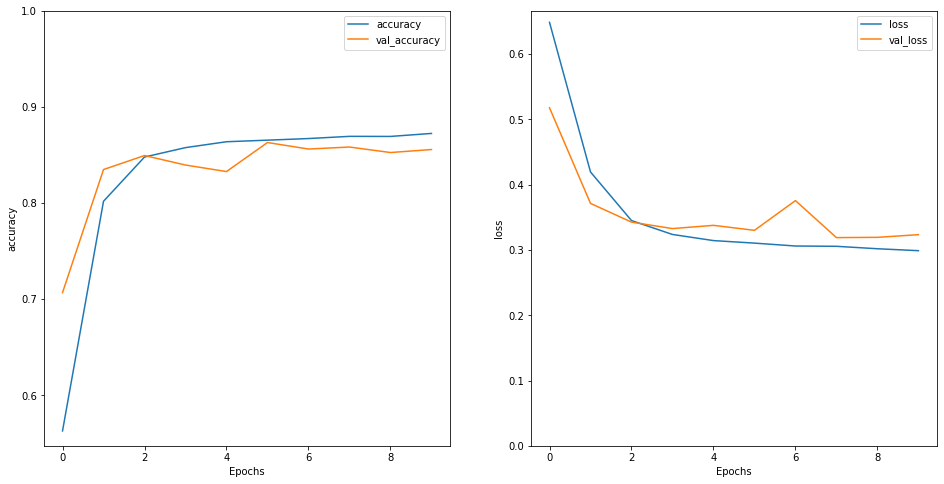

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 1:35:04 - loss: 0.6935 - accuracy: 0.4844

  2/391 [..............................] - ETA: 57s - loss: 0.6935 - accuracy: 0.4609    

  3/391 [..............................] - ETA: 50s - loss: 0.6933 - accuracy: 0.4583

  4/391 [..............................] - ETA: 46s - loss: 0.6935 - accuracy: 0.4453

  5/391 [..............................] - ETA: 47s - loss: 0.6934 - accuracy: 0.4500

  6/391 [..............................] - ETA: 48s - loss: 0.6934 - accuracy: 0.4635

  7/391 [..............................] - ETA: 49s - loss: 0.6934 - accuracy: 0.4688

  8/391 [..............................] - ETA: 48s - loss: 0.6934 - accuracy: 0.4727

  9/391 [..............................] - ETA: 49s - loss: 0.6933 - accuracy: 0.4774

 10/391 [..............................] - ETA: 49s - loss: 0.6932 - accuracy: 0.4844

 11/391 [..............................] - ETA: 49s - loss: 0.6932 - accuracy: 0.4830

 12/391 [..............................] - ETA: 47s - loss: 0.6932 - accuracy: 0.4857

 13/391 [..............................] - ETA: 47s - loss: 0.6932 - accuracy: 0.4940

 14/391 [>.............................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4911

 15/391 [>.............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4938

 16/391 [>.............................] - ETA: 44s - loss: 0.6932 - accuracy: 0.4941

 17/391 [>.............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.4890

 18/391 [>.............................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4896

 19/391 [>.............................] - ETA: 46s - loss: 0.6932 - accuracy: 0.4942

 20/391 [>.............................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4953

 21/391 [>.............................] - ETA: 46s - loss: 0.6931 - accuracy: 0.4970

 22/391 [>.............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4922

 23/391 [>.............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4932

 24/391 [>.............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4941

 25/391 [>.............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4963

 26/391 [>.............................] - ETA: 46s - loss: 0.6929 - accuracy: 0.4970

 27/391 [=>............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5000

 28/391 [=>............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5011

 29/391 [=>............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5016

 30/391 [=>............................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4995

 31/391 [=>............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4985

 32/391 [=>............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4995

 33/391 [=>............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4953

 34/391 [=>............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4954

 35/391 [=>............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4982

 36/391 [=>............................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4970

 37/391 [=>............................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4987

 38/391 [=>............................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5008

 39/391 [=>............................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5008

 40/391 [==>...........................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5012

 41/391 [==>...........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4989

 42/391 [==>...........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4967

 43/391 [==>...........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4945

 44/391 [==>...........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4972

 45/391 [==>...........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4983

 46/391 [==>...........................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4993

 47/391 [==>...........................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4977

 48/391 [==>...........................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4954

 49/391 [==>...........................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4968

 50/391 [==>...........................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4972

 51/391 [==>...........................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4972

 52/391 [==>...........................] - ETA: 42s - loss: 0.6930 - accuracy: 0.4955

 53/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4965

 54/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4959

 55/391 [===>..........................] - ETA: 41s - loss: 0.6931 - accuracy: 0.4957

 56/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4986

 57/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4992

 58/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5005

 59/391 [===>..........................] - ETA: 41s - loss: 0.6930 - accuracy: 0.4997

 60/391 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4992

 61/391 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4982

 62/391 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4990

 63/391 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.4998

 64/391 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5007

 65/391 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5000

 66/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4998

 67/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5005

 68/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4993

 69/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4984

 70/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4980

 71/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4996

 72/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4989

 73/391 [====>.........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.4994

 74/391 [====>.........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4987

 75/391 [====>.........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4985

 76/391 [====>.........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4977

 77/391 [====>.........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4974

 78/391 [====>.........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4976

 79/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4986

 80/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4990

 81/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4981

 82/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4985

 83/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4974

 84/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4980

 85/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4983

 86/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4991

 87/391 [=====>........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4982

 88/391 [=====>........................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4991

 89/391 [=====>........................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4988

 90/391 [=====>........................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4988

 91/391 [=====>........................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4991

 92/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4990

 93/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4998

 94/391 [======>.......................] - ETA: 37s - loss: 0.6929 - accuracy: 0.4992

 95/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4985

 96/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4990

 97/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4981

 98/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4989

 99/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4989

100/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.5003

101/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4998

102/391 [======>.......................] - ETA: 36s - loss: 0.6929 - accuracy: 0.4995

103/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4983

104/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4973

105/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4975

106/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4969

107/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4968

108/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4962

109/391 [=======>......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.4956

110/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4950

111/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4965

112/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4965

113/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4965

114/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4962

115/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4961

116/391 [=======>......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.4969

117/391 [=======>......................] - ETA: 34s - loss: 0.6928 - accuracy: 0.4963

118/391 [========>.....................] - ETA: 33s - loss: 0.6929 - accuracy: 0.4968

119/391 [========>.....................] - ETA: 33s - loss: 0.6928 - accuracy: 0.4968

120/391 [========>.....................] - ETA: 33s - loss: 0.6929 - accuracy: 0.4969

121/391 [========>.....................] - ETA: 33s - loss: 0.6929 - accuracy: 0.4975

122/391 [========>.....................] - ETA: 33s - loss: 0.6929 - accuracy: 0.4976

123/391 [========>.....................] - ETA: 33s - loss: 0.6929 - accuracy: 0.4972

124/391 [========>.....................] - ETA: 33s - loss: 0.6929 - accuracy: 0.4977

125/391 [========>.....................] - ETA: 32s - loss: 0.6929 - accuracy: 0.4980

126/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4976

127/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4972

128/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4967

129/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4970

130/391 [========>.....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4968

131/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4969

132/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4973

133/391 [=========>....................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4968

134/391 [=========>....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.4970

135/391 [=========>....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.4973

136/391 [=========>....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.4971

137/391 [=========>....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.4965

138/391 [=========>....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.4967

139/391 [=========>....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.4966

140/391 [=========>....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.4965

141/391 [=========>....................] - ETA: 31s - loss: 0.6928 - accuracy: 0.4969

142/391 [=========>....................] - ETA: 31s - loss: 0.6927 - accuracy: 0.4972

143/391 [=========>....................] - ETA: 30s - loss: 0.6927 - accuracy: 0.4972

144/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.4970

145/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.4964

146/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.4963

147/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.4965

148/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.4966

149/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.4973

150/391 [==========>...................] - ETA: 30s - loss: 0.6927 - accuracy: 0.4975

151/391 [==========>...................] - ETA: 29s - loss: 0.6927 - accuracy: 0.4974

152/391 [==========>...................] - ETA: 29s - loss: 0.6927 - accuracy: 0.4970

153/391 [==========>...................] - ETA: 29s - loss: 0.6927 - accuracy: 0.4969

154/391 [==========>...................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4969

155/391 [==========>...................] - ETA: 29s - loss: 0.6927 - accuracy: 0.4964

156/391 [==========>...................] - ETA: 29s - loss: 0.6927 - accuracy: 0.4965

157/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4967

158/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4965

159/391 [===========>..................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4966

160/391 [===========>..................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4965

161/391 [===========>..................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4968

162/391 [===========>..................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4967

163/391 [===========>..................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4964

164/391 [===========>..................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4968

165/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.4970

166/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.4963

167/391 [===========>..................] - ETA: 28s - loss: 0.6925 - accuracy: 0.4963

168/391 [===========>..................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4970

169/391 [===========>..................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4961

170/391 [============>.................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4960

171/391 [============>.................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4959

172/391 [============>.................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4960

173/391 [============>.................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4958

174/391 [============>.................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4960

175/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.4955

176/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4964

177/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4958

178/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4956

179/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4956

180/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4959

181/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4959

182/391 [============>.................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4963

183/391 [=============>................] - ETA: 26s - loss: 0.6924 - accuracy: 0.4956

184/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.4953

185/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.4947

186/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.4950

187/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.4952

188/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.4953

189/391 [=============>................] - ETA: 25s - loss: 0.6923 - accuracy: 0.4955

190/391 [=============>................] - ETA: 25s - loss: 0.6922 - accuracy: 0.4959

191/391 [=============>................] - ETA: 25s - loss: 0.6922 - accuracy: 0.4957

192/391 [=============>................] - ETA: 25s - loss: 0.6922 - accuracy: 0.4954

193/391 [=============>................] - ETA: 24s - loss: 0.6922 - accuracy: 0.4957

194/391 [=============>................] - ETA: 24s - loss: 0.6921 - accuracy: 0.4959

195/391 [=============>................] - ETA: 24s - loss: 0.6921 - accuracy: 0.4958

196/391 [==============>...............] - ETA: 24s - loss: 0.6921 - accuracy: 0.4963

197/391 [==============>...............] - ETA: 24s - loss: 0.6921 - accuracy: 0.4967

198/391 [==============>...............] - ETA: 24s - loss: 0.6921 - accuracy: 0.4972

199/391 [==============>...............] - ETA: 24s - loss: 0.6921 - accuracy: 0.4966

200/391 [==============>...............] - ETA: 24s - loss: 0.6920 - accuracy: 0.4966

201/391 [==============>...............] - ETA: 23s - loss: 0.6920 - accuracy: 0.4967

202/391 [==============>...............] - ETA: 23s - loss: 0.6920 - accuracy: 0.4970

203/391 [==============>...............] - ETA: 23s - loss: 0.6920 - accuracy: 0.4970

204/391 [==============>...............] - ETA: 23s - loss: 0.6920 - accuracy: 0.4972

205/391 [==============>...............] - ETA: 23s - loss: 0.6920 - accuracy: 0.4978

206/391 [==============>...............] - ETA: 23s - loss: 0.6919 - accuracy: 0.4980

207/391 [==============>...............] - ETA: 23s - loss: 0.6919 - accuracy: 0.4980

208/391 [==============>...............] - ETA: 23s - loss: 0.6919 - accuracy: 0.4980

209/391 [===============>..............] - ETA: 22s - loss: 0.6919 - accuracy: 0.4978

210/391 [===============>..............] - ETA: 22s - loss: 0.6918 - accuracy: 0.4980

211/391 [===============>..............] - ETA: 22s - loss: 0.6918 - accuracy: 0.4979

212/391 [===============>..............] - ETA: 22s - loss: 0.6918 - accuracy: 0.4982

213/391 [===============>..............] - ETA: 22s - loss: 0.6917 - accuracy: 0.4980

214/391 [===============>..............] - ETA: 22s - loss: 0.6917 - accuracy: 0.4977

215/391 [===============>..............] - ETA: 22s - loss: 0.6917 - accuracy: 0.4974

216/391 [===============>..............] - ETA: 22s - loss: 0.6917 - accuracy: 0.4977

217/391 [===============>..............] - ETA: 21s - loss: 0.6917 - accuracy: 0.4975

218/391 [===============>..............] - ETA: 21s - loss: 0.6917 - accuracy: 0.4972

219/391 [===============>..............] - ETA: 21s - loss: 0.6916 - accuracy: 0.4974

220/391 [===============>..............] - ETA: 21s - loss: 0.6916 - accuracy: 0.4976

221/391 [===============>..............] - ETA: 21s - loss: 0.6915 - accuracy: 0.4976

222/391 [================>.............] - ETA: 21s - loss: 0.6915 - accuracy: 0.4981

223/391 [================>.............] - ETA: 21s - loss: 0.6915 - accuracy: 0.4985

224/391 [================>.............] - ETA: 21s - loss: 0.6914 - accuracy: 0.4987

225/391 [================>.............] - ETA: 20s - loss: 0.6914 - accuracy: 0.4988

226/391 [================>.............] - ETA: 20s - loss: 0.6914 - accuracy: 0.4983

227/391 [================>.............] - ETA: 20s - loss: 0.6914 - accuracy: 0.4983

228/391 [================>.............] - ETA: 20s - loss: 0.6914 - accuracy: 0.4980

229/391 [================>.............] - ETA: 20s - loss: 0.6914 - accuracy: 0.4979

230/391 [================>.............] - ETA: 20s - loss: 0.6913 - accuracy: 0.4980

231/391 [================>.............] - ETA: 20s - loss: 0.6912 - accuracy: 0.4982

232/391 [================>.............] - ETA: 20s - loss: 0.6912 - accuracy: 0.4985

233/391 [================>.............] - ETA: 19s - loss: 0.6911 - accuracy: 0.4991

234/391 [================>.............] - ETA: 19s - loss: 0.6910 - accuracy: 0.4993

235/391 [=================>............] - ETA: 19s - loss: 0.6909 - accuracy: 0.4995

236/391 [=================>............] - ETA: 19s - loss: 0.6908 - accuracy: 0.4994

237/391 [=================>............] - ETA: 19s - loss: 0.6908 - accuracy: 0.4991

238/391 [=================>............] - ETA: 19s - loss: 0.6908 - accuracy: 0.4986

239/391 [=================>............] - ETA: 19s - loss: 0.6906 - accuracy: 0.4990

240/391 [=================>............] - ETA: 19s - loss: 0.6905 - accuracy: 0.4991

241/391 [=================>............] - ETA: 18s - loss: 0.6904 - accuracy: 0.4988

242/391 [=================>............] - ETA: 18s - loss: 0.6902 - accuracy: 0.4986

243/391 [=================>............] - ETA: 18s - loss: 0.6903 - accuracy: 0.4986

244/391 [=================>............] - ETA: 18s - loss: 0.6901 - accuracy: 0.4989

245/391 [=================>............] - ETA: 18s - loss: 0.6898 - accuracy: 0.4992

246/391 [=================>............] - ETA: 18s - loss: 0.6896 - accuracy: 0.4994

247/391 [=================>............] - ETA: 18s - loss: 0.6894 - accuracy: 0.4992

248/391 [==================>...........] - ETA: 18s - loss: 0.6894 - accuracy: 0.4992

249/391 [==================>...........] - ETA: 17s - loss: 0.6891 - accuracy: 0.4996

250/391 [==================>...........] - ETA: 17s - loss: 0.6890 - accuracy: 0.4996

251/391 [==================>...........] - ETA: 17s - loss: 0.6886 - accuracy: 0.5003

252/391 [==================>...........] - ETA: 17s - loss: 0.6884 - accuracy: 0.5004

253/391 [==================>...........] - ETA: 17s - loss: 0.6881 - accuracy: 0.5009

254/391 [==================>...........] - ETA: 17s - loss: 0.6878 - accuracy: 0.5012

255/391 [==================>...........] - ETA: 17s - loss: 0.6877 - accuracy: 0.5015

256/391 [==================>...........] - ETA: 17s - loss: 0.6875 - accuracy: 0.5020

257/391 [==================>...........] - ETA: 16s - loss: 0.6874 - accuracy: 0.5024

258/391 [==================>...........] - ETA: 16s - loss: 0.6870 - accuracy: 0.5033

259/391 [==================>...........] - ETA: 16s - loss: 0.6867 - accuracy: 0.5036

260/391 [==================>...........] - ETA: 16s - loss: 0.6863 - accuracy: 0.5040

261/391 [===================>..........] - ETA: 16s - loss: 0.6862 - accuracy: 0.5044

262/391 [===================>..........] - ETA: 16s - loss: 0.6862 - accuracy: 0.5047

263/391 [===================>..........] - ETA: 16s - loss: 0.6857 - accuracy: 0.5050

264/391 [===================>..........] - ETA: 15s - loss: 0.6857 - accuracy: 0.5051

265/391 [===================>..........] - ETA: 15s - loss: 0.6856 - accuracy: 0.5055

266/391 [===================>..........] - ETA: 15s - loss: 0.6854 - accuracy: 0.5060

267/391 [===================>..........] - ETA: 15s - loss: 0.6852 - accuracy: 0.5064

268/391 [===================>..........] - ETA: 15s - loss: 0.6846 - accuracy: 0.5072

269/391 [===================>..........] - ETA: 15s - loss: 0.6845 - accuracy: 0.5076

270/391 [===================>..........] - ETA: 15s - loss: 0.6842 - accuracy: 0.5082

271/391 [===================>..........] - ETA: 15s - loss: 0.6841 - accuracy: 0.5086

272/391 [===================>..........] - ETA: 14s - loss: 0.6838 - accuracy: 0.5092

273/391 [===================>..........] - ETA: 14s - loss: 0.6838 - accuracy: 0.5098

274/391 [====================>.........] - ETA: 14s - loss: 0.6834 - accuracy: 0.5102

275/391 [====================>.........] - ETA: 14s - loss: 0.6831 - accuracy: 0.5108

276/391 [====================>.........] - ETA: 14s - loss: 0.6830 - accuracy: 0.5113

277/391 [====================>.........] - ETA: 14s - loss: 0.6829 - accuracy: 0.5114

278/391 [====================>.........] - ETA: 14s - loss: 0.6825 - accuracy: 0.5121

279/391 [====================>.........] - ETA: 14s - loss: 0.6820 - accuracy: 0.5129

280/391 [====================>.........] - ETA: 13s - loss: 0.6819 - accuracy: 0.5132

281/391 [====================>.........] - ETA: 13s - loss: 0.6817 - accuracy: 0.5140

282/391 [====================>.........] - ETA: 13s - loss: 0.6816 - accuracy: 0.5147

283/391 [====================>.........] - ETA: 13s - loss: 0.6812 - accuracy: 0.5155

284/391 [====================>.........] - ETA: 13s - loss: 0.6810 - accuracy: 0.5157

285/391 [====================>.........] - ETA: 13s - loss: 0.6806 - accuracy: 0.5166

286/391 [====================>.........] - ETA: 13s - loss: 0.6803 - accuracy: 0.5169

287/391 [=====================>........] - ETA: 13s - loss: 0.6800 - accuracy: 0.5171

288/391 [=====================>........] - ETA: 12s - loss: 0.6797 - accuracy: 0.5175

289/391 [=====================>........] - ETA: 12s - loss: 0.6800 - accuracy: 0.5172

290/391 [=====================>........] - ETA: 12s - loss: 0.6799 - accuracy: 0.5170

291/391 [=====================>........] - ETA: 12s - loss: 0.6796 - accuracy: 0.5172

292/391 [=====================>........] - ETA: 12s - loss: 0.6792 - accuracy: 0.5176

293/391 [=====================>........] - ETA: 12s - loss: 0.6788 - accuracy: 0.5179

294/391 [=====================>........] - ETA: 12s - loss: 0.6785 - accuracy: 0.5182

295/391 [=====================>........] - ETA: 12s - loss: 0.6782 - accuracy: 0.5184

296/391 [=====================>........] - ETA: 11s - loss: 0.6782 - accuracy: 0.5184

297/391 [=====================>........] - ETA: 11s - loss: 0.6778 - accuracy: 0.5185

298/391 [=====================>........] - ETA: 11s - loss: 0.6777 - accuracy: 0.5187

299/391 [=====================>........] - ETA: 11s - loss: 0.6775 - accuracy: 0.5185

300/391 [======================>.......] - ETA: 11s - loss: 0.6772 - accuracy: 0.5186

301/391 [======================>.......] - ETA: 11s - loss: 0.6769 - accuracy: 0.5187

302/391 [======================>.......] - ETA: 11s - loss: 0.6765 - accuracy: 0.5190

303/391 [======================>.......] - ETA: 11s - loss: 0.6763 - accuracy: 0.5195

304/391 [======================>.......] - ETA: 10s - loss: 0.6761 - accuracy: 0.5195

305/391 [======================>.......] - ETA: 10s - loss: 0.6758 - accuracy: 0.5197

306/391 [======================>.......] - ETA: 10s - loss: 0.6754 - accuracy: 0.5201

307/391 [======================>.......] - ETA: 10s - loss: 0.6749 - accuracy: 0.5207

308/391 [======================>.......] - ETA: 10s - loss: 0.6745 - accuracy: 0.5216

309/391 [======================>.......] - ETA: 10s - loss: 0.6741 - accuracy: 0.5223

310/391 [======================>.......] - ETA: 10s - loss: 0.6738 - accuracy: 0.5230

311/391 [======================>.......] - ETA: 10s - loss: 0.6733 - accuracy: 0.5238

312/391 [======================>.......] - ETA: 9s - loss: 0.6728 - accuracy: 0.5244 

313/391 [=======================>......] - ETA: 9s - loss: 0.6725 - accuracy: 0.5251

314/391 [=======================>......] - ETA: 9s - loss: 0.6721 - accuracy: 0.5257

315/391 [=======================>......] - ETA: 9s - loss: 0.6717 - accuracy: 0.5264

316/391 [=======================>......] - ETA: 9s - loss: 0.6713 - accuracy: 0.5269

317/391 [=======================>......] - ETA: 9s - loss: 0.6710 - accuracy: 0.5276

318/391 [=======================>......] - ETA: 9s - loss: 0.6708 - accuracy: 0.5281

319/391 [=======================>......] - ETA: 9s - loss: 0.6705 - accuracy: 0.5286

320/391 [=======================>......] - ETA: 8s - loss: 0.6703 - accuracy: 0.5291

321/391 [=======================>......] - ETA: 8s - loss: 0.6701 - accuracy: 0.5295

322/391 [=======================>......] - ETA: 8s - loss: 0.6698 - accuracy: 0.5300

323/391 [=======================>......] - ETA: 8s - loss: 0.6696 - accuracy: 0.5305

324/391 [=======================>......] - ETA: 8s - loss: 0.6691 - accuracy: 0.5312

325/391 [=======================>......] - ETA: 8s - loss: 0.6686 - accuracy: 0.5320

326/391 [========================>.....] - ETA: 8s - loss: 0.6685 - accuracy: 0.5324

327/391 [========================>.....] - ETA: 8s - loss: 0.6683 - accuracy: 0.5329

328/391 [========================>.....] - ETA: 7s - loss: 0.6681 - accuracy: 0.5333

329/391 [========================>.....] - ETA: 7s - loss: 0.6677 - accuracy: 0.5339

330/391 [========================>.....] - ETA: 7s - loss: 0.6676 - accuracy: 0.5343

331/391 [========================>.....] - ETA: 7s - loss: 0.6668 - accuracy: 0.5353

332/391 [========================>.....] - ETA: 7s - loss: 0.6664 - accuracy: 0.5359

333/391 [========================>.....] - ETA: 7s - loss: 0.6661 - accuracy: 0.5365

334/391 [========================>.....] - ETA: 7s - loss: 0.6655 - accuracy: 0.5373

335/391 [========================>.....] - ETA: 7s - loss: 0.6652 - accuracy: 0.5379

336/391 [========================>.....] - ETA: 6s - loss: 0.6650 - accuracy: 0.5383

337/391 [========================>.....] - ETA: 6s - loss: 0.6646 - accuracy: 0.5389

338/391 [========================>.....] - ETA: 6s - loss: 0.6642 - accuracy: 0.5397

339/391 [=========================>....] - ETA: 6s - loss: 0.6638 - accuracy: 0.5402

340/391 [=========================>....] - ETA: 6s - loss: 0.6634 - accuracy: 0.5408

341/391 [=========================>....] - ETA: 6s - loss: 0.6630 - accuracy: 0.5416

342/391 [=========================>....] - ETA: 6s - loss: 0.6627 - accuracy: 0.5421

343/391 [=========================>....] - ETA: 6s - loss: 0.6623 - accuracy: 0.5426

344/391 [=========================>....] - ETA: 5s - loss: 0.6621 - accuracy: 0.5432

345/391 [=========================>....] - ETA: 5s - loss: 0.6617 - accuracy: 0.5437

346/391 [=========================>....] - ETA: 5s - loss: 0.6614 - accuracy: 0.5443

347/391 [=========================>....] - ETA: 5s - loss: 0.6610 - accuracy: 0.5449

348/391 [=========================>....] - ETA: 5s - loss: 0.6605 - accuracy: 0.5455

349/391 [=========================>....] - ETA: 5s - loss: 0.6602 - accuracy: 0.5459

350/391 [=========================>....] - ETA: 5s - loss: 0.6599 - accuracy: 0.5462

351/391 [=========================>....] - ETA: 5s - loss: 0.6595 - accuracy: 0.5467

352/391 [==========================>...] - ETA: 4s - loss: 0.6593 - accuracy: 0.5470

353/391 [==========================>...] - ETA: 4s - loss: 0.6590 - accuracy: 0.5473

354/391 [==========================>...] - ETA: 4s - loss: 0.6584 - accuracy: 0.5480

355/391 [==========================>...] - ETA: 4s - loss: 0.6578 - accuracy: 0.5487

356/391 [==========================>...] - ETA: 4s - loss: 0.6573 - accuracy: 0.5492

357/391 [==========================>...] - ETA: 4s - loss: 0.6570 - accuracy: 0.5495

358/391 [==========================>...] - ETA: 4s - loss: 0.6565 - accuracy: 0.5502

359/391 [==========================>...] - ETA: 4s - loss: 0.6560 - accuracy: 0.5507

360/391 [==========================>...] - ETA: 3s - loss: 0.6555 - accuracy: 0.5514

361/391 [==========================>...] - ETA: 3s - loss: 0.6549 - accuracy: 0.5521

362/391 [==========================>...] - ETA: 3s - loss: 0.6546 - accuracy: 0.5527

363/391 [==========================>...] - ETA: 3s - loss: 0.6539 - accuracy: 0.5534

364/391 [==========================>...] - ETA: 3s - loss: 0.6535 - accuracy: 0.5542

365/391 [===========================>..] - ETA: 3s - loss: 0.6532 - accuracy: 0.5547

366/391 [===========================>..] - ETA: 3s - loss: 0.6532 - accuracy: 0.5551

367/391 [===========================>..] - ETA: 3s - loss: 0.6526 - accuracy: 0.5559

368/391 [===========================>..] - ETA: 2s - loss: 0.6524 - accuracy: 0.5563

369/391 [===========================>..] - ETA: 2s - loss: 0.6524 - accuracy: 0.5566

370/391 [===========================>..] - ETA: 2s - loss: 0.6521 - accuracy: 0.5571

371/391 [===========================>..] - ETA: 2s - loss: 0.6517 - accuracy: 0.5577

372/391 [===========================>..] - ETA: 2s - loss: 0.6514 - accuracy: 0.5580

373/391 [===========================>..] - ETA: 2s - loss: 0.6510 - accuracy: 0.5587

374/391 [===========================>..] - ETA: 2s - loss: 0.6504 - accuracy: 0.5595

375/391 [===========================>..] - ETA: 2s - loss: 0.6500 - accuracy: 0.5600

376/391 [===========================>..] - ETA: 1s - loss: 0.6497 - accuracy: 0.5604

377/391 [===========================>..] - ETA: 1s - loss: 0.6493 - accuracy: 0.5608

378/391 [============================>.] - ETA: 1s - loss: 0.6488 - accuracy: 0.5611

379/391 [============================>.] - ETA: 1s - loss: 0.6485 - accuracy: 0.5615

380/391 [============================>.] - ETA: 1s - loss: 0.6479 - accuracy: 0.5620

381/391 [============================>.] - ETA: 1s - loss: 0.6475 - accuracy: 0.5623

382/391 [============================>.] - ETA: 1s - loss: 0.6468 - accuracy: 0.5630

383/391 [============================>.] - ETA: 1s - loss: 0.6463 - accuracy: 0.5636

384/391 [============================>.] - ETA: 0s - loss: 0.6458 - accuracy: 0.5642

385/391 [============================>.] - ETA: 0s - loss: 0.6453 - accuracy: 0.5647

386/391 [============================>.] - ETA: 0s - loss: 0.6449 - accuracy: 0.5653

387/391 [============================>.] - ETA: 0s - loss: 0.6445 - accuracy: 0.5659

388/391 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.5664

389/391 [============================>.] - ETA: 0s - loss: 0.6435 - accuracy: 0.5670

390/391 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.5676

391/391 [==============================] - ETA: 0s - loss: 0.6427 - accuracy: 0.5680

391/391 [==============================] - 71s 145ms/step - loss: 0.6427 - accuracy: 0.5680 - val_loss: 0.4593 - val_accuracy: 0.8021


Epoch 2/10


  1/391 [..............................] - ETA: 11:54 - loss: 0.4615 - accuracy: 0.8125

  2/391 [..............................] - ETA: 49s - loss: 0.4344 - accuracy: 0.8203  

  3/391 [..............................] - ETA: 49s - loss: 0.4280 - accuracy: 0.8177

  4/391 [..............................] - ETA: 51s - loss: 0.4542 - accuracy: 0.8047

  5/391 [..............................] - ETA: 50s - loss: 0.4428 - accuracy: 0.8125

  6/391 [..............................] - ETA: 51s - loss: 0.4578 - accuracy: 0.8047

  7/391 [..............................] - ETA: 51s - loss: 0.4458 - accuracy: 0.8170

  8/391 [..............................] - ETA: 52s - loss: 0.4421 - accuracy: 0.8203

  9/391 [..............................] - ETA: 52s - loss: 0.4559 - accuracy: 0.8125

 10/391 [..............................] - ETA: 50s - loss: 0.4574 - accuracy: 0.8094

 11/391 [..............................] - ETA: 50s - loss: 0.4579 - accuracy: 0.8068

 12/391 [..............................] - ETA: 49s - loss: 0.4555 - accuracy: 0.8047

 13/391 [..............................] - ETA: 50s - loss: 0.4531 - accuracy: 0.8053

 14/391 [>.............................] - ETA: 49s - loss: 0.4502 - accuracy: 0.8069

 15/391 [>.............................] - ETA: 49s - loss: 0.4499 - accuracy: 0.8073

 16/391 [>.............................] - ETA: 49s - loss: 0.4513 - accuracy: 0.8066

 17/391 [>.............................] - ETA: 49s - loss: 0.4569 - accuracy: 0.8024

 18/391 [>.............................] - ETA: 48s - loss: 0.4575 - accuracy: 0.8047

 19/391 [>.............................] - ETA: 48s - loss: 0.4580 - accuracy: 0.8059

 20/391 [>.............................] - ETA: 48s - loss: 0.4581 - accuracy: 0.8031

 21/391 [>.............................] - ETA: 48s - loss: 0.4557 - accuracy: 0.8051

 22/391 [>.............................] - ETA: 47s - loss: 0.4538 - accuracy: 0.8061

 23/391 [>.............................] - ETA: 47s - loss: 0.4523 - accuracy: 0.8071

 24/391 [>.............................] - ETA: 46s - loss: 0.4506 - accuracy: 0.8092

 25/391 [>.............................] - ETA: 46s - loss: 0.4471 - accuracy: 0.8112

 26/391 [>.............................] - ETA: 45s - loss: 0.4503 - accuracy: 0.8089

 27/391 [=>............................] - ETA: 45s - loss: 0.4509 - accuracy: 0.8084

 28/391 [=>............................] - ETA: 45s - loss: 0.4532 - accuracy: 0.8069

 29/391 [=>............................] - ETA: 45s - loss: 0.4551 - accuracy: 0.8077

 30/391 [=>............................] - ETA: 45s - loss: 0.4548 - accuracy: 0.8073

 31/391 [=>............................] - ETA: 45s - loss: 0.4522 - accuracy: 0.8085

 32/391 [=>............................] - ETA: 45s - loss: 0.4513 - accuracy: 0.8076

 33/391 [=>............................] - ETA: 45s - loss: 0.4499 - accuracy: 0.8078

 34/391 [=>............................] - ETA: 45s - loss: 0.4526 - accuracy: 0.8065

 35/391 [=>............................] - ETA: 44s - loss: 0.4514 - accuracy: 0.8071

 36/391 [=>............................] - ETA: 44s - loss: 0.4534 - accuracy: 0.8047

 37/391 [=>............................] - ETA: 44s - loss: 0.4546 - accuracy: 0.8045

 38/391 [=>............................] - ETA: 44s - loss: 0.4549 - accuracy: 0.8035

 39/391 [=>............................] - ETA: 44s - loss: 0.4556 - accuracy: 0.8037

 40/391 [==>...........................] - ETA: 44s - loss: 0.4525 - accuracy: 0.8059

 41/391 [==>...........................] - ETA: 43s - loss: 0.4512 - accuracy: 0.8060

 42/391 [==>...........................] - ETA: 43s - loss: 0.4506 - accuracy: 0.8062

 43/391 [==>...........................] - ETA: 43s - loss: 0.4513 - accuracy: 0.8060

 44/391 [==>...........................] - ETA: 43s - loss: 0.4509 - accuracy: 0.8058

 45/391 [==>...........................] - ETA: 43s - loss: 0.4495 - accuracy: 0.8066

 46/391 [==>...........................] - ETA: 43s - loss: 0.4471 - accuracy: 0.8081

 47/391 [==>...........................] - ETA: 43s - loss: 0.4470 - accuracy: 0.8065

 48/391 [==>...........................] - ETA: 43s - loss: 0.4457 - accuracy: 0.8083

 49/391 [==>...........................] - ETA: 42s - loss: 0.4460 - accuracy: 0.8084

 50/391 [==>...........................] - ETA: 42s - loss: 0.4464 - accuracy: 0.8078

 51/391 [==>...........................] - ETA: 42s - loss: 0.4467 - accuracy: 0.8079

 52/391 [==>...........................] - ETA: 42s - loss: 0.4484 - accuracy: 0.8071

 53/391 [===>..........................] - ETA: 42s - loss: 0.4487 - accuracy: 0.8072

 54/391 [===>..........................] - ETA: 42s - loss: 0.4483 - accuracy: 0.8073

 55/391 [===>..........................] - ETA: 41s - loss: 0.4470 - accuracy: 0.8080

 56/391 [===>..........................] - ETA: 41s - loss: 0.4459 - accuracy: 0.8094

 57/391 [===>..........................] - ETA: 41s - loss: 0.4467 - accuracy: 0.8098

 58/391 [===>..........................] - ETA: 41s - loss: 0.4479 - accuracy: 0.8095

 59/391 [===>..........................] - ETA: 41s - loss: 0.4464 - accuracy: 0.8106

 60/391 [===>..........................] - ETA: 41s - loss: 0.4480 - accuracy: 0.8102

 61/391 [===>..........................] - ETA: 41s - loss: 0.4491 - accuracy: 0.8081

 62/391 [===>..........................] - ETA: 41s - loss: 0.4486 - accuracy: 0.8080

 63/391 [===>..........................] - ETA: 40s - loss: 0.4489 - accuracy: 0.8080

 64/391 [===>..........................] - ETA: 40s - loss: 0.4491 - accuracy: 0.8074

 65/391 [===>..........................] - ETA: 40s - loss: 0.4494 - accuracy: 0.8075

 66/391 [====>.........................] - ETA: 40s - loss: 0.4501 - accuracy: 0.8068

 67/391 [====>.........................] - ETA: 40s - loss: 0.4502 - accuracy: 0.8071

 68/391 [====>.........................] - ETA: 40s - loss: 0.4501 - accuracy: 0.8072

 69/391 [====>.........................] - ETA: 40s - loss: 0.4478 - accuracy: 0.8084

 70/391 [====>.........................] - ETA: 40s - loss: 0.4492 - accuracy: 0.8069

 71/391 [====>.........................] - ETA: 39s - loss: 0.4474 - accuracy: 0.8081

 72/391 [====>.........................] - ETA: 39s - loss: 0.4482 - accuracy: 0.8075

 73/391 [====>.........................] - ETA: 39s - loss: 0.4482 - accuracy: 0.8069

 74/391 [====>.........................] - ETA: 39s - loss: 0.4477 - accuracy: 0.8070

 75/391 [====>.........................] - ETA: 39s - loss: 0.4480 - accuracy: 0.8056

 76/391 [====>.........................] - ETA: 39s - loss: 0.4474 - accuracy: 0.8067

 77/391 [====>.........................] - ETA: 39s - loss: 0.4471 - accuracy: 0.8074

 78/391 [====>.........................] - ETA: 39s - loss: 0.4467 - accuracy: 0.8075

 79/391 [=====>........................] - ETA: 38s - loss: 0.4457 - accuracy: 0.8083

 80/391 [=====>........................] - ETA: 38s - loss: 0.4453 - accuracy: 0.8086

 81/391 [=====>........................] - ETA: 38s - loss: 0.4461 - accuracy: 0.8079

 82/391 [=====>........................] - ETA: 38s - loss: 0.4460 - accuracy: 0.8079

 83/391 [=====>........................] - ETA: 38s - loss: 0.4469 - accuracy: 0.8069

 84/391 [=====>........................] - ETA: 38s - loss: 0.4455 - accuracy: 0.8073

 85/391 [=====>........................] - ETA: 38s - loss: 0.4448 - accuracy: 0.8079

 86/391 [=====>........................] - ETA: 38s - loss: 0.4444 - accuracy: 0.8083

 87/391 [=====>........................] - ETA: 38s - loss: 0.4436 - accuracy: 0.8089

 88/391 [=====>........................] - ETA: 37s - loss: 0.4427 - accuracy: 0.8097

 89/391 [=====>........................] - ETA: 37s - loss: 0.4418 - accuracy: 0.8106

 90/391 [=====>........................] - ETA: 37s - loss: 0.4401 - accuracy: 0.8120

 91/391 [=====>........................] - ETA: 37s - loss: 0.4390 - accuracy: 0.8122

 92/391 [======>.......................] - ETA: 37s - loss: 0.4397 - accuracy: 0.8117

 93/391 [======>.......................] - ETA: 37s - loss: 0.4390 - accuracy: 0.8122

 94/391 [======>.......................] - ETA: 37s - loss: 0.4394 - accuracy: 0.8117

 95/391 [======>.......................] - ETA: 37s - loss: 0.4393 - accuracy: 0.8115

 96/391 [======>.......................] - ETA: 36s - loss: 0.4386 - accuracy: 0.8117

 97/391 [======>.......................] - ETA: 36s - loss: 0.4393 - accuracy: 0.8111

 98/391 [======>.......................] - ETA: 36s - loss: 0.4397 - accuracy: 0.8104

 99/391 [======>.......................] - ETA: 36s - loss: 0.4391 - accuracy: 0.8111

100/391 [======>.......................] - ETA: 36s - loss: 0.4385 - accuracy: 0.8119

101/391 [======>.......................] - ETA: 36s - loss: 0.4375 - accuracy: 0.8120

102/391 [======>.......................] - ETA: 36s - loss: 0.4378 - accuracy: 0.8116

103/391 [======>.......................] - ETA: 35s - loss: 0.4388 - accuracy: 0.8111

104/391 [======>.......................] - ETA: 35s - loss: 0.4388 - accuracy: 0.8108

105/391 [=======>......................] - ETA: 35s - loss: 0.4390 - accuracy: 0.8106

106/391 [=======>......................] - ETA: 35s - loss: 0.4384 - accuracy: 0.8113

107/391 [=======>......................] - ETA: 35s - loss: 0.4384 - accuracy: 0.8113

108/391 [=======>......................] - ETA: 35s - loss: 0.4397 - accuracy: 0.8100

109/391 [=======>......................] - ETA: 35s - loss: 0.4391 - accuracy: 0.8103

110/391 [=======>......................] - ETA: 35s - loss: 0.4389 - accuracy: 0.8102

111/391 [=======>......................] - ETA: 35s - loss: 0.4397 - accuracy: 0.8088

112/391 [=======>......................] - ETA: 35s - loss: 0.4388 - accuracy: 0.8086

113/391 [=======>......................] - ETA: 35s - loss: 0.4386 - accuracy: 0.8082

114/391 [=======>......................] - ETA: 35s - loss: 0.4381 - accuracy: 0.8081

115/391 [=======>......................] - ETA: 34s - loss: 0.4375 - accuracy: 0.8082

116/391 [=======>......................] - ETA: 35s - loss: 0.4370 - accuracy: 0.8085

117/391 [=======>......................] - ETA: 34s - loss: 0.4366 - accuracy: 0.8088

118/391 [========>.....................] - ETA: 34s - loss: 0.4362 - accuracy: 0.8087

119/391 [========>.....................] - ETA: 34s - loss: 0.4363 - accuracy: 0.8090

120/391 [========>.....................] - ETA: 34s - loss: 0.4364 - accuracy: 0.8091

121/391 [========>.....................] - ETA: 34s - loss: 0.4359 - accuracy: 0.8091

122/391 [========>.....................] - ETA: 33s - loss: 0.4356 - accuracy: 0.8093

123/391 [========>.....................] - ETA: 33s - loss: 0.4353 - accuracy: 0.8095

124/391 [========>.....................] - ETA: 33s - loss: 0.4345 - accuracy: 0.8097

125/391 [========>.....................] - ETA: 33s - loss: 0.4337 - accuracy: 0.8106

126/391 [========>.....................] - ETA: 33s - loss: 0.4337 - accuracy: 0.8110

127/391 [========>.....................] - ETA: 33s - loss: 0.4332 - accuracy: 0.8109

128/391 [========>.....................] - ETA: 33s - loss: 0.4329 - accuracy: 0.8112

129/391 [========>.....................] - ETA: 33s - loss: 0.4322 - accuracy: 0.8115

130/391 [========>.....................] - ETA: 32s - loss: 0.4317 - accuracy: 0.8118

131/391 [=========>....................] - ETA: 32s - loss: 0.4320 - accuracy: 0.8113

132/391 [=========>....................] - ETA: 32s - loss: 0.4314 - accuracy: 0.8117

133/391 [=========>....................] - ETA: 32s - loss: 0.4299 - accuracy: 0.8126

134/391 [=========>....................] - ETA: 32s - loss: 0.4293 - accuracy: 0.8128

135/391 [=========>....................] - ETA: 32s - loss: 0.4296 - accuracy: 0.8125

136/391 [=========>....................] - ETA: 32s - loss: 0.4288 - accuracy: 0.8130

137/391 [=========>....................] - ETA: 32s - loss: 0.4285 - accuracy: 0.8133

138/391 [=========>....................] - ETA: 31s - loss: 0.4285 - accuracy: 0.8131

139/391 [=========>....................] - ETA: 31s - loss: 0.4289 - accuracy: 0.8127

140/391 [=========>....................] - ETA: 31s - loss: 0.4284 - accuracy: 0.8132

141/391 [=========>....................] - ETA: 31s - loss: 0.4285 - accuracy: 0.8131

142/391 [=========>....................] - ETA: 31s - loss: 0.4293 - accuracy: 0.8127

143/391 [=========>....................] - ETA: 31s - loss: 0.4315 - accuracy: 0.8120

144/391 [==========>...................] - ETA: 31s - loss: 0.4302 - accuracy: 0.8124

145/391 [==========>...................] - ETA: 31s - loss: 0.4303 - accuracy: 0.8123

146/391 [==========>...................] - ETA: 30s - loss: 0.4301 - accuracy: 0.8127

147/391 [==========>...................] - ETA: 30s - loss: 0.4304 - accuracy: 0.8123

148/391 [==========>...................] - ETA: 30s - loss: 0.4308 - accuracy: 0.8120

149/391 [==========>...................] - ETA: 30s - loss: 0.4302 - accuracy: 0.8119

150/391 [==========>...................] - ETA: 30s - loss: 0.4299 - accuracy: 0.8120

151/391 [==========>...................] - ETA: 30s - loss: 0.4291 - accuracy: 0.8124

152/391 [==========>...................] - ETA: 30s - loss: 0.4295 - accuracy: 0.8124

153/391 [==========>...................] - ETA: 29s - loss: 0.4300 - accuracy: 0.8121

154/391 [==========>...................] - ETA: 29s - loss: 0.4298 - accuracy: 0.8124

155/391 [==========>...................] - ETA: 29s - loss: 0.4294 - accuracy: 0.8125

156/391 [==========>...................] - ETA: 29s - loss: 0.4292 - accuracy: 0.8122

157/391 [===========>..................] - ETA: 29s - loss: 0.4290 - accuracy: 0.8125

158/391 [===========>..................] - ETA: 29s - loss: 0.4290 - accuracy: 0.8121

159/391 [===========>..................] - ETA: 29s - loss: 0.4288 - accuracy: 0.8120

160/391 [===========>..................] - ETA: 29s - loss: 0.4280 - accuracy: 0.8123

161/391 [===========>..................] - ETA: 28s - loss: 0.4277 - accuracy: 0.8123

162/391 [===========>..................] - ETA: 28s - loss: 0.4277 - accuracy: 0.8123

163/391 [===========>..................] - ETA: 28s - loss: 0.4273 - accuracy: 0.8124

164/391 [===========>..................] - ETA: 28s - loss: 0.4266 - accuracy: 0.8129

165/391 [===========>..................] - ETA: 28s - loss: 0.4275 - accuracy: 0.8123

166/391 [===========>..................] - ETA: 28s - loss: 0.4270 - accuracy: 0.8121

167/391 [===========>..................] - ETA: 28s - loss: 0.4261 - accuracy: 0.8127

168/391 [===========>..................] - ETA: 28s - loss: 0.4252 - accuracy: 0.8133

169/391 [===========>..................] - ETA: 27s - loss: 0.4245 - accuracy: 0.8137

170/391 [============>.................] - ETA: 27s - loss: 0.4248 - accuracy: 0.8133

171/391 [============>.................] - ETA: 27s - loss: 0.4247 - accuracy: 0.8132

172/391 [============>.................] - ETA: 27s - loss: 0.4257 - accuracy: 0.8129

173/391 [============>.................] - ETA: 27s - loss: 0.4253 - accuracy: 0.8133

174/391 [============>.................] - ETA: 27s - loss: 0.4255 - accuracy: 0.8133

175/391 [============>.................] - ETA: 27s - loss: 0.4254 - accuracy: 0.8129

176/391 [============>.................] - ETA: 27s - loss: 0.4254 - accuracy: 0.8129

177/391 [============>.................] - ETA: 27s - loss: 0.4267 - accuracy: 0.8121

178/391 [============>.................] - ETA: 26s - loss: 0.4268 - accuracy: 0.8121

179/391 [============>.................] - ETA: 26s - loss: 0.4268 - accuracy: 0.8119

180/391 [============>.................] - ETA: 26s - loss: 0.4274 - accuracy: 0.8115

181/391 [============>.................] - ETA: 26s - loss: 0.4276 - accuracy: 0.8114

182/391 [============>.................] - ETA: 26s - loss: 0.4272 - accuracy: 0.8116

183/391 [=============>................] - ETA: 26s - loss: 0.4269 - accuracy: 0.8118

184/391 [=============>................] - ETA: 26s - loss: 0.4266 - accuracy: 0.8122

185/391 [=============>................] - ETA: 26s - loss: 0.4267 - accuracy: 0.8121

186/391 [=============>................] - ETA: 25s - loss: 0.4267 - accuracy: 0.8122

187/391 [=============>................] - ETA: 25s - loss: 0.4272 - accuracy: 0.8122

188/391 [=============>................] - ETA: 25s - loss: 0.4279 - accuracy: 0.8119

189/391 [=============>................] - ETA: 25s - loss: 0.4276 - accuracy: 0.8123

190/391 [=============>................] - ETA: 25s - loss: 0.4280 - accuracy: 0.8123

191/391 [=============>................] - ETA: 25s - loss: 0.4281 - accuracy: 0.8120

192/391 [=============>................] - ETA: 25s - loss: 0.4281 - accuracy: 0.8122

193/391 [=============>................] - ETA: 25s - loss: 0.4280 - accuracy: 0.8125

194/391 [=============>................] - ETA: 24s - loss: 0.4279 - accuracy: 0.8127

195/391 [=============>................] - ETA: 24s - loss: 0.4275 - accuracy: 0.8130

196/391 [==============>...............] - ETA: 24s - loss: 0.4277 - accuracy: 0.8127

197/391 [==============>...............] - ETA: 24s - loss: 0.4273 - accuracy: 0.8127

198/391 [==============>...............] - ETA: 24s - loss: 0.4275 - accuracy: 0.8123

199/391 [==============>...............] - ETA: 24s - loss: 0.4272 - accuracy: 0.8125

200/391 [==============>...............] - ETA: 24s - loss: 0.4270 - accuracy: 0.8129

201/391 [==============>...............] - ETA: 24s - loss: 0.4270 - accuracy: 0.8125

202/391 [==============>...............] - ETA: 24s - loss: 0.4267 - accuracy: 0.8127

203/391 [==============>...............] - ETA: 23s - loss: 0.4270 - accuracy: 0.8125

204/391 [==============>...............] - ETA: 23s - loss: 0.4268 - accuracy: 0.8127

205/391 [==============>...............] - ETA: 23s - loss: 0.4263 - accuracy: 0.8129

206/391 [==============>...............] - ETA: 23s - loss: 0.4267 - accuracy: 0.8127

207/391 [==============>...............] - ETA: 23s - loss: 0.4263 - accuracy: 0.8128

208/391 [==============>...............] - ETA: 23s - loss: 0.4258 - accuracy: 0.8130

209/391 [===============>..............] - ETA: 23s - loss: 0.4257 - accuracy: 0.8132

210/391 [===============>..............] - ETA: 23s - loss: 0.4254 - accuracy: 0.8134

211/391 [===============>..............] - ETA: 22s - loss: 0.4253 - accuracy: 0.8133

212/391 [===============>..............] - ETA: 22s - loss: 0.4251 - accuracy: 0.8134

213/391 [===============>..............] - ETA: 22s - loss: 0.4251 - accuracy: 0.8134

214/391 [===============>..............] - ETA: 22s - loss: 0.4244 - accuracy: 0.8137

215/391 [===============>..............] - ETA: 22s - loss: 0.4245 - accuracy: 0.8136

216/391 [===============>..............] - ETA: 22s - loss: 0.4247 - accuracy: 0.8134

217/391 [===============>..............] - ETA: 22s - loss: 0.4244 - accuracy: 0.8135

218/391 [===============>..............] - ETA: 21s - loss: 0.4240 - accuracy: 0.8136

219/391 [===============>..............] - ETA: 21s - loss: 0.4239 - accuracy: 0.8136

220/391 [===============>..............] - ETA: 21s - loss: 0.4240 - accuracy: 0.8135

221/391 [===============>..............] - ETA: 21s - loss: 0.4235 - accuracy: 0.8137

222/391 [================>.............] - ETA: 21s - loss: 0.4231 - accuracy: 0.8140

223/391 [================>.............] - ETA: 21s - loss: 0.4234 - accuracy: 0.8138

224/391 [================>.............] - ETA: 21s - loss: 0.4232 - accuracy: 0.8138

225/391 [================>.............] - ETA: 21s - loss: 0.4230 - accuracy: 0.8139

226/391 [================>.............] - ETA: 20s - loss: 0.4226 - accuracy: 0.8142

227/391 [================>.............] - ETA: 20s - loss: 0.4227 - accuracy: 0.8142

228/391 [================>.............] - ETA: 20s - loss: 0.4222 - accuracy: 0.8145

229/391 [================>.............] - ETA: 20s - loss: 0.4224 - accuracy: 0.8144

230/391 [================>.............] - ETA: 20s - loss: 0.4220 - accuracy: 0.8145

231/391 [================>.............] - ETA: 20s - loss: 0.4222 - accuracy: 0.8141

232/391 [================>.............] - ETA: 20s - loss: 0.4225 - accuracy: 0.8139

233/391 [================>.............] - ETA: 20s - loss: 0.4226 - accuracy: 0.8136

234/391 [================>.............] - ETA: 19s - loss: 0.4221 - accuracy: 0.8138

235/391 [=================>............] - ETA: 19s - loss: 0.4218 - accuracy: 0.8141

236/391 [=================>............] - ETA: 19s - loss: 0.4219 - accuracy: 0.8140

237/391 [=================>............] - ETA: 19s - loss: 0.4218 - accuracy: 0.8140

238/391 [=================>............] - ETA: 19s - loss: 0.4217 - accuracy: 0.8139

239/391 [=================>............] - ETA: 19s - loss: 0.4213 - accuracy: 0.8142

240/391 [=================>............] - ETA: 19s - loss: 0.4213 - accuracy: 0.8142

241/391 [=================>............] - ETA: 19s - loss: 0.4209 - accuracy: 0.8144

242/391 [=================>............] - ETA: 18s - loss: 0.4206 - accuracy: 0.8147

243/391 [=================>............] - ETA: 18s - loss: 0.4207 - accuracy: 0.8148

244/391 [=================>............] - ETA: 18s - loss: 0.4204 - accuracy: 0.8148

245/391 [=================>............] - ETA: 18s - loss: 0.4208 - accuracy: 0.8147

246/391 [=================>............] - ETA: 18s - loss: 0.4209 - accuracy: 0.8146

247/391 [=================>............] - ETA: 18s - loss: 0.4212 - accuracy: 0.8143

248/391 [==================>...........] - ETA: 18s - loss: 0.4209 - accuracy: 0.8145

249/391 [==================>...........] - ETA: 18s - loss: 0.4214 - accuracy: 0.8141

250/391 [==================>...........] - ETA: 17s - loss: 0.4211 - accuracy: 0.8142

251/391 [==================>...........] - ETA: 17s - loss: 0.4205 - accuracy: 0.8146

252/391 [==================>...........] - ETA: 17s - loss: 0.4203 - accuracy: 0.8145

253/391 [==================>...........] - ETA: 17s - loss: 0.4202 - accuracy: 0.8146

254/391 [==================>...........] - ETA: 17s - loss: 0.4202 - accuracy: 0.8147

255/391 [==================>...........] - ETA: 17s - loss: 0.4203 - accuracy: 0.8145

256/391 [==================>...........] - ETA: 17s - loss: 0.4206 - accuracy: 0.8142

257/391 [==================>...........] - ETA: 17s - loss: 0.4206 - accuracy: 0.8143

258/391 [==================>...........] - ETA: 16s - loss: 0.4201 - accuracy: 0.8146

259/391 [==================>...........] - ETA: 16s - loss: 0.4195 - accuracy: 0.8149

260/391 [==================>...........] - ETA: 16s - loss: 0.4192 - accuracy: 0.8151

261/391 [===================>..........] - ETA: 16s - loss: 0.4194 - accuracy: 0.8151

262/391 [===================>..........] - ETA: 16s - loss: 0.4196 - accuracy: 0.8151

263/391 [===================>..........] - ETA: 16s - loss: 0.4195 - accuracy: 0.8152

264/391 [===================>..........] - ETA: 16s - loss: 0.4193 - accuracy: 0.8153

265/391 [===================>..........] - ETA: 16s - loss: 0.4192 - accuracy: 0.8153

266/391 [===================>..........] - ETA: 16s - loss: 0.4191 - accuracy: 0.8152

267/391 [===================>..........] - ETA: 15s - loss: 0.4187 - accuracy: 0.8155

268/391 [===================>..........] - ETA: 15s - loss: 0.4185 - accuracy: 0.8158

269/391 [===================>..........] - ETA: 15s - loss: 0.4187 - accuracy: 0.8158

270/391 [===================>..........] - ETA: 15s - loss: 0.4183 - accuracy: 0.8161

271/391 [===================>..........] - ETA: 15s - loss: 0.4180 - accuracy: 0.8162

272/391 [===================>..........] - ETA: 15s - loss: 0.4180 - accuracy: 0.8161

273/391 [===================>..........] - ETA: 15s - loss: 0.4183 - accuracy: 0.8159

274/391 [====================>.........] - ETA: 15s - loss: 0.4181 - accuracy: 0.8158

275/391 [====================>.........] - ETA: 14s - loss: 0.4176 - accuracy: 0.8161

276/391 [====================>.........] - ETA: 14s - loss: 0.4171 - accuracy: 0.8162

277/391 [====================>.........] - ETA: 14s - loss: 0.4170 - accuracy: 0.8162

278/391 [====================>.........] - ETA: 14s - loss: 0.4166 - accuracy: 0.8164

279/391 [====================>.........] - ETA: 14s - loss: 0.4166 - accuracy: 0.8164

280/391 [====================>.........] - ETA: 14s - loss: 0.4160 - accuracy: 0.8167

281/391 [====================>.........] - ETA: 14s - loss: 0.4162 - accuracy: 0.8168

282/391 [====================>.........] - ETA: 13s - loss: 0.4160 - accuracy: 0.8169

283/391 [====================>.........] - ETA: 13s - loss: 0.4164 - accuracy: 0.8168

284/391 [====================>.........] - ETA: 13s - loss: 0.4159 - accuracy: 0.8171

285/391 [====================>.........] - ETA: 13s - loss: 0.4155 - accuracy: 0.8173

286/391 [====================>.........] - ETA: 13s - loss: 0.4152 - accuracy: 0.8174

287/391 [=====================>........] - ETA: 13s - loss: 0.4152 - accuracy: 0.8172

288/391 [=====================>........] - ETA: 13s - loss: 0.4152 - accuracy: 0.8171

289/391 [=====================>........] - ETA: 13s - loss: 0.4151 - accuracy: 0.8171

290/391 [=====================>........] - ETA: 13s - loss: 0.4152 - accuracy: 0.8170

291/391 [=====================>........] - ETA: 12s - loss: 0.4153 - accuracy: 0.8171

292/391 [=====================>........] - ETA: 12s - loss: 0.4152 - accuracy: 0.8173

293/391 [=====================>........] - ETA: 12s - loss: 0.4153 - accuracy: 0.8171

294/391 [=====================>........] - ETA: 12s - loss: 0.4154 - accuracy: 0.8172

295/391 [=====================>........] - ETA: 12s - loss: 0.4155 - accuracy: 0.8170

296/391 [=====================>........] - ETA: 12s - loss: 0.4154 - accuracy: 0.8170

297/391 [=====================>........] - ETA: 12s - loss: 0.4153 - accuracy: 0.8170

298/391 [=====================>........] - ETA: 11s - loss: 0.4151 - accuracy: 0.8170

299/391 [=====================>........] - ETA: 11s - loss: 0.4147 - accuracy: 0.8171

300/391 [======================>.......] - ETA: 11s - loss: 0.4146 - accuracy: 0.8172

301/391 [======================>.......] - ETA: 11s - loss: 0.4145 - accuracy: 0.8172

302/391 [======================>.......] - ETA: 11s - loss: 0.4141 - accuracy: 0.8174

303/391 [======================>.......] - ETA: 11s - loss: 0.4143 - accuracy: 0.8174

304/391 [======================>.......] - ETA: 11s - loss: 0.4143 - accuracy: 0.8173

305/391 [======================>.......] - ETA: 11s - loss: 0.4145 - accuracy: 0.8173

306/391 [======================>.......] - ETA: 10s - loss: 0.4140 - accuracy: 0.8176

307/391 [======================>.......] - ETA: 10s - loss: 0.4138 - accuracy: 0.8176

308/391 [======================>.......] - ETA: 10s - loss: 0.4136 - accuracy: 0.8178

309/391 [======================>.......] - ETA: 10s - loss: 0.4138 - accuracy: 0.8178

310/391 [======================>.......] - ETA: 10s - loss: 0.4141 - accuracy: 0.8175

311/391 [======================>.......] - ETA: 10s - loss: 0.4137 - accuracy: 0.8177

312/391 [======================>.......] - ETA: 10s - loss: 0.4131 - accuracy: 0.8180

313/391 [=======================>......] - ETA: 10s - loss: 0.4128 - accuracy: 0.8183

314/391 [=======================>......] - ETA: 9s - loss: 0.4123 - accuracy: 0.8186 

315/391 [=======================>......] - ETA: 9s - loss: 0.4122 - accuracy: 0.8187

316/391 [=======================>......] - ETA: 9s - loss: 0.4117 - accuracy: 0.8189

317/391 [=======================>......] - ETA: 9s - loss: 0.4116 - accuracy: 0.8190

318/391 [=======================>......] - ETA: 9s - loss: 0.4110 - accuracy: 0.8192

319/391 [=======================>......] - ETA: 9s - loss: 0.4113 - accuracy: 0.8191

320/391 [=======================>......] - ETA: 9s - loss: 0.4113 - accuracy: 0.8192

321/391 [=======================>......] - ETA: 8s - loss: 0.4112 - accuracy: 0.8192

322/391 [=======================>......] - ETA: 8s - loss: 0.4112 - accuracy: 0.8193

323/391 [=======================>......] - ETA: 8s - loss: 0.4111 - accuracy: 0.8194

324/391 [=======================>......] - ETA: 8s - loss: 0.4108 - accuracy: 0.8196

325/391 [=======================>......] - ETA: 8s - loss: 0.4105 - accuracy: 0.8198

326/391 [========================>.....] - ETA: 8s - loss: 0.4103 - accuracy: 0.8198

327/391 [========================>.....] - ETA: 8s - loss: 0.4099 - accuracy: 0.8201

328/391 [========================>.....] - ETA: 8s - loss: 0.4100 - accuracy: 0.8201

329/391 [========================>.....] - ETA: 7s - loss: 0.4101 - accuracy: 0.8199

330/391 [========================>.....] - ETA: 7s - loss: 0.4102 - accuracy: 0.8199

331/391 [========================>.....] - ETA: 7s - loss: 0.4100 - accuracy: 0.8200

332/391 [========================>.....] - ETA: 7s - loss: 0.4106 - accuracy: 0.8196

333/391 [========================>.....] - ETA: 7s - loss: 0.4105 - accuracy: 0.8197

334/391 [========================>.....] - ETA: 7s - loss: 0.4102 - accuracy: 0.8199

335/391 [========================>.....] - ETA: 7s - loss: 0.4105 - accuracy: 0.8198

336/391 [========================>.....] - ETA: 7s - loss: 0.4102 - accuracy: 0.8199

337/391 [========================>.....] - ETA: 6s - loss: 0.4100 - accuracy: 0.8199

338/391 [========================>.....] - ETA: 6s - loss: 0.4101 - accuracy: 0.8199

339/391 [=========================>....] - ETA: 6s - loss: 0.4101 - accuracy: 0.8198

340/391 [=========================>....] - ETA: 6s - loss: 0.4101 - accuracy: 0.8198

341/391 [=========================>....] - ETA: 6s - loss: 0.4099 - accuracy: 0.8200

342/391 [=========================>....] - ETA: 6s - loss: 0.4098 - accuracy: 0.8201

343/391 [=========================>....] - ETA: 6s - loss: 0.4096 - accuracy: 0.8203

344/391 [=========================>....] - ETA: 6s - loss: 0.4101 - accuracy: 0.8200

345/391 [=========================>....] - ETA: 5s - loss: 0.4103 - accuracy: 0.8198

346/391 [=========================>....] - ETA: 5s - loss: 0.4103 - accuracy: 0.8199

347/391 [=========================>....] - ETA: 5s - loss: 0.4097 - accuracy: 0.8202

348/391 [=========================>....] - ETA: 5s - loss: 0.4094 - accuracy: 0.8203

349/391 [=========================>....] - ETA: 5s - loss: 0.4093 - accuracy: 0.8204

350/391 [=========================>....] - ETA: 5s - loss: 0.4095 - accuracy: 0.8204

351/391 [=========================>....] - ETA: 5s - loss: 0.4094 - accuracy: 0.8205

352/391 [==========================>...] - ETA: 5s - loss: 0.4095 - accuracy: 0.8204

353/391 [==========================>...] - ETA: 4s - loss: 0.4093 - accuracy: 0.8205

354/391 [==========================>...] - ETA: 4s - loss: 0.4089 - accuracy: 0.8208

355/391 [==========================>...] - ETA: 4s - loss: 0.4092 - accuracy: 0.8207

356/391 [==========================>...] - ETA: 4s - loss: 0.4092 - accuracy: 0.8207

357/391 [==========================>...] - ETA: 4s - loss: 0.4091 - accuracy: 0.8206

358/391 [==========================>...] - ETA: 4s - loss: 0.4092 - accuracy: 0.8206

359/391 [==========================>...] - ETA: 4s - loss: 0.4092 - accuracy: 0.8206

360/391 [==========================>...] - ETA: 3s - loss: 0.4089 - accuracy: 0.8207

361/391 [==========================>...] - ETA: 3s - loss: 0.4089 - accuracy: 0.8206

362/391 [==========================>...] - ETA: 3s - loss: 0.4086 - accuracy: 0.8207

363/391 [==========================>...] - ETA: 3s - loss: 0.4085 - accuracy: 0.8206

364/391 [==========================>...] - ETA: 3s - loss: 0.4086 - accuracy: 0.8207

365/391 [===========================>..] - ETA: 3s - loss: 0.4082 - accuracy: 0.8209

366/391 [===========================>..] - ETA: 3s - loss: 0.4079 - accuracy: 0.8212

367/391 [===========================>..] - ETA: 3s - loss: 0.4082 - accuracy: 0.8210

368/391 [===========================>..] - ETA: 2s - loss: 0.4082 - accuracy: 0.8210

369/391 [===========================>..] - ETA: 2s - loss: 0.4082 - accuracy: 0.8211

370/391 [===========================>..] - ETA: 2s - loss: 0.4085 - accuracy: 0.8209

371/391 [===========================>..] - ETA: 2s - loss: 0.4087 - accuracy: 0.8207

372/391 [===========================>..] - ETA: 2s - loss: 0.4085 - accuracy: 0.8208

373/391 [===========================>..] - ETA: 2s - loss: 0.4085 - accuracy: 0.8208

374/391 [===========================>..] - ETA: 2s - loss: 0.4081 - accuracy: 0.8211

375/391 [===========================>..] - ETA: 2s - loss: 0.4080 - accuracy: 0.8212

376/391 [===========================>..] - ETA: 1s - loss: 0.4076 - accuracy: 0.8213

377/391 [===========================>..] - ETA: 1s - loss: 0.4073 - accuracy: 0.8215

378/391 [============================>.] - ETA: 1s - loss: 0.4070 - accuracy: 0.8217

379/391 [============================>.] - ETA: 1s - loss: 0.4073 - accuracy: 0.8215

380/391 [============================>.] - ETA: 1s - loss: 0.4072 - accuracy: 0.8215

381/391 [============================>.] - ETA: 1s - loss: 0.4072 - accuracy: 0.8216

382/391 [============================>.] - ETA: 1s - loss: 0.4069 - accuracy: 0.8216

383/391 [============================>.] - ETA: 1s - loss: 0.4065 - accuracy: 0.8218

384/391 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8219

385/391 [============================>.] - ETA: 0s - loss: 0.4063 - accuracy: 0.8220

386/391 [============================>.] - ETA: 0s - loss: 0.4062 - accuracy: 0.8220

387/391 [============================>.] - ETA: 0s - loss: 0.4064 - accuracy: 0.8221

388/391 [============================>.] - ETA: 0s - loss: 0.4064 - accuracy: 0.8220

389/391 [============================>.] - ETA: 0s - loss: 0.4063 - accuracy: 0.8222

390/391 [============================>.] - ETA: 0s - loss: 0.4065 - accuracy: 0.8221

391/391 [==============================] - ETA: 0s - loss: 0.4064 - accuracy: 0.8222

391/391 [==============================] - 54s 134ms/step - loss: 0.4064 - accuracy: 0.8222 - val_loss: 0.3657 - val_accuracy: 0.8339


Epoch 3/10


  1/391 [..............................] - ETA: 4:51 - loss: 0.4975 - accuracy: 0.7344

  2/391 [..............................] - ETA: 43s - loss: 0.3580 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 47s - loss: 0.3624 - accuracy: 0.8490

  4/391 [..............................] - ETA: 47s - loss: 0.3815 - accuracy: 0.8281

  5/391 [..............................] - ETA: 49s - loss: 0.3806 - accuracy: 0.8281

  6/391 [..............................] - ETA: 46s - loss: 0.3599 - accuracy: 0.8333

  7/391 [..............................] - ETA: 46s - loss: 0.3493 - accuracy: 0.8438

  8/391 [..............................] - ETA: 45s - loss: 0.3430 - accuracy: 0.8496

  9/391 [..............................] - ETA: 46s - loss: 0.3417 - accuracy: 0.8507

 10/391 [..............................] - ETA: 47s - loss: 0.3365 - accuracy: 0.8547

 11/391 [..............................] - ETA: 47s - loss: 0.3299 - accuracy: 0.8580

 12/391 [..............................] - ETA: 48s - loss: 0.3247 - accuracy: 0.8607

 13/391 [..............................] - ETA: 48s - loss: 0.3202 - accuracy: 0.8642

 14/391 [>.............................] - ETA: 48s - loss: 0.3207 - accuracy: 0.8650

 15/391 [>.............................] - ETA: 48s - loss: 0.3263 - accuracy: 0.8625

 16/391 [>.............................] - ETA: 48s - loss: 0.3241 - accuracy: 0.8643

 17/391 [>.............................] - ETA: 47s - loss: 0.3298 - accuracy: 0.8621

 18/391 [>.............................] - ETA: 48s - loss: 0.3250 - accuracy: 0.8646

 19/391 [>.............................] - ETA: 48s - loss: 0.3205 - accuracy: 0.8660

 20/391 [>.............................] - ETA: 47s - loss: 0.3303 - accuracy: 0.8609

 21/391 [>.............................] - ETA: 47s - loss: 0.3329 - accuracy: 0.8586

 22/391 [>.............................] - ETA: 47s - loss: 0.3326 - accuracy: 0.8594

 23/391 [>.............................] - ETA: 47s - loss: 0.3335 - accuracy: 0.8580

 24/391 [>.............................] - ETA: 47s - loss: 0.3367 - accuracy: 0.8568

 25/391 [>.............................] - ETA: 47s - loss: 0.3377 - accuracy: 0.8575

 26/391 [>.............................] - ETA: 47s - loss: 0.3393 - accuracy: 0.8576

 27/391 [=>............................] - ETA: 47s - loss: 0.3367 - accuracy: 0.8582

 28/391 [=>............................] - ETA: 47s - loss: 0.3384 - accuracy: 0.8571

 29/391 [=>............................] - ETA: 47s - loss: 0.3395 - accuracy: 0.8561

 30/391 [=>............................] - ETA: 47s - loss: 0.3430 - accuracy: 0.8536

 31/391 [=>............................] - ETA: 47s - loss: 0.3461 - accuracy: 0.8523

 32/391 [=>............................] - ETA: 46s - loss: 0.3465 - accuracy: 0.8516

 33/391 [=>............................] - ETA: 46s - loss: 0.3456 - accuracy: 0.8537

 34/391 [=>............................] - ETA: 46s - loss: 0.3469 - accuracy: 0.8525

 35/391 [=>............................] - ETA: 46s - loss: 0.3481 - accuracy: 0.8518

 36/391 [=>............................] - ETA: 46s - loss: 0.3496 - accuracy: 0.8516

 37/391 [=>............................] - ETA: 45s - loss: 0.3503 - accuracy: 0.8518

 38/391 [=>............................] - ETA: 45s - loss: 0.3492 - accuracy: 0.8528

 39/391 [=>............................] - ETA: 45s - loss: 0.3485 - accuracy: 0.8526

 40/391 [==>...........................] - ETA: 45s - loss: 0.3507 - accuracy: 0.8500

 41/391 [==>...........................] - ETA: 45s - loss: 0.3532 - accuracy: 0.8495

 42/391 [==>...........................] - ETA: 45s - loss: 0.3532 - accuracy: 0.8486

 43/391 [==>...........................] - ETA: 44s - loss: 0.3566 - accuracy: 0.8459

 44/391 [==>...........................] - ETA: 44s - loss: 0.3557 - accuracy: 0.8466

 45/391 [==>...........................] - ETA: 44s - loss: 0.3551 - accuracy: 0.8465

 46/391 [==>...........................] - ETA: 43s - loss: 0.3556 - accuracy: 0.8468

 47/391 [==>...........................] - ETA: 43s - loss: 0.3547 - accuracy: 0.8481

 48/391 [==>...........................] - ETA: 43s - loss: 0.3555 - accuracy: 0.8473

 49/391 [==>...........................] - ETA: 43s - loss: 0.3566 - accuracy: 0.8473

 50/391 [==>...........................] - ETA: 43s - loss: 0.3558 - accuracy: 0.8472

 51/391 [==>...........................] - ETA: 43s - loss: 0.3535 - accuracy: 0.8490

 52/391 [==>...........................] - ETA: 42s - loss: 0.3546 - accuracy: 0.8483

 53/391 [===>..........................] - ETA: 42s - loss: 0.3538 - accuracy: 0.8485

 54/391 [===>..........................] - ETA: 42s - loss: 0.3541 - accuracy: 0.8492

 55/391 [===>..........................] - ETA: 42s - loss: 0.3537 - accuracy: 0.8494

 56/391 [===>..........................] - ETA: 42s - loss: 0.3534 - accuracy: 0.8491

 57/391 [===>..........................] - ETA: 42s - loss: 0.3535 - accuracy: 0.8490

 58/391 [===>..........................] - ETA: 42s - loss: 0.3551 - accuracy: 0.8478

 59/391 [===>..........................] - ETA: 42s - loss: 0.3571 - accuracy: 0.8467

 60/391 [===>..........................] - ETA: 42s - loss: 0.3548 - accuracy: 0.8479

 61/391 [===>..........................] - ETA: 41s - loss: 0.3529 - accuracy: 0.8489

 62/391 [===>..........................] - ETA: 41s - loss: 0.3528 - accuracy: 0.8495

 63/391 [===>..........................] - ETA: 41s - loss: 0.3532 - accuracy: 0.8502

 64/391 [===>..........................] - ETA: 41s - loss: 0.3535 - accuracy: 0.8499

 65/391 [===>..........................] - ETA: 41s - loss: 0.3524 - accuracy: 0.8502

 66/391 [====>.........................] - ETA: 41s - loss: 0.3511 - accuracy: 0.8504

 67/391 [====>.........................] - ETA: 41s - loss: 0.3505 - accuracy: 0.8510

 68/391 [====>.........................] - ETA: 41s - loss: 0.3487 - accuracy: 0.8518

 69/391 [====>.........................] - ETA: 41s - loss: 0.3483 - accuracy: 0.8521

 70/391 [====>.........................] - ETA: 41s - loss: 0.3471 - accuracy: 0.8531

 71/391 [====>.........................] - ETA: 41s - loss: 0.3478 - accuracy: 0.8528

 72/391 [====>.........................] - ETA: 41s - loss: 0.3471 - accuracy: 0.8535

 73/391 [====>.........................] - ETA: 40s - loss: 0.3477 - accuracy: 0.8536

 74/391 [====>.........................] - ETA: 40s - loss: 0.3473 - accuracy: 0.8535

 75/391 [====>.........................] - ETA: 40s - loss: 0.3472 - accuracy: 0.8540

 76/391 [====>.........................] - ETA: 40s - loss: 0.3471 - accuracy: 0.8540

 77/391 [====>.........................] - ETA: 40s - loss: 0.3476 - accuracy: 0.8535

 78/391 [====>.........................] - ETA: 40s - loss: 0.3479 - accuracy: 0.8534

 79/391 [=====>........................] - ETA: 40s - loss: 0.3476 - accuracy: 0.8532

 80/391 [=====>........................] - ETA: 39s - loss: 0.3476 - accuracy: 0.8535

 81/391 [=====>........................] - ETA: 39s - loss: 0.3464 - accuracy: 0.8544

 82/391 [=====>........................] - ETA: 39s - loss: 0.3471 - accuracy: 0.8544

 83/391 [=====>........................] - ETA: 39s - loss: 0.3472 - accuracy: 0.8543

 84/391 [=====>........................] - ETA: 39s - loss: 0.3484 - accuracy: 0.8538

 85/391 [=====>........................] - ETA: 39s - loss: 0.3480 - accuracy: 0.8542

 86/391 [=====>........................] - ETA: 39s - loss: 0.3474 - accuracy: 0.8547

 87/391 [=====>........................] - ETA: 39s - loss: 0.3472 - accuracy: 0.8543

 88/391 [=====>........................] - ETA: 38s - loss: 0.3480 - accuracy: 0.8535

 89/391 [=====>........................] - ETA: 38s - loss: 0.3475 - accuracy: 0.8534

 90/391 [=====>........................] - ETA: 38s - loss: 0.3480 - accuracy: 0.8530

 91/391 [=====>........................] - ETA: 38s - loss: 0.3486 - accuracy: 0.8527

 92/391 [======>.......................] - ETA: 38s - loss: 0.3485 - accuracy: 0.8533

 93/391 [======>.......................] - ETA: 38s - loss: 0.3486 - accuracy: 0.8532

 94/391 [======>.......................] - ETA: 37s - loss: 0.3484 - accuracy: 0.8531

 95/391 [======>.......................] - ETA: 37s - loss: 0.3480 - accuracy: 0.8531

 96/391 [======>.......................] - ETA: 37s - loss: 0.3489 - accuracy: 0.8527

 97/391 [======>.......................] - ETA: 37s - loss: 0.3512 - accuracy: 0.8518

 98/391 [======>.......................] - ETA: 37s - loss: 0.3518 - accuracy: 0.8517

 99/391 [======>.......................] - ETA: 37s - loss: 0.3519 - accuracy: 0.8516

100/391 [======>.......................] - ETA: 37s - loss: 0.3519 - accuracy: 0.8511

101/391 [======>.......................] - ETA: 37s - loss: 0.3533 - accuracy: 0.8506

102/391 [======>.......................] - ETA: 37s - loss: 0.3535 - accuracy: 0.8505

103/391 [======>.......................] - ETA: 36s - loss: 0.3533 - accuracy: 0.8500

104/391 [======>.......................] - ETA: 36s - loss: 0.3538 - accuracy: 0.8495

105/391 [=======>......................] - ETA: 36s - loss: 0.3540 - accuracy: 0.8491

106/391 [=======>......................] - ETA: 36s - loss: 0.3551 - accuracy: 0.8479

107/391 [=======>......................] - ETA: 36s - loss: 0.3550 - accuracy: 0.8480

108/391 [=======>......................] - ETA: 36s - loss: 0.3547 - accuracy: 0.8481

109/391 [=======>......................] - ETA: 35s - loss: 0.3537 - accuracy: 0.8489

110/391 [=======>......................] - ETA: 35s - loss: 0.3534 - accuracy: 0.8493

111/391 [=======>......................] - ETA: 35s - loss: 0.3540 - accuracy: 0.8494

112/391 [=======>......................] - ETA: 35s - loss: 0.3528 - accuracy: 0.8500

113/391 [=======>......................] - ETA: 35s - loss: 0.3526 - accuracy: 0.8502

114/391 [=======>......................] - ETA: 35s - loss: 0.3520 - accuracy: 0.8506

115/391 [=======>......................] - ETA: 35s - loss: 0.3515 - accuracy: 0.8508

116/391 [=======>......................] - ETA: 35s - loss: 0.3508 - accuracy: 0.8514

117/391 [=======>......................] - ETA: 34s - loss: 0.3517 - accuracy: 0.8506

118/391 [========>.....................] - ETA: 34s - loss: 0.3512 - accuracy: 0.8506

119/391 [========>.....................] - ETA: 34s - loss: 0.3511 - accuracy: 0.8506

120/391 [========>.....................] - ETA: 34s - loss: 0.3511 - accuracy: 0.8505

121/391 [========>.....................] - ETA: 34s - loss: 0.3505 - accuracy: 0.8510

122/391 [========>.....................] - ETA: 34s - loss: 0.3507 - accuracy: 0.8511

123/391 [========>.....................] - ETA: 34s - loss: 0.3504 - accuracy: 0.8511

124/391 [========>.....................] - ETA: 34s - loss: 0.3498 - accuracy: 0.8516

125/391 [========>.....................] - ETA: 34s - loss: 0.3504 - accuracy: 0.8512

126/391 [========>.....................] - ETA: 34s - loss: 0.3511 - accuracy: 0.8511

127/391 [========>.....................] - ETA: 33s - loss: 0.3511 - accuracy: 0.8508

128/391 [========>.....................] - ETA: 33s - loss: 0.3513 - accuracy: 0.8505

129/391 [========>.....................] - ETA: 33s - loss: 0.3507 - accuracy: 0.8507

130/391 [========>.....................] - ETA: 33s - loss: 0.3504 - accuracy: 0.8507

131/391 [=========>....................] - ETA: 33s - loss: 0.3504 - accuracy: 0.8510

132/391 [=========>....................] - ETA: 33s - loss: 0.3499 - accuracy: 0.8512

133/391 [=========>....................] - ETA: 33s - loss: 0.3491 - accuracy: 0.8517

134/391 [=========>....................] - ETA: 33s - loss: 0.3493 - accuracy: 0.8519

135/391 [=========>....................] - ETA: 33s - loss: 0.3491 - accuracy: 0.8520

136/391 [=========>....................] - ETA: 33s - loss: 0.3499 - accuracy: 0.8517

137/391 [=========>....................] - ETA: 32s - loss: 0.3502 - accuracy: 0.8517

138/391 [=========>....................] - ETA: 32s - loss: 0.3492 - accuracy: 0.8520

139/391 [=========>....................] - ETA: 32s - loss: 0.3487 - accuracy: 0.8522

140/391 [=========>....................] - ETA: 32s - loss: 0.3485 - accuracy: 0.8522

141/391 [=========>....................] - ETA: 32s - loss: 0.3480 - accuracy: 0.8525

142/391 [=========>....................] - ETA: 32s - loss: 0.3491 - accuracy: 0.8519

143/391 [=========>....................] - ETA: 31s - loss: 0.3490 - accuracy: 0.8517

144/391 [==========>...................] - ETA: 31s - loss: 0.3492 - accuracy: 0.8515

145/391 [==========>...................] - ETA: 31s - loss: 0.3492 - accuracy: 0.8512

146/391 [==========>...................] - ETA: 31s - loss: 0.3488 - accuracy: 0.8511

147/391 [==========>...................] - ETA: 31s - loss: 0.3488 - accuracy: 0.8509

148/391 [==========>...................] - ETA: 31s - loss: 0.3485 - accuracy: 0.8512

149/391 [==========>...................] - ETA: 31s - loss: 0.3495 - accuracy: 0.8508

150/391 [==========>...................] - ETA: 31s - loss: 0.3498 - accuracy: 0.8507

151/391 [==========>...................] - ETA: 30s - loss: 0.3503 - accuracy: 0.8507

152/391 [==========>...................] - ETA: 30s - loss: 0.3504 - accuracy: 0.8505

153/391 [==========>...................] - ETA: 30s - loss: 0.3501 - accuracy: 0.8508

154/391 [==========>...................] - ETA: 30s - loss: 0.3504 - accuracy: 0.8509

155/391 [==========>...................] - ETA: 30s - loss: 0.3504 - accuracy: 0.8507

156/391 [==========>...................] - ETA: 30s - loss: 0.3503 - accuracy: 0.8508

157/391 [===========>..................] - ETA: 30s - loss: 0.3501 - accuracy: 0.8510

158/391 [===========>..................] - ETA: 30s - loss: 0.3501 - accuracy: 0.8508

159/391 [===========>..................] - ETA: 29s - loss: 0.3503 - accuracy: 0.8509

160/391 [===========>..................] - ETA: 29s - loss: 0.3502 - accuracy: 0.8510

161/391 [===========>..................] - ETA: 29s - loss: 0.3504 - accuracy: 0.8505

162/391 [===========>..................] - ETA: 29s - loss: 0.3498 - accuracy: 0.8506

163/391 [===========>..................] - ETA: 29s - loss: 0.3504 - accuracy: 0.8503

164/391 [===========>..................] - ETA: 29s - loss: 0.3506 - accuracy: 0.8503

165/391 [===========>..................] - ETA: 29s - loss: 0.3510 - accuracy: 0.8504

166/391 [===========>..................] - ETA: 29s - loss: 0.3513 - accuracy: 0.8502

167/391 [===========>..................] - ETA: 28s - loss: 0.3508 - accuracy: 0.8505

168/391 [===========>..................] - ETA: 28s - loss: 0.3504 - accuracy: 0.8506

169/391 [===========>..................] - ETA: 28s - loss: 0.3508 - accuracy: 0.8502

170/391 [============>.................] - ETA: 28s - loss: 0.3512 - accuracy: 0.8500

171/391 [============>.................] - ETA: 28s - loss: 0.3512 - accuracy: 0.8501

172/391 [============>.................] - ETA: 28s - loss: 0.3514 - accuracy: 0.8502

173/391 [============>.................] - ETA: 28s - loss: 0.3511 - accuracy: 0.8503

174/391 [============>.................] - ETA: 27s - loss: 0.3511 - accuracy: 0.8504

175/391 [============>.................] - ETA: 27s - loss: 0.3516 - accuracy: 0.8502

176/391 [============>.................] - ETA: 27s - loss: 0.3507 - accuracy: 0.8508

177/391 [============>.................] - ETA: 27s - loss: 0.3514 - accuracy: 0.8505

178/391 [============>.................] - ETA: 27s - loss: 0.3516 - accuracy: 0.8502

179/391 [============>.................] - ETA: 27s - loss: 0.3534 - accuracy: 0.8493

180/391 [============>.................] - ETA: 27s - loss: 0.3527 - accuracy: 0.8497

181/391 [============>.................] - ETA: 27s - loss: 0.3532 - accuracy: 0.8495

182/391 [============>.................] - ETA: 26s - loss: 0.3530 - accuracy: 0.8498

183/391 [=============>................] - ETA: 26s - loss: 0.3527 - accuracy: 0.8500

184/391 [=============>................] - ETA: 26s - loss: 0.3525 - accuracy: 0.8500

185/391 [=============>................] - ETA: 26s - loss: 0.3534 - accuracy: 0.8495

186/391 [=============>................] - ETA: 26s - loss: 0.3535 - accuracy: 0.8494

187/391 [=============>................] - ETA: 26s - loss: 0.3535 - accuracy: 0.8493

188/391 [=============>................] - ETA: 26s - loss: 0.3534 - accuracy: 0.8494

189/391 [=============>................] - ETA: 25s - loss: 0.3532 - accuracy: 0.8492

190/391 [=============>................] - ETA: 25s - loss: 0.3527 - accuracy: 0.8497

191/391 [=============>................] - ETA: 25s - loss: 0.3525 - accuracy: 0.8498

192/391 [=============>................] - ETA: 25s - loss: 0.3521 - accuracy: 0.8500

193/391 [=============>................] - ETA: 25s - loss: 0.3526 - accuracy: 0.8497

194/391 [=============>................] - ETA: 25s - loss: 0.3524 - accuracy: 0.8499

195/391 [=============>................] - ETA: 25s - loss: 0.3520 - accuracy: 0.8501

196/391 [==============>...............] - ETA: 25s - loss: 0.3519 - accuracy: 0.8501

197/391 [==============>...............] - ETA: 24s - loss: 0.3520 - accuracy: 0.8498

198/391 [==============>...............] - ETA: 24s - loss: 0.3514 - accuracy: 0.8501

199/391 [==============>...............] - ETA: 24s - loss: 0.3515 - accuracy: 0.8503

200/391 [==============>...............] - ETA: 24s - loss: 0.3510 - accuracy: 0.8505

201/391 [==============>...............] - ETA: 24s - loss: 0.3508 - accuracy: 0.8506

202/391 [==============>...............] - ETA: 24s - loss: 0.3505 - accuracy: 0.8509

203/391 [==============>...............] - ETA: 24s - loss: 0.3502 - accuracy: 0.8511

204/391 [==============>...............] - ETA: 23s - loss: 0.3502 - accuracy: 0.8509

205/391 [==============>...............] - ETA: 23s - loss: 0.3505 - accuracy: 0.8507

206/391 [==============>...............] - ETA: 23s - loss: 0.3501 - accuracy: 0.8507

207/391 [==============>...............] - ETA: 23s - loss: 0.3503 - accuracy: 0.8507

208/391 [==============>...............] - ETA: 23s - loss: 0.3500 - accuracy: 0.8510

209/391 [===============>..............] - ETA: 23s - loss: 0.3501 - accuracy: 0.8509

210/391 [===============>..............] - ETA: 23s - loss: 0.3496 - accuracy: 0.8510

211/391 [===============>..............] - ETA: 23s - loss: 0.3497 - accuracy: 0.8509

212/391 [===============>..............] - ETA: 22s - loss: 0.3497 - accuracy: 0.8510

213/391 [===============>..............] - ETA: 22s - loss: 0.3500 - accuracy: 0.8512

214/391 [===============>..............] - ETA: 22s - loss: 0.3500 - accuracy: 0.8514

215/391 [===============>..............] - ETA: 22s - loss: 0.3498 - accuracy: 0.8515

216/391 [===============>..............] - ETA: 22s - loss: 0.3495 - accuracy: 0.8515

217/391 [===============>..............] - ETA: 22s - loss: 0.3495 - accuracy: 0.8516

218/391 [===============>..............] - ETA: 22s - loss: 0.3491 - accuracy: 0.8518

219/391 [===============>..............] - ETA: 22s - loss: 0.3492 - accuracy: 0.8518

220/391 [===============>..............] - ETA: 21s - loss: 0.3491 - accuracy: 0.8519

221/391 [===============>..............] - ETA: 21s - loss: 0.3490 - accuracy: 0.8520

222/391 [================>.............] - ETA: 21s - loss: 0.3488 - accuracy: 0.8523

223/391 [================>.............] - ETA: 21s - loss: 0.3489 - accuracy: 0.8525

224/391 [================>.............] - ETA: 21s - loss: 0.3492 - accuracy: 0.8523

225/391 [================>.............] - ETA: 21s - loss: 0.3494 - accuracy: 0.8521

226/391 [================>.............] - ETA: 21s - loss: 0.3494 - accuracy: 0.8520

227/391 [================>.............] - ETA: 21s - loss: 0.3500 - accuracy: 0.8517

228/391 [================>.............] - ETA: 20s - loss: 0.3496 - accuracy: 0.8519

229/391 [================>.............] - ETA: 20s - loss: 0.3494 - accuracy: 0.8520

230/391 [================>.............] - ETA: 20s - loss: 0.3494 - accuracy: 0.8520

231/391 [================>.............] - ETA: 20s - loss: 0.3490 - accuracy: 0.8522

232/391 [================>.............] - ETA: 20s - loss: 0.3494 - accuracy: 0.8520

233/391 [================>.............] - ETA: 20s - loss: 0.3492 - accuracy: 0.8520

234/391 [================>.............] - ETA: 20s - loss: 0.3493 - accuracy: 0.8520

235/391 [=================>............] - ETA: 20s - loss: 0.3490 - accuracy: 0.8520

236/391 [=================>............] - ETA: 19s - loss: 0.3491 - accuracy: 0.8520

237/391 [=================>............] - ETA: 19s - loss: 0.3487 - accuracy: 0.8521

238/391 [=================>............] - ETA: 19s - loss: 0.3486 - accuracy: 0.8521

239/391 [=================>............] - ETA: 19s - loss: 0.3491 - accuracy: 0.8517

240/391 [=================>............] - ETA: 19s - loss: 0.3489 - accuracy: 0.8516

241/391 [=================>............] - ETA: 19s - loss: 0.3489 - accuracy: 0.8515

242/391 [=================>............] - ETA: 19s - loss: 0.3484 - accuracy: 0.8516

243/391 [=================>............] - ETA: 19s - loss: 0.3487 - accuracy: 0.8514

244/391 [=================>............] - ETA: 18s - loss: 0.3486 - accuracy: 0.8514

245/391 [=================>............] - ETA: 18s - loss: 0.3489 - accuracy: 0.8514

246/391 [=================>............] - ETA: 18s - loss: 0.3489 - accuracy: 0.8514

247/391 [=================>............] - ETA: 18s - loss: 0.3490 - accuracy: 0.8514

248/391 [==================>...........] - ETA: 18s - loss: 0.3487 - accuracy: 0.8514

249/391 [==================>...........] - ETA: 18s - loss: 0.3484 - accuracy: 0.8516

250/391 [==================>...........] - ETA: 18s - loss: 0.3480 - accuracy: 0.8518

251/391 [==================>...........] - ETA: 17s - loss: 0.3474 - accuracy: 0.8522

252/391 [==================>...........] - ETA: 17s - loss: 0.3480 - accuracy: 0.8521

253/391 [==================>...........] - ETA: 17s - loss: 0.3480 - accuracy: 0.8520

254/391 [==================>...........] - ETA: 17s - loss: 0.3474 - accuracy: 0.8524

255/391 [==================>...........] - ETA: 17s - loss: 0.3474 - accuracy: 0.8524

256/391 [==================>...........] - ETA: 17s - loss: 0.3475 - accuracy: 0.8525

257/391 [==================>...........] - ETA: 17s - loss: 0.3476 - accuracy: 0.8523

258/391 [==================>...........] - ETA: 17s - loss: 0.3476 - accuracy: 0.8523

259/391 [==================>...........] - ETA: 16s - loss: 0.3476 - accuracy: 0.8523

260/391 [==================>...........] - ETA: 16s - loss: 0.3476 - accuracy: 0.8523

261/391 [===================>..........] - ETA: 16s - loss: 0.3476 - accuracy: 0.8525

262/391 [===================>..........] - ETA: 16s - loss: 0.3478 - accuracy: 0.8524

263/391 [===================>..........] - ETA: 16s - loss: 0.3477 - accuracy: 0.8525

264/391 [===================>..........] - ETA: 16s - loss: 0.3477 - accuracy: 0.8523

265/391 [===================>..........] - ETA: 16s - loss: 0.3476 - accuracy: 0.8525

266/391 [===================>..........] - ETA: 16s - loss: 0.3476 - accuracy: 0.8524

267/391 [===================>..........] - ETA: 15s - loss: 0.3475 - accuracy: 0.8525

268/391 [===================>..........] - ETA: 15s - loss: 0.3479 - accuracy: 0.8524

269/391 [===================>..........] - ETA: 15s - loss: 0.3484 - accuracy: 0.8523

270/391 [===================>..........] - ETA: 15s - loss: 0.3486 - accuracy: 0.8523

271/391 [===================>..........] - ETA: 15s - loss: 0.3482 - accuracy: 0.8525

272/391 [===================>..........] - ETA: 15s - loss: 0.3485 - accuracy: 0.8524

273/391 [===================>..........] - ETA: 15s - loss: 0.3483 - accuracy: 0.8527

274/391 [====================>.........] - ETA: 14s - loss: 0.3482 - accuracy: 0.8527

275/391 [====================>.........] - ETA: 14s - loss: 0.3485 - accuracy: 0.8523

276/391 [====================>.........] - ETA: 14s - loss: 0.3487 - accuracy: 0.8522

277/391 [====================>.........] - ETA: 14s - loss: 0.3488 - accuracy: 0.8521

278/391 [====================>.........] - ETA: 14s - loss: 0.3487 - accuracy: 0.8522

279/391 [====================>.........] - ETA: 14s - loss: 0.3484 - accuracy: 0.8523

280/391 [====================>.........] - ETA: 14s - loss: 0.3487 - accuracy: 0.8522

281/391 [====================>.........] - ETA: 14s - loss: 0.3490 - accuracy: 0.8520

282/391 [====================>.........] - ETA: 13s - loss: 0.3486 - accuracy: 0.8522

283/391 [====================>.........] - ETA: 13s - loss: 0.3486 - accuracy: 0.8522

284/391 [====================>.........] - ETA: 13s - loss: 0.3483 - accuracy: 0.8524

285/391 [====================>.........] - ETA: 13s - loss: 0.3478 - accuracy: 0.8525

286/391 [====================>.........] - ETA: 13s - loss: 0.3478 - accuracy: 0.8525

287/391 [=====================>........] - ETA: 13s - loss: 0.3475 - accuracy: 0.8525

288/391 [=====================>........] - ETA: 13s - loss: 0.3476 - accuracy: 0.8522

289/391 [=====================>........] - ETA: 13s - loss: 0.3472 - accuracy: 0.8525

290/391 [=====================>........] - ETA: 12s - loss: 0.3470 - accuracy: 0.8527

291/391 [=====================>........] - ETA: 12s - loss: 0.3466 - accuracy: 0.8529

292/391 [=====================>........] - ETA: 12s - loss: 0.3471 - accuracy: 0.8527

293/391 [=====================>........] - ETA: 12s - loss: 0.3470 - accuracy: 0.8528

294/391 [=====================>........] - ETA: 12s - loss: 0.3466 - accuracy: 0.8529

295/391 [=====================>........] - ETA: 12s - loss: 0.3468 - accuracy: 0.8528

296/391 [=====================>........] - ETA: 12s - loss: 0.3469 - accuracy: 0.8529

297/391 [=====================>........] - ETA: 12s - loss: 0.3470 - accuracy: 0.8528

298/391 [=====================>........] - ETA: 11s - loss: 0.3469 - accuracy: 0.8529

299/391 [=====================>........] - ETA: 11s - loss: 0.3474 - accuracy: 0.8528

300/391 [======================>.......] - ETA: 11s - loss: 0.3468 - accuracy: 0.8531

301/391 [======================>.......] - ETA: 11s - loss: 0.3467 - accuracy: 0.8532

302/391 [======================>.......] - ETA: 11s - loss: 0.3470 - accuracy: 0.8531

303/391 [======================>.......] - ETA: 11s - loss: 0.3466 - accuracy: 0.8532

304/391 [======================>.......] - ETA: 11s - loss: 0.3466 - accuracy: 0.8534

305/391 [======================>.......] - ETA: 11s - loss: 0.3467 - accuracy: 0.8535

306/391 [======================>.......] - ETA: 10s - loss: 0.3464 - accuracy: 0.8537

307/391 [======================>.......] - ETA: 10s - loss: 0.3459 - accuracy: 0.8538

308/391 [======================>.......] - ETA: 10s - loss: 0.3457 - accuracy: 0.8538

309/391 [======================>.......] - ETA: 10s - loss: 0.3456 - accuracy: 0.8538

310/391 [======================>.......] - ETA: 10s - loss: 0.3457 - accuracy: 0.8538

311/391 [======================>.......] - ETA: 10s - loss: 0.3452 - accuracy: 0.8540

312/391 [======================>.......] - ETA: 10s - loss: 0.3454 - accuracy: 0.8540

313/391 [=======================>......] - ETA: 9s - loss: 0.3458 - accuracy: 0.8538 

314/391 [=======================>......] - ETA: 9s - loss: 0.3456 - accuracy: 0.8538

315/391 [=======================>......] - ETA: 9s - loss: 0.3458 - accuracy: 0.8538

316/391 [=======================>......] - ETA: 9s - loss: 0.3457 - accuracy: 0.8538

317/391 [=======================>......] - ETA: 9s - loss: 0.3460 - accuracy: 0.8537

318/391 [=======================>......] - ETA: 9s - loss: 0.3459 - accuracy: 0.8538

319/391 [=======================>......] - ETA: 9s - loss: 0.3460 - accuracy: 0.8536

320/391 [=======================>......] - ETA: 9s - loss: 0.3463 - accuracy: 0.8534

321/391 [=======================>......] - ETA: 8s - loss: 0.3463 - accuracy: 0.8533

322/391 [=======================>......] - ETA: 8s - loss: 0.3468 - accuracy: 0.8530

323/391 [=======================>......] - ETA: 8s - loss: 0.3473 - accuracy: 0.8528

324/391 [=======================>......] - ETA: 8s - loss: 0.3471 - accuracy: 0.8529

325/391 [=======================>......] - ETA: 8s - loss: 0.3472 - accuracy: 0.8527

326/391 [========================>.....] - ETA: 8s - loss: 0.3473 - accuracy: 0.8527

327/391 [========================>.....] - ETA: 8s - loss: 0.3476 - accuracy: 0.8524

328/391 [========================>.....] - ETA: 8s - loss: 0.3475 - accuracy: 0.8526

329/391 [========================>.....] - ETA: 7s - loss: 0.3475 - accuracy: 0.8527

330/391 [========================>.....] - ETA: 7s - loss: 0.3472 - accuracy: 0.8529

331/391 [========================>.....] - ETA: 7s - loss: 0.3472 - accuracy: 0.8530

332/391 [========================>.....] - ETA: 7s - loss: 0.3469 - accuracy: 0.8533

333/391 [========================>.....] - ETA: 7s - loss: 0.3466 - accuracy: 0.8534

334/391 [========================>.....] - ETA: 7s - loss: 0.3466 - accuracy: 0.8533

335/391 [========================>.....] - ETA: 7s - loss: 0.3466 - accuracy: 0.8534

336/391 [========================>.....] - ETA: 7s - loss: 0.3470 - accuracy: 0.8532

337/391 [========================>.....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8531

338/391 [========================>.....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8529

339/391 [=========================>....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8528

340/391 [=========================>....] - ETA: 6s - loss: 0.3476 - accuracy: 0.8526

341/391 [=========================>....] - ETA: 6s - loss: 0.3474 - accuracy: 0.8527

342/391 [=========================>....] - ETA: 6s - loss: 0.3477 - accuracy: 0.8526

343/391 [=========================>....] - ETA: 6s - loss: 0.3476 - accuracy: 0.8526

344/391 [=========================>....] - ETA: 5s - loss: 0.3471 - accuracy: 0.8529

345/391 [=========================>....] - ETA: 5s - loss: 0.3470 - accuracy: 0.8529

346/391 [=========================>....] - ETA: 5s - loss: 0.3471 - accuracy: 0.8530

347/391 [=========================>....] - ETA: 5s - loss: 0.3470 - accuracy: 0.8530

348/391 [=========================>....] - ETA: 5s - loss: 0.3474 - accuracy: 0.8529

349/391 [=========================>....] - ETA: 5s - loss: 0.3473 - accuracy: 0.8530

350/391 [=========================>....] - ETA: 5s - loss: 0.3471 - accuracy: 0.8531

351/391 [=========================>....] - ETA: 5s - loss: 0.3471 - accuracy: 0.8531

352/391 [==========================>...] - ETA: 4s - loss: 0.3467 - accuracy: 0.8532

353/391 [==========================>...] - ETA: 4s - loss: 0.3467 - accuracy: 0.8533

354/391 [==========================>...] - ETA: 4s - loss: 0.3466 - accuracy: 0.8532

355/391 [==========================>...] - ETA: 4s - loss: 0.3464 - accuracy: 0.8533

356/391 [==========================>...] - ETA: 4s - loss: 0.3462 - accuracy: 0.8534

357/391 [==========================>...] - ETA: 4s - loss: 0.3464 - accuracy: 0.8533

358/391 [==========================>...] - ETA: 4s - loss: 0.3469 - accuracy: 0.8533

359/391 [==========================>...] - ETA: 4s - loss: 0.3467 - accuracy: 0.8534

360/391 [==========================>...] - ETA: 3s - loss: 0.3466 - accuracy: 0.8534

361/391 [==========================>...] - ETA: 3s - loss: 0.3468 - accuracy: 0.8533

362/391 [==========================>...] - ETA: 3s - loss: 0.3469 - accuracy: 0.8532

363/391 [==========================>...] - ETA: 3s - loss: 0.3467 - accuracy: 0.8533

364/391 [==========================>...] - ETA: 3s - loss: 0.3468 - accuracy: 0.8533

365/391 [===========================>..] - ETA: 3s - loss: 0.3470 - accuracy: 0.8533

366/391 [===========================>..] - ETA: 3s - loss: 0.3473 - accuracy: 0.8531

367/391 [===========================>..] - ETA: 3s - loss: 0.3473 - accuracy: 0.8529

368/391 [===========================>..] - ETA: 2s - loss: 0.3476 - accuracy: 0.8527

369/391 [===========================>..] - ETA: 2s - loss: 0.3475 - accuracy: 0.8526

370/391 [===========================>..] - ETA: 2s - loss: 0.3473 - accuracy: 0.8528

371/391 [===========================>..] - ETA: 2s - loss: 0.3472 - accuracy: 0.8528

372/391 [===========================>..] - ETA: 2s - loss: 0.3472 - accuracy: 0.8529

373/391 [===========================>..] - ETA: 2s - loss: 0.3473 - accuracy: 0.8529

374/391 [===========================>..] - ETA: 2s - loss: 0.3472 - accuracy: 0.8529

375/391 [===========================>..] - ETA: 2s - loss: 0.3473 - accuracy: 0.8530

376/391 [===========================>..] - ETA: 1s - loss: 0.3472 - accuracy: 0.8529

377/391 [===========================>..] - ETA: 1s - loss: 0.3471 - accuracy: 0.8528

378/391 [============================>.] - ETA: 1s - loss: 0.3472 - accuracy: 0.8528

379/391 [============================>.] - ETA: 1s - loss: 0.3471 - accuracy: 0.8528

380/391 [============================>.] - ETA: 1s - loss: 0.3473 - accuracy: 0.8526

381/391 [============================>.] - ETA: 1s - loss: 0.3472 - accuracy: 0.8526

382/391 [============================>.] - ETA: 1s - loss: 0.3471 - accuracy: 0.8527

383/391 [============================>.] - ETA: 1s - loss: 0.3473 - accuracy: 0.8524

384/391 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.8526

385/391 [============================>.] - ETA: 0s - loss: 0.3467 - accuracy: 0.8528

386/391 [============================>.] - ETA: 0s - loss: 0.3471 - accuracy: 0.8528

387/391 [============================>.] - ETA: 0s - loss: 0.3469 - accuracy: 0.8528

388/391 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8531

389/391 [============================>.] - ETA: 0s - loss: 0.3469 - accuracy: 0.8528

390/391 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.8530

391/391 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8529

391/391 [==============================] - 52s 133ms/step - loss: 0.3467 - accuracy: 0.8529 - val_loss: 0.3382 - val_accuracy: 0.8536


Epoch 4/10


  1/391 [..............................] - ETA: 5:34 - loss: 0.4616 - accuracy: 0.8125

  2/391 [..............................] - ETA: 51s - loss: 0.3944 - accuracy: 0.8203 

  3/391 [..............................] - ETA: 1:13 - loss: 0.3782 - accuracy: 0.8281

  4/391 [..............................] - ETA: 1:06 - loss: 0.3607 - accuracy: 0.8398

  5/391 [..............................] - ETA: 1:02 - loss: 0.3970 - accuracy: 0.8219

  6/391 [..............................] - ETA: 57s - loss: 0.3710 - accuracy: 0.8307 

  7/391 [..............................] - ETA: 1:01 - loss: 0.3594 - accuracy: 0.8393

  8/391 [..............................] - ETA: 57s - loss: 0.3374 - accuracy: 0.8496 

  9/391 [..............................] - ETA: 57s - loss: 0.3413 - accuracy: 0.8524

 10/391 [..............................] - ETA: 55s - loss: 0.3371 - accuracy: 0.8516

 11/391 [..............................] - ETA: 55s - loss: 0.3410 - accuracy: 0.8537

 12/391 [..............................] - ETA: 53s - loss: 0.3443 - accuracy: 0.8490

 13/391 [..............................] - ETA: 52s - loss: 0.3421 - accuracy: 0.8498

 14/391 [>.............................] - ETA: 51s - loss: 0.3299 - accuracy: 0.8549

 15/391 [>.............................] - ETA: 51s - loss: 0.3358 - accuracy: 0.8479

 16/391 [>.............................] - ETA: 51s - loss: 0.3268 - accuracy: 0.8516

 17/391 [>.............................] - ETA: 50s - loss: 0.3269 - accuracy: 0.8511

 18/391 [>.............................] - ETA: 50s - loss: 0.3280 - accuracy: 0.8516

 19/391 [>.............................] - ETA: 50s - loss: 0.3214 - accuracy: 0.8577

 20/391 [>.............................] - ETA: 50s - loss: 0.3260 - accuracy: 0.8547

 21/391 [>.............................] - ETA: 50s - loss: 0.3227 - accuracy: 0.8579

 22/391 [>.............................] - ETA: 50s - loss: 0.3242 - accuracy: 0.8594

 23/391 [>.............................] - ETA: 49s - loss: 0.3175 - accuracy: 0.8628

 24/391 [>.............................] - ETA: 49s - loss: 0.3121 - accuracy: 0.8652

 25/391 [>.............................] - ETA: 49s - loss: 0.3166 - accuracy: 0.8637

 26/391 [>.............................] - ETA: 48s - loss: 0.3196 - accuracy: 0.8624

 27/391 [=>............................] - ETA: 48s - loss: 0.3190 - accuracy: 0.8634

 28/391 [=>............................] - ETA: 48s - loss: 0.3141 - accuracy: 0.8644

 29/391 [=>............................] - ETA: 47s - loss: 0.3189 - accuracy: 0.8631

 30/391 [=>............................] - ETA: 47s - loss: 0.3188 - accuracy: 0.8635

 31/391 [=>............................] - ETA: 47s - loss: 0.3171 - accuracy: 0.8649

 32/391 [=>............................] - ETA: 47s - loss: 0.3148 - accuracy: 0.8652

 33/391 [=>............................] - ETA: 46s - loss: 0.3128 - accuracy: 0.8660

 34/391 [=>............................] - ETA: 46s - loss: 0.3132 - accuracy: 0.8658

 35/391 [=>............................] - ETA: 46s - loss: 0.3145 - accuracy: 0.8661

 36/391 [=>............................] - ETA: 46s - loss: 0.3117 - accuracy: 0.8676

 37/391 [=>............................] - ETA: 46s - loss: 0.3127 - accuracy: 0.8670

 38/391 [=>............................] - ETA: 45s - loss: 0.3171 - accuracy: 0.8647

 39/391 [=>............................] - ETA: 45s - loss: 0.3150 - accuracy: 0.8662

 40/391 [==>...........................] - ETA: 45s - loss: 0.3225 - accuracy: 0.8637

 41/391 [==>...........................] - ETA: 45s - loss: 0.3248 - accuracy: 0.8617

 42/391 [==>...........................] - ETA: 45s - loss: 0.3263 - accuracy: 0.8609

 43/391 [==>...........................] - ETA: 45s - loss: 0.3255 - accuracy: 0.8626

 44/391 [==>...........................] - ETA: 44s - loss: 0.3270 - accuracy: 0.8619

 45/391 [==>...........................] - ETA: 44s - loss: 0.3263 - accuracy: 0.8618

 46/391 [==>...........................] - ETA: 44s - loss: 0.3269 - accuracy: 0.8604

 47/391 [==>...........................] - ETA: 44s - loss: 0.3258 - accuracy: 0.8594

 48/391 [==>...........................] - ETA: 44s - loss: 0.3283 - accuracy: 0.8590

 49/391 [==>...........................] - ETA: 44s - loss: 0.3280 - accuracy: 0.8594

 50/391 [==>...........................] - ETA: 44s - loss: 0.3314 - accuracy: 0.8572

 51/391 [==>...........................] - ETA: 44s - loss: 0.3335 - accuracy: 0.8557

 52/391 [==>...........................] - ETA: 44s - loss: 0.3339 - accuracy: 0.8561

 53/391 [===>..........................] - ETA: 43s - loss: 0.3327 - accuracy: 0.8567

 54/391 [===>..........................] - ETA: 43s - loss: 0.3322 - accuracy: 0.8571

 55/391 [===>..........................] - ETA: 43s - loss: 0.3332 - accuracy: 0.8571

 56/391 [===>..........................] - ETA: 43s - loss: 0.3325 - accuracy: 0.8571

 57/391 [===>..........................] - ETA: 42s - loss: 0.3326 - accuracy: 0.8569

 58/391 [===>..........................] - ETA: 43s - loss: 0.3319 - accuracy: 0.8564

 59/391 [===>..........................] - ETA: 43s - loss: 0.3315 - accuracy: 0.8570

 60/391 [===>..........................] - ETA: 42s - loss: 0.3316 - accuracy: 0.8570

 61/391 [===>..........................] - ETA: 42s - loss: 0.3316 - accuracy: 0.8568

 62/391 [===>..........................] - ETA: 42s - loss: 0.3315 - accuracy: 0.8571

 63/391 [===>..........................] - ETA: 42s - loss: 0.3313 - accuracy: 0.8569

 64/391 [===>..........................] - ETA: 42s - loss: 0.3299 - accuracy: 0.8579

 65/391 [===>..........................] - ETA: 41s - loss: 0.3290 - accuracy: 0.8587

 66/391 [====>.........................] - ETA: 41s - loss: 0.3296 - accuracy: 0.8589

 67/391 [====>.........................] - ETA: 41s - loss: 0.3302 - accuracy: 0.8589

 68/391 [====>.........................] - ETA: 41s - loss: 0.3301 - accuracy: 0.8589

 69/391 [====>.........................] - ETA: 41s - loss: 0.3308 - accuracy: 0.8582

 70/391 [====>.........................] - ETA: 41s - loss: 0.3296 - accuracy: 0.8589

 71/391 [====>.........................] - ETA: 41s - loss: 0.3298 - accuracy: 0.8583

 72/391 [====>.........................] - ETA: 41s - loss: 0.3308 - accuracy: 0.8576

 73/391 [====>.........................] - ETA: 41s - loss: 0.3303 - accuracy: 0.8574

 74/391 [====>.........................] - ETA: 40s - loss: 0.3292 - accuracy: 0.8577

 75/391 [====>.........................] - ETA: 40s - loss: 0.3284 - accuracy: 0.8581

 76/391 [====>.........................] - ETA: 40s - loss: 0.3282 - accuracy: 0.8575

 77/391 [====>.........................] - ETA: 40s - loss: 0.3266 - accuracy: 0.8582

 78/391 [====>.........................] - ETA: 40s - loss: 0.3257 - accuracy: 0.8590

 79/391 [=====>........................] - ETA: 39s - loss: 0.3252 - accuracy: 0.8594

 80/391 [=====>........................] - ETA: 39s - loss: 0.3249 - accuracy: 0.8600

 81/391 [=====>........................] - ETA: 39s - loss: 0.3239 - accuracy: 0.8607

 82/391 [=====>........................] - ETA: 39s - loss: 0.3236 - accuracy: 0.8607

 83/391 [=====>........................] - ETA: 39s - loss: 0.3231 - accuracy: 0.8605

 84/391 [=====>........................] - ETA: 39s - loss: 0.3223 - accuracy: 0.8605

 85/391 [=====>........................] - ETA: 39s - loss: 0.3219 - accuracy: 0.8612

 86/391 [=====>........................] - ETA: 39s - loss: 0.3226 - accuracy: 0.8610

 87/391 [=====>........................] - ETA: 38s - loss: 0.3205 - accuracy: 0.8622

 88/391 [=====>........................] - ETA: 38s - loss: 0.3209 - accuracy: 0.8617

 89/391 [=====>........................] - ETA: 38s - loss: 0.3203 - accuracy: 0.8618

 90/391 [=====>........................] - ETA: 38s - loss: 0.3199 - accuracy: 0.8618

 91/391 [=====>........................] - ETA: 38s - loss: 0.3201 - accuracy: 0.8618

 92/391 [======>.......................] - ETA: 38s - loss: 0.3206 - accuracy: 0.8612

 93/391 [======>.......................] - ETA: 37s - loss: 0.3214 - accuracy: 0.8612

 94/391 [======>.......................] - ETA: 37s - loss: 0.3208 - accuracy: 0.8612

 95/391 [======>.......................] - ETA: 37s - loss: 0.3215 - accuracy: 0.8612

 96/391 [======>.......................] - ETA: 37s - loss: 0.3218 - accuracy: 0.8610

 97/391 [======>.......................] - ETA: 37s - loss: 0.3222 - accuracy: 0.8608

 98/391 [======>.......................] - ETA: 37s - loss: 0.3221 - accuracy: 0.8607

 99/391 [======>.......................] - ETA: 37s - loss: 0.3218 - accuracy: 0.8606

100/391 [======>.......................] - ETA: 37s - loss: 0.3214 - accuracy: 0.8609

101/391 [======>.......................] - ETA: 36s - loss: 0.3215 - accuracy: 0.8606

102/391 [======>.......................] - ETA: 36s - loss: 0.3216 - accuracy: 0.8608

103/391 [======>.......................] - ETA: 36s - loss: 0.3222 - accuracy: 0.8606

104/391 [======>.......................] - ETA: 36s - loss: 0.3217 - accuracy: 0.8609

105/391 [=======>......................] - ETA: 36s - loss: 0.3229 - accuracy: 0.8603

106/391 [=======>......................] - ETA: 36s - loss: 0.3231 - accuracy: 0.8603

107/391 [=======>......................] - ETA: 36s - loss: 0.3235 - accuracy: 0.8605

108/391 [=======>......................] - ETA: 35s - loss: 0.3237 - accuracy: 0.8604

109/391 [=======>......................] - ETA: 35s - loss: 0.3236 - accuracy: 0.8601

110/391 [=======>......................] - ETA: 35s - loss: 0.3235 - accuracy: 0.8599

111/391 [=======>......................] - ETA: 35s - loss: 0.3242 - accuracy: 0.8595

112/391 [=======>......................] - ETA: 35s - loss: 0.3250 - accuracy: 0.8591

113/391 [=======>......................] - ETA: 35s - loss: 0.3263 - accuracy: 0.8587

114/391 [=======>......................] - ETA: 35s - loss: 0.3262 - accuracy: 0.8586

115/391 [=======>......................] - ETA: 34s - loss: 0.3262 - accuracy: 0.8583

116/391 [=======>......................] - ETA: 34s - loss: 0.3256 - accuracy: 0.8584

117/391 [=======>......................] - ETA: 34s - loss: 0.3249 - accuracy: 0.8586

118/391 [========>.....................] - ETA: 34s - loss: 0.3253 - accuracy: 0.8586

119/391 [========>.....................] - ETA: 34s - loss: 0.3247 - accuracy: 0.8591

120/391 [========>.....................] - ETA: 34s - loss: 0.3246 - accuracy: 0.8590

121/391 [========>.....................] - ETA: 34s - loss: 0.3247 - accuracy: 0.8591

122/391 [========>.....................] - ETA: 34s - loss: 0.3271 - accuracy: 0.8580

123/391 [========>.....................] - ETA: 34s - loss: 0.3267 - accuracy: 0.8581

124/391 [========>.....................] - ETA: 33s - loss: 0.3273 - accuracy: 0.8579

125/391 [========>.....................] - ETA: 33s - loss: 0.3272 - accuracy: 0.8580

126/391 [========>.....................] - ETA: 33s - loss: 0.3282 - accuracy: 0.8575

127/391 [========>.....................] - ETA: 33s - loss: 0.3282 - accuracy: 0.8574

128/391 [========>.....................] - ETA: 33s - loss: 0.3278 - accuracy: 0.8577

129/391 [========>.....................] - ETA: 33s - loss: 0.3279 - accuracy: 0.8577

130/391 [========>.....................] - ETA: 33s - loss: 0.3287 - accuracy: 0.8575

131/391 [=========>....................] - ETA: 33s - loss: 0.3286 - accuracy: 0.8575

132/391 [=========>....................] - ETA: 32s - loss: 0.3280 - accuracy: 0.8580

133/391 [=========>....................] - ETA: 32s - loss: 0.3278 - accuracy: 0.8580

134/391 [=========>....................] - ETA: 32s - loss: 0.3278 - accuracy: 0.8580

135/391 [=========>....................] - ETA: 32s - loss: 0.3273 - accuracy: 0.8583

136/391 [=========>....................] - ETA: 32s - loss: 0.3283 - accuracy: 0.8581

137/391 [=========>....................] - ETA: 32s - loss: 0.3278 - accuracy: 0.8585

138/391 [=========>....................] - ETA: 32s - loss: 0.3276 - accuracy: 0.8581

139/391 [=========>....................] - ETA: 32s - loss: 0.3272 - accuracy: 0.8584

140/391 [=========>....................] - ETA: 31s - loss: 0.3274 - accuracy: 0.8583

141/391 [=========>....................] - ETA: 31s - loss: 0.3273 - accuracy: 0.8580

142/391 [=========>....................] - ETA: 31s - loss: 0.3276 - accuracy: 0.8579

143/391 [=========>....................] - ETA: 31s - loss: 0.3272 - accuracy: 0.8577

144/391 [==========>...................] - ETA: 31s - loss: 0.3265 - accuracy: 0.8582

145/391 [==========>...................] - ETA: 31s - loss: 0.3261 - accuracy: 0.8585

146/391 [==========>...................] - ETA: 31s - loss: 0.3280 - accuracy: 0.8580

147/391 [==========>...................] - ETA: 31s - loss: 0.3273 - accuracy: 0.8586

148/391 [==========>...................] - ETA: 30s - loss: 0.3271 - accuracy: 0.8586

149/391 [==========>...................] - ETA: 30s - loss: 0.3273 - accuracy: 0.8586

150/391 [==========>...................] - ETA: 30s - loss: 0.3270 - accuracy: 0.8585

151/391 [==========>...................] - ETA: 30s - loss: 0.3269 - accuracy: 0.8585

152/391 [==========>...................] - ETA: 30s - loss: 0.3269 - accuracy: 0.8582

153/391 [==========>...................] - ETA: 30s - loss: 0.3276 - accuracy: 0.8577

154/391 [==========>...................] - ETA: 30s - loss: 0.3291 - accuracy: 0.8570

155/391 [==========>...................] - ETA: 30s - loss: 0.3294 - accuracy: 0.8570

156/391 [==========>...................] - ETA: 29s - loss: 0.3296 - accuracy: 0.8569

157/391 [===========>..................] - ETA: 29s - loss: 0.3296 - accuracy: 0.8570

158/391 [===========>..................] - ETA: 29s - loss: 0.3296 - accuracy: 0.8570

159/391 [===========>..................] - ETA: 29s - loss: 0.3299 - accuracy: 0.8567

160/391 [===========>..................] - ETA: 29s - loss: 0.3302 - accuracy: 0.8564

161/391 [===========>..................] - ETA: 29s - loss: 0.3299 - accuracy: 0.8562

162/391 [===========>..................] - ETA: 29s - loss: 0.3300 - accuracy: 0.8561

163/391 [===========>..................] - ETA: 29s - loss: 0.3299 - accuracy: 0.8561

164/391 [===========>..................] - ETA: 28s - loss: 0.3293 - accuracy: 0.8564

165/391 [===========>..................] - ETA: 28s - loss: 0.3299 - accuracy: 0.8562

166/391 [===========>..................] - ETA: 28s - loss: 0.3296 - accuracy: 0.8566

167/391 [===========>..................] - ETA: 28s - loss: 0.3287 - accuracy: 0.8569

168/391 [===========>..................] - ETA: 28s - loss: 0.3286 - accuracy: 0.8570

169/391 [===========>..................] - ETA: 28s - loss: 0.3286 - accuracy: 0.8572

170/391 [============>.................] - ETA: 28s - loss: 0.3285 - accuracy: 0.8574

171/391 [============>.................] - ETA: 27s - loss: 0.3290 - accuracy: 0.8573

172/391 [============>.................] - ETA: 27s - loss: 0.3290 - accuracy: 0.8574

173/391 [============>.................] - ETA: 27s - loss: 0.3285 - accuracy: 0.8576

174/391 [============>.................] - ETA: 27s - loss: 0.3286 - accuracy: 0.8572

175/391 [============>.................] - ETA: 27s - loss: 0.3285 - accuracy: 0.8571

176/391 [============>.................] - ETA: 27s - loss: 0.3287 - accuracy: 0.8573

177/391 [============>.................] - ETA: 27s - loss: 0.3282 - accuracy: 0.8577

178/391 [============>.................] - ETA: 27s - loss: 0.3276 - accuracy: 0.8581

179/391 [============>.................] - ETA: 27s - loss: 0.3273 - accuracy: 0.8582

180/391 [============>.................] - ETA: 26s - loss: 0.3279 - accuracy: 0.8581

181/391 [============>.................] - ETA: 26s - loss: 0.3271 - accuracy: 0.8584

182/391 [============>.................] - ETA: 26s - loss: 0.3277 - accuracy: 0.8583

183/391 [=============>................] - ETA: 26s - loss: 0.3276 - accuracy: 0.8584

184/391 [=============>................] - ETA: 26s - loss: 0.3272 - accuracy: 0.8585

185/391 [=============>................] - ETA: 26s - loss: 0.3269 - accuracy: 0.8589

186/391 [=============>................] - ETA: 26s - loss: 0.3276 - accuracy: 0.8586

187/391 [=============>................] - ETA: 26s - loss: 0.3277 - accuracy: 0.8586

188/391 [=============>................] - ETA: 25s - loss: 0.3280 - accuracy: 0.8585

189/391 [=============>................] - ETA: 25s - loss: 0.3281 - accuracy: 0.8586

190/391 [=============>................] - ETA: 25s - loss: 0.3280 - accuracy: 0.8589

191/391 [=============>................] - ETA: 25s - loss: 0.3274 - accuracy: 0.8592

192/391 [=============>................] - ETA: 25s - loss: 0.3278 - accuracy: 0.8587

193/391 [=============>................] - ETA: 25s - loss: 0.3281 - accuracy: 0.8584

194/391 [=============>................] - ETA: 25s - loss: 0.3283 - accuracy: 0.8582

195/391 [=============>................] - ETA: 24s - loss: 0.3280 - accuracy: 0.8582

196/391 [==============>...............] - ETA: 24s - loss: 0.3276 - accuracy: 0.8585

197/391 [==============>...............] - ETA: 24s - loss: 0.3281 - accuracy: 0.8586

198/391 [==============>...............] - ETA: 24s - loss: 0.3279 - accuracy: 0.8587

199/391 [==============>...............] - ETA: 24s - loss: 0.3277 - accuracy: 0.8589

200/391 [==============>...............] - ETA: 24s - loss: 0.3278 - accuracy: 0.8586

201/391 [==============>...............] - ETA: 24s - loss: 0.3277 - accuracy: 0.8584

202/391 [==============>...............] - ETA: 24s - loss: 0.3275 - accuracy: 0.8584

203/391 [==============>...............] - ETA: 23s - loss: 0.3276 - accuracy: 0.8583

204/391 [==============>...............] - ETA: 23s - loss: 0.3272 - accuracy: 0.8586

205/391 [==============>...............] - ETA: 23s - loss: 0.3272 - accuracy: 0.8585

206/391 [==============>...............] - ETA: 23s - loss: 0.3271 - accuracy: 0.8587

207/391 [==============>...............] - ETA: 23s - loss: 0.3274 - accuracy: 0.8584

208/391 [==============>...............] - ETA: 23s - loss: 0.3271 - accuracy: 0.8588

209/391 [===============>..............] - ETA: 23s - loss: 0.3267 - accuracy: 0.8590

210/391 [===============>..............] - ETA: 23s - loss: 0.3273 - accuracy: 0.8588

211/391 [===============>..............] - ETA: 22s - loss: 0.3270 - accuracy: 0.8588

212/391 [===============>..............] - ETA: 22s - loss: 0.3273 - accuracy: 0.8585

213/391 [===============>..............] - ETA: 22s - loss: 0.3271 - accuracy: 0.8587

214/391 [===============>..............] - ETA: 22s - loss: 0.3273 - accuracy: 0.8584

215/391 [===============>..............] - ETA: 22s - loss: 0.3271 - accuracy: 0.8584

216/391 [===============>..............] - ETA: 22s - loss: 0.3269 - accuracy: 0.8585

217/391 [===============>..............] - ETA: 22s - loss: 0.3268 - accuracy: 0.8584

218/391 [===============>..............] - ETA: 22s - loss: 0.3267 - accuracy: 0.8584

219/391 [===============>..............] - ETA: 21s - loss: 0.3264 - accuracy: 0.8586

220/391 [===============>..............] - ETA: 21s - loss: 0.3263 - accuracy: 0.8586

221/391 [===============>..............] - ETA: 21s - loss: 0.3258 - accuracy: 0.8590

222/391 [================>.............] - ETA: 21s - loss: 0.3263 - accuracy: 0.8588

223/391 [================>.............] - ETA: 21s - loss: 0.3268 - accuracy: 0.8587

224/391 [================>.............] - ETA: 21s - loss: 0.3268 - accuracy: 0.8587

225/391 [================>.............] - ETA: 21s - loss: 0.3265 - accuracy: 0.8586

226/391 [================>.............] - ETA: 20s - loss: 0.3268 - accuracy: 0.8585

227/391 [================>.............] - ETA: 20s - loss: 0.3261 - accuracy: 0.8589

228/391 [================>.............] - ETA: 20s - loss: 0.3260 - accuracy: 0.8588

229/391 [================>.............] - ETA: 20s - loss: 0.3261 - accuracy: 0.8589

230/391 [================>.............] - ETA: 20s - loss: 0.3264 - accuracy: 0.8588

231/391 [================>.............] - ETA: 20s - loss: 0.3262 - accuracy: 0.8588

232/391 [================>.............] - ETA: 20s - loss: 0.3258 - accuracy: 0.8590

233/391 [================>.............] - ETA: 20s - loss: 0.3265 - accuracy: 0.8587

234/391 [================>.............] - ETA: 19s - loss: 0.3265 - accuracy: 0.8587

235/391 [=================>............] - ETA: 19s - loss: 0.3265 - accuracy: 0.8587

236/391 [=================>............] - ETA: 19s - loss: 0.3262 - accuracy: 0.8588

237/391 [=================>............] - ETA: 19s - loss: 0.3267 - accuracy: 0.8586

238/391 [=================>............] - ETA: 19s - loss: 0.3268 - accuracy: 0.8587

239/391 [=================>............] - ETA: 19s - loss: 0.3270 - accuracy: 0.8586

240/391 [=================>............] - ETA: 19s - loss: 0.3271 - accuracy: 0.8585

241/391 [=================>............] - ETA: 19s - loss: 0.3267 - accuracy: 0.8586

242/391 [=================>............] - ETA: 18s - loss: 0.3267 - accuracy: 0.8585

243/391 [=================>............] - ETA: 18s - loss: 0.3268 - accuracy: 0.8583

244/391 [=================>............] - ETA: 18s - loss: 0.3265 - accuracy: 0.8584

245/391 [=================>............] - ETA: 18s - loss: 0.3264 - accuracy: 0.8583

246/391 [=================>............] - ETA: 18s - loss: 0.3264 - accuracy: 0.8583

247/391 [=================>............] - ETA: 18s - loss: 0.3264 - accuracy: 0.8583

248/391 [==================>...........] - ETA: 18s - loss: 0.3261 - accuracy: 0.8582

249/391 [==================>...........] - ETA: 18s - loss: 0.3265 - accuracy: 0.8580

250/391 [==================>...........] - ETA: 17s - loss: 0.3267 - accuracy: 0.8578

251/391 [==================>...........] - ETA: 17s - loss: 0.3267 - accuracy: 0.8578

252/391 [==================>...........] - ETA: 17s - loss: 0.3268 - accuracy: 0.8578

253/391 [==================>...........] - ETA: 17s - loss: 0.3269 - accuracy: 0.8578

254/391 [==================>...........] - ETA: 17s - loss: 0.3271 - accuracy: 0.8576

255/391 [==================>...........] - ETA: 17s - loss: 0.3273 - accuracy: 0.8574

256/391 [==================>...........] - ETA: 17s - loss: 0.3269 - accuracy: 0.8576

257/391 [==================>...........] - ETA: 17s - loss: 0.3269 - accuracy: 0.8574

258/391 [==================>...........] - ETA: 16s - loss: 0.3268 - accuracy: 0.8574

259/391 [==================>...........] - ETA: 16s - loss: 0.3265 - accuracy: 0.8575

260/391 [==================>...........] - ETA: 16s - loss: 0.3261 - accuracy: 0.8578

261/391 [===================>..........] - ETA: 16s - loss: 0.3261 - accuracy: 0.8578

262/391 [===================>..........] - ETA: 16s - loss: 0.3263 - accuracy: 0.8580

263/391 [===================>..........] - ETA: 16s - loss: 0.3264 - accuracy: 0.8579

264/391 [===================>..........] - ETA: 16s - loss: 0.3262 - accuracy: 0.8579

265/391 [===================>..........] - ETA: 16s - loss: 0.3264 - accuracy: 0.8578

266/391 [===================>..........] - ETA: 15s - loss: 0.3264 - accuracy: 0.8578

267/391 [===================>..........] - ETA: 15s - loss: 0.3265 - accuracy: 0.8577

268/391 [===================>..........] - ETA: 15s - loss: 0.3267 - accuracy: 0.8577

269/391 [===================>..........] - ETA: 15s - loss: 0.3267 - accuracy: 0.8579

270/391 [===================>..........] - ETA: 15s - loss: 0.3267 - accuracy: 0.8579

271/391 [===================>..........] - ETA: 15s - loss: 0.3265 - accuracy: 0.8580

272/391 [===================>..........] - ETA: 15s - loss: 0.3262 - accuracy: 0.8580

273/391 [===================>..........] - ETA: 15s - loss: 0.3258 - accuracy: 0.8583

274/391 [====================>.........] - ETA: 14s - loss: 0.3259 - accuracy: 0.8583

275/391 [====================>.........] - ETA: 14s - loss: 0.3257 - accuracy: 0.8583

276/391 [====================>.........] - ETA: 14s - loss: 0.3259 - accuracy: 0.8584

277/391 [====================>.........] - ETA: 14s - loss: 0.3259 - accuracy: 0.8584

278/391 [====================>.........] - ETA: 14s - loss: 0.3259 - accuracy: 0.8585

279/391 [====================>.........] - ETA: 14s - loss: 0.3260 - accuracy: 0.8585

280/391 [====================>.........] - ETA: 14s - loss: 0.3258 - accuracy: 0.8586

281/391 [====================>.........] - ETA: 14s - loss: 0.3261 - accuracy: 0.8584

282/391 [====================>.........] - ETA: 13s - loss: 0.3258 - accuracy: 0.8585

283/391 [====================>.........] - ETA: 13s - loss: 0.3255 - accuracy: 0.8588

284/391 [====================>.........] - ETA: 13s - loss: 0.3254 - accuracy: 0.8588

285/391 [====================>.........] - ETA: 13s - loss: 0.3255 - accuracy: 0.8589

286/391 [====================>.........] - ETA: 13s - loss: 0.3256 - accuracy: 0.8589

287/391 [=====================>........] - ETA: 13s - loss: 0.3252 - accuracy: 0.8590

288/391 [=====================>........] - ETA: 13s - loss: 0.3255 - accuracy: 0.8590

289/391 [=====================>........] - ETA: 13s - loss: 0.3260 - accuracy: 0.8588

290/391 [=====================>........] - ETA: 12s - loss: 0.3257 - accuracy: 0.8590

291/391 [=====================>........] - ETA: 12s - loss: 0.3254 - accuracy: 0.8591

292/391 [=====================>........] - ETA: 12s - loss: 0.3251 - accuracy: 0.8591

293/391 [=====================>........] - ETA: 12s - loss: 0.3254 - accuracy: 0.8589

294/391 [=====================>........] - ETA: 12s - loss: 0.3257 - accuracy: 0.8588

295/391 [=====================>........] - ETA: 12s - loss: 0.3257 - accuracy: 0.8588

296/391 [=====================>........] - ETA: 12s - loss: 0.3255 - accuracy: 0.8590

297/391 [=====================>........] - ETA: 12s - loss: 0.3255 - accuracy: 0.8589

298/391 [=====================>........] - ETA: 11s - loss: 0.3255 - accuracy: 0.8590

299/391 [=====================>........] - ETA: 11s - loss: 0.3250 - accuracy: 0.8592

300/391 [======================>.......] - ETA: 11s - loss: 0.3251 - accuracy: 0.8592

301/391 [======================>.......] - ETA: 11s - loss: 0.3252 - accuracy: 0.8592

302/391 [======================>.......] - ETA: 11s - loss: 0.3254 - accuracy: 0.8592

303/391 [======================>.......] - ETA: 11s - loss: 0.3255 - accuracy: 0.8591

304/391 [======================>.......] - ETA: 11s - loss: 0.3253 - accuracy: 0.8591

305/391 [======================>.......] - ETA: 11s - loss: 0.3252 - accuracy: 0.8592

306/391 [======================>.......] - ETA: 10s - loss: 0.3251 - accuracy: 0.8594

307/391 [======================>.......] - ETA: 10s - loss: 0.3250 - accuracy: 0.8594

308/391 [======================>.......] - ETA: 10s - loss: 0.3258 - accuracy: 0.8590

309/391 [======================>.......] - ETA: 10s - loss: 0.3258 - accuracy: 0.8590

310/391 [======================>.......] - ETA: 10s - loss: 0.3256 - accuracy: 0.8590

311/391 [======================>.......] - ETA: 10s - loss: 0.3257 - accuracy: 0.8590

312/391 [======================>.......] - ETA: 10s - loss: 0.3258 - accuracy: 0.8588

313/391 [=======================>......] - ETA: 9s - loss: 0.3257 - accuracy: 0.8587 

314/391 [=======================>......] - ETA: 9s - loss: 0.3255 - accuracy: 0.8587

315/391 [=======================>......] - ETA: 9s - loss: 0.3253 - accuracy: 0.8589

316/391 [=======================>......] - ETA: 9s - loss: 0.3251 - accuracy: 0.8590

317/391 [=======================>......] - ETA: 9s - loss: 0.3252 - accuracy: 0.8589

318/391 [=======================>......] - ETA: 9s - loss: 0.3252 - accuracy: 0.8589

319/391 [=======================>......] - ETA: 9s - loss: 0.3252 - accuracy: 0.8589

320/391 [=======================>......] - ETA: 9s - loss: 0.3253 - accuracy: 0.8589

321/391 [=======================>......] - ETA: 8s - loss: 0.3252 - accuracy: 0.8590

322/391 [=======================>......] - ETA: 8s - loss: 0.3252 - accuracy: 0.8591

323/391 [=======================>......] - ETA: 8s - loss: 0.3252 - accuracy: 0.8592

324/391 [=======================>......] - ETA: 8s - loss: 0.3252 - accuracy: 0.8591

325/391 [=======================>......] - ETA: 8s - loss: 0.3253 - accuracy: 0.8591

326/391 [========================>.....] - ETA: 8s - loss: 0.3254 - accuracy: 0.8588

327/391 [========================>.....] - ETA: 8s - loss: 0.3254 - accuracy: 0.8588

328/391 [========================>.....] - ETA: 8s - loss: 0.3254 - accuracy: 0.8589

329/391 [========================>.....] - ETA: 7s - loss: 0.3255 - accuracy: 0.8589

330/391 [========================>.....] - ETA: 7s - loss: 0.3254 - accuracy: 0.8590

331/391 [========================>.....] - ETA: 7s - loss: 0.3252 - accuracy: 0.8592

332/391 [========================>.....] - ETA: 7s - loss: 0.3250 - accuracy: 0.8593

333/391 [========================>.....] - ETA: 7s - loss: 0.3252 - accuracy: 0.8593

334/391 [========================>.....] - ETA: 7s - loss: 0.3249 - accuracy: 0.8594

335/391 [========================>.....] - ETA: 7s - loss: 0.3251 - accuracy: 0.8592

336/391 [========================>.....] - ETA: 7s - loss: 0.3247 - accuracy: 0.8595

337/391 [========================>.....] - ETA: 6s - loss: 0.3244 - accuracy: 0.8597

338/391 [========================>.....] - ETA: 6s - loss: 0.3244 - accuracy: 0.8596

339/391 [=========================>....] - ETA: 6s - loss: 0.3247 - accuracy: 0.8594

340/391 [=========================>....] - ETA: 6s - loss: 0.3246 - accuracy: 0.8594

341/391 [=========================>....] - ETA: 6s - loss: 0.3246 - accuracy: 0.8594

342/391 [=========================>....] - ETA: 6s - loss: 0.3246 - accuracy: 0.8593

343/391 [=========================>....] - ETA: 6s - loss: 0.3248 - accuracy: 0.8592

344/391 [=========================>....] - ETA: 5s - loss: 0.3246 - accuracy: 0.8594

345/391 [=========================>....] - ETA: 5s - loss: 0.3247 - accuracy: 0.8594

346/391 [=========================>....] - ETA: 5s - loss: 0.3247 - accuracy: 0.8594

347/391 [=========================>....] - ETA: 5s - loss: 0.3248 - accuracy: 0.8594

348/391 [=========================>....] - ETA: 5s - loss: 0.3250 - accuracy: 0.8592

349/391 [=========================>....] - ETA: 5s - loss: 0.3250 - accuracy: 0.8593

350/391 [=========================>....] - ETA: 5s - loss: 0.3252 - accuracy: 0.8592

351/391 [=========================>....] - ETA: 5s - loss: 0.3253 - accuracy: 0.8590

352/391 [==========================>...] - ETA: 4s - loss: 0.3255 - accuracy: 0.8588

353/391 [==========================>...] - ETA: 4s - loss: 0.3250 - accuracy: 0.8590

354/391 [==========================>...] - ETA: 4s - loss: 0.3251 - accuracy: 0.8589

355/391 [==========================>...] - ETA: 4s - loss: 0.3254 - accuracy: 0.8588

356/391 [==========================>...] - ETA: 4s - loss: 0.3253 - accuracy: 0.8588

357/391 [==========================>...] - ETA: 4s - loss: 0.3254 - accuracy: 0.8588

358/391 [==========================>...] - ETA: 4s - loss: 0.3253 - accuracy: 0.8589

359/391 [==========================>...] - ETA: 4s - loss: 0.3256 - accuracy: 0.8588

360/391 [==========================>...] - ETA: 3s - loss: 0.3253 - accuracy: 0.8588

361/391 [==========================>...] - ETA: 3s - loss: 0.3254 - accuracy: 0.8586

362/391 [==========================>...] - ETA: 3s - loss: 0.3257 - accuracy: 0.8586

363/391 [==========================>...] - ETA: 3s - loss: 0.3257 - accuracy: 0.8584

364/391 [==========================>...] - ETA: 3s - loss: 0.3258 - accuracy: 0.8585

365/391 [===========================>..] - ETA: 3s - loss: 0.3257 - accuracy: 0.8586

366/391 [===========================>..] - ETA: 3s - loss: 0.3254 - accuracy: 0.8588

367/391 [===========================>..] - ETA: 3s - loss: 0.3253 - accuracy: 0.8589

368/391 [===========================>..] - ETA: 2s - loss: 0.3252 - accuracy: 0.8590

369/391 [===========================>..] - ETA: 2s - loss: 0.3252 - accuracy: 0.8590

370/391 [===========================>..] - ETA: 2s - loss: 0.3247 - accuracy: 0.8592

371/391 [===========================>..] - ETA: 2s - loss: 0.3248 - accuracy: 0.8592

372/391 [===========================>..] - ETA: 2s - loss: 0.3245 - accuracy: 0.8594

373/391 [===========================>..] - ETA: 2s - loss: 0.3245 - accuracy: 0.8595

374/391 [===========================>..] - ETA: 2s - loss: 0.3245 - accuracy: 0.8595

375/391 [===========================>..] - ETA: 2s - loss: 0.3245 - accuracy: 0.8595

376/391 [===========================>..] - ETA: 1s - loss: 0.3245 - accuracy: 0.8596

377/391 [===========================>..] - ETA: 1s - loss: 0.3243 - accuracy: 0.8597

378/391 [============================>.] - ETA: 1s - loss: 0.3243 - accuracy: 0.8597

379/391 [============================>.] - ETA: 1s - loss: 0.3240 - accuracy: 0.8598

380/391 [============================>.] - ETA: 1s - loss: 0.3242 - accuracy: 0.8598

381/391 [============================>.] - ETA: 1s - loss: 0.3243 - accuracy: 0.8598

382/391 [============================>.] - ETA: 1s - loss: 0.3242 - accuracy: 0.8599

383/391 [============================>.] - ETA: 1s - loss: 0.3243 - accuracy: 0.8599

384/391 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8599

385/391 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8601

386/391 [============================>.] - ETA: 0s - loss: 0.3239 - accuracy: 0.8601

387/391 [============================>.] - ETA: 0s - loss: 0.3237 - accuracy: 0.8602

388/391 [============================>.] - ETA: 0s - loss: 0.3240 - accuracy: 0.8601

389/391 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.8603

390/391 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8604

391/391 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8604

391/391 [==============================] - 53s 133ms/step - loss: 0.3238 - accuracy: 0.8604 - val_loss: 0.3312 - val_accuracy: 0.8469


Epoch 5/10


  1/391 [..............................] - ETA: 10:20 - loss: 0.3313 - accuracy: 0.8281

  2/391 [..............................] - ETA: 41s - loss: 0.3404 - accuracy: 0.8594  

  3/391 [..............................] - ETA: 41s - loss: 0.3617 - accuracy: 0.8438

  4/391 [..............................] - ETA: 44s - loss: 0.4043 - accuracy: 0.8125

  5/391 [..............................] - ETA: 43s - loss: 0.3771 - accuracy: 0.8344

  6/391 [..............................] - ETA: 44s - loss: 0.3732 - accuracy: 0.8333

  7/391 [..............................] - ETA: 42s - loss: 0.3669 - accuracy: 0.8371

  8/391 [..............................] - ETA: 43s - loss: 0.3667 - accuracy: 0.8340

  9/391 [..............................] - ETA: 43s - loss: 0.3675 - accuracy: 0.8420

 10/391 [..............................] - ETA: 43s - loss: 0.3534 - accuracy: 0.8469

 11/391 [..............................] - ETA: 51s - loss: 0.3481 - accuracy: 0.8466

 12/391 [..............................] - ETA: 49s - loss: 0.3419 - accuracy: 0.8529

 13/391 [..............................] - ETA: 49s - loss: 0.3417 - accuracy: 0.8522

 14/391 [>.............................] - ETA: 48s - loss: 0.3413 - accuracy: 0.8504

 15/391 [>.............................] - ETA: 47s - loss: 0.3341 - accuracy: 0.8521

 16/391 [>.............................] - ETA: 47s - loss: 0.3364 - accuracy: 0.8477

 17/391 [>.............................] - ETA: 47s - loss: 0.3428 - accuracy: 0.8493

 18/391 [>.............................] - ETA: 47s - loss: 0.3395 - accuracy: 0.8524

 19/391 [>.............................] - ETA: 47s - loss: 0.3429 - accuracy: 0.8512

 20/391 [>.............................] - ETA: 47s - loss: 0.3412 - accuracy: 0.8500

 21/391 [>.............................] - ETA: 47s - loss: 0.3447 - accuracy: 0.8497

 22/391 [>.............................] - ETA: 47s - loss: 0.3436 - accuracy: 0.8494

 23/391 [>.............................] - ETA: 46s - loss: 0.3374 - accuracy: 0.8539

 24/391 [>.............................] - ETA: 46s - loss: 0.3326 - accuracy: 0.8574

 25/391 [>.............................] - ETA: 45s - loss: 0.3334 - accuracy: 0.8575

 26/391 [>.............................] - ETA: 45s - loss: 0.3340 - accuracy: 0.8582

 27/391 [=>............................] - ETA: 45s - loss: 0.3316 - accuracy: 0.8588

 28/391 [=>............................] - ETA: 45s - loss: 0.3337 - accuracy: 0.8560

 29/391 [=>............................] - ETA: 45s - loss: 0.3366 - accuracy: 0.8529

 30/391 [=>............................] - ETA: 45s - loss: 0.3364 - accuracy: 0.8536

 31/391 [=>............................] - ETA: 45s - loss: 0.3357 - accuracy: 0.8538

 32/391 [=>............................] - ETA: 45s - loss: 0.3339 - accuracy: 0.8550

 33/391 [=>............................] - ETA: 45s - loss: 0.3348 - accuracy: 0.8551

 34/391 [=>............................] - ETA: 45s - loss: 0.3316 - accuracy: 0.8575

 35/391 [=>............................] - ETA: 45s - loss: 0.3304 - accuracy: 0.8576

 36/391 [=>............................] - ETA: 45s - loss: 0.3289 - accuracy: 0.8585

 37/391 [=>............................] - ETA: 45s - loss: 0.3304 - accuracy: 0.8581

 38/391 [=>............................] - ETA: 45s - loss: 0.3333 - accuracy: 0.8569

 39/391 [=>............................] - ETA: 44s - loss: 0.3335 - accuracy: 0.8566

 40/391 [==>...........................] - ETA: 44s - loss: 0.3364 - accuracy: 0.8562

 41/391 [==>...........................] - ETA: 44s - loss: 0.3346 - accuracy: 0.8575

 42/391 [==>...........................] - ETA: 44s - loss: 0.3341 - accuracy: 0.8575

 43/391 [==>...........................] - ETA: 44s - loss: 0.3338 - accuracy: 0.8586

 44/391 [==>...........................] - ETA: 44s - loss: 0.3330 - accuracy: 0.8587

 45/391 [==>...........................] - ETA: 44s - loss: 0.3322 - accuracy: 0.8580

 46/391 [==>...........................] - ETA: 44s - loss: 0.3304 - accuracy: 0.8584

 47/391 [==>...........................] - ETA: 44s - loss: 0.3279 - accuracy: 0.8594

 48/391 [==>...........................] - ETA: 44s - loss: 0.3319 - accuracy: 0.8568

 49/391 [==>...........................] - ETA: 43s - loss: 0.3323 - accuracy: 0.8568

 50/391 [==>...........................] - ETA: 43s - loss: 0.3328 - accuracy: 0.8562

 51/391 [==>...........................] - ETA: 43s - loss: 0.3326 - accuracy: 0.8566

 52/391 [==>...........................] - ETA: 43s - loss: 0.3304 - accuracy: 0.8579

 53/391 [===>..........................] - ETA: 43s - loss: 0.3305 - accuracy: 0.8570

 54/391 [===>..........................] - ETA: 43s - loss: 0.3308 - accuracy: 0.8571

 55/391 [===>..........................] - ETA: 42s - loss: 0.3307 - accuracy: 0.8580

 56/391 [===>..........................] - ETA: 42s - loss: 0.3301 - accuracy: 0.8585

 57/391 [===>..........................] - ETA: 42s - loss: 0.3305 - accuracy: 0.8583

 58/391 [===>..........................] - ETA: 42s - loss: 0.3316 - accuracy: 0.8572

 59/391 [===>..........................] - ETA: 42s - loss: 0.3315 - accuracy: 0.8565

 60/391 [===>..........................] - ETA: 41s - loss: 0.3306 - accuracy: 0.8570

 61/391 [===>..........................] - ETA: 41s - loss: 0.3297 - accuracy: 0.8571

 62/391 [===>..........................] - ETA: 41s - loss: 0.3325 - accuracy: 0.8558

 63/391 [===>..........................] - ETA: 41s - loss: 0.3324 - accuracy: 0.8564

 64/391 [===>..........................] - ETA: 41s - loss: 0.3329 - accuracy: 0.8569

 65/391 [===>..........................] - ETA: 41s - loss: 0.3330 - accuracy: 0.8567

 66/391 [====>.........................] - ETA: 41s - loss: 0.3317 - accuracy: 0.8582

 67/391 [====>.........................] - ETA: 41s - loss: 0.3326 - accuracy: 0.8573

 68/391 [====>.........................] - ETA: 41s - loss: 0.3310 - accuracy: 0.8580

 69/391 [====>.........................] - ETA: 40s - loss: 0.3306 - accuracy: 0.8587

 70/391 [====>.........................] - ETA: 40s - loss: 0.3302 - accuracy: 0.8589

 71/391 [====>.........................] - ETA: 40s - loss: 0.3314 - accuracy: 0.8581

 72/391 [====>.........................] - ETA: 40s - loss: 0.3300 - accuracy: 0.8583

 73/391 [====>.........................] - ETA: 40s - loss: 0.3303 - accuracy: 0.8579

 74/391 [====>.........................] - ETA: 40s - loss: 0.3293 - accuracy: 0.8581

 75/391 [====>.........................] - ETA: 40s - loss: 0.3288 - accuracy: 0.8581

 76/391 [====>.........................] - ETA: 39s - loss: 0.3291 - accuracy: 0.8583

 77/391 [====>.........................] - ETA: 39s - loss: 0.3276 - accuracy: 0.8590

 78/391 [====>.........................] - ETA: 39s - loss: 0.3279 - accuracy: 0.8588

 79/391 [=====>........................] - ETA: 39s - loss: 0.3273 - accuracy: 0.8588

 80/391 [=====>........................] - ETA: 39s - loss: 0.3262 - accuracy: 0.8594

 81/391 [=====>........................] - ETA: 39s - loss: 0.3261 - accuracy: 0.8592

 82/391 [=====>........................] - ETA: 39s - loss: 0.3263 - accuracy: 0.8584

 83/391 [=====>........................] - ETA: 39s - loss: 0.3257 - accuracy: 0.8592

 84/391 [=====>........................] - ETA: 39s - loss: 0.3262 - accuracy: 0.8588

 85/391 [=====>........................] - ETA: 38s - loss: 0.3257 - accuracy: 0.8590

 86/391 [=====>........................] - ETA: 38s - loss: 0.3255 - accuracy: 0.8594

 87/391 [=====>........................] - ETA: 38s - loss: 0.3243 - accuracy: 0.8601

 88/391 [=====>........................] - ETA: 38s - loss: 0.3260 - accuracy: 0.8590

 89/391 [=====>........................] - ETA: 38s - loss: 0.3258 - accuracy: 0.8594

 90/391 [=====>........................] - ETA: 38s - loss: 0.3251 - accuracy: 0.8597

 91/391 [=====>........................] - ETA: 37s - loss: 0.3254 - accuracy: 0.8599

 92/391 [======>.......................] - ETA: 37s - loss: 0.3243 - accuracy: 0.8606

 93/391 [======>.......................] - ETA: 37s - loss: 0.3240 - accuracy: 0.8606

 94/391 [======>.......................] - ETA: 37s - loss: 0.3229 - accuracy: 0.8610

 95/391 [======>.......................] - ETA: 37s - loss: 0.3225 - accuracy: 0.8613

 96/391 [======>.......................] - ETA: 37s - loss: 0.3231 - accuracy: 0.8613

 97/391 [======>.......................] - ETA: 37s - loss: 0.3227 - accuracy: 0.8618

 98/391 [======>.......................] - ETA: 36s - loss: 0.3234 - accuracy: 0.8614

 99/391 [======>.......................] - ETA: 36s - loss: 0.3231 - accuracy: 0.8613

100/391 [======>.......................] - ETA: 36s - loss: 0.3230 - accuracy: 0.8612

101/391 [======>.......................] - ETA: 36s - loss: 0.3229 - accuracy: 0.8614

102/391 [======>.......................] - ETA: 36s - loss: 0.3224 - accuracy: 0.8617

103/391 [======>.......................] - ETA: 36s - loss: 0.3211 - accuracy: 0.8623

104/391 [======>.......................] - ETA: 36s - loss: 0.3202 - accuracy: 0.8621

105/391 [=======>......................] - ETA: 36s - loss: 0.3207 - accuracy: 0.8616

106/391 [=======>......................] - ETA: 35s - loss: 0.3206 - accuracy: 0.8614

107/391 [=======>......................] - ETA: 35s - loss: 0.3197 - accuracy: 0.8621

108/391 [=======>......................] - ETA: 35s - loss: 0.3208 - accuracy: 0.8620

109/391 [=======>......................] - ETA: 35s - loss: 0.3214 - accuracy: 0.8618

110/391 [=======>......................] - ETA: 35s - loss: 0.3211 - accuracy: 0.8621

111/391 [=======>......................] - ETA: 35s - loss: 0.3216 - accuracy: 0.8618

112/391 [=======>......................] - ETA: 35s - loss: 0.3222 - accuracy: 0.8619

113/391 [=======>......................] - ETA: 35s - loss: 0.3226 - accuracy: 0.8614

114/391 [=======>......................] - ETA: 34s - loss: 0.3229 - accuracy: 0.8614

115/391 [=======>......................] - ETA: 34s - loss: 0.3233 - accuracy: 0.8610

116/391 [=======>......................] - ETA: 34s - loss: 0.3228 - accuracy: 0.8611

117/391 [=======>......................] - ETA: 34s - loss: 0.3225 - accuracy: 0.8614

118/391 [========>.....................] - ETA: 34s - loss: 0.3221 - accuracy: 0.8619

119/391 [========>.....................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8615

120/391 [========>.....................] - ETA: 34s - loss: 0.3222 - accuracy: 0.8615

121/391 [========>.....................] - ETA: 34s - loss: 0.3217 - accuracy: 0.8620

122/391 [========>.....................] - ETA: 34s - loss: 0.3227 - accuracy: 0.8613

123/391 [========>.....................] - ETA: 33s - loss: 0.3230 - accuracy: 0.8613

124/391 [========>.....................] - ETA: 33s - loss: 0.3233 - accuracy: 0.8610

125/391 [========>.....................] - ETA: 33s - loss: 0.3232 - accuracy: 0.8609

126/391 [========>.....................] - ETA: 33s - loss: 0.3232 - accuracy: 0.8610

127/391 [========>.....................] - ETA: 33s - loss: 0.3234 - accuracy: 0.8611

128/391 [========>.....................] - ETA: 33s - loss: 0.3231 - accuracy: 0.8612

129/391 [========>.....................] - ETA: 33s - loss: 0.3225 - accuracy: 0.8614

130/391 [========>.....................] - ETA: 33s - loss: 0.3226 - accuracy: 0.8612

131/391 [=========>....................] - ETA: 32s - loss: 0.3231 - accuracy: 0.8609

132/391 [=========>....................] - ETA: 32s - loss: 0.3230 - accuracy: 0.8612

133/391 [=========>....................] - ETA: 32s - loss: 0.3236 - accuracy: 0.8607

134/391 [=========>....................] - ETA: 32s - loss: 0.3232 - accuracy: 0.8608

135/391 [=========>....................] - ETA: 32s - loss: 0.3228 - accuracy: 0.8610

136/391 [=========>....................] - ETA: 32s - loss: 0.3220 - accuracy: 0.8611

137/391 [=========>....................] - ETA: 32s - loss: 0.3224 - accuracy: 0.8605

138/391 [=========>....................] - ETA: 31s - loss: 0.3218 - accuracy: 0.8610

139/391 [=========>....................] - ETA: 31s - loss: 0.3212 - accuracy: 0.8613

140/391 [=========>....................] - ETA: 31s - loss: 0.3218 - accuracy: 0.8608

141/391 [=========>....................] - ETA: 31s - loss: 0.3216 - accuracy: 0.8609

142/391 [=========>....................] - ETA: 31s - loss: 0.3212 - accuracy: 0.8609

143/391 [=========>....................] - ETA: 31s - loss: 0.3210 - accuracy: 0.8610

144/391 [==========>...................] - ETA: 31s - loss: 0.3216 - accuracy: 0.8610

145/391 [==========>...................] - ETA: 30s - loss: 0.3216 - accuracy: 0.8611

146/391 [==========>...................] - ETA: 30s - loss: 0.3215 - accuracy: 0.8609

147/391 [==========>...................] - ETA: 30s - loss: 0.3218 - accuracy: 0.8608

148/391 [==========>...................] - ETA: 30s - loss: 0.3216 - accuracy: 0.8609

149/391 [==========>...................] - ETA: 30s - loss: 0.3215 - accuracy: 0.8606

150/391 [==========>...................] - ETA: 30s - loss: 0.3228 - accuracy: 0.8603

151/391 [==========>...................] - ETA: 30s - loss: 0.3228 - accuracy: 0.8603

152/391 [==========>...................] - ETA: 29s - loss: 0.3227 - accuracy: 0.8604

153/391 [==========>...................] - ETA: 29s - loss: 0.3239 - accuracy: 0.8602

154/391 [==========>...................] - ETA: 29s - loss: 0.3240 - accuracy: 0.8600

155/391 [==========>...................] - ETA: 29s - loss: 0.3234 - accuracy: 0.8603

156/391 [==========>...................] - ETA: 29s - loss: 0.3231 - accuracy: 0.8604

157/391 [===========>..................] - ETA: 29s - loss: 0.3235 - accuracy: 0.8604

158/391 [===========>..................] - ETA: 29s - loss: 0.3235 - accuracy: 0.8604

159/391 [===========>..................] - ETA: 29s - loss: 0.3240 - accuracy: 0.8602

160/391 [===========>..................] - ETA: 29s - loss: 0.3235 - accuracy: 0.8604

161/391 [===========>..................] - ETA: 28s - loss: 0.3239 - accuracy: 0.8601

162/391 [===========>..................] - ETA: 28s - loss: 0.3235 - accuracy: 0.8604

163/391 [===========>..................] - ETA: 28s - loss: 0.3233 - accuracy: 0.8609

164/391 [===========>..................] - ETA: 28s - loss: 0.3233 - accuracy: 0.8611

165/391 [===========>..................] - ETA: 28s - loss: 0.3236 - accuracy: 0.8610

166/391 [===========>..................] - ETA: 28s - loss: 0.3234 - accuracy: 0.8613

167/391 [===========>..................] - ETA: 28s - loss: 0.3234 - accuracy: 0.8609

168/391 [===========>..................] - ETA: 28s - loss: 0.3244 - accuracy: 0.8602

169/391 [===========>..................] - ETA: 28s - loss: 0.3248 - accuracy: 0.8599

170/391 [============>.................] - ETA: 28s - loss: 0.3247 - accuracy: 0.8600

171/391 [============>.................] - ETA: 27s - loss: 0.3248 - accuracy: 0.8599

172/391 [============>.................] - ETA: 27s - loss: 0.3253 - accuracy: 0.8599

173/391 [============>.................] - ETA: 27s - loss: 0.3248 - accuracy: 0.8602

174/391 [============>.................] - ETA: 27s - loss: 0.3245 - accuracy: 0.8604

175/391 [============>.................] - ETA: 27s - loss: 0.3244 - accuracy: 0.8607

176/391 [============>.................] - ETA: 27s - loss: 0.3241 - accuracy: 0.8609

177/391 [============>.................] - ETA: 27s - loss: 0.3239 - accuracy: 0.8610

178/391 [============>.................] - ETA: 26s - loss: 0.3236 - accuracy: 0.8611

179/391 [============>.................] - ETA: 26s - loss: 0.3238 - accuracy: 0.8612

180/391 [============>.................] - ETA: 26s - loss: 0.3236 - accuracy: 0.8609

181/391 [============>.................] - ETA: 26s - loss: 0.3238 - accuracy: 0.8611

182/391 [============>.................] - ETA: 26s - loss: 0.3234 - accuracy: 0.8613

183/391 [=============>................] - ETA: 26s - loss: 0.3232 - accuracy: 0.8613

184/391 [=============>................] - ETA: 26s - loss: 0.3227 - accuracy: 0.8618

185/391 [=============>................] - ETA: 26s - loss: 0.3231 - accuracy: 0.8614

186/391 [=============>................] - ETA: 25s - loss: 0.3235 - accuracy: 0.8612

187/391 [=============>................] - ETA: 25s - loss: 0.3235 - accuracy: 0.8613

188/391 [=============>................] - ETA: 25s - loss: 0.3235 - accuracy: 0.8613

189/391 [=============>................] - ETA: 25s - loss: 0.3229 - accuracy: 0.8613

190/391 [=============>................] - ETA: 25s - loss: 0.3222 - accuracy: 0.8616

191/391 [=============>................] - ETA: 25s - loss: 0.3218 - accuracy: 0.8616

192/391 [=============>................] - ETA: 25s - loss: 0.3208 - accuracy: 0.8621

193/391 [=============>................] - ETA: 25s - loss: 0.3205 - accuracy: 0.8625

194/391 [=============>................] - ETA: 24s - loss: 0.3201 - accuracy: 0.8626

195/391 [=============>................] - ETA: 24s - loss: 0.3202 - accuracy: 0.8628

196/391 [==============>...............] - ETA: 24s - loss: 0.3202 - accuracy: 0.8630

197/391 [==============>...............] - ETA: 24s - loss: 0.3203 - accuracy: 0.8630

198/391 [==============>...............] - ETA: 24s - loss: 0.3200 - accuracy: 0.8632

199/391 [==============>...............] - ETA: 24s - loss: 0.3197 - accuracy: 0.8636

200/391 [==============>...............] - ETA: 24s - loss: 0.3195 - accuracy: 0.8637

201/391 [==============>...............] - ETA: 23s - loss: 0.3201 - accuracy: 0.8637

202/391 [==============>...............] - ETA: 23s - loss: 0.3202 - accuracy: 0.8636

203/391 [==============>...............] - ETA: 23s - loss: 0.3195 - accuracy: 0.8639

204/391 [==============>...............] - ETA: 23s - loss: 0.3195 - accuracy: 0.8639

205/391 [==============>...............] - ETA: 23s - loss: 0.3196 - accuracy: 0.8639

206/391 [==============>...............] - ETA: 23s - loss: 0.3195 - accuracy: 0.8641

207/391 [==============>...............] - ETA: 23s - loss: 0.3197 - accuracy: 0.8641

208/391 [==============>...............] - ETA: 23s - loss: 0.3192 - accuracy: 0.8643

209/391 [===============>..............] - ETA: 22s - loss: 0.3190 - accuracy: 0.8645

210/391 [===============>..............] - ETA: 22s - loss: 0.3190 - accuracy: 0.8641

211/391 [===============>..............] - ETA: 22s - loss: 0.3190 - accuracy: 0.8642

212/391 [===============>..............] - ETA: 22s - loss: 0.3188 - accuracy: 0.8643

213/391 [===============>..............] - ETA: 22s - loss: 0.3184 - accuracy: 0.8644

214/391 [===============>..............] - ETA: 22s - loss: 0.3192 - accuracy: 0.8640

215/391 [===============>..............] - ETA: 22s - loss: 0.3201 - accuracy: 0.8636

216/391 [===============>..............] - ETA: 22s - loss: 0.3206 - accuracy: 0.8631

217/391 [===============>..............] - ETA: 21s - loss: 0.3206 - accuracy: 0.8633

218/391 [===============>..............] - ETA: 21s - loss: 0.3205 - accuracy: 0.8632

219/391 [===============>..............] - ETA: 21s - loss: 0.3201 - accuracy: 0.8633

220/391 [===============>..............] - ETA: 21s - loss: 0.3202 - accuracy: 0.8634

221/391 [===============>..............] - ETA: 21s - loss: 0.3201 - accuracy: 0.8635

222/391 [================>.............] - ETA: 21s - loss: 0.3202 - accuracy: 0.8635

223/391 [================>.............] - ETA: 21s - loss: 0.3200 - accuracy: 0.8636

224/391 [================>.............] - ETA: 21s - loss: 0.3200 - accuracy: 0.8637

225/391 [================>.............] - ETA: 21s - loss: 0.3204 - accuracy: 0.8636

226/391 [================>.............] - ETA: 20s - loss: 0.3205 - accuracy: 0.8635

227/391 [================>.............] - ETA: 20s - loss: 0.3197 - accuracy: 0.8639

228/391 [================>.............] - ETA: 20s - loss: 0.3195 - accuracy: 0.8641

229/391 [================>.............] - ETA: 20s - loss: 0.3193 - accuracy: 0.8640

230/391 [================>.............] - ETA: 20s - loss: 0.3189 - accuracy: 0.8640

231/391 [================>.............] - ETA: 20s - loss: 0.3187 - accuracy: 0.8642

232/391 [================>.............] - ETA: 20s - loss: 0.3188 - accuracy: 0.8640

233/391 [================>.............] - ETA: 20s - loss: 0.3187 - accuracy: 0.8638

234/391 [================>.............] - ETA: 19s - loss: 0.3187 - accuracy: 0.8638

235/391 [=================>............] - ETA: 19s - loss: 0.3185 - accuracy: 0.8640

236/391 [=================>............] - ETA: 19s - loss: 0.3184 - accuracy: 0.8641

237/391 [=================>............] - ETA: 19s - loss: 0.3183 - accuracy: 0.8643

238/391 [=================>............] - ETA: 19s - loss: 0.3176 - accuracy: 0.8646

239/391 [=================>............] - ETA: 19s - loss: 0.3184 - accuracy: 0.8643

240/391 [=================>............] - ETA: 19s - loss: 0.3182 - accuracy: 0.8643

241/391 [=================>............] - ETA: 19s - loss: 0.3189 - accuracy: 0.8640

242/391 [=================>............] - ETA: 18s - loss: 0.3190 - accuracy: 0.8640

243/391 [=================>............] - ETA: 18s - loss: 0.3188 - accuracy: 0.8640

244/391 [=================>............] - ETA: 18s - loss: 0.3192 - accuracy: 0.8639

245/391 [=================>............] - ETA: 18s - loss: 0.3189 - accuracy: 0.8640

246/391 [=================>............] - ETA: 18s - loss: 0.3189 - accuracy: 0.8639

247/391 [=================>............] - ETA: 18s - loss: 0.3190 - accuracy: 0.8639

248/391 [==================>...........] - ETA: 18s - loss: 0.3188 - accuracy: 0.8638

249/391 [==================>...........] - ETA: 18s - loss: 0.3191 - accuracy: 0.8636

250/391 [==================>...........] - ETA: 17s - loss: 0.3191 - accuracy: 0.8634

251/391 [==================>...........] - ETA: 17s - loss: 0.3193 - accuracy: 0.8635

252/391 [==================>...........] - ETA: 17s - loss: 0.3191 - accuracy: 0.8635

253/391 [==================>...........] - ETA: 17s - loss: 0.3194 - accuracy: 0.8631

254/391 [==================>...........] - ETA: 17s - loss: 0.3191 - accuracy: 0.8633

255/391 [==================>...........] - ETA: 17s - loss: 0.3195 - accuracy: 0.8633

256/391 [==================>...........] - ETA: 17s - loss: 0.3200 - accuracy: 0.8632

257/391 [==================>...........] - ETA: 17s - loss: 0.3198 - accuracy: 0.8634

258/391 [==================>...........] - ETA: 16s - loss: 0.3197 - accuracy: 0.8634

259/391 [==================>...........] - ETA: 16s - loss: 0.3194 - accuracy: 0.8637

260/391 [==================>...........] - ETA: 16s - loss: 0.3191 - accuracy: 0.8639

261/391 [===================>..........] - ETA: 16s - loss: 0.3192 - accuracy: 0.8639

262/391 [===================>..........] - ETA: 16s - loss: 0.3192 - accuracy: 0.8637

263/391 [===================>..........] - ETA: 16s - loss: 0.3193 - accuracy: 0.8637

264/391 [===================>..........] - ETA: 16s - loss: 0.3190 - accuracy: 0.8638

265/391 [===================>..........] - ETA: 15s - loss: 0.3190 - accuracy: 0.8638

266/391 [===================>..........] - ETA: 15s - loss: 0.3191 - accuracy: 0.8638

267/391 [===================>..........] - ETA: 15s - loss: 0.3189 - accuracy: 0.8639

268/391 [===================>..........] - ETA: 15s - loss: 0.3190 - accuracy: 0.8637

269/391 [===================>..........] - ETA: 15s - loss: 0.3190 - accuracy: 0.8638

270/391 [===================>..........] - ETA: 15s - loss: 0.3190 - accuracy: 0.8638

271/391 [===================>..........] - ETA: 15s - loss: 0.3194 - accuracy: 0.8638

272/391 [===================>..........] - ETA: 15s - loss: 0.3195 - accuracy: 0.8637

273/391 [===================>..........] - ETA: 14s - loss: 0.3195 - accuracy: 0.8637

274/391 [====================>.........] - ETA: 14s - loss: 0.3193 - accuracy: 0.8638

275/391 [====================>.........] - ETA: 14s - loss: 0.3192 - accuracy: 0.8638

276/391 [====================>.........] - ETA: 14s - loss: 0.3191 - accuracy: 0.8637

277/391 [====================>.........] - ETA: 14s - loss: 0.3192 - accuracy: 0.8636

278/391 [====================>.........] - ETA: 14s - loss: 0.3194 - accuracy: 0.8634

279/391 [====================>.........] - ETA: 14s - loss: 0.3194 - accuracy: 0.8635

280/391 [====================>.........] - ETA: 14s - loss: 0.3193 - accuracy: 0.8636

281/391 [====================>.........] - ETA: 13s - loss: 0.3196 - accuracy: 0.8634

282/391 [====================>.........] - ETA: 13s - loss: 0.3197 - accuracy: 0.8633

283/391 [====================>.........] - ETA: 13s - loss: 0.3197 - accuracy: 0.8634

284/391 [====================>.........] - ETA: 13s - loss: 0.3195 - accuracy: 0.8634

285/391 [====================>.........] - ETA: 13s - loss: 0.3195 - accuracy: 0.8633

286/391 [====================>.........] - ETA: 13s - loss: 0.3199 - accuracy: 0.8631

287/391 [=====================>........] - ETA: 13s - loss: 0.3201 - accuracy: 0.8630

288/391 [=====================>........] - ETA: 13s - loss: 0.3197 - accuracy: 0.8634

289/391 [=====================>........] - ETA: 12s - loss: 0.3198 - accuracy: 0.8633

290/391 [=====================>........] - ETA: 12s - loss: 0.3196 - accuracy: 0.8634

291/391 [=====================>........] - ETA: 12s - loss: 0.3198 - accuracy: 0.8632

292/391 [=====================>........] - ETA: 12s - loss: 0.3200 - accuracy: 0.8630

293/391 [=====================>........] - ETA: 12s - loss: 0.3196 - accuracy: 0.8631

294/391 [=====================>........] - ETA: 12s - loss: 0.3195 - accuracy: 0.8631

295/391 [=====================>........] - ETA: 12s - loss: 0.3192 - accuracy: 0.8632

296/391 [=====================>........] - ETA: 12s - loss: 0.3196 - accuracy: 0.8631

297/391 [=====================>........] - ETA: 11s - loss: 0.3195 - accuracy: 0.8631

298/391 [=====================>........] - ETA: 11s - loss: 0.3196 - accuracy: 0.8630

299/391 [=====================>........] - ETA: 11s - loss: 0.3193 - accuracy: 0.8630

300/391 [======================>.......] - ETA: 11s - loss: 0.3194 - accuracy: 0.8631

301/391 [======================>.......] - ETA: 11s - loss: 0.3195 - accuracy: 0.8632

302/391 [======================>.......] - ETA: 11s - loss: 0.3194 - accuracy: 0.8634

303/391 [======================>.......] - ETA: 11s - loss: 0.3189 - accuracy: 0.8637

304/391 [======================>.......] - ETA: 11s - loss: 0.3192 - accuracy: 0.8635

305/391 [======================>.......] - ETA: 10s - loss: 0.3196 - accuracy: 0.8632

306/391 [======================>.......] - ETA: 10s - loss: 0.3198 - accuracy: 0.8631

307/391 [======================>.......] - ETA: 10s - loss: 0.3197 - accuracy: 0.8633

308/391 [======================>.......] - ETA: 10s - loss: 0.3195 - accuracy: 0.8634

309/391 [======================>.......] - ETA: 10s - loss: 0.3194 - accuracy: 0.8634

310/391 [======================>.......] - ETA: 10s - loss: 0.3192 - accuracy: 0.8634

311/391 [======================>.......] - ETA: 10s - loss: 0.3191 - accuracy: 0.8635

312/391 [======================>.......] - ETA: 9s - loss: 0.3187 - accuracy: 0.8636 

313/391 [=======================>......] - ETA: 9s - loss: 0.3187 - accuracy: 0.8637

314/391 [=======================>......] - ETA: 9s - loss: 0.3194 - accuracy: 0.8635

315/391 [=======================>......] - ETA: 9s - loss: 0.3196 - accuracy: 0.8633

316/391 [=======================>......] - ETA: 9s - loss: 0.3197 - accuracy: 0.8632

317/391 [=======================>......] - ETA: 9s - loss: 0.3199 - accuracy: 0.8629

318/391 [=======================>......] - ETA: 9s - loss: 0.3199 - accuracy: 0.8630

319/391 [=======================>......] - ETA: 9s - loss: 0.3198 - accuracy: 0.8630

320/391 [=======================>......] - ETA: 8s - loss: 0.3197 - accuracy: 0.8632

321/391 [=======================>......] - ETA: 8s - loss: 0.3194 - accuracy: 0.8634

322/391 [=======================>......] - ETA: 8s - loss: 0.3193 - accuracy: 0.8634

323/391 [=======================>......] - ETA: 8s - loss: 0.3191 - accuracy: 0.8635

324/391 [=======================>......] - ETA: 8s - loss: 0.3187 - accuracy: 0.8637

325/391 [=======================>......] - ETA: 8s - loss: 0.3186 - accuracy: 0.8638

326/391 [========================>.....] - ETA: 8s - loss: 0.3184 - accuracy: 0.8639

327/391 [========================>.....] - ETA: 8s - loss: 0.3182 - accuracy: 0.8640

328/391 [========================>.....] - ETA: 7s - loss: 0.3183 - accuracy: 0.8640

329/391 [========================>.....] - ETA: 7s - loss: 0.3181 - accuracy: 0.8641

330/391 [========================>.....] - ETA: 7s - loss: 0.3182 - accuracy: 0.8641

331/391 [========================>.....] - ETA: 7s - loss: 0.3181 - accuracy: 0.8641

332/391 [========================>.....] - ETA: 7s - loss: 0.3181 - accuracy: 0.8642

333/391 [========================>.....] - ETA: 7s - loss: 0.3184 - accuracy: 0.8640

334/391 [========================>.....] - ETA: 7s - loss: 0.3186 - accuracy: 0.8638

335/391 [========================>.....] - ETA: 7s - loss: 0.3188 - accuracy: 0.8636

336/391 [========================>.....] - ETA: 6s - loss: 0.3188 - accuracy: 0.8636

337/391 [========================>.....] - ETA: 6s - loss: 0.3189 - accuracy: 0.8635

338/391 [========================>.....] - ETA: 6s - loss: 0.3186 - accuracy: 0.8637

339/391 [=========================>....] - ETA: 6s - loss: 0.3189 - accuracy: 0.8637

340/391 [=========================>....] - ETA: 6s - loss: 0.3192 - accuracy: 0.8636

341/391 [=========================>....] - ETA: 6s - loss: 0.3192 - accuracy: 0.8635

342/391 [=========================>....] - ETA: 6s - loss: 0.3192 - accuracy: 0.8635

343/391 [=========================>....] - ETA: 6s - loss: 0.3190 - accuracy: 0.8636

344/391 [=========================>....] - ETA: 5s - loss: 0.3192 - accuracy: 0.8635

345/391 [=========================>....] - ETA: 5s - loss: 0.3191 - accuracy: 0.8635

346/391 [=========================>....] - ETA: 5s - loss: 0.3191 - accuracy: 0.8635

347/391 [=========================>....] - ETA: 5s - loss: 0.3196 - accuracy: 0.8634

348/391 [=========================>....] - ETA: 5s - loss: 0.3194 - accuracy: 0.8635

349/391 [=========================>....] - ETA: 5s - loss: 0.3197 - accuracy: 0.8635

350/391 [=========================>....] - ETA: 5s - loss: 0.3195 - accuracy: 0.8637

351/391 [=========================>....] - ETA: 5s - loss: 0.3194 - accuracy: 0.8637

352/391 [==========================>...] - ETA: 4s - loss: 0.3194 - accuracy: 0.8637

353/391 [==========================>...] - ETA: 4s - loss: 0.3196 - accuracy: 0.8637

354/391 [==========================>...] - ETA: 4s - loss: 0.3198 - accuracy: 0.8634

355/391 [==========================>...] - ETA: 4s - loss: 0.3196 - accuracy: 0.8635

356/391 [==========================>...] - ETA: 4s - loss: 0.3195 - accuracy: 0.8635

357/391 [==========================>...] - ETA: 4s - loss: 0.3194 - accuracy: 0.8635

358/391 [==========================>...] - ETA: 4s - loss: 0.3193 - accuracy: 0.8636

359/391 [==========================>...] - ETA: 4s - loss: 0.3193 - accuracy: 0.8636

360/391 [==========================>...] - ETA: 3s - loss: 0.3196 - accuracy: 0.8635

361/391 [==========================>...] - ETA: 3s - loss: 0.3194 - accuracy: 0.8636

362/391 [==========================>...] - ETA: 3s - loss: 0.3196 - accuracy: 0.8635

363/391 [==========================>...] - ETA: 3s - loss: 0.3194 - accuracy: 0.8637

364/391 [==========================>...] - ETA: 3s - loss: 0.3193 - accuracy: 0.8638

365/391 [===========================>..] - ETA: 3s - loss: 0.3190 - accuracy: 0.8641

366/391 [===========================>..] - ETA: 3s - loss: 0.3192 - accuracy: 0.8641

367/391 [===========================>..] - ETA: 3s - loss: 0.3190 - accuracy: 0.8642

368/391 [===========================>..] - ETA: 2s - loss: 0.3193 - accuracy: 0.8641

369/391 [===========================>..] - ETA: 2s - loss: 0.3193 - accuracy: 0.8640

370/391 [===========================>..] - ETA: 2s - loss: 0.3194 - accuracy: 0.8640

371/391 [===========================>..] - ETA: 2s - loss: 0.3189 - accuracy: 0.8641

372/391 [===========================>..] - ETA: 2s - loss: 0.3189 - accuracy: 0.8642

373/391 [===========================>..] - ETA: 2s - loss: 0.3188 - accuracy: 0.8642

374/391 [===========================>..] - ETA: 2s - loss: 0.3191 - accuracy: 0.8641

375/391 [===========================>..] - ETA: 2s - loss: 0.3190 - accuracy: 0.8642

376/391 [===========================>..] - ETA: 1s - loss: 0.3189 - accuracy: 0.8642

377/391 [===========================>..] - ETA: 1s - loss: 0.3192 - accuracy: 0.8640

378/391 [============================>.] - ETA: 1s - loss: 0.3190 - accuracy: 0.8641

379/391 [============================>.] - ETA: 1s - loss: 0.3189 - accuracy: 0.8641

380/391 [============================>.] - ETA: 1s - loss: 0.3190 - accuracy: 0.8641

381/391 [============================>.] - ETA: 1s - loss: 0.3189 - accuracy: 0.8642

382/391 [============================>.] - ETA: 1s - loss: 0.3188 - accuracy: 0.8642

383/391 [============================>.] - ETA: 1s - loss: 0.3188 - accuracy: 0.8643

384/391 [============================>.] - ETA: 0s - loss: 0.3185 - accuracy: 0.8644

385/391 [============================>.] - ETA: 0s - loss: 0.3185 - accuracy: 0.8644

386/391 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.8645

387/391 [============================>.] - ETA: 0s - loss: 0.3185 - accuracy: 0.8645

388/391 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.8646

389/391 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.8646

390/391 [============================>.] - ETA: 0s - loss: 0.3183 - accuracy: 0.8646

391/391 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8647

391/391 [==============================] - 54s 134ms/step - loss: 0.3182 - accuracy: 0.8647 - val_loss: 0.3220 - val_accuracy: 0.8568


Epoch 6/10


  1/391 [..............................] - ETA: 8:31 - loss: 0.2313 - accuracy: 0.9062

  2/391 [..............................] - ETA: 48s - loss: 0.2967 - accuracy: 0.8906 

  3/391 [..............................] - ETA: 48s - loss: 0.2988 - accuracy: 0.9010

  4/391 [..............................] - ETA: 49s - loss: 0.3179 - accuracy: 0.8906

  5/391 [..............................] - ETA: 48s - loss: 0.3174 - accuracy: 0.8813

  6/391 [..............................] - ETA: 48s - loss: 0.3037 - accuracy: 0.8828

  7/391 [..............................] - ETA: 45s - loss: 0.3124 - accuracy: 0.8772

  8/391 [..............................] - ETA: 46s - loss: 0.3087 - accuracy: 0.8770

  9/391 [..............................] - ETA: 47s - loss: 0.3132 - accuracy: 0.8750

 10/391 [..............................] - ETA: 46s - loss: 0.3088 - accuracy: 0.8750

 11/391 [..............................] - ETA: 45s - loss: 0.3090 - accuracy: 0.8764

 12/391 [..............................] - ETA: 43s - loss: 0.3078 - accuracy: 0.8776

 13/391 [..............................] - ETA: 45s - loss: 0.3052 - accuracy: 0.8822

 14/391 [>.............................] - ETA: 45s - loss: 0.3013 - accuracy: 0.8828

 15/391 [>.............................] - ETA: 45s - loss: 0.3075 - accuracy: 0.8813

 16/391 [>.............................] - ETA: 46s - loss: 0.3031 - accuracy: 0.8818

 17/391 [>.............................] - ETA: 45s - loss: 0.3077 - accuracy: 0.8778

 18/391 [>.............................] - ETA: 45s - loss: 0.3107 - accuracy: 0.8785

 19/391 [>.............................] - ETA: 45s - loss: 0.3167 - accuracy: 0.8758

 20/391 [>.............................] - ETA: 45s - loss: 0.3158 - accuracy: 0.8727

 21/391 [>.............................] - ETA: 45s - loss: 0.3201 - accuracy: 0.8690

 22/391 [>.............................] - ETA: 45s - loss: 0.3208 - accuracy: 0.8665

 23/391 [>.............................] - ETA: 45s - loss: 0.3198 - accuracy: 0.8641

 24/391 [>.............................] - ETA: 45s - loss: 0.3225 - accuracy: 0.8620

 25/391 [>.............................] - ETA: 45s - loss: 0.3221 - accuracy: 0.8631

 26/391 [>.............................] - ETA: 45s - loss: 0.3280 - accuracy: 0.8612

 27/391 [=>............................] - ETA: 45s - loss: 0.3248 - accuracy: 0.8646

 28/391 [=>............................] - ETA: 44s - loss: 0.3233 - accuracy: 0.8633

 29/391 [=>............................] - ETA: 44s - loss: 0.3216 - accuracy: 0.8631

 30/391 [=>............................] - ETA: 44s - loss: 0.3210 - accuracy: 0.8625

 31/391 [=>............................] - ETA: 44s - loss: 0.3204 - accuracy: 0.8619

 32/391 [=>............................] - ETA: 44s - loss: 0.3214 - accuracy: 0.8599

 33/391 [=>............................] - ETA: 44s - loss: 0.3214 - accuracy: 0.8613

 34/391 [=>............................] - ETA: 44s - loss: 0.3211 - accuracy: 0.8603

 35/391 [=>............................] - ETA: 44s - loss: 0.3210 - accuracy: 0.8621

 36/391 [=>............................] - ETA: 44s - loss: 0.3215 - accuracy: 0.8624

 37/391 [=>............................] - ETA: 44s - loss: 0.3230 - accuracy: 0.8615

 38/391 [=>............................] - ETA: 43s - loss: 0.3196 - accuracy: 0.8631

 39/391 [=>............................] - ETA: 43s - loss: 0.3202 - accuracy: 0.8622

 40/391 [==>...........................] - ETA: 43s - loss: 0.3208 - accuracy: 0.8613

 41/391 [==>...........................] - ETA: 43s - loss: 0.3192 - accuracy: 0.8628

 42/391 [==>...........................] - ETA: 43s - loss: 0.3230 - accuracy: 0.8616

 43/391 [==>...........................] - ETA: 43s - loss: 0.3258 - accuracy: 0.8608

 44/391 [==>...........................] - ETA: 43s - loss: 0.3245 - accuracy: 0.8615

 45/391 [==>...........................] - ETA: 43s - loss: 0.3249 - accuracy: 0.8622

 46/391 [==>...........................] - ETA: 42s - loss: 0.3258 - accuracy: 0.8618

 47/391 [==>...........................] - ETA: 42s - loss: 0.3235 - accuracy: 0.8627

 48/391 [==>...........................] - ETA: 42s - loss: 0.3215 - accuracy: 0.8626

 49/391 [==>...........................] - ETA: 42s - loss: 0.3184 - accuracy: 0.8648

 50/391 [==>...........................] - ETA: 42s - loss: 0.3169 - accuracy: 0.8656

 51/391 [==>...........................] - ETA: 42s - loss: 0.3178 - accuracy: 0.8646

 52/391 [==>...........................] - ETA: 42s - loss: 0.3149 - accuracy: 0.8663

 53/391 [===>..........................] - ETA: 42s - loss: 0.3151 - accuracy: 0.8665

 54/391 [===>..........................] - ETA: 42s - loss: 0.3169 - accuracy: 0.8657

 55/391 [===>..........................] - ETA: 42s - loss: 0.3168 - accuracy: 0.8659

 56/391 [===>..........................] - ETA: 41s - loss: 0.3168 - accuracy: 0.8664

 57/391 [===>..........................] - ETA: 41s - loss: 0.3168 - accuracy: 0.8660

 58/391 [===>..........................] - ETA: 41s - loss: 0.3163 - accuracy: 0.8658

 59/391 [===>..........................] - ETA: 41s - loss: 0.3160 - accuracy: 0.8652

 60/391 [===>..........................] - ETA: 41s - loss: 0.3156 - accuracy: 0.8648

 61/391 [===>..........................] - ETA: 41s - loss: 0.3160 - accuracy: 0.8645

 62/391 [===>..........................] - ETA: 41s - loss: 0.3179 - accuracy: 0.8637

 63/391 [===>..........................] - ETA: 41s - loss: 0.3167 - accuracy: 0.8641

 64/391 [===>..........................] - ETA: 41s - loss: 0.3177 - accuracy: 0.8633

 65/391 [===>..........................] - ETA: 40s - loss: 0.3177 - accuracy: 0.8635

 66/391 [====>.........................] - ETA: 40s - loss: 0.3192 - accuracy: 0.8627

 67/391 [====>.........................] - ETA: 40s - loss: 0.3204 - accuracy: 0.8626

 68/391 [====>.........................] - ETA: 40s - loss: 0.3194 - accuracy: 0.8635

 69/391 [====>.........................] - ETA: 40s - loss: 0.3189 - accuracy: 0.8637

 70/391 [====>.........................] - ETA: 39s - loss: 0.3184 - accuracy: 0.8643

 71/391 [====>.........................] - ETA: 39s - loss: 0.3179 - accuracy: 0.8644

 72/391 [====>.........................] - ETA: 39s - loss: 0.3181 - accuracy: 0.8639

 73/391 [====>.........................] - ETA: 39s - loss: 0.3174 - accuracy: 0.8637

 74/391 [====>.........................] - ETA: 39s - loss: 0.3176 - accuracy: 0.8636

 75/391 [====>.........................] - ETA: 39s - loss: 0.3175 - accuracy: 0.8631

 76/391 [====>.........................] - ETA: 39s - loss: 0.3168 - accuracy: 0.8633

 77/391 [====>.........................] - ETA: 39s - loss: 0.3184 - accuracy: 0.8626

 78/391 [====>.........................] - ETA: 38s - loss: 0.3179 - accuracy: 0.8630

 79/391 [=====>........................] - ETA: 39s - loss: 0.3168 - accuracy: 0.8631

 80/391 [=====>........................] - ETA: 38s - loss: 0.3176 - accuracy: 0.8627

 81/391 [=====>........................] - ETA: 38s - loss: 0.3161 - accuracy: 0.8634

 82/391 [=====>........................] - ETA: 38s - loss: 0.3143 - accuracy: 0.8645

 83/391 [=====>........................] - ETA: 38s - loss: 0.3146 - accuracy: 0.8643

 84/391 [=====>........................] - ETA: 38s - loss: 0.3144 - accuracy: 0.8648

 85/391 [=====>........................] - ETA: 38s - loss: 0.3145 - accuracy: 0.8647

 86/391 [=====>........................] - ETA: 37s - loss: 0.3132 - accuracy: 0.8652

 87/391 [=====>........................] - ETA: 37s - loss: 0.3121 - accuracy: 0.8657

 88/391 [=====>........................] - ETA: 37s - loss: 0.3122 - accuracy: 0.8658

 89/391 [=====>........................] - ETA: 37s - loss: 0.3110 - accuracy: 0.8664

 90/391 [=====>........................] - ETA: 37s - loss: 0.3121 - accuracy: 0.8661

 91/391 [=====>........................] - ETA: 37s - loss: 0.3135 - accuracy: 0.8656

 92/391 [======>.......................] - ETA: 37s - loss: 0.3133 - accuracy: 0.8658

 93/391 [======>.......................] - ETA: 36s - loss: 0.3121 - accuracy: 0.8663

 94/391 [======>.......................] - ETA: 36s - loss: 0.3120 - accuracy: 0.8662

 95/391 [======>.......................] - ETA: 36s - loss: 0.3123 - accuracy: 0.8658

 96/391 [======>.......................] - ETA: 36s - loss: 0.3122 - accuracy: 0.8651

 97/391 [======>.......................] - ETA: 36s - loss: 0.3116 - accuracy: 0.8653

 98/391 [======>.......................] - ETA: 36s - loss: 0.3120 - accuracy: 0.8653

 99/391 [======>.......................] - ETA: 36s - loss: 0.3108 - accuracy: 0.8657

100/391 [======>.......................] - ETA: 35s - loss: 0.3121 - accuracy: 0.8648

101/391 [======>.......................] - ETA: 35s - loss: 0.3119 - accuracy: 0.8646

102/391 [======>.......................] - ETA: 35s - loss: 0.3119 - accuracy: 0.8649

103/391 [======>.......................] - ETA: 35s - loss: 0.3133 - accuracy: 0.8645

104/391 [======>.......................] - ETA: 35s - loss: 0.3136 - accuracy: 0.8643

105/391 [=======>......................] - ETA: 35s - loss: 0.3129 - accuracy: 0.8649

106/391 [=======>......................] - ETA: 35s - loss: 0.3141 - accuracy: 0.8648

107/391 [=======>......................] - ETA: 35s - loss: 0.3132 - accuracy: 0.8649

108/391 [=======>......................] - ETA: 35s - loss: 0.3130 - accuracy: 0.8647

109/391 [=======>......................] - ETA: 35s - loss: 0.3130 - accuracy: 0.8651

110/391 [=======>......................] - ETA: 34s - loss: 0.3149 - accuracy: 0.8638

111/391 [=======>......................] - ETA: 34s - loss: 0.3152 - accuracy: 0.8636

112/391 [=======>......................] - ETA: 34s - loss: 0.3145 - accuracy: 0.8637

113/391 [=======>......................] - ETA: 34s - loss: 0.3153 - accuracy: 0.8637

114/391 [=======>......................] - ETA: 34s - loss: 0.3150 - accuracy: 0.8635

115/391 [=======>......................] - ETA: 34s - loss: 0.3151 - accuracy: 0.8636

116/391 [=======>......................] - ETA: 34s - loss: 0.3151 - accuracy: 0.8636

117/391 [=======>......................] - ETA: 34s - loss: 0.3148 - accuracy: 0.8638

118/391 [========>.....................] - ETA: 33s - loss: 0.3141 - accuracy: 0.8643

119/391 [========>.....................] - ETA: 33s - loss: 0.3146 - accuracy: 0.8640

120/391 [========>.....................] - ETA: 33s - loss: 0.3143 - accuracy: 0.8642

121/391 [========>.....................] - ETA: 33s - loss: 0.3135 - accuracy: 0.8648

122/391 [========>.....................] - ETA: 33s - loss: 0.3137 - accuracy: 0.8648

123/391 [========>.....................] - ETA: 33s - loss: 0.3137 - accuracy: 0.8648

124/391 [========>.....................] - ETA: 33s - loss: 0.3129 - accuracy: 0.8654

125/391 [========>.....................] - ETA: 33s - loss: 0.3133 - accuracy: 0.8652

126/391 [========>.....................] - ETA: 33s - loss: 0.3140 - accuracy: 0.8647

127/391 [========>.....................] - ETA: 32s - loss: 0.3139 - accuracy: 0.8648

128/391 [========>.....................] - ETA: 32s - loss: 0.3134 - accuracy: 0.8650

129/391 [========>.....................] - ETA: 32s - loss: 0.3141 - accuracy: 0.8647

130/391 [========>.....................] - ETA: 32s - loss: 0.3142 - accuracy: 0.8645

131/391 [=========>....................] - ETA: 32s - loss: 0.3137 - accuracy: 0.8645

132/391 [=========>....................] - ETA: 32s - loss: 0.3139 - accuracy: 0.8643

133/391 [=========>....................] - ETA: 32s - loss: 0.3150 - accuracy: 0.8642

134/391 [=========>....................] - ETA: 32s - loss: 0.3151 - accuracy: 0.8644

135/391 [=========>....................] - ETA: 31s - loss: 0.3146 - accuracy: 0.8646

136/391 [=========>....................] - ETA: 31s - loss: 0.3146 - accuracy: 0.8644

137/391 [=========>....................] - ETA: 31s - loss: 0.3146 - accuracy: 0.8645

138/391 [=========>....................] - ETA: 31s - loss: 0.3146 - accuracy: 0.8646

139/391 [=========>....................] - ETA: 31s - loss: 0.3159 - accuracy: 0.8636

140/391 [=========>....................] - ETA: 31s - loss: 0.3153 - accuracy: 0.8638

141/391 [=========>....................] - ETA: 31s - loss: 0.3145 - accuracy: 0.8645

142/391 [=========>....................] - ETA: 31s - loss: 0.3144 - accuracy: 0.8644

143/391 [=========>....................] - ETA: 31s - loss: 0.3147 - accuracy: 0.8645

144/391 [==========>...................] - ETA: 30s - loss: 0.3154 - accuracy: 0.8643

145/391 [==========>...................] - ETA: 30s - loss: 0.3156 - accuracy: 0.8641

146/391 [==========>...................] - ETA: 30s - loss: 0.3152 - accuracy: 0.8643

147/391 [==========>...................] - ETA: 30s - loss: 0.3157 - accuracy: 0.8644

148/391 [==========>...................] - ETA: 30s - loss: 0.3159 - accuracy: 0.8642

149/391 [==========>...................] - ETA: 30s - loss: 0.3153 - accuracy: 0.8641

150/391 [==========>...................] - ETA: 30s - loss: 0.3151 - accuracy: 0.8642

151/391 [==========>...................] - ETA: 30s - loss: 0.3151 - accuracy: 0.8643

152/391 [==========>...................] - ETA: 30s - loss: 0.3152 - accuracy: 0.8643

153/391 [==========>...................] - ETA: 29s - loss: 0.3150 - accuracy: 0.8646

154/391 [==========>...................] - ETA: 29s - loss: 0.3143 - accuracy: 0.8650

155/391 [==========>...................] - ETA: 29s - loss: 0.3143 - accuracy: 0.8649

156/391 [==========>...................] - ETA: 29s - loss: 0.3137 - accuracy: 0.8650

157/391 [===========>..................] - ETA: 29s - loss: 0.3134 - accuracy: 0.8649

158/391 [===========>..................] - ETA: 29s - loss: 0.3137 - accuracy: 0.8647

159/391 [===========>..................] - ETA: 29s - loss: 0.3140 - accuracy: 0.8645

160/391 [===========>..................] - ETA: 28s - loss: 0.3134 - accuracy: 0.8647

161/391 [===========>..................] - ETA: 28s - loss: 0.3133 - accuracy: 0.8648

162/391 [===========>..................] - ETA: 28s - loss: 0.3127 - accuracy: 0.8650

163/391 [===========>..................] - ETA: 28s - loss: 0.3126 - accuracy: 0.8650

164/391 [===========>..................] - ETA: 28s - loss: 0.3134 - accuracy: 0.8649

165/391 [===========>..................] - ETA: 28s - loss: 0.3138 - accuracy: 0.8648

166/391 [===========>..................] - ETA: 28s - loss: 0.3137 - accuracy: 0.8648

167/391 [===========>..................] - ETA: 28s - loss: 0.3142 - accuracy: 0.8646

168/391 [===========>..................] - ETA: 28s - loss: 0.3141 - accuracy: 0.8646

169/391 [===========>..................] - ETA: 27s - loss: 0.3140 - accuracy: 0.8649

170/391 [============>.................] - ETA: 27s - loss: 0.3138 - accuracy: 0.8652

171/391 [============>.................] - ETA: 27s - loss: 0.3132 - accuracy: 0.8655

172/391 [============>.................] - ETA: 27s - loss: 0.3143 - accuracy: 0.8650

173/391 [============>.................] - ETA: 27s - loss: 0.3142 - accuracy: 0.8647

174/391 [============>.................] - ETA: 27s - loss: 0.3141 - accuracy: 0.8647

175/391 [============>.................] - ETA: 27s - loss: 0.3146 - accuracy: 0.8642

176/391 [============>.................] - ETA: 27s - loss: 0.3142 - accuracy: 0.8643

177/391 [============>.................] - ETA: 26s - loss: 0.3149 - accuracy: 0.8641

178/391 [============>.................] - ETA: 26s - loss: 0.3148 - accuracy: 0.8643

179/391 [============>.................] - ETA: 26s - loss: 0.3145 - accuracy: 0.8645

180/391 [============>.................] - ETA: 26s - loss: 0.3150 - accuracy: 0.8645

181/391 [============>.................] - ETA: 26s - loss: 0.3149 - accuracy: 0.8648

182/391 [============>.................] - ETA: 26s - loss: 0.3150 - accuracy: 0.8650

183/391 [=============>................] - ETA: 26s - loss: 0.3154 - accuracy: 0.8648

184/391 [=============>................] - ETA: 26s - loss: 0.3155 - accuracy: 0.8649

185/391 [=============>................] - ETA: 25s - loss: 0.3151 - accuracy: 0.8649

186/391 [=============>................] - ETA: 25s - loss: 0.3153 - accuracy: 0.8648

187/391 [=============>................] - ETA: 25s - loss: 0.3148 - accuracy: 0.8650

188/391 [=============>................] - ETA: 25s - loss: 0.3144 - accuracy: 0.8650

189/391 [=============>................] - ETA: 25s - loss: 0.3138 - accuracy: 0.8652

190/391 [=============>................] - ETA: 25s - loss: 0.3142 - accuracy: 0.8646

191/391 [=============>................] - ETA: 25s - loss: 0.3138 - accuracy: 0.8647

192/391 [=============>................] - ETA: 25s - loss: 0.3134 - accuracy: 0.8648

193/391 [=============>................] - ETA: 24s - loss: 0.3134 - accuracy: 0.8647

194/391 [=============>................] - ETA: 24s - loss: 0.3131 - accuracy: 0.8647

195/391 [=============>................] - ETA: 24s - loss: 0.3128 - accuracy: 0.8649

196/391 [==============>...............] - ETA: 24s - loss: 0.3128 - accuracy: 0.8650

197/391 [==============>...............] - ETA: 24s - loss: 0.3133 - accuracy: 0.8648

198/391 [==============>...............] - ETA: 24s - loss: 0.3128 - accuracy: 0.8651

199/391 [==============>...............] - ETA: 24s - loss: 0.3127 - accuracy: 0.8653

200/391 [==============>...............] - ETA: 24s - loss: 0.3145 - accuracy: 0.8649

201/391 [==============>...............] - ETA: 24s - loss: 0.3148 - accuracy: 0.8649

202/391 [==============>...............] - ETA: 23s - loss: 0.3147 - accuracy: 0.8649

203/391 [==============>...............] - ETA: 23s - loss: 0.3145 - accuracy: 0.8650

204/391 [==============>...............] - ETA: 23s - loss: 0.3139 - accuracy: 0.8651

205/391 [==============>...............] - ETA: 23s - loss: 0.3140 - accuracy: 0.8649

206/391 [==============>...............] - ETA: 23s - loss: 0.3141 - accuracy: 0.8647

207/391 [==============>...............] - ETA: 23s - loss: 0.3146 - accuracy: 0.8645

208/391 [==============>...............] - ETA: 23s - loss: 0.3148 - accuracy: 0.8643

209/391 [===============>..............] - ETA: 22s - loss: 0.3145 - accuracy: 0.8644

210/391 [===============>..............] - ETA: 22s - loss: 0.3145 - accuracy: 0.8641

211/391 [===============>..............] - ETA: 22s - loss: 0.3152 - accuracy: 0.8637

212/391 [===============>..............] - ETA: 22s - loss: 0.3151 - accuracy: 0.8637

213/391 [===============>..............] - ETA: 22s - loss: 0.3149 - accuracy: 0.8638

214/391 [===============>..............] - ETA: 22s - loss: 0.3147 - accuracy: 0.8640

215/391 [===============>..............] - ETA: 22s - loss: 0.3149 - accuracy: 0.8640

216/391 [===============>..............] - ETA: 22s - loss: 0.3155 - accuracy: 0.8636

217/391 [===============>..............] - ETA: 21s - loss: 0.3156 - accuracy: 0.8638

218/391 [===============>..............] - ETA: 21s - loss: 0.3158 - accuracy: 0.8638

219/391 [===============>..............] - ETA: 21s - loss: 0.3163 - accuracy: 0.8634

220/391 [===============>..............] - ETA: 21s - loss: 0.3168 - accuracy: 0.8633

221/391 [===============>..............] - ETA: 21s - loss: 0.3170 - accuracy: 0.8629

222/391 [================>.............] - ETA: 21s - loss: 0.3166 - accuracy: 0.8630

223/391 [================>.............] - ETA: 21s - loss: 0.3168 - accuracy: 0.8627

224/391 [================>.............] - ETA: 21s - loss: 0.3175 - accuracy: 0.8622

225/391 [================>.............] - ETA: 20s - loss: 0.3176 - accuracy: 0.8622

226/391 [================>.............] - ETA: 20s - loss: 0.3176 - accuracy: 0.8623

227/391 [================>.............] - ETA: 20s - loss: 0.3178 - accuracy: 0.8623

228/391 [================>.............] - ETA: 20s - loss: 0.3175 - accuracy: 0.8623

229/391 [================>.............] - ETA: 20s - loss: 0.3173 - accuracy: 0.8623

230/391 [================>.............] - ETA: 20s - loss: 0.3171 - accuracy: 0.8625

231/391 [================>.............] - ETA: 20s - loss: 0.3168 - accuracy: 0.8627

232/391 [================>.............] - ETA: 20s - loss: 0.3168 - accuracy: 0.8627

233/391 [================>.............] - ETA: 19s - loss: 0.3167 - accuracy: 0.8628

234/391 [================>.............] - ETA: 19s - loss: 0.3163 - accuracy: 0.8630

235/391 [=================>............] - ETA: 19s - loss: 0.3163 - accuracy: 0.8632

236/391 [=================>............] - ETA: 19s - loss: 0.3164 - accuracy: 0.8632

237/391 [=================>............] - ETA: 19s - loss: 0.3163 - accuracy: 0.8633

238/391 [=================>............] - ETA: 19s - loss: 0.3161 - accuracy: 0.8634

239/391 [=================>............] - ETA: 19s - loss: 0.3163 - accuracy: 0.8635

240/391 [=================>............] - ETA: 19s - loss: 0.3163 - accuracy: 0.8636

241/391 [=================>............] - ETA: 18s - loss: 0.3159 - accuracy: 0.8638

242/391 [=================>............] - ETA: 18s - loss: 0.3165 - accuracy: 0.8637

243/391 [=================>............] - ETA: 18s - loss: 0.3160 - accuracy: 0.8639

244/391 [=================>............] - ETA: 18s - loss: 0.3162 - accuracy: 0.8638

245/391 [=================>............] - ETA: 18s - loss: 0.3160 - accuracy: 0.8638

246/391 [=================>............] - ETA: 18s - loss: 0.3164 - accuracy: 0.8636

247/391 [=================>............] - ETA: 18s - loss: 0.3168 - accuracy: 0.8634

248/391 [==================>...........] - ETA: 18s - loss: 0.3173 - accuracy: 0.8633

249/391 [==================>...........] - ETA: 17s - loss: 0.3170 - accuracy: 0.8634

250/391 [==================>...........] - ETA: 17s - loss: 0.3171 - accuracy: 0.8634

251/391 [==================>...........] - ETA: 17s - loss: 0.3166 - accuracy: 0.8636

252/391 [==================>...........] - ETA: 17s - loss: 0.3167 - accuracy: 0.8637

253/391 [==================>...........] - ETA: 17s - loss: 0.3171 - accuracy: 0.8636

254/391 [==================>...........] - ETA: 17s - loss: 0.3175 - accuracy: 0.8633

255/391 [==================>...........] - ETA: 17s - loss: 0.3174 - accuracy: 0.8632

256/391 [==================>...........] - ETA: 17s - loss: 0.3177 - accuracy: 0.8632

257/391 [==================>...........] - ETA: 17s - loss: 0.3177 - accuracy: 0.8633

258/391 [==================>...........] - ETA: 16s - loss: 0.3175 - accuracy: 0.8636

259/391 [==================>...........] - ETA: 16s - loss: 0.3179 - accuracy: 0.8633

260/391 [==================>...........] - ETA: 16s - loss: 0.3179 - accuracy: 0.8633

261/391 [===================>..........] - ETA: 16s - loss: 0.3176 - accuracy: 0.8632

262/391 [===================>..........] - ETA: 16s - loss: 0.3176 - accuracy: 0.8633

263/391 [===================>..........] - ETA: 16s - loss: 0.3172 - accuracy: 0.8635

264/391 [===================>..........] - ETA: 16s - loss: 0.3169 - accuracy: 0.8637

265/391 [===================>..........] - ETA: 15s - loss: 0.3164 - accuracy: 0.8640

266/391 [===================>..........] - ETA: 15s - loss: 0.3163 - accuracy: 0.8637

267/391 [===================>..........] - ETA: 15s - loss: 0.3162 - accuracy: 0.8638

268/391 [===================>..........] - ETA: 15s - loss: 0.3158 - accuracy: 0.8640

269/391 [===================>..........] - ETA: 15s - loss: 0.3154 - accuracy: 0.8641

270/391 [===================>..........] - ETA: 15s - loss: 0.3154 - accuracy: 0.8643

271/391 [===================>..........] - ETA: 15s - loss: 0.3157 - accuracy: 0.8642

272/391 [===================>..........] - ETA: 15s - loss: 0.3162 - accuracy: 0.8642

273/391 [===================>..........] - ETA: 14s - loss: 0.3163 - accuracy: 0.8642

274/391 [====================>.........] - ETA: 14s - loss: 0.3164 - accuracy: 0.8641

275/391 [====================>.........] - ETA: 14s - loss: 0.3159 - accuracy: 0.8642

276/391 [====================>.........] - ETA: 14s - loss: 0.3155 - accuracy: 0.8643

277/391 [====================>.........] - ETA: 14s - loss: 0.3156 - accuracy: 0.8643

278/391 [====================>.........] - ETA: 14s - loss: 0.3154 - accuracy: 0.8644

279/391 [====================>.........] - ETA: 14s - loss: 0.3153 - accuracy: 0.8643

280/391 [====================>.........] - ETA: 14s - loss: 0.3158 - accuracy: 0.8641

281/391 [====================>.........] - ETA: 13s - loss: 0.3158 - accuracy: 0.8640

282/391 [====================>.........] - ETA: 13s - loss: 0.3158 - accuracy: 0.8640

283/391 [====================>.........] - ETA: 13s - loss: 0.3159 - accuracy: 0.8641

284/391 [====================>.........] - ETA: 13s - loss: 0.3156 - accuracy: 0.8643

285/391 [====================>.........] - ETA: 13s - loss: 0.3156 - accuracy: 0.8643

286/391 [====================>.........] - ETA: 13s - loss: 0.3151 - accuracy: 0.8645

287/391 [=====================>........] - ETA: 13s - loss: 0.3150 - accuracy: 0.8644

288/391 [=====================>........] - ETA: 13s - loss: 0.3153 - accuracy: 0.8643

289/391 [=====================>........] - ETA: 12s - loss: 0.3152 - accuracy: 0.8644

290/391 [=====================>........] - ETA: 12s - loss: 0.3153 - accuracy: 0.8643

291/391 [=====================>........] - ETA: 12s - loss: 0.3155 - accuracy: 0.8640

292/391 [=====================>........] - ETA: 12s - loss: 0.3156 - accuracy: 0.8640

293/391 [=====================>........] - ETA: 12s - loss: 0.3156 - accuracy: 0.8640

294/391 [=====================>........] - ETA: 12s - loss: 0.3152 - accuracy: 0.8641

295/391 [=====================>........] - ETA: 12s - loss: 0.3155 - accuracy: 0.8640

296/391 [=====================>........] - ETA: 12s - loss: 0.3157 - accuracy: 0.8639

297/391 [=====================>........] - ETA: 11s - loss: 0.3161 - accuracy: 0.8637

298/391 [=====================>........] - ETA: 11s - loss: 0.3160 - accuracy: 0.8638

299/391 [=====================>........] - ETA: 11s - loss: 0.3157 - accuracy: 0.8639

300/391 [======================>.......] - ETA: 11s - loss: 0.3157 - accuracy: 0.8639

301/391 [======================>.......] - ETA: 11s - loss: 0.3156 - accuracy: 0.8640

302/391 [======================>.......] - ETA: 11s - loss: 0.3158 - accuracy: 0.8639

303/391 [======================>.......] - ETA: 11s - loss: 0.3156 - accuracy: 0.8641

304/391 [======================>.......] - ETA: 11s - loss: 0.3157 - accuracy: 0.8641

305/391 [======================>.......] - ETA: 10s - loss: 0.3157 - accuracy: 0.8642

306/391 [======================>.......] - ETA: 10s - loss: 0.3158 - accuracy: 0.8641

307/391 [======================>.......] - ETA: 10s - loss: 0.3156 - accuracy: 0.8643

308/391 [======================>.......] - ETA: 10s - loss: 0.3156 - accuracy: 0.8643

309/391 [======================>.......] - ETA: 10s - loss: 0.3152 - accuracy: 0.8645

310/391 [======================>.......] - ETA: 10s - loss: 0.3152 - accuracy: 0.8644

311/391 [======================>.......] - ETA: 10s - loss: 0.3149 - accuracy: 0.8644

312/391 [======================>.......] - ETA: 10s - loss: 0.3149 - accuracy: 0.8644

313/391 [=======================>......] - ETA: 9s - loss: 0.3149 - accuracy: 0.8645 

314/391 [=======================>......] - ETA: 9s - loss: 0.3148 - accuracy: 0.8645

315/391 [=======================>......] - ETA: 9s - loss: 0.3147 - accuracy: 0.8646

316/391 [=======================>......] - ETA: 9s - loss: 0.3147 - accuracy: 0.8647

317/391 [=======================>......] - ETA: 9s - loss: 0.3145 - accuracy: 0.8648

318/391 [=======================>......] - ETA: 9s - loss: 0.3142 - accuracy: 0.8650

319/391 [=======================>......] - ETA: 9s - loss: 0.3142 - accuracy: 0.8648

320/391 [=======================>......] - ETA: 9s - loss: 0.3145 - accuracy: 0.8644

321/391 [=======================>......] - ETA: 8s - loss: 0.3149 - accuracy: 0.8644

322/391 [=======================>......] - ETA: 8s - loss: 0.3149 - accuracy: 0.8645

323/391 [=======================>......] - ETA: 8s - loss: 0.3147 - accuracy: 0.8646

324/391 [=======================>......] - ETA: 8s - loss: 0.3144 - accuracy: 0.8647

325/391 [=======================>......] - ETA: 8s - loss: 0.3144 - accuracy: 0.8646

326/391 [========================>.....] - ETA: 8s - loss: 0.3143 - accuracy: 0.8646

327/391 [========================>.....] - ETA: 8s - loss: 0.3143 - accuracy: 0.8647

328/391 [========================>.....] - ETA: 8s - loss: 0.3141 - accuracy: 0.8648

329/391 [========================>.....] - ETA: 7s - loss: 0.3139 - accuracy: 0.8650

330/391 [========================>.....] - ETA: 7s - loss: 0.3140 - accuracy: 0.8648

331/391 [========================>.....] - ETA: 7s - loss: 0.3139 - accuracy: 0.8649

332/391 [========================>.....] - ETA: 7s - loss: 0.3141 - accuracy: 0.8649

333/391 [========================>.....] - ETA: 7s - loss: 0.3144 - accuracy: 0.8648

334/391 [========================>.....] - ETA: 7s - loss: 0.3142 - accuracy: 0.8649

335/391 [========================>.....] - ETA: 7s - loss: 0.3146 - accuracy: 0.8649

336/391 [========================>.....] - ETA: 6s - loss: 0.3150 - accuracy: 0.8647

337/391 [========================>.....] - ETA: 6s - loss: 0.3149 - accuracy: 0.8647

338/391 [========================>.....] - ETA: 6s - loss: 0.3149 - accuracy: 0.8645

339/391 [=========================>....] - ETA: 6s - loss: 0.3148 - accuracy: 0.8646

340/391 [=========================>....] - ETA: 6s - loss: 0.3146 - accuracy: 0.8646

341/391 [=========================>....] - ETA: 6s - loss: 0.3144 - accuracy: 0.8647

342/391 [=========================>....] - ETA: 6s - loss: 0.3143 - accuracy: 0.8647

343/391 [=========================>....] - ETA: 6s - loss: 0.3144 - accuracy: 0.8646

344/391 [=========================>....] - ETA: 5s - loss: 0.3143 - accuracy: 0.8647

345/391 [=========================>....] - ETA: 5s - loss: 0.3142 - accuracy: 0.8649

346/391 [=========================>....] - ETA: 5s - loss: 0.3143 - accuracy: 0.8649

347/391 [=========================>....] - ETA: 5s - loss: 0.3141 - accuracy: 0.8650

348/391 [=========================>....] - ETA: 5s - loss: 0.3139 - accuracy: 0.8653

349/391 [=========================>....] - ETA: 5s - loss: 0.3138 - accuracy: 0.8652

350/391 [=========================>....] - ETA: 5s - loss: 0.3136 - accuracy: 0.8653

351/391 [=========================>....] - ETA: 5s - loss: 0.3135 - accuracy: 0.8654

352/391 [==========================>...] - ETA: 4s - loss: 0.3134 - accuracy: 0.8655

353/391 [==========================>...] - ETA: 4s - loss: 0.3135 - accuracy: 0.8654

354/391 [==========================>...] - ETA: 4s - loss: 0.3133 - accuracy: 0.8656

355/391 [==========================>...] - ETA: 4s - loss: 0.3130 - accuracy: 0.8657

356/391 [==========================>...] - ETA: 4s - loss: 0.3131 - accuracy: 0.8656

357/391 [==========================>...] - ETA: 4s - loss: 0.3131 - accuracy: 0.8655

358/391 [==========================>...] - ETA: 4s - loss: 0.3132 - accuracy: 0.8655

359/391 [==========================>...] - ETA: 4s - loss: 0.3131 - accuracy: 0.8654

360/391 [==========================>...] - ETA: 3s - loss: 0.3129 - accuracy: 0.8655

361/391 [==========================>...] - ETA: 3s - loss: 0.3128 - accuracy: 0.8655

362/391 [==========================>...] - ETA: 3s - loss: 0.3129 - accuracy: 0.8655

363/391 [==========================>...] - ETA: 3s - loss: 0.3132 - accuracy: 0.8654

364/391 [==========================>...] - ETA: 3s - loss: 0.3139 - accuracy: 0.8652

365/391 [===========================>..] - ETA: 3s - loss: 0.3136 - accuracy: 0.8653

366/391 [===========================>..] - ETA: 3s - loss: 0.3138 - accuracy: 0.8651

367/391 [===========================>..] - ETA: 3s - loss: 0.3138 - accuracy: 0.8650

368/391 [===========================>..] - ETA: 2s - loss: 0.3136 - accuracy: 0.8650

369/391 [===========================>..] - ETA: 2s - loss: 0.3134 - accuracy: 0.8650

370/391 [===========================>..] - ETA: 2s - loss: 0.3137 - accuracy: 0.8648

371/391 [===========================>..] - ETA: 2s - loss: 0.3138 - accuracy: 0.8649

372/391 [===========================>..] - ETA: 2s - loss: 0.3137 - accuracy: 0.8649

373/391 [===========================>..] - ETA: 2s - loss: 0.3138 - accuracy: 0.8648

374/391 [===========================>..] - ETA: 2s - loss: 0.3140 - accuracy: 0.8646

375/391 [===========================>..] - ETA: 2s - loss: 0.3139 - accuracy: 0.8647

376/391 [===========================>..] - ETA: 1s - loss: 0.3139 - accuracy: 0.8647

377/391 [===========================>..] - ETA: 1s - loss: 0.3139 - accuracy: 0.8648

378/391 [============================>.] - ETA: 1s - loss: 0.3141 - accuracy: 0.8647

379/391 [============================>.] - ETA: 1s - loss: 0.3141 - accuracy: 0.8649

380/391 [============================>.] - ETA: 1s - loss: 0.3142 - accuracy: 0.8648

381/391 [============================>.] - ETA: 1s - loss: 0.3145 - accuracy: 0.8647

382/391 [============================>.] - ETA: 1s - loss: 0.3145 - accuracy: 0.8647

383/391 [============================>.] - ETA: 1s - loss: 0.3143 - accuracy: 0.8649

384/391 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.8649

385/391 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8650

386/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8648

387/391 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8648

388/391 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8646

389/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8647

390/391 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8647

391/391 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.8648

391/391 [==============================] - 53s 133ms/step - loss: 0.3140 - accuracy: 0.8648 - val_loss: 0.3193 - val_accuracy: 0.8609


Epoch 7/10


  1/391 [..............................] - ETA: 4:59 - loss: 0.3118 - accuracy: 0.8125

  2/391 [..............................] - ETA: 45s - loss: 0.3292 - accuracy: 0.8203 

  3/391 [..............................] - ETA: 43s - loss: 0.3645 - accuracy: 0.8229

  4/391 [..............................] - ETA: 44s - loss: 0.3260 - accuracy: 0.8477

  5/391 [..............................] - ETA: 45s - loss: 0.3339 - accuracy: 0.8531

  6/391 [..............................] - ETA: 46s - loss: 0.3285 - accuracy: 0.8568

  7/391 [..............................] - ETA: 45s - loss: 0.3239 - accuracy: 0.8571

  8/391 [..............................] - ETA: 44s - loss: 0.3282 - accuracy: 0.8516

  9/391 [..............................] - ETA: 45s - loss: 0.3242 - accuracy: 0.8559

 10/391 [..............................] - ETA: 45s - loss: 0.3237 - accuracy: 0.8531

 11/391 [..............................] - ETA: 46s - loss: 0.3366 - accuracy: 0.8480

 12/391 [..............................] - ETA: 45s - loss: 0.3319 - accuracy: 0.8503

 13/391 [..............................] - ETA: 45s - loss: 0.3281 - accuracy: 0.8498

 14/391 [>.............................] - ETA: 47s - loss: 0.3166 - accuracy: 0.8549

 15/391 [>.............................] - ETA: 47s - loss: 0.3116 - accuracy: 0.8583

 16/391 [>.............................] - ETA: 47s - loss: 0.3128 - accuracy: 0.8584

 17/391 [>.............................] - ETA: 47s - loss: 0.3056 - accuracy: 0.8612

 18/391 [>.............................] - ETA: 47s - loss: 0.3042 - accuracy: 0.8620

 19/391 [>.............................] - ETA: 47s - loss: 0.3056 - accuracy: 0.8618

 20/391 [>.............................] - ETA: 47s - loss: 0.3059 - accuracy: 0.8633

 21/391 [>.............................] - ETA: 47s - loss: 0.3103 - accuracy: 0.8609

 22/391 [>.............................] - ETA: 47s - loss: 0.3117 - accuracy: 0.8601

 23/391 [>.............................] - ETA: 46s - loss: 0.3124 - accuracy: 0.8601

 24/391 [>.............................] - ETA: 46s - loss: 0.3100 - accuracy: 0.8633

 25/391 [>.............................] - ETA: 46s - loss: 0.3075 - accuracy: 0.8644

 26/391 [>.............................] - ETA: 46s - loss: 0.3091 - accuracy: 0.8630

 27/391 [=>............................] - ETA: 46s - loss: 0.3091 - accuracy: 0.8623

 28/391 [=>............................] - ETA: 45s - loss: 0.3112 - accuracy: 0.8638

 29/391 [=>............................] - ETA: 45s - loss: 0.3069 - accuracy: 0.8658

 30/391 [=>............................] - ETA: 45s - loss: 0.3063 - accuracy: 0.8661

 31/391 [=>............................] - ETA: 44s - loss: 0.3050 - accuracy: 0.8674

 32/391 [=>............................] - ETA: 44s - loss: 0.3088 - accuracy: 0.8667

 33/391 [=>............................] - ETA: 44s - loss: 0.3140 - accuracy: 0.8641

 34/391 [=>............................] - ETA: 44s - loss: 0.3157 - accuracy: 0.8640

 35/391 [=>............................] - ETA: 43s - loss: 0.3127 - accuracy: 0.8656

 36/391 [=>............................] - ETA: 43s - loss: 0.3134 - accuracy: 0.8646

 37/391 [=>............................] - ETA: 43s - loss: 0.3136 - accuracy: 0.8649

 38/391 [=>............................] - ETA: 43s - loss: 0.3114 - accuracy: 0.8655

 39/391 [=>............................] - ETA: 43s - loss: 0.3096 - accuracy: 0.8670

 40/391 [==>...........................] - ETA: 43s - loss: 0.3083 - accuracy: 0.8680

 41/391 [==>...........................] - ETA: 43s - loss: 0.3065 - accuracy: 0.8685

 42/391 [==>...........................] - ETA: 43s - loss: 0.3075 - accuracy: 0.8672

 43/391 [==>...........................] - ETA: 43s - loss: 0.3095 - accuracy: 0.8670

 44/391 [==>...........................] - ETA: 43s - loss: 0.3104 - accuracy: 0.8668

 45/391 [==>...........................] - ETA: 43s - loss: 0.3106 - accuracy: 0.8670

 46/391 [==>...........................] - ETA: 43s - loss: 0.3117 - accuracy: 0.8665

 47/391 [==>...........................] - ETA: 43s - loss: 0.3117 - accuracy: 0.8674

 48/391 [==>...........................] - ETA: 43s - loss: 0.3092 - accuracy: 0.8682

 49/391 [==>...........................] - ETA: 42s - loss: 0.3089 - accuracy: 0.8683

 50/391 [==>...........................] - ETA: 42s - loss: 0.3100 - accuracy: 0.8681

 51/391 [==>...........................] - ETA: 42s - loss: 0.3082 - accuracy: 0.8695

 52/391 [==>...........................] - ETA: 42s - loss: 0.3082 - accuracy: 0.8693

 53/391 [===>..........................] - ETA: 42s - loss: 0.3082 - accuracy: 0.8691

 54/391 [===>..........................] - ETA: 42s - loss: 0.3098 - accuracy: 0.8689

 55/391 [===>..........................] - ETA: 42s - loss: 0.3099 - accuracy: 0.8690

 56/391 [===>..........................] - ETA: 41s - loss: 0.3102 - accuracy: 0.8680

 57/391 [===>..........................] - ETA: 41s - loss: 0.3095 - accuracy: 0.8684

 58/391 [===>..........................] - ETA: 41s - loss: 0.3102 - accuracy: 0.8675

 59/391 [===>..........................] - ETA: 41s - loss: 0.3104 - accuracy: 0.8673

 60/391 [===>..........................] - ETA: 41s - loss: 0.3117 - accuracy: 0.8667

 61/391 [===>..........................] - ETA: 41s - loss: 0.3122 - accuracy: 0.8663

 62/391 [===>..........................] - ETA: 41s - loss: 0.3118 - accuracy: 0.8669

 63/391 [===>..........................] - ETA: 40s - loss: 0.3130 - accuracy: 0.8668

 64/391 [===>..........................] - ETA: 40s - loss: 0.3127 - accuracy: 0.8672

 65/391 [===>..........................] - ETA: 40s - loss: 0.3125 - accuracy: 0.8673

 66/391 [====>.........................] - ETA: 40s - loss: 0.3113 - accuracy: 0.8674

 67/391 [====>.........................] - ETA: 40s - loss: 0.3100 - accuracy: 0.8685

 68/391 [====>.........................] - ETA: 40s - loss: 0.3089 - accuracy: 0.8690

 69/391 [====>.........................] - ETA: 40s - loss: 0.3094 - accuracy: 0.8689

 70/391 [====>.........................] - ETA: 40s - loss: 0.3093 - accuracy: 0.8687

 71/391 [====>.........................] - ETA: 40s - loss: 0.3084 - accuracy: 0.8691

 72/391 [====>.........................] - ETA: 40s - loss: 0.3092 - accuracy: 0.8687

 73/391 [====>.........................] - ETA: 39s - loss: 0.3101 - accuracy: 0.8688

 74/391 [====>.........................] - ETA: 39s - loss: 0.3098 - accuracy: 0.8691

 75/391 [====>.........................] - ETA: 39s - loss: 0.3112 - accuracy: 0.8690

 76/391 [====>.........................] - ETA: 39s - loss: 0.3120 - accuracy: 0.8680

 77/391 [====>.........................] - ETA: 39s - loss: 0.3130 - accuracy: 0.8665

 78/391 [====>.........................] - ETA: 39s - loss: 0.3123 - accuracy: 0.8668

 79/391 [=====>........................] - ETA: 39s - loss: 0.3137 - accuracy: 0.8663

 80/391 [=====>........................] - ETA: 39s - loss: 0.3139 - accuracy: 0.8660

 81/391 [=====>........................] - ETA: 39s - loss: 0.3138 - accuracy: 0.8657

 82/391 [=====>........................] - ETA: 38s - loss: 0.3137 - accuracy: 0.8660

 83/391 [=====>........................] - ETA: 38s - loss: 0.3121 - accuracy: 0.8669

 84/391 [=====>........................] - ETA: 38s - loss: 0.3127 - accuracy: 0.8661

 85/391 [=====>........................] - ETA: 38s - loss: 0.3123 - accuracy: 0.8660

 86/391 [=====>........................] - ETA: 38s - loss: 0.3124 - accuracy: 0.8663

 87/391 [=====>........................] - ETA: 38s - loss: 0.3127 - accuracy: 0.8664

 88/391 [=====>........................] - ETA: 38s - loss: 0.3124 - accuracy: 0.8670

 89/391 [=====>........................] - ETA: 37s - loss: 0.3124 - accuracy: 0.8669

 90/391 [=====>........................] - ETA: 37s - loss: 0.3122 - accuracy: 0.8672

 91/391 [=====>........................] - ETA: 37s - loss: 0.3132 - accuracy: 0.8662

 92/391 [======>.......................] - ETA: 37s - loss: 0.3128 - accuracy: 0.8665

 93/391 [======>.......................] - ETA: 37s - loss: 0.3121 - accuracy: 0.8666

 94/391 [======>.......................] - ETA: 37s - loss: 0.3126 - accuracy: 0.8669

 95/391 [======>.......................] - ETA: 37s - loss: 0.3122 - accuracy: 0.8668

 96/391 [======>.......................] - ETA: 36s - loss: 0.3131 - accuracy: 0.8662

 97/391 [======>.......................] - ETA: 36s - loss: 0.3130 - accuracy: 0.8663

 98/391 [======>.......................] - ETA: 36s - loss: 0.3128 - accuracy: 0.8664

 99/391 [======>.......................] - ETA: 36s - loss: 0.3126 - accuracy: 0.8663

100/391 [======>.......................] - ETA: 36s - loss: 0.3142 - accuracy: 0.8655

101/391 [======>.......................] - ETA: 36s - loss: 0.3139 - accuracy: 0.8657

102/391 [======>.......................] - ETA: 36s - loss: 0.3138 - accuracy: 0.8660

103/391 [======>.......................] - ETA: 36s - loss: 0.3140 - accuracy: 0.8659

104/391 [======>.......................] - ETA: 35s - loss: 0.3137 - accuracy: 0.8660

105/391 [=======>......................] - ETA: 35s - loss: 0.3134 - accuracy: 0.8662

106/391 [=======>......................] - ETA: 35s - loss: 0.3128 - accuracy: 0.8665

107/391 [=======>......................] - ETA: 35s - loss: 0.3122 - accuracy: 0.8667

108/391 [=======>......................] - ETA: 35s - loss: 0.3123 - accuracy: 0.8668

109/391 [=======>......................] - ETA: 35s - loss: 0.3126 - accuracy: 0.8660

110/391 [=======>......................] - ETA: 35s - loss: 0.3118 - accuracy: 0.8662

111/391 [=======>......................] - ETA: 34s - loss: 0.3123 - accuracy: 0.8656

112/391 [=======>......................] - ETA: 34s - loss: 0.3125 - accuracy: 0.8652

113/391 [=======>......................] - ETA: 34s - loss: 0.3125 - accuracy: 0.8648

114/391 [=======>......................] - ETA: 34s - loss: 0.3119 - accuracy: 0.8646

115/391 [=======>......................] - ETA: 34s - loss: 0.3107 - accuracy: 0.8649

116/391 [=======>......................] - ETA: 34s - loss: 0.3114 - accuracy: 0.8645

117/391 [=======>......................] - ETA: 34s - loss: 0.3134 - accuracy: 0.8636

118/391 [========>.....................] - ETA: 34s - loss: 0.3121 - accuracy: 0.8645

119/391 [========>.....................] - ETA: 34s - loss: 0.3129 - accuracy: 0.8644

120/391 [========>.....................] - ETA: 34s - loss: 0.3116 - accuracy: 0.8647

121/391 [========>.....................] - ETA: 33s - loss: 0.3112 - accuracy: 0.8649

122/391 [========>.....................] - ETA: 33s - loss: 0.3115 - accuracy: 0.8649

123/391 [========>.....................] - ETA: 33s - loss: 0.3122 - accuracy: 0.8646

124/391 [========>.....................] - ETA: 33s - loss: 0.3133 - accuracy: 0.8640

125/391 [========>.....................] - ETA: 33s - loss: 0.3127 - accuracy: 0.8643

126/391 [========>.....................] - ETA: 33s - loss: 0.3120 - accuracy: 0.8646

127/391 [========>.....................] - ETA: 33s - loss: 0.3110 - accuracy: 0.8648

128/391 [========>.....................] - ETA: 33s - loss: 0.3115 - accuracy: 0.8645

129/391 [========>.....................] - ETA: 32s - loss: 0.3109 - accuracy: 0.8646

130/391 [========>.....................] - ETA: 32s - loss: 0.3101 - accuracy: 0.8649

131/391 [=========>....................] - ETA: 32s - loss: 0.3112 - accuracy: 0.8645

132/391 [=========>....................] - ETA: 32s - loss: 0.3106 - accuracy: 0.8649

133/391 [=========>....................] - ETA: 32s - loss: 0.3099 - accuracy: 0.8652

134/391 [=========>....................] - ETA: 32s - loss: 0.3095 - accuracy: 0.8654

135/391 [=========>....................] - ETA: 31s - loss: 0.3112 - accuracy: 0.8647

136/391 [=========>....................] - ETA: 31s - loss: 0.3113 - accuracy: 0.8647

137/391 [=========>....................] - ETA: 31s - loss: 0.3110 - accuracy: 0.8646

138/391 [=========>....................] - ETA: 31s - loss: 0.3115 - accuracy: 0.8646

139/391 [=========>....................] - ETA: 31s - loss: 0.3106 - accuracy: 0.8652

140/391 [=========>....................] - ETA: 31s - loss: 0.3108 - accuracy: 0.8652

141/391 [=========>....................] - ETA: 31s - loss: 0.3103 - accuracy: 0.8652

142/391 [=========>....................] - ETA: 31s - loss: 0.3100 - accuracy: 0.8655

143/391 [=========>....................] - ETA: 30s - loss: 0.3096 - accuracy: 0.8658

144/391 [==========>...................] - ETA: 30s - loss: 0.3096 - accuracy: 0.8657

145/391 [==========>...................] - ETA: 30s - loss: 0.3096 - accuracy: 0.8658

146/391 [==========>...................] - ETA: 30s - loss: 0.3089 - accuracy: 0.8662

147/391 [==========>...................] - ETA: 30s - loss: 0.3089 - accuracy: 0.8662

148/391 [==========>...................] - ETA: 30s - loss: 0.3078 - accuracy: 0.8667

149/391 [==========>...................] - ETA: 30s - loss: 0.3083 - accuracy: 0.8665

150/391 [==========>...................] - ETA: 30s - loss: 0.3081 - accuracy: 0.8664

151/391 [==========>...................] - ETA: 29s - loss: 0.3086 - accuracy: 0.8659

152/391 [==========>...................] - ETA: 29s - loss: 0.3083 - accuracy: 0.8660

153/391 [==========>...................] - ETA: 29s - loss: 0.3093 - accuracy: 0.8656

154/391 [==========>...................] - ETA: 29s - loss: 0.3091 - accuracy: 0.8658

155/391 [==========>...................] - ETA: 29s - loss: 0.3100 - accuracy: 0.8654

156/391 [==========>...................] - ETA: 29s - loss: 0.3095 - accuracy: 0.8657

157/391 [===========>..................] - ETA: 29s - loss: 0.3103 - accuracy: 0.8653

158/391 [===========>..................] - ETA: 28s - loss: 0.3101 - accuracy: 0.8651

159/391 [===========>..................] - ETA: 28s - loss: 0.3099 - accuracy: 0.8651

160/391 [===========>..................] - ETA: 28s - loss: 0.3103 - accuracy: 0.8651

161/391 [===========>..................] - ETA: 28s - loss: 0.3102 - accuracy: 0.8653

162/391 [===========>..................] - ETA: 28s - loss: 0.3101 - accuracy: 0.8655

163/391 [===========>..................] - ETA: 28s - loss: 0.3096 - accuracy: 0.8655

164/391 [===========>..................] - ETA: 28s - loss: 0.3097 - accuracy: 0.8656

165/391 [===========>..................] - ETA: 28s - loss: 0.3097 - accuracy: 0.8657

166/391 [===========>..................] - ETA: 28s - loss: 0.3093 - accuracy: 0.8660

167/391 [===========>..................] - ETA: 27s - loss: 0.3088 - accuracy: 0.8664

168/391 [===========>..................] - ETA: 27s - loss: 0.3080 - accuracy: 0.8669

169/391 [===========>..................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8672

170/391 [============>.................] - ETA: 27s - loss: 0.3075 - accuracy: 0.8674

171/391 [============>.................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8674

172/391 [============>.................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8674

173/391 [============>.................] - ETA: 27s - loss: 0.3072 - accuracy: 0.8677

174/391 [============>.................] - ETA: 27s - loss: 0.3080 - accuracy: 0.8675

175/391 [============>.................] - ETA: 26s - loss: 0.3083 - accuracy: 0.8669

176/391 [============>.................] - ETA: 26s - loss: 0.3084 - accuracy: 0.8670

177/391 [============>.................] - ETA: 26s - loss: 0.3092 - accuracy: 0.8663

178/391 [============>.................] - ETA: 26s - loss: 0.3093 - accuracy: 0.8663

179/391 [============>.................] - ETA: 26s - loss: 0.3093 - accuracy: 0.8663

180/391 [============>.................] - ETA: 26s - loss: 0.3092 - accuracy: 0.8664

181/391 [============>.................] - ETA: 26s - loss: 0.3090 - accuracy: 0.8665

182/391 [============>.................] - ETA: 26s - loss: 0.3089 - accuracy: 0.8667

183/391 [=============>................] - ETA: 25s - loss: 0.3090 - accuracy: 0.8665

184/391 [=============>................] - ETA: 25s - loss: 0.3096 - accuracy: 0.8662

185/391 [=============>................] - ETA: 25s - loss: 0.3095 - accuracy: 0.8661

186/391 [=============>................] - ETA: 25s - loss: 0.3097 - accuracy: 0.8662

187/391 [=============>................] - ETA: 25s - loss: 0.3096 - accuracy: 0.8660

188/391 [=============>................] - ETA: 25s - loss: 0.3098 - accuracy: 0.8656

189/391 [=============>................] - ETA: 25s - loss: 0.3094 - accuracy: 0.8657

190/391 [=============>................] - ETA: 25s - loss: 0.3089 - accuracy: 0.8659

191/391 [=============>................] - ETA: 24s - loss: 0.3098 - accuracy: 0.8655

192/391 [=============>................] - ETA: 24s - loss: 0.3096 - accuracy: 0.8654

193/391 [=============>................] - ETA: 24s - loss: 0.3091 - accuracy: 0.8657

194/391 [=============>................] - ETA: 24s - loss: 0.3090 - accuracy: 0.8658

195/391 [=============>................] - ETA: 24s - loss: 0.3084 - accuracy: 0.8661

196/391 [==============>...............] - ETA: 24s - loss: 0.3085 - accuracy: 0.8662

197/391 [==============>...............] - ETA: 24s - loss: 0.3085 - accuracy: 0.8663

198/391 [==============>...............] - ETA: 24s - loss: 0.3088 - accuracy: 0.8660

199/391 [==============>...............] - ETA: 23s - loss: 0.3084 - accuracy: 0.8663

200/391 [==============>...............] - ETA: 23s - loss: 0.3079 - accuracy: 0.8666

201/391 [==============>...............] - ETA: 23s - loss: 0.3078 - accuracy: 0.8664

202/391 [==============>...............] - ETA: 23s - loss: 0.3075 - accuracy: 0.8666

203/391 [==============>...............] - ETA: 23s - loss: 0.3079 - accuracy: 0.8664

204/391 [==============>...............] - ETA: 23s - loss: 0.3081 - accuracy: 0.8663

205/391 [==============>...............] - ETA: 23s - loss: 0.3085 - accuracy: 0.8659

206/391 [==============>...............] - ETA: 23s - loss: 0.3083 - accuracy: 0.8662

207/391 [==============>...............] - ETA: 23s - loss: 0.3086 - accuracy: 0.8662

208/391 [==============>...............] - ETA: 22s - loss: 0.3090 - accuracy: 0.8661

209/391 [===============>..............] - ETA: 22s - loss: 0.3085 - accuracy: 0.8663

210/391 [===============>..............] - ETA: 22s - loss: 0.3083 - accuracy: 0.8666

211/391 [===============>..............] - ETA: 22s - loss: 0.3084 - accuracy: 0.8664

212/391 [===============>..............] - ETA: 22s - loss: 0.3082 - accuracy: 0.8663

213/391 [===============>..............] - ETA: 22s - loss: 0.3085 - accuracy: 0.8663

214/391 [===============>..............] - ETA: 22s - loss: 0.3086 - accuracy: 0.8662

215/391 [===============>..............] - ETA: 22s - loss: 0.3086 - accuracy: 0.8660

216/391 [===============>..............] - ETA: 21s - loss: 0.3082 - accuracy: 0.8661

217/391 [===============>..............] - ETA: 21s - loss: 0.3086 - accuracy: 0.8661

218/391 [===============>..............] - ETA: 21s - loss: 0.3083 - accuracy: 0.8663

219/391 [===============>..............] - ETA: 21s - loss: 0.3082 - accuracy: 0.8662

220/391 [===============>..............] - ETA: 21s - loss: 0.3082 - accuracy: 0.8661

221/391 [===============>..............] - ETA: 21s - loss: 0.3079 - accuracy: 0.8661

222/391 [================>.............] - ETA: 21s - loss: 0.3079 - accuracy: 0.8660

223/391 [================>.............] - ETA: 21s - loss: 0.3077 - accuracy: 0.8660

224/391 [================>.............] - ETA: 20s - loss: 0.3075 - accuracy: 0.8661

225/391 [================>.............] - ETA: 20s - loss: 0.3074 - accuracy: 0.8659

226/391 [================>.............] - ETA: 20s - loss: 0.3079 - accuracy: 0.8658

227/391 [================>.............] - ETA: 20s - loss: 0.3077 - accuracy: 0.8658

228/391 [================>.............] - ETA: 20s - loss: 0.3079 - accuracy: 0.8661

229/391 [================>.............] - ETA: 20s - loss: 0.3076 - accuracy: 0.8661

230/391 [================>.............] - ETA: 20s - loss: 0.3071 - accuracy: 0.8665

231/391 [================>.............] - ETA: 19s - loss: 0.3072 - accuracy: 0.8664

232/391 [================>.............] - ETA: 19s - loss: 0.3071 - accuracy: 0.8664

233/391 [================>.............] - ETA: 19s - loss: 0.3070 - accuracy: 0.8667

234/391 [================>.............] - ETA: 19s - loss: 0.3072 - accuracy: 0.8666

235/391 [=================>............] - ETA: 19s - loss: 0.3067 - accuracy: 0.8669

236/391 [=================>............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8670

237/391 [=================>............] - ETA: 19s - loss: 0.3073 - accuracy: 0.8667

238/391 [=================>............] - ETA: 19s - loss: 0.3071 - accuracy: 0.8670

239/391 [=================>............] - ETA: 18s - loss: 0.3066 - accuracy: 0.8674

240/391 [=================>............] - ETA: 18s - loss: 0.3070 - accuracy: 0.8672

241/391 [=================>............] - ETA: 18s - loss: 0.3073 - accuracy: 0.8669

242/391 [=================>............] - ETA: 18s - loss: 0.3076 - accuracy: 0.8669

243/391 [=================>............] - ETA: 18s - loss: 0.3076 - accuracy: 0.8670

244/391 [=================>............] - ETA: 18s - loss: 0.3076 - accuracy: 0.8671

245/391 [=================>............] - ETA: 18s - loss: 0.3073 - accuracy: 0.8670

246/391 [=================>............] - ETA: 18s - loss: 0.3070 - accuracy: 0.8673

247/391 [=================>............] - ETA: 17s - loss: 0.3067 - accuracy: 0.8673

248/391 [==================>...........] - ETA: 17s - loss: 0.3066 - accuracy: 0.8673

249/391 [==================>...........] - ETA: 17s - loss: 0.3067 - accuracy: 0.8673

250/391 [==================>...........] - ETA: 17s - loss: 0.3073 - accuracy: 0.8671

251/391 [==================>...........] - ETA: 17s - loss: 0.3072 - accuracy: 0.8670

252/391 [==================>...........] - ETA: 17s - loss: 0.3072 - accuracy: 0.8670

253/391 [==================>...........] - ETA: 17s - loss: 0.3071 - accuracy: 0.8672

254/391 [==================>...........] - ETA: 17s - loss: 0.3071 - accuracy: 0.8671

255/391 [==================>...........] - ETA: 16s - loss: 0.3069 - accuracy: 0.8673

256/391 [==================>...........] - ETA: 16s - loss: 0.3072 - accuracy: 0.8674

257/391 [==================>...........] - ETA: 16s - loss: 0.3070 - accuracy: 0.8673

258/391 [==================>...........] - ETA: 16s - loss: 0.3072 - accuracy: 0.8673

259/391 [==================>...........] - ETA: 16s - loss: 0.3075 - accuracy: 0.8673

260/391 [==================>...........] - ETA: 16s - loss: 0.3073 - accuracy: 0.8675

261/391 [===================>..........] - ETA: 16s - loss: 0.3072 - accuracy: 0.8677

262/391 [===================>..........] - ETA: 16s - loss: 0.3071 - accuracy: 0.8678

263/391 [===================>..........] - ETA: 15s - loss: 0.3070 - accuracy: 0.8679

264/391 [===================>..........] - ETA: 15s - loss: 0.3067 - accuracy: 0.8680

265/391 [===================>..........] - ETA: 15s - loss: 0.3066 - accuracy: 0.8679

266/391 [===================>..........] - ETA: 15s - loss: 0.3071 - accuracy: 0.8677

267/391 [===================>..........] - ETA: 15s - loss: 0.3067 - accuracy: 0.8681

268/391 [===================>..........] - ETA: 15s - loss: 0.3071 - accuracy: 0.8679

269/391 [===================>..........] - ETA: 15s - loss: 0.3080 - accuracy: 0.8673

270/391 [===================>..........] - ETA: 15s - loss: 0.3080 - accuracy: 0.8674

271/391 [===================>..........] - ETA: 14s - loss: 0.3080 - accuracy: 0.8673

272/391 [===================>..........] - ETA: 14s - loss: 0.3081 - accuracy: 0.8670

273/391 [===================>..........] - ETA: 14s - loss: 0.3077 - accuracy: 0.8672

274/391 [====================>.........] - ETA: 14s - loss: 0.3081 - accuracy: 0.8667

275/391 [====================>.........] - ETA: 14s - loss: 0.3083 - accuracy: 0.8665

276/391 [====================>.........] - ETA: 14s - loss: 0.3079 - accuracy: 0.8666

277/391 [====================>.........] - ETA: 14s - loss: 0.3079 - accuracy: 0.8667

278/391 [====================>.........] - ETA: 14s - loss: 0.3076 - accuracy: 0.8669

279/391 [====================>.........] - ETA: 13s - loss: 0.3074 - accuracy: 0.8672

280/391 [====================>.........] - ETA: 13s - loss: 0.3071 - accuracy: 0.8674

281/391 [====================>.........] - ETA: 13s - loss: 0.3069 - accuracy: 0.8677

282/391 [====================>.........] - ETA: 13s - loss: 0.3069 - accuracy: 0.8678

283/391 [====================>.........] - ETA: 13s - loss: 0.3069 - accuracy: 0.8677

284/391 [====================>.........] - ETA: 13s - loss: 0.3068 - accuracy: 0.8676

285/391 [====================>.........] - ETA: 13s - loss: 0.3067 - accuracy: 0.8678

286/391 [====================>.........] - ETA: 13s - loss: 0.3070 - accuracy: 0.8677

287/391 [=====================>........] - ETA: 12s - loss: 0.3071 - accuracy: 0.8675

288/391 [=====================>........] - ETA: 12s - loss: 0.3069 - accuracy: 0.8676

289/391 [=====================>........] - ETA: 12s - loss: 0.3071 - accuracy: 0.8674

290/391 [=====================>........] - ETA: 12s - loss: 0.3069 - accuracy: 0.8675

291/391 [=====================>........] - ETA: 12s - loss: 0.3069 - accuracy: 0.8675

292/391 [=====================>........] - ETA: 12s - loss: 0.3067 - accuracy: 0.8676

293/391 [=====================>........] - ETA: 12s - loss: 0.3068 - accuracy: 0.8675

294/391 [=====================>........] - ETA: 12s - loss: 0.3068 - accuracy: 0.8677

295/391 [=====================>........] - ETA: 12s - loss: 0.3069 - accuracy: 0.8677

296/391 [=====================>........] - ETA: 11s - loss: 0.3067 - accuracy: 0.8677

297/391 [=====================>........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8676

298/391 [=====================>........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8674

299/391 [=====================>........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8673

300/391 [======================>.......] - ETA: 11s - loss: 0.3074 - accuracy: 0.8673

301/391 [======================>.......] - ETA: 11s - loss: 0.3072 - accuracy: 0.8673

302/391 [======================>.......] - ETA: 11s - loss: 0.3074 - accuracy: 0.8671

303/391 [======================>.......] - ETA: 10s - loss: 0.3078 - accuracy: 0.8671

304/391 [======================>.......] - ETA: 10s - loss: 0.3076 - accuracy: 0.8672

305/391 [======================>.......] - ETA: 10s - loss: 0.3084 - accuracy: 0.8669

306/391 [======================>.......] - ETA: 10s - loss: 0.3083 - accuracy: 0.8668

307/391 [======================>.......] - ETA: 10s - loss: 0.3078 - accuracy: 0.8671

308/391 [======================>.......] - ETA: 10s - loss: 0.3082 - accuracy: 0.8669

309/391 [======================>.......] - ETA: 10s - loss: 0.3081 - accuracy: 0.8670

310/391 [======================>.......] - ETA: 10s - loss: 0.3083 - accuracy: 0.8669

311/391 [======================>.......] - ETA: 10s - loss: 0.3081 - accuracy: 0.8669

312/391 [======================>.......] - ETA: 9s - loss: 0.3079 - accuracy: 0.8672 

313/391 [=======================>......] - ETA: 9s - loss: 0.3080 - accuracy: 0.8673

314/391 [=======================>......] - ETA: 9s - loss: 0.3082 - accuracy: 0.8670

315/391 [=======================>......] - ETA: 9s - loss: 0.3085 - accuracy: 0.8669

316/391 [=======================>......] - ETA: 9s - loss: 0.3090 - accuracy: 0.8667

317/391 [=======================>......] - ETA: 9s - loss: 0.3093 - accuracy: 0.8666

318/391 [=======================>......] - ETA: 9s - loss: 0.3094 - accuracy: 0.8665

319/391 [=======================>......] - ETA: 9s - loss: 0.3096 - accuracy: 0.8662

320/391 [=======================>......] - ETA: 8s - loss: 0.3094 - accuracy: 0.8664

321/391 [=======================>......] - ETA: 8s - loss: 0.3096 - accuracy: 0.8664

322/391 [=======================>......] - ETA: 8s - loss: 0.3098 - accuracy: 0.8665

323/391 [=======================>......] - ETA: 8s - loss: 0.3096 - accuracy: 0.8665

324/391 [=======================>......] - ETA: 8s - loss: 0.3098 - accuracy: 0.8664

325/391 [=======================>......] - ETA: 8s - loss: 0.3100 - accuracy: 0.8663

326/391 [========================>.....] - ETA: 8s - loss: 0.3105 - accuracy: 0.8660

327/391 [========================>.....] - ETA: 8s - loss: 0.3104 - accuracy: 0.8660

328/391 [========================>.....] - ETA: 7s - loss: 0.3106 - accuracy: 0.8659

329/391 [========================>.....] - ETA: 7s - loss: 0.3107 - accuracy: 0.8659

330/391 [========================>.....] - ETA: 7s - loss: 0.3106 - accuracy: 0.8660

331/391 [========================>.....] - ETA: 7s - loss: 0.3104 - accuracy: 0.8661

332/391 [========================>.....] - ETA: 7s - loss: 0.3104 - accuracy: 0.8661

333/391 [========================>.....] - ETA: 7s - loss: 0.3101 - accuracy: 0.8663

334/391 [========================>.....] - ETA: 7s - loss: 0.3098 - accuracy: 0.8664

335/391 [========================>.....] - ETA: 7s - loss: 0.3095 - accuracy: 0.8666

336/391 [========================>.....] - ETA: 6s - loss: 0.3093 - accuracy: 0.8667

337/391 [========================>.....] - ETA: 6s - loss: 0.3094 - accuracy: 0.8667

338/391 [========================>.....] - ETA: 6s - loss: 0.3091 - accuracy: 0.8669

339/391 [=========================>....] - ETA: 6s - loss: 0.3090 - accuracy: 0.8669

340/391 [=========================>....] - ETA: 6s - loss: 0.3091 - accuracy: 0.8668

341/391 [=========================>....] - ETA: 6s - loss: 0.3096 - accuracy: 0.8665

342/391 [=========================>....] - ETA: 6s - loss: 0.3098 - accuracy: 0.8664

343/391 [=========================>....] - ETA: 6s - loss: 0.3093 - accuracy: 0.8666

344/391 [=========================>....] - ETA: 5s - loss: 0.3091 - accuracy: 0.8668

345/391 [=========================>....] - ETA: 5s - loss: 0.3093 - accuracy: 0.8667

346/391 [=========================>....] - ETA: 5s - loss: 0.3093 - accuracy: 0.8668

347/391 [=========================>....] - ETA: 5s - loss: 0.3090 - accuracy: 0.8671

348/391 [=========================>....] - ETA: 5s - loss: 0.3089 - accuracy: 0.8672

349/391 [=========================>....] - ETA: 5s - loss: 0.3085 - accuracy: 0.8674

350/391 [=========================>....] - ETA: 5s - loss: 0.3085 - accuracy: 0.8674

351/391 [=========================>....] - ETA: 5s - loss: 0.3086 - accuracy: 0.8671

352/391 [==========================>...] - ETA: 4s - loss: 0.3086 - accuracy: 0.8672

353/391 [==========================>...] - ETA: 4s - loss: 0.3089 - accuracy: 0.8671

354/391 [==========================>...] - ETA: 4s - loss: 0.3090 - accuracy: 0.8669

355/391 [==========================>...] - ETA: 4s - loss: 0.3091 - accuracy: 0.8669

356/391 [==========================>...] - ETA: 4s - loss: 0.3089 - accuracy: 0.8670

357/391 [==========================>...] - ETA: 4s - loss: 0.3091 - accuracy: 0.8669

358/391 [==========================>...] - ETA: 4s - loss: 0.3087 - accuracy: 0.8671

359/391 [==========================>...] - ETA: 4s - loss: 0.3083 - accuracy: 0.8673

360/391 [==========================>...] - ETA: 3s - loss: 0.3086 - accuracy: 0.8673

361/391 [==========================>...] - ETA: 3s - loss: 0.3082 - accuracy: 0.8676

362/391 [==========================>...] - ETA: 3s - loss: 0.3083 - accuracy: 0.8676

363/391 [==========================>...] - ETA: 3s - loss: 0.3083 - accuracy: 0.8677

364/391 [==========================>...] - ETA: 3s - loss: 0.3082 - accuracy: 0.8678

365/391 [===========================>..] - ETA: 3s - loss: 0.3078 - accuracy: 0.8680

366/391 [===========================>..] - ETA: 3s - loss: 0.3077 - accuracy: 0.8680

367/391 [===========================>..] - ETA: 3s - loss: 0.3076 - accuracy: 0.8681

368/391 [===========================>..] - ETA: 2s - loss: 0.3074 - accuracy: 0.8684

369/391 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8684

370/391 [===========================>..] - ETA: 2s - loss: 0.3070 - accuracy: 0.8684

371/391 [===========================>..] - ETA: 2s - loss: 0.3069 - accuracy: 0.8684

372/391 [===========================>..] - ETA: 2s - loss: 0.3074 - accuracy: 0.8682

373/391 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8681

374/391 [===========================>..] - ETA: 2s - loss: 0.3076 - accuracy: 0.8681

375/391 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8682

376/391 [===========================>..] - ETA: 1s - loss: 0.3075 - accuracy: 0.8682

377/391 [===========================>..] - ETA: 1s - loss: 0.3073 - accuracy: 0.8683

378/391 [============================>.] - ETA: 1s - loss: 0.3076 - accuracy: 0.8682

379/391 [============================>.] - ETA: 1s - loss: 0.3074 - accuracy: 0.8684

380/391 [============================>.] - ETA: 1s - loss: 0.3071 - accuracy: 0.8685

381/391 [============================>.] - ETA: 1s - loss: 0.3072 - accuracy: 0.8684

382/391 [============================>.] - ETA: 1s - loss: 0.3072 - accuracy: 0.8685

383/391 [============================>.] - ETA: 1s - loss: 0.3070 - accuracy: 0.8686

384/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8685

385/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8685

386/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8686

387/391 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8685

388/391 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8684

389/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8685

390/391 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8683

391/391 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8683

391/391 [==============================] - 53s 134ms/step - loss: 0.3068 - accuracy: 0.8683 - val_loss: 0.3268 - val_accuracy: 0.8620


Epoch 8/10


  1/391 [..............................] - ETA: 4:19 - loss: 0.2914 - accuracy: 0.9219

  2/391 [..............................] - ETA: 38s - loss: 0.3395 - accuracy: 0.8359 

  3/391 [..............................] - ETA: 44s - loss: 0.3499 - accuracy: 0.8385

  4/391 [..............................] - ETA: 45s - loss: 0.3189 - accuracy: 0.8594

  5/391 [..............................] - ETA: 46s - loss: 0.3117 - accuracy: 0.8656

  6/391 [..............................] - ETA: 45s - loss: 0.3067 - accuracy: 0.8620

  7/391 [..............................] - ETA: 49s - loss: 0.2980 - accuracy: 0.8683

  8/391 [..............................] - ETA: 47s - loss: 0.2892 - accuracy: 0.8691

  9/391 [..............................] - ETA: 46s - loss: 0.2827 - accuracy: 0.8698

 10/391 [..............................] - ETA: 46s - loss: 0.2837 - accuracy: 0.8672

 11/391 [..............................] - ETA: 46s - loss: 0.2799 - accuracy: 0.8707

 12/391 [..............................] - ETA: 45s - loss: 0.2885 - accuracy: 0.8685

 13/391 [..............................] - ETA: 46s - loss: 0.2928 - accuracy: 0.8726

 14/391 [>.............................] - ETA: 48s - loss: 0.2995 - accuracy: 0.8683

 15/391 [>.............................] - ETA: 48s - loss: 0.2999 - accuracy: 0.8625

 16/391 [>.............................] - ETA: 48s - loss: 0.2935 - accuracy: 0.8643

 17/391 [>.............................] - ETA: 48s - loss: 0.2910 - accuracy: 0.8658

 18/391 [>.............................] - ETA: 47s - loss: 0.2872 - accuracy: 0.8663

 19/391 [>.............................] - ETA: 47s - loss: 0.2866 - accuracy: 0.8684

 20/391 [>.............................] - ETA: 47s - loss: 0.2972 - accuracy: 0.8633

 21/391 [>.............................] - ETA: 47s - loss: 0.3062 - accuracy: 0.8601

 22/391 [>.............................] - ETA: 46s - loss: 0.3106 - accuracy: 0.8608

 23/391 [>.............................] - ETA: 46s - loss: 0.3115 - accuracy: 0.8594

 24/391 [>.............................] - ETA: 46s - loss: 0.3120 - accuracy: 0.8594

 25/391 [>.............................] - ETA: 46s - loss: 0.3089 - accuracy: 0.8606

 26/391 [>.............................] - ETA: 46s - loss: 0.3076 - accuracy: 0.8612

 27/391 [=>............................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8617

 28/391 [=>............................] - ETA: 46s - loss: 0.3102 - accuracy: 0.8605

 29/391 [=>............................] - ETA: 45s - loss: 0.3094 - accuracy: 0.8605

 30/391 [=>............................] - ETA: 45s - loss: 0.3088 - accuracy: 0.8615

 31/391 [=>............................] - ETA: 45s - loss: 0.3087 - accuracy: 0.8599

 32/391 [=>............................] - ETA: 45s - loss: 0.3115 - accuracy: 0.8589

 33/391 [=>............................] - ETA: 45s - loss: 0.3122 - accuracy: 0.8594

 34/391 [=>............................] - ETA: 45s - loss: 0.3102 - accuracy: 0.8612

 35/391 [=>............................] - ETA: 45s - loss: 0.3108 - accuracy: 0.8612

 36/391 [=>............................] - ETA: 45s - loss: 0.3087 - accuracy: 0.8624

 37/391 [=>............................] - ETA: 45s - loss: 0.3096 - accuracy: 0.8632

 38/391 [=>............................] - ETA: 44s - loss: 0.3073 - accuracy: 0.8655

 39/391 [=>............................] - ETA: 44s - loss: 0.3092 - accuracy: 0.8638

 40/391 [==>...........................] - ETA: 44s - loss: 0.3075 - accuracy: 0.8648

 41/391 [==>...........................] - ETA: 44s - loss: 0.3073 - accuracy: 0.8662

 42/391 [==>...........................] - ETA: 44s - loss: 0.3067 - accuracy: 0.8664

 43/391 [==>...........................] - ETA: 44s - loss: 0.3067 - accuracy: 0.8666

 44/391 [==>...........................] - ETA: 44s - loss: 0.3079 - accuracy: 0.8668

 45/391 [==>...........................] - ETA: 44s - loss: 0.3072 - accuracy: 0.8677

 46/391 [==>...........................] - ETA: 44s - loss: 0.3078 - accuracy: 0.8662

 47/391 [==>...........................] - ETA: 43s - loss: 0.3066 - accuracy: 0.8650

 48/391 [==>...........................] - ETA: 43s - loss: 0.3115 - accuracy: 0.8626

 49/391 [==>...........................] - ETA: 43s - loss: 0.3126 - accuracy: 0.8610

 50/391 [==>...........................] - ETA: 43s - loss: 0.3135 - accuracy: 0.8597

 51/391 [==>...........................] - ETA: 43s - loss: 0.3170 - accuracy: 0.8575

 52/391 [==>...........................] - ETA: 43s - loss: 0.3160 - accuracy: 0.8582

 53/391 [===>..........................] - ETA: 42s - loss: 0.3144 - accuracy: 0.8600

 54/391 [===>..........................] - ETA: 42s - loss: 0.3143 - accuracy: 0.8602

 55/391 [===>..........................] - ETA: 42s - loss: 0.3143 - accuracy: 0.8608

 56/391 [===>..........................] - ETA: 42s - loss: 0.3142 - accuracy: 0.8610

 57/391 [===>..........................] - ETA: 42s - loss: 0.3144 - accuracy: 0.8613

 58/391 [===>..........................] - ETA: 42s - loss: 0.3139 - accuracy: 0.8618

 59/391 [===>..........................] - ETA: 42s - loss: 0.3146 - accuracy: 0.8618

 60/391 [===>..........................] - ETA: 42s - loss: 0.3154 - accuracy: 0.8615

 61/391 [===>..........................] - ETA: 41s - loss: 0.3154 - accuracy: 0.8617

 62/391 [===>..........................] - ETA: 41s - loss: 0.3156 - accuracy: 0.8619

 63/391 [===>..........................] - ETA: 41s - loss: 0.3162 - accuracy: 0.8614

 64/391 [===>..........................] - ETA: 41s - loss: 0.3155 - accuracy: 0.8618

 65/391 [===>..........................] - ETA: 41s - loss: 0.3163 - accuracy: 0.8615

 66/391 [====>.........................] - ETA: 41s - loss: 0.3156 - accuracy: 0.8617

 67/391 [====>.........................] - ETA: 41s - loss: 0.3164 - accuracy: 0.8610

 68/391 [====>.........................] - ETA: 40s - loss: 0.3182 - accuracy: 0.8596

 69/391 [====>.........................] - ETA: 40s - loss: 0.3173 - accuracy: 0.8596

 70/391 [====>.........................] - ETA: 40s - loss: 0.3163 - accuracy: 0.8603

 71/391 [====>.........................] - ETA: 40s - loss: 0.3156 - accuracy: 0.8600

 72/391 [====>.........................] - ETA: 40s - loss: 0.3151 - accuracy: 0.8602

 73/391 [====>.........................] - ETA: 40s - loss: 0.3177 - accuracy: 0.8596

 74/391 [====>.........................] - ETA: 39s - loss: 0.3190 - accuracy: 0.8598

 75/391 [====>.........................] - ETA: 39s - loss: 0.3191 - accuracy: 0.8598

 76/391 [====>.........................] - ETA: 39s - loss: 0.3185 - accuracy: 0.8600

 77/391 [====>.........................] - ETA: 39s - loss: 0.3182 - accuracy: 0.8602

 78/391 [====>.........................] - ETA: 39s - loss: 0.3199 - accuracy: 0.8592

 79/391 [=====>........................] - ETA: 39s - loss: 0.3220 - accuracy: 0.8584

 80/391 [=====>........................] - ETA: 39s - loss: 0.3217 - accuracy: 0.8590

 81/391 [=====>........................] - ETA: 39s - loss: 0.3219 - accuracy: 0.8586

 82/391 [=====>........................] - ETA: 38s - loss: 0.3230 - accuracy: 0.8584

 83/391 [=====>........................] - ETA: 38s - loss: 0.3231 - accuracy: 0.8582

 84/391 [=====>........................] - ETA: 38s - loss: 0.3245 - accuracy: 0.8577

 85/391 [=====>........................] - ETA: 38s - loss: 0.3239 - accuracy: 0.8577

 86/391 [=====>........................] - ETA: 38s - loss: 0.3237 - accuracy: 0.8583

 87/391 [=====>........................] - ETA: 38s - loss: 0.3231 - accuracy: 0.8588

 88/391 [=====>........................] - ETA: 38s - loss: 0.3229 - accuracy: 0.8585

 89/391 [=====>........................] - ETA: 38s - loss: 0.3219 - accuracy: 0.8592

 90/391 [=====>........................] - ETA: 37s - loss: 0.3207 - accuracy: 0.8597

 91/391 [=====>........................] - ETA: 37s - loss: 0.3208 - accuracy: 0.8597

 92/391 [======>.......................] - ETA: 37s - loss: 0.3217 - accuracy: 0.8595

 93/391 [======>.......................] - ETA: 37s - loss: 0.3237 - accuracy: 0.8589

 94/391 [======>.......................] - ETA: 37s - loss: 0.3240 - accuracy: 0.8584

 95/391 [======>.......................] - ETA: 37s - loss: 0.3247 - accuracy: 0.8576

 96/391 [======>.......................] - ETA: 37s - loss: 0.3243 - accuracy: 0.8577

 97/391 [======>.......................] - ETA: 37s - loss: 0.3240 - accuracy: 0.8582

 98/391 [======>.......................] - ETA: 36s - loss: 0.3231 - accuracy: 0.8583

 99/391 [======>.......................] - ETA: 36s - loss: 0.3228 - accuracy: 0.8586

100/391 [======>.......................] - ETA: 36s - loss: 0.3230 - accuracy: 0.8589

101/391 [======>.......................] - ETA: 36s - loss: 0.3226 - accuracy: 0.8595

102/391 [======>.......................] - ETA: 36s - loss: 0.3220 - accuracy: 0.8597

103/391 [======>.......................] - ETA: 36s - loss: 0.3220 - accuracy: 0.8601

104/391 [======>.......................] - ETA: 36s - loss: 0.3217 - accuracy: 0.8606

105/391 [=======>......................] - ETA: 36s - loss: 0.3214 - accuracy: 0.8604

106/391 [=======>......................] - ETA: 36s - loss: 0.3205 - accuracy: 0.8607

107/391 [=======>......................] - ETA: 36s - loss: 0.3191 - accuracy: 0.8617

108/391 [=======>......................] - ETA: 36s - loss: 0.3186 - accuracy: 0.8623

109/391 [=======>......................] - ETA: 36s - loss: 0.3172 - accuracy: 0.8630

110/391 [=======>......................] - ETA: 35s - loss: 0.3161 - accuracy: 0.8635

111/391 [=======>......................] - ETA: 35s - loss: 0.3149 - accuracy: 0.8643

112/391 [=======>......................] - ETA: 35s - loss: 0.3147 - accuracy: 0.8640

113/391 [=======>......................] - ETA: 35s - loss: 0.3160 - accuracy: 0.8635

114/391 [=======>......................] - ETA: 35s - loss: 0.3160 - accuracy: 0.8639

115/391 [=======>......................] - ETA: 35s - loss: 0.3149 - accuracy: 0.8645

116/391 [=======>......................] - ETA: 35s - loss: 0.3157 - accuracy: 0.8644

117/391 [=======>......................] - ETA: 35s - loss: 0.3159 - accuracy: 0.8649

118/391 [========>.....................] - ETA: 35s - loss: 0.3157 - accuracy: 0.8652

119/391 [========>.....................] - ETA: 35s - loss: 0.3157 - accuracy: 0.8654

120/391 [========>.....................] - ETA: 34s - loss: 0.3149 - accuracy: 0.8656

121/391 [========>.....................] - ETA: 34s - loss: 0.3151 - accuracy: 0.8656

122/391 [========>.....................] - ETA: 34s - loss: 0.3149 - accuracy: 0.8655

123/391 [========>.....................] - ETA: 34s - loss: 0.3140 - accuracy: 0.8657

124/391 [========>.....................] - ETA: 34s - loss: 0.3149 - accuracy: 0.8654

125/391 [========>.....................] - ETA: 34s - loss: 0.3147 - accuracy: 0.8654

126/391 [========>.....................] - ETA: 34s - loss: 0.3143 - accuracy: 0.8653

127/391 [========>.....................] - ETA: 34s - loss: 0.3153 - accuracy: 0.8650

128/391 [========>.....................] - ETA: 33s - loss: 0.3148 - accuracy: 0.8655

129/391 [========>.....................] - ETA: 33s - loss: 0.3152 - accuracy: 0.8652

130/391 [========>.....................] - ETA: 33s - loss: 0.3146 - accuracy: 0.8656

131/391 [=========>....................] - ETA: 33s - loss: 0.3144 - accuracy: 0.8657

132/391 [=========>....................] - ETA: 33s - loss: 0.3144 - accuracy: 0.8658

133/391 [=========>....................] - ETA: 33s - loss: 0.3140 - accuracy: 0.8660

134/391 [=========>....................] - ETA: 32s - loss: 0.3138 - accuracy: 0.8658

135/391 [=========>....................] - ETA: 32s - loss: 0.3139 - accuracy: 0.8657

136/391 [=========>....................] - ETA: 32s - loss: 0.3146 - accuracy: 0.8655

137/391 [=========>....................] - ETA: 32s - loss: 0.3144 - accuracy: 0.8652

138/391 [=========>....................] - ETA: 32s - loss: 0.3140 - accuracy: 0.8654

139/391 [=========>....................] - ETA: 32s - loss: 0.3141 - accuracy: 0.8652

140/391 [=========>....................] - ETA: 32s - loss: 0.3140 - accuracy: 0.8654

141/391 [=========>....................] - ETA: 32s - loss: 0.3148 - accuracy: 0.8646

142/391 [=========>....................] - ETA: 32s - loss: 0.3153 - accuracy: 0.8645

143/391 [=========>....................] - ETA: 32s - loss: 0.3157 - accuracy: 0.8642

144/391 [==========>...................] - ETA: 31s - loss: 0.3153 - accuracy: 0.8641

145/391 [==========>...................] - ETA: 31s - loss: 0.3154 - accuracy: 0.8641

146/391 [==========>...................] - ETA: 31s - loss: 0.3151 - accuracy: 0.8639

147/391 [==========>...................] - ETA: 31s - loss: 0.3149 - accuracy: 0.8639

148/391 [==========>...................] - ETA: 31s - loss: 0.3145 - accuracy: 0.8640

149/391 [==========>...................] - ETA: 31s - loss: 0.3139 - accuracy: 0.8645

150/391 [==========>...................] - ETA: 31s - loss: 0.3134 - accuracy: 0.8648

151/391 [==========>...................] - ETA: 31s - loss: 0.3137 - accuracy: 0.8647

152/391 [==========>...................] - ETA: 30s - loss: 0.3129 - accuracy: 0.8652

153/391 [==========>...................] - ETA: 30s - loss: 0.3124 - accuracy: 0.8653

154/391 [==========>...................] - ETA: 30s - loss: 0.3125 - accuracy: 0.8655

155/391 [==========>...................] - ETA: 30s - loss: 0.3117 - accuracy: 0.8659

156/391 [==========>...................] - ETA: 30s - loss: 0.3114 - accuracy: 0.8659

157/391 [===========>..................] - ETA: 30s - loss: 0.3105 - accuracy: 0.8664

158/391 [===========>..................] - ETA: 30s - loss: 0.3104 - accuracy: 0.8664

159/391 [===========>..................] - ETA: 30s - loss: 0.3110 - accuracy: 0.8661

160/391 [===========>..................] - ETA: 29s - loss: 0.3106 - accuracy: 0.8663

161/391 [===========>..................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8665

162/391 [===========>..................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8664

163/391 [===========>..................] - ETA: 29s - loss: 0.3100 - accuracy: 0.8665

164/391 [===========>..................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8662

165/391 [===========>..................] - ETA: 29s - loss: 0.3102 - accuracy: 0.8661

166/391 [===========>..................] - ETA: 29s - loss: 0.3094 - accuracy: 0.8666

167/391 [===========>..................] - ETA: 29s - loss: 0.3096 - accuracy: 0.8668

168/391 [===========>..................] - ETA: 29s - loss: 0.3090 - accuracy: 0.8670

169/391 [===========>..................] - ETA: 28s - loss: 0.3088 - accuracy: 0.8672

170/391 [============>.................] - ETA: 28s - loss: 0.3095 - accuracy: 0.8672

171/391 [============>.................] - ETA: 28s - loss: 0.3098 - accuracy: 0.8671

172/391 [============>.................] - ETA: 28s - loss: 0.3093 - accuracy: 0.8673

173/391 [============>.................] - ETA: 28s - loss: 0.3087 - accuracy: 0.8677

174/391 [============>.................] - ETA: 28s - loss: 0.3086 - accuracy: 0.8677

175/391 [============>.................] - ETA: 27s - loss: 0.3084 - accuracy: 0.8678

176/391 [============>.................] - ETA: 27s - loss: 0.3083 - accuracy: 0.8675

177/391 [============>.................] - ETA: 27s - loss: 0.3093 - accuracy: 0.8671

178/391 [============>.................] - ETA: 27s - loss: 0.3097 - accuracy: 0.8672

179/391 [============>.................] - ETA: 27s - loss: 0.3098 - accuracy: 0.8671

180/391 [============>.................] - ETA: 27s - loss: 0.3099 - accuracy: 0.8670

181/391 [============>.................] - ETA: 27s - loss: 0.3100 - accuracy: 0.8668

182/391 [============>.................] - ETA: 26s - loss: 0.3108 - accuracy: 0.8666

183/391 [=============>................] - ETA: 26s - loss: 0.3106 - accuracy: 0.8668

184/391 [=============>................] - ETA: 26s - loss: 0.3106 - accuracy: 0.8670

185/391 [=============>................] - ETA: 26s - loss: 0.3105 - accuracy: 0.8671

186/391 [=============>................] - ETA: 26s - loss: 0.3100 - accuracy: 0.8672

187/391 [=============>................] - ETA: 26s - loss: 0.3105 - accuracy: 0.8669

188/391 [=============>................] - ETA: 26s - loss: 0.3103 - accuracy: 0.8670

189/391 [=============>................] - ETA: 26s - loss: 0.3105 - accuracy: 0.8667

190/391 [=============>................] - ETA: 26s - loss: 0.3108 - accuracy: 0.8664

191/391 [=============>................] - ETA: 25s - loss: 0.3105 - accuracy: 0.8665

192/391 [=============>................] - ETA: 25s - loss: 0.3106 - accuracy: 0.8661

193/391 [=============>................] - ETA: 25s - loss: 0.3109 - accuracy: 0.8659

194/391 [=============>................] - ETA: 25s - loss: 0.3108 - accuracy: 0.8658

195/391 [=============>................] - ETA: 25s - loss: 0.3112 - accuracy: 0.8654

196/391 [==============>...............] - ETA: 25s - loss: 0.3116 - accuracy: 0.8651

197/391 [==============>...............] - ETA: 25s - loss: 0.3113 - accuracy: 0.8654

198/391 [==============>...............] - ETA: 24s - loss: 0.3119 - accuracy: 0.8655

199/391 [==============>...............] - ETA: 24s - loss: 0.3118 - accuracy: 0.8656

200/391 [==============>...............] - ETA: 24s - loss: 0.3123 - accuracy: 0.8656

201/391 [==============>...............] - ETA: 24s - loss: 0.3118 - accuracy: 0.8660

202/391 [==============>...............] - ETA: 24s - loss: 0.3122 - accuracy: 0.8656

203/391 [==============>...............] - ETA: 24s - loss: 0.3125 - accuracy: 0.8658

204/391 [==============>...............] - ETA: 24s - loss: 0.3121 - accuracy: 0.8661

205/391 [==============>...............] - ETA: 24s - loss: 0.3123 - accuracy: 0.8660

206/391 [==============>...............] - ETA: 23s - loss: 0.3125 - accuracy: 0.8659

207/391 [==============>...............] - ETA: 23s - loss: 0.3119 - accuracy: 0.8662

208/391 [==============>...............] - ETA: 23s - loss: 0.3120 - accuracy: 0.8661

209/391 [===============>..............] - ETA: 23s - loss: 0.3110 - accuracy: 0.8667

210/391 [===============>..............] - ETA: 23s - loss: 0.3112 - accuracy: 0.8664

211/391 [===============>..............] - ETA: 23s - loss: 0.3112 - accuracy: 0.8661

212/391 [===============>..............] - ETA: 23s - loss: 0.3112 - accuracy: 0.8659

213/391 [===============>..............] - ETA: 22s - loss: 0.3115 - accuracy: 0.8660

214/391 [===============>..............] - ETA: 22s - loss: 0.3112 - accuracy: 0.8661

215/391 [===============>..............] - ETA: 22s - loss: 0.3114 - accuracy: 0.8661

216/391 [===============>..............] - ETA: 22s - loss: 0.3118 - accuracy: 0.8662

217/391 [===============>..............] - ETA: 22s - loss: 0.3124 - accuracy: 0.8661

218/391 [===============>..............] - ETA: 22s - loss: 0.3119 - accuracy: 0.8663

219/391 [===============>..............] - ETA: 22s - loss: 0.3118 - accuracy: 0.8665

220/391 [===============>..............] - ETA: 22s - loss: 0.3113 - accuracy: 0.8668

221/391 [===============>..............] - ETA: 21s - loss: 0.3110 - accuracy: 0.8670

222/391 [================>.............] - ETA: 21s - loss: 0.3112 - accuracy: 0.8670

223/391 [================>.............] - ETA: 21s - loss: 0.3109 - accuracy: 0.8669

224/391 [================>.............] - ETA: 21s - loss: 0.3104 - accuracy: 0.8671

225/391 [================>.............] - ETA: 21s - loss: 0.3101 - accuracy: 0.8672

226/391 [================>.............] - ETA: 21s - loss: 0.3103 - accuracy: 0.8670

227/391 [================>.............] - ETA: 21s - loss: 0.3106 - accuracy: 0.8667

228/391 [================>.............] - ETA: 20s - loss: 0.3108 - accuracy: 0.8665

229/391 [================>.............] - ETA: 20s - loss: 0.3113 - accuracy: 0.8661

230/391 [================>.............] - ETA: 20s - loss: 0.3115 - accuracy: 0.8658

231/391 [================>.............] - ETA: 20s - loss: 0.3119 - accuracy: 0.8655

232/391 [================>.............] - ETA: 20s - loss: 0.3117 - accuracy: 0.8657

233/391 [================>.............] - ETA: 20s - loss: 0.3114 - accuracy: 0.8661

234/391 [================>.............] - ETA: 20s - loss: 0.3109 - accuracy: 0.8665

235/391 [=================>............] - ETA: 20s - loss: 0.3109 - accuracy: 0.8665

236/391 [=================>............] - ETA: 19s - loss: 0.3107 - accuracy: 0.8665

237/391 [=================>............] - ETA: 19s - loss: 0.3109 - accuracy: 0.8663

238/391 [=================>............] - ETA: 19s - loss: 0.3107 - accuracy: 0.8663

239/391 [=================>............] - ETA: 19s - loss: 0.3108 - accuracy: 0.8664

240/391 [=================>............] - ETA: 19s - loss: 0.3106 - accuracy: 0.8665

241/391 [=================>............] - ETA: 19s - loss: 0.3108 - accuracy: 0.8664

242/391 [=================>............] - ETA: 19s - loss: 0.3112 - accuracy: 0.8659

243/391 [=================>............] - ETA: 19s - loss: 0.3115 - accuracy: 0.8658

244/391 [=================>............] - ETA: 18s - loss: 0.3115 - accuracy: 0.8657

245/391 [=================>............] - ETA: 18s - loss: 0.3115 - accuracy: 0.8658

246/391 [=================>............] - ETA: 18s - loss: 0.3112 - accuracy: 0.8659

247/391 [=================>............] - ETA: 18s - loss: 0.3110 - accuracy: 0.8660

248/391 [==================>...........] - ETA: 18s - loss: 0.3111 - accuracy: 0.8657

249/391 [==================>...........] - ETA: 18s - loss: 0.3108 - accuracy: 0.8658

250/391 [==================>...........] - ETA: 18s - loss: 0.3107 - accuracy: 0.8659

251/391 [==================>...........] - ETA: 18s - loss: 0.3111 - accuracy: 0.8656

252/391 [==================>...........] - ETA: 17s - loss: 0.3113 - accuracy: 0.8654

253/391 [==================>...........] - ETA: 17s - loss: 0.3110 - accuracy: 0.8657

254/391 [==================>...........] - ETA: 17s - loss: 0.3110 - accuracy: 0.8660

255/391 [==================>...........] - ETA: 17s - loss: 0.3111 - accuracy: 0.8658

256/391 [==================>...........] - ETA: 17s - loss: 0.3111 - accuracy: 0.8657

257/391 [==================>...........] - ETA: 17s - loss: 0.3109 - accuracy: 0.8658

258/391 [==================>...........] - ETA: 17s - loss: 0.3110 - accuracy: 0.8657

259/391 [==================>...........] - ETA: 16s - loss: 0.3116 - accuracy: 0.8655

260/391 [==================>...........] - ETA: 16s - loss: 0.3113 - accuracy: 0.8656

261/391 [===================>..........] - ETA: 16s - loss: 0.3113 - accuracy: 0.8655

262/391 [===================>..........] - ETA: 16s - loss: 0.3115 - accuracy: 0.8654

263/391 [===================>..........] - ETA: 16s - loss: 0.3120 - accuracy: 0.8651

264/391 [===================>..........] - ETA: 16s - loss: 0.3120 - accuracy: 0.8649

265/391 [===================>..........] - ETA: 16s - loss: 0.3121 - accuracy: 0.8648

266/391 [===================>..........] - ETA: 16s - loss: 0.3117 - accuracy: 0.8650

267/391 [===================>..........] - ETA: 15s - loss: 0.3117 - accuracy: 0.8649

268/391 [===================>..........] - ETA: 15s - loss: 0.3115 - accuracy: 0.8650

269/391 [===================>..........] - ETA: 15s - loss: 0.3111 - accuracy: 0.8652

270/391 [===================>..........] - ETA: 15s - loss: 0.3109 - accuracy: 0.8653

271/391 [===================>..........] - ETA: 15s - loss: 0.3105 - accuracy: 0.8655

272/391 [===================>..........] - ETA: 15s - loss: 0.3101 - accuracy: 0.8659

273/391 [===================>..........] - ETA: 15s - loss: 0.3098 - accuracy: 0.8661

274/391 [====================>.........] - ETA: 14s - loss: 0.3093 - accuracy: 0.8664

275/391 [====================>.........] - ETA: 14s - loss: 0.3095 - accuracy: 0.8662

276/391 [====================>.........] - ETA: 14s - loss: 0.3096 - accuracy: 0.8663

277/391 [====================>.........] - ETA: 14s - loss: 0.3104 - accuracy: 0.8661

278/391 [====================>.........] - ETA: 14s - loss: 0.3110 - accuracy: 0.8661

279/391 [====================>.........] - ETA: 14s - loss: 0.3105 - accuracy: 0.8664

280/391 [====================>.........] - ETA: 14s - loss: 0.3104 - accuracy: 0.8664

281/391 [====================>.........] - ETA: 14s - loss: 0.3108 - accuracy: 0.8660

282/391 [====================>.........] - ETA: 13s - loss: 0.3109 - accuracy: 0.8661

283/391 [====================>.........] - ETA: 13s - loss: 0.3112 - accuracy: 0.8659

284/391 [====================>.........] - ETA: 13s - loss: 0.3112 - accuracy: 0.8660

285/391 [====================>.........] - ETA: 13s - loss: 0.3107 - accuracy: 0.8663

286/391 [====================>.........] - ETA: 13s - loss: 0.3110 - accuracy: 0.8664

287/391 [=====================>........] - ETA: 13s - loss: 0.3107 - accuracy: 0.8666

288/391 [=====================>........] - ETA: 13s - loss: 0.3107 - accuracy: 0.8665

289/391 [=====================>........] - ETA: 13s - loss: 0.3103 - accuracy: 0.8666

290/391 [=====================>........] - ETA: 12s - loss: 0.3105 - accuracy: 0.8665

291/391 [=====================>........] - ETA: 12s - loss: 0.3102 - accuracy: 0.8664

292/391 [=====================>........] - ETA: 12s - loss: 0.3101 - accuracy: 0.8663

293/391 [=====================>........] - ETA: 12s - loss: 0.3101 - accuracy: 0.8664

294/391 [=====================>........] - ETA: 12s - loss: 0.3102 - accuracy: 0.8662

295/391 [=====================>........] - ETA: 12s - loss: 0.3101 - accuracy: 0.8660

296/391 [=====================>........] - ETA: 12s - loss: 0.3101 - accuracy: 0.8662

297/391 [=====================>........] - ETA: 12s - loss: 0.3099 - accuracy: 0.8663

298/391 [=====================>........] - ETA: 11s - loss: 0.3098 - accuracy: 0.8663

299/391 [=====================>........] - ETA: 11s - loss: 0.3096 - accuracy: 0.8664

300/391 [======================>.......] - ETA: 11s - loss: 0.3098 - accuracy: 0.8660

301/391 [======================>.......] - ETA: 11s - loss: 0.3099 - accuracy: 0.8660

302/391 [======================>.......] - ETA: 11s - loss: 0.3101 - accuracy: 0.8661

303/391 [======================>.......] - ETA: 11s - loss: 0.3102 - accuracy: 0.8661

304/391 [======================>.......] - ETA: 11s - loss: 0.3097 - accuracy: 0.8663

305/391 [======================>.......] - ETA: 10s - loss: 0.3096 - accuracy: 0.8663

306/391 [======================>.......] - ETA: 10s - loss: 0.3095 - accuracy: 0.8665

307/391 [======================>.......] - ETA: 10s - loss: 0.3096 - accuracy: 0.8663

308/391 [======================>.......] - ETA: 10s - loss: 0.3094 - accuracy: 0.8664

309/391 [======================>.......] - ETA: 10s - loss: 0.3096 - accuracy: 0.8663

310/391 [======================>.......] - ETA: 10s - loss: 0.3096 - accuracy: 0.8662

311/391 [======================>.......] - ETA: 10s - loss: 0.3097 - accuracy: 0.8664

312/391 [======================>.......] - ETA: 10s - loss: 0.3096 - accuracy: 0.8664

313/391 [=======================>......] - ETA: 9s - loss: 0.3093 - accuracy: 0.8666 

314/391 [=======================>......] - ETA: 9s - loss: 0.3092 - accuracy: 0.8667

315/391 [=======================>......] - ETA: 9s - loss: 0.3092 - accuracy: 0.8667

316/391 [=======================>......] - ETA: 9s - loss: 0.3091 - accuracy: 0.8667

317/391 [=======================>......] - ETA: 9s - loss: 0.3090 - accuracy: 0.8667

318/391 [=======================>......] - ETA: 9s - loss: 0.3087 - accuracy: 0.8667

319/391 [=======================>......] - ETA: 9s - loss: 0.3085 - accuracy: 0.8670

320/391 [=======================>......] - ETA: 9s - loss: 0.3083 - accuracy: 0.8672

321/391 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8671

322/391 [=======================>......] - ETA: 8s - loss: 0.3083 - accuracy: 0.8671

323/391 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8670

324/391 [=======================>......] - ETA: 8s - loss: 0.3087 - accuracy: 0.8669

325/391 [=======================>......] - ETA: 8s - loss: 0.3084 - accuracy: 0.8671

326/391 [========================>.....] - ETA: 8s - loss: 0.3083 - accuracy: 0.8672

327/391 [========================>.....] - ETA: 8s - loss: 0.3080 - accuracy: 0.8673

328/391 [========================>.....] - ETA: 8s - loss: 0.3076 - accuracy: 0.8674

329/391 [========================>.....] - ETA: 7s - loss: 0.3073 - accuracy: 0.8677

330/391 [========================>.....] - ETA: 7s - loss: 0.3073 - accuracy: 0.8677

331/391 [========================>.....] - ETA: 7s - loss: 0.3074 - accuracy: 0.8677

332/391 [========================>.....] - ETA: 7s - loss: 0.3075 - accuracy: 0.8676

333/391 [========================>.....] - ETA: 7s - loss: 0.3072 - accuracy: 0.8677

334/391 [========================>.....] - ETA: 7s - loss: 0.3072 - accuracy: 0.8677

335/391 [========================>.....] - ETA: 7s - loss: 0.3076 - accuracy: 0.8674

336/391 [========================>.....] - ETA: 7s - loss: 0.3076 - accuracy: 0.8676

337/391 [========================>.....] - ETA: 6s - loss: 0.3076 - accuracy: 0.8677

338/391 [========================>.....] - ETA: 6s - loss: 0.3075 - accuracy: 0.8677

339/391 [=========================>....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8675

340/391 [=========================>....] - ETA: 6s - loss: 0.3078 - accuracy: 0.8675

341/391 [=========================>....] - ETA: 6s - loss: 0.3077 - accuracy: 0.8676

342/391 [=========================>....] - ETA: 6s - loss: 0.3077 - accuracy: 0.8676

343/391 [=========================>....] - ETA: 6s - loss: 0.3080 - accuracy: 0.8676

344/391 [=========================>....] - ETA: 5s - loss: 0.3078 - accuracy: 0.8676

345/391 [=========================>....] - ETA: 5s - loss: 0.3081 - accuracy: 0.8676

346/391 [=========================>....] - ETA: 5s - loss: 0.3082 - accuracy: 0.8675

347/391 [=========================>....] - ETA: 5s - loss: 0.3085 - accuracy: 0.8674

348/391 [=========================>....] - ETA: 5s - loss: 0.3084 - accuracy: 0.8674

349/391 [=========================>....] - ETA: 5s - loss: 0.3082 - accuracy: 0.8676

350/391 [=========================>....] - ETA: 5s - loss: 0.3081 - accuracy: 0.8676

351/391 [=========================>....] - ETA: 5s - loss: 0.3079 - accuracy: 0.8678

352/391 [==========================>...] - ETA: 4s - loss: 0.3078 - accuracy: 0.8679

353/391 [==========================>...] - ETA: 4s - loss: 0.3080 - accuracy: 0.8677

354/391 [==========================>...] - ETA: 4s - loss: 0.3076 - accuracy: 0.8678

355/391 [==========================>...] - ETA: 4s - loss: 0.3076 - accuracy: 0.8679

356/391 [==========================>...] - ETA: 4s - loss: 0.3073 - accuracy: 0.8680

357/391 [==========================>...] - ETA: 4s - loss: 0.3074 - accuracy: 0.8679

358/391 [==========================>...] - ETA: 4s - loss: 0.3076 - accuracy: 0.8678

359/391 [==========================>...] - ETA: 4s - loss: 0.3073 - accuracy: 0.8678

360/391 [==========================>...] - ETA: 3s - loss: 0.3073 - accuracy: 0.8678

361/391 [==========================>...] - ETA: 3s - loss: 0.3075 - accuracy: 0.8676

362/391 [==========================>...] - ETA: 3s - loss: 0.3079 - accuracy: 0.8675

363/391 [==========================>...] - ETA: 3s - loss: 0.3080 - accuracy: 0.8675

364/391 [==========================>...] - ETA: 3s - loss: 0.3079 - accuracy: 0.8676

365/391 [===========================>..] - ETA: 3s - loss: 0.3080 - accuracy: 0.8678

366/391 [===========================>..] - ETA: 3s - loss: 0.3079 - accuracy: 0.8678

367/391 [===========================>..] - ETA: 3s - loss: 0.3079 - accuracy: 0.8678

368/391 [===========================>..] - ETA: 2s - loss: 0.3077 - accuracy: 0.8680

369/391 [===========================>..] - ETA: 2s - loss: 0.3078 - accuracy: 0.8679

370/391 [===========================>..] - ETA: 2s - loss: 0.3081 - accuracy: 0.8677

371/391 [===========================>..] - ETA: 2s - loss: 0.3079 - accuracy: 0.8680

372/391 [===========================>..] - ETA: 2s - loss: 0.3080 - accuracy: 0.8679

373/391 [===========================>..] - ETA: 2s - loss: 0.3075 - accuracy: 0.8681

374/391 [===========================>..] - ETA: 2s - loss: 0.3074 - accuracy: 0.8683

375/391 [===========================>..] - ETA: 2s - loss: 0.3072 - accuracy: 0.8684

376/391 [===========================>..] - ETA: 1s - loss: 0.3074 - accuracy: 0.8683

377/391 [===========================>..] - ETA: 1s - loss: 0.3074 - accuracy: 0.8682

378/391 [============================>.] - ETA: 1s - loss: 0.3071 - accuracy: 0.8685

379/391 [============================>.] - ETA: 1s - loss: 0.3069 - accuracy: 0.8685

380/391 [============================>.] - ETA: 1s - loss: 0.3068 - accuracy: 0.8687

381/391 [============================>.] - ETA: 1s - loss: 0.3070 - accuracy: 0.8687

382/391 [============================>.] - ETA: 1s - loss: 0.3070 - accuracy: 0.8688

383/391 [============================>.] - ETA: 1s - loss: 0.3068 - accuracy: 0.8689

384/391 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8690

385/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8690

386/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8689

387/391 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8689

388/391 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8688

389/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8690

390/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8688

391/391 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8687

391/391 [==============================] - 54s 137ms/step - loss: 0.3066 - accuracy: 0.8687 - val_loss: 0.3237 - val_accuracy: 0.8625


Epoch 9/10


  1/391 [..............................] - ETA: 10:50 - loss: 0.2937 - accuracy: 0.8594

  2/391 [..............................] - ETA: 34s - loss: 0.2719 - accuracy: 0.8672  

  3/391 [..............................] - ETA: 43s - loss: 0.2571 - accuracy: 0.8750

  4/391 [..............................] - ETA: 45s - loss: 0.2584 - accuracy: 0.8789

  5/391 [..............................] - ETA: 42s - loss: 0.2604 - accuracy: 0.8875

  6/391 [..............................] - ETA: 43s - loss: 0.2457 - accuracy: 0.9010

  7/391 [..............................] - ETA: 43s - loss: 0.2713 - accuracy: 0.8929

  8/391 [..............................] - ETA: 41s - loss: 0.2812 - accuracy: 0.8887

  9/391 [..............................] - ETA: 43s - loss: 0.2962 - accuracy: 0.8854

 10/391 [..............................] - ETA: 43s - loss: 0.2858 - accuracy: 0.8891

 11/391 [..............................] - ETA: 43s - loss: 0.2791 - accuracy: 0.8849

 12/391 [..............................] - ETA: 43s - loss: 0.2704 - accuracy: 0.8893

 13/391 [..............................] - ETA: 44s - loss: 0.2738 - accuracy: 0.8870

 14/391 [>.............................] - ETA: 44s - loss: 0.2695 - accuracy: 0.8873

 15/391 [>.............................] - ETA: 44s - loss: 0.2843 - accuracy: 0.8802

 16/391 [>.............................] - ETA: 44s - loss: 0.2800 - accuracy: 0.8828

 17/391 [>.............................] - ETA: 44s - loss: 0.2782 - accuracy: 0.8814

 18/391 [>.............................] - ETA: 43s - loss: 0.2766 - accuracy: 0.8828

 19/391 [>.............................] - ETA: 43s - loss: 0.2794 - accuracy: 0.8816

 20/391 [>.............................] - ETA: 44s - loss: 0.2813 - accuracy: 0.8813

 21/391 [>.............................] - ETA: 44s - loss: 0.2873 - accuracy: 0.8810

 22/391 [>.............................] - ETA: 44s - loss: 0.2912 - accuracy: 0.8814

 23/391 [>.............................] - ETA: 44s - loss: 0.2921 - accuracy: 0.8798

 24/391 [>.............................] - ETA: 44s - loss: 0.2960 - accuracy: 0.8789

 25/391 [>.............................] - ETA: 46s - loss: 0.2961 - accuracy: 0.8788

 26/391 [>.............................] - ETA: 46s - loss: 0.2955 - accuracy: 0.8804

 27/391 [=>............................] - ETA: 45s - loss: 0.2946 - accuracy: 0.8819

 28/391 [=>............................] - ETA: 45s - loss: 0.2949 - accuracy: 0.8823

 29/391 [=>............................] - ETA: 45s - loss: 0.2954 - accuracy: 0.8825

 30/391 [=>............................] - ETA: 45s - loss: 0.2930 - accuracy: 0.8828

 31/391 [=>............................] - ETA: 44s - loss: 0.2918 - accuracy: 0.8836

 32/391 [=>............................] - ETA: 44s - loss: 0.2956 - accuracy: 0.8818

 33/391 [=>............................] - ETA: 44s - loss: 0.2957 - accuracy: 0.8812

 34/391 [=>............................] - ETA: 44s - loss: 0.2960 - accuracy: 0.8796

 35/391 [=>............................] - ETA: 43s - loss: 0.2943 - accuracy: 0.8804

 36/391 [=>............................] - ETA: 43s - loss: 0.2967 - accuracy: 0.8780

 37/391 [=>............................] - ETA: 43s - loss: 0.2987 - accuracy: 0.8758

 38/391 [=>............................] - ETA: 43s - loss: 0.2981 - accuracy: 0.8750

 39/391 [=>............................] - ETA: 43s - loss: 0.2977 - accuracy: 0.8762

 40/391 [==>...........................] - ETA: 43s - loss: 0.3006 - accuracy: 0.8738

 41/391 [==>...........................] - ETA: 43s - loss: 0.2979 - accuracy: 0.8750

 42/391 [==>...........................] - ETA: 43s - loss: 0.2955 - accuracy: 0.8765

 43/391 [==>...........................] - ETA: 43s - loss: 0.2962 - accuracy: 0.8757

 44/391 [==>...........................] - ETA: 43s - loss: 0.2947 - accuracy: 0.8775

 45/391 [==>...........................] - ETA: 43s - loss: 0.2997 - accuracy: 0.8753

 46/391 [==>...........................] - ETA: 42s - loss: 0.3014 - accuracy: 0.8740

 47/391 [==>...........................] - ETA: 42s - loss: 0.3002 - accuracy: 0.8743

 48/391 [==>...........................] - ETA: 42s - loss: 0.2971 - accuracy: 0.8766

 49/391 [==>...........................] - ETA: 43s - loss: 0.2972 - accuracy: 0.8763

 50/391 [==>...........................] - ETA: 43s - loss: 0.2969 - accuracy: 0.8769

 51/391 [==>...........................] - ETA: 43s - loss: 0.2971 - accuracy: 0.8759

 52/391 [==>...........................] - ETA: 43s - loss: 0.2986 - accuracy: 0.8753

 53/391 [===>..........................] - ETA: 43s - loss: 0.2980 - accuracy: 0.8750

 54/391 [===>..........................] - ETA: 42s - loss: 0.2988 - accuracy: 0.8747

 55/391 [===>..........................] - ETA: 42s - loss: 0.2982 - accuracy: 0.8750

 56/391 [===>..........................] - ETA: 42s - loss: 0.2982 - accuracy: 0.8747

 57/391 [===>..........................] - ETA: 42s - loss: 0.3000 - accuracy: 0.8742

 58/391 [===>..........................] - ETA: 42s - loss: 0.3010 - accuracy: 0.8731

 59/391 [===>..........................] - ETA: 42s - loss: 0.3022 - accuracy: 0.8731

 60/391 [===>..........................] - ETA: 42s - loss: 0.3034 - accuracy: 0.8727

 61/391 [===>..........................] - ETA: 41s - loss: 0.3030 - accuracy: 0.8737

 62/391 [===>..........................] - ETA: 41s - loss: 0.3036 - accuracy: 0.8742

 63/391 [===>..........................] - ETA: 41s - loss: 0.3036 - accuracy: 0.8743

 64/391 [===>..........................] - ETA: 41s - loss: 0.3039 - accuracy: 0.8743

 65/391 [===>..........................] - ETA: 41s - loss: 0.3032 - accuracy: 0.8748

 66/391 [====>.........................] - ETA: 41s - loss: 0.3040 - accuracy: 0.8741

 67/391 [====>.........................] - ETA: 40s - loss: 0.3034 - accuracy: 0.8743

 68/391 [====>.........................] - ETA: 40s - loss: 0.3045 - accuracy: 0.8734

 69/391 [====>.........................] - ETA: 40s - loss: 0.3057 - accuracy: 0.8730

 70/391 [====>.........................] - ETA: 40s - loss: 0.3042 - accuracy: 0.8734

 71/391 [====>.........................] - ETA: 40s - loss: 0.3052 - accuracy: 0.8732

 72/391 [====>.........................] - ETA: 40s - loss: 0.3036 - accuracy: 0.8737

 73/391 [====>.........................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8731

 74/391 [====>.........................] - ETA: 39s - loss: 0.3076 - accuracy: 0.8718

 75/391 [====>.........................] - ETA: 39s - loss: 0.3065 - accuracy: 0.8721

 76/391 [====>.........................] - ETA: 39s - loss: 0.3075 - accuracy: 0.8713

 77/391 [====>.........................] - ETA: 39s - loss: 0.3076 - accuracy: 0.8709

 78/391 [====>.........................] - ETA: 39s - loss: 0.3084 - accuracy: 0.8702

 79/391 [=====>........................] - ETA: 39s - loss: 0.3085 - accuracy: 0.8701

 80/391 [=====>........................] - ETA: 39s - loss: 0.3080 - accuracy: 0.8699

 81/391 [=====>........................] - ETA: 38s - loss: 0.3085 - accuracy: 0.8696

 82/391 [=====>........................] - ETA: 38s - loss: 0.3078 - accuracy: 0.8699

 83/391 [=====>........................] - ETA: 38s - loss: 0.3071 - accuracy: 0.8703

 84/391 [=====>........................] - ETA: 38s - loss: 0.3059 - accuracy: 0.8713

 85/391 [=====>........................] - ETA: 38s - loss: 0.3058 - accuracy: 0.8711

 86/391 [=====>........................] - ETA: 38s - loss: 0.3080 - accuracy: 0.8708

 87/391 [=====>........................] - ETA: 38s - loss: 0.3120 - accuracy: 0.8696

 88/391 [=====>........................] - ETA: 38s - loss: 0.3120 - accuracy: 0.8697

 89/391 [=====>........................] - ETA: 37s - loss: 0.3108 - accuracy: 0.8703

 90/391 [=====>........................] - ETA: 37s - loss: 0.3103 - accuracy: 0.8710

 91/391 [=====>........................] - ETA: 37s - loss: 0.3110 - accuracy: 0.8704

 92/391 [======>.......................] - ETA: 37s - loss: 0.3117 - accuracy: 0.8696

 93/391 [======>.......................] - ETA: 37s - loss: 0.3114 - accuracy: 0.8700

 94/391 [======>.......................] - ETA: 37s - loss: 0.3118 - accuracy: 0.8695

 95/391 [======>.......................] - ETA: 37s - loss: 0.3119 - accuracy: 0.8692

 96/391 [======>.......................] - ETA: 36s - loss: 0.3120 - accuracy: 0.8696

 97/391 [======>.......................] - ETA: 36s - loss: 0.3112 - accuracy: 0.8697

 98/391 [======>.......................] - ETA: 36s - loss: 0.3112 - accuracy: 0.8701

 99/391 [======>.......................] - ETA: 36s - loss: 0.3107 - accuracy: 0.8703

100/391 [======>.......................] - ETA: 36s - loss: 0.3108 - accuracy: 0.8702

101/391 [======>.......................] - ETA: 35s - loss: 0.3098 - accuracy: 0.8707

102/391 [======>.......................] - ETA: 35s - loss: 0.3092 - accuracy: 0.8710

103/391 [======>.......................] - ETA: 35s - loss: 0.3088 - accuracy: 0.8709

104/391 [======>.......................] - ETA: 35s - loss: 0.3083 - accuracy: 0.8714

105/391 [=======>......................] - ETA: 35s - loss: 0.3088 - accuracy: 0.8711

106/391 [=======>......................] - ETA: 35s - loss: 0.3084 - accuracy: 0.8709

107/391 [=======>......................] - ETA: 35s - loss: 0.3084 - accuracy: 0.8711

108/391 [=======>......................] - ETA: 34s - loss: 0.3078 - accuracy: 0.8714

109/391 [=======>......................] - ETA: 34s - loss: 0.3071 - accuracy: 0.8714

110/391 [=======>......................] - ETA: 34s - loss: 0.3065 - accuracy: 0.8714

111/391 [=======>......................] - ETA: 34s - loss: 0.3063 - accuracy: 0.8719

112/391 [=======>......................] - ETA: 34s - loss: 0.3057 - accuracy: 0.8723

113/391 [=======>......................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8724

114/391 [=======>......................] - ETA: 34s - loss: 0.3055 - accuracy: 0.8716

115/391 [=======>......................] - ETA: 34s - loss: 0.3048 - accuracy: 0.8719

116/391 [=======>......................] - ETA: 34s - loss: 0.3054 - accuracy: 0.8718

117/391 [=======>......................] - ETA: 33s - loss: 0.3065 - accuracy: 0.8714

118/391 [========>.....................] - ETA: 33s - loss: 0.3053 - accuracy: 0.8718

119/391 [========>.....................] - ETA: 33s - loss: 0.3054 - accuracy: 0.8718

120/391 [========>.....................] - ETA: 33s - loss: 0.3044 - accuracy: 0.8724

121/391 [========>.....................] - ETA: 33s - loss: 0.3060 - accuracy: 0.8720

122/391 [========>.....................] - ETA: 33s - loss: 0.3058 - accuracy: 0.8718

123/391 [========>.....................] - ETA: 33s - loss: 0.3053 - accuracy: 0.8723

124/391 [========>.....................] - ETA: 33s - loss: 0.3048 - accuracy: 0.8727

125/391 [========>.....................] - ETA: 33s - loss: 0.3047 - accuracy: 0.8730

126/391 [========>.....................] - ETA: 33s - loss: 0.3049 - accuracy: 0.8731

127/391 [========>.....................] - ETA: 32s - loss: 0.3054 - accuracy: 0.8727

128/391 [========>.....................] - ETA: 32s - loss: 0.3067 - accuracy: 0.8722

129/391 [========>.....................] - ETA: 32s - loss: 0.3064 - accuracy: 0.8721

130/391 [========>.....................] - ETA: 32s - loss: 0.3066 - accuracy: 0.8719

131/391 [=========>....................] - ETA: 32s - loss: 0.3066 - accuracy: 0.8712

132/391 [=========>....................] - ETA: 32s - loss: 0.3058 - accuracy: 0.8717

133/391 [=========>....................] - ETA: 32s - loss: 0.3053 - accuracy: 0.8718

134/391 [=========>....................] - ETA: 32s - loss: 0.3052 - accuracy: 0.8722

135/391 [=========>....................] - ETA: 31s - loss: 0.3059 - accuracy: 0.8722

136/391 [=========>....................] - ETA: 31s - loss: 0.3048 - accuracy: 0.8729

137/391 [=========>....................] - ETA: 31s - loss: 0.3054 - accuracy: 0.8728

138/391 [=========>....................] - ETA: 31s - loss: 0.3058 - accuracy: 0.8726

139/391 [=========>....................] - ETA: 31s - loss: 0.3063 - accuracy: 0.8725

140/391 [=========>....................] - ETA: 31s - loss: 0.3057 - accuracy: 0.8729

141/391 [=========>....................] - ETA: 31s - loss: 0.3056 - accuracy: 0.8729

142/391 [=========>....................] - ETA: 31s - loss: 0.3050 - accuracy: 0.8733

143/391 [=========>....................] - ETA: 30s - loss: 0.3046 - accuracy: 0.8734

144/391 [==========>...................] - ETA: 30s - loss: 0.3048 - accuracy: 0.8732

145/391 [==========>...................] - ETA: 30s - loss: 0.3050 - accuracy: 0.8730

146/391 [==========>...................] - ETA: 30s - loss: 0.3055 - accuracy: 0.8725

147/391 [==========>...................] - ETA: 30s - loss: 0.3048 - accuracy: 0.8728

148/391 [==========>...................] - ETA: 30s - loss: 0.3042 - accuracy: 0.8730

149/391 [==========>...................] - ETA: 30s - loss: 0.3040 - accuracy: 0.8731

150/391 [==========>...................] - ETA: 30s - loss: 0.3052 - accuracy: 0.8726

151/391 [==========>...................] - ETA: 30s - loss: 0.3047 - accuracy: 0.8728

152/391 [==========>...................] - ETA: 29s - loss: 0.3043 - accuracy: 0.8727

153/391 [==========>...................] - ETA: 29s - loss: 0.3044 - accuracy: 0.8728

154/391 [==========>...................] - ETA: 29s - loss: 0.3038 - accuracy: 0.8730

155/391 [==========>...................] - ETA: 29s - loss: 0.3035 - accuracy: 0.8733

156/391 [==========>...................] - ETA: 29s - loss: 0.3044 - accuracy: 0.8728

157/391 [===========>..................] - ETA: 29s - loss: 0.3042 - accuracy: 0.8728

158/391 [===========>..................] - ETA: 29s - loss: 0.3043 - accuracy: 0.8727

159/391 [===========>..................] - ETA: 28s - loss: 0.3041 - accuracy: 0.8729

160/391 [===========>..................] - ETA: 28s - loss: 0.3046 - accuracy: 0.8724

161/391 [===========>..................] - ETA: 28s - loss: 0.3043 - accuracy: 0.8725

162/391 [===========>..................] - ETA: 28s - loss: 0.3042 - accuracy: 0.8727

163/391 [===========>..................] - ETA: 28s - loss: 0.3040 - accuracy: 0.8724

164/391 [===========>..................] - ETA: 28s - loss: 0.3040 - accuracy: 0.8722

165/391 [===========>..................] - ETA: 28s - loss: 0.3039 - accuracy: 0.8722

166/391 [===========>..................] - ETA: 28s - loss: 0.3039 - accuracy: 0.8721

167/391 [===========>..................] - ETA: 27s - loss: 0.3038 - accuracy: 0.8723

168/391 [===========>..................] - ETA: 27s - loss: 0.3034 - accuracy: 0.8724

169/391 [===========>..................] - ETA: 27s - loss: 0.3039 - accuracy: 0.8726

170/391 [============>.................] - ETA: 27s - loss: 0.3037 - accuracy: 0.8728

171/391 [============>.................] - ETA: 27s - loss: 0.3040 - accuracy: 0.8726

172/391 [============>.................] - ETA: 27s - loss: 0.3046 - accuracy: 0.8726

173/391 [============>.................] - ETA: 27s - loss: 0.3047 - accuracy: 0.8726

174/391 [============>.................] - ETA: 27s - loss: 0.3045 - accuracy: 0.8728

175/391 [============>.................] - ETA: 26s - loss: 0.3042 - accuracy: 0.8728

176/391 [============>.................] - ETA: 26s - loss: 0.3041 - accuracy: 0.8729

177/391 [============>.................] - ETA: 26s - loss: 0.3039 - accuracy: 0.8729

178/391 [============>.................] - ETA: 26s - loss: 0.3040 - accuracy: 0.8729

179/391 [============>.................] - ETA: 26s - loss: 0.3045 - accuracy: 0.8724

180/391 [============>.................] - ETA: 26s - loss: 0.3043 - accuracy: 0.8726

181/391 [============>.................] - ETA: 26s - loss: 0.3043 - accuracy: 0.8726

182/391 [============>.................] - ETA: 26s - loss: 0.3043 - accuracy: 0.8727

183/391 [=============>................] - ETA: 25s - loss: 0.3049 - accuracy: 0.8724

184/391 [=============>................] - ETA: 25s - loss: 0.3049 - accuracy: 0.8725

185/391 [=============>................] - ETA: 25s - loss: 0.3048 - accuracy: 0.8726

186/391 [=============>................] - ETA: 25s - loss: 0.3048 - accuracy: 0.8728

187/391 [=============>................] - ETA: 25s - loss: 0.3046 - accuracy: 0.8729

188/391 [=============>................] - ETA: 25s - loss: 0.3045 - accuracy: 0.8730

189/391 [=============>................] - ETA: 25s - loss: 0.3046 - accuracy: 0.8728

190/391 [=============>................] - ETA: 25s - loss: 0.3050 - accuracy: 0.8726

191/391 [=============>................] - ETA: 24s - loss: 0.3056 - accuracy: 0.8722

192/391 [=============>................] - ETA: 24s - loss: 0.3057 - accuracy: 0.8721

193/391 [=============>................] - ETA: 24s - loss: 0.3059 - accuracy: 0.8722

194/391 [=============>................] - ETA: 24s - loss: 0.3064 - accuracy: 0.8720

195/391 [=============>................] - ETA: 24s - loss: 0.3062 - accuracy: 0.8719

196/391 [==============>...............] - ETA: 24s - loss: 0.3059 - accuracy: 0.8721

197/391 [==============>...............] - ETA: 24s - loss: 0.3058 - accuracy: 0.8722

198/391 [==============>...............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8726

199/391 [==============>...............] - ETA: 23s - loss: 0.3049 - accuracy: 0.8730

200/391 [==============>...............] - ETA: 23s - loss: 0.3060 - accuracy: 0.8726

201/391 [==============>...............] - ETA: 23s - loss: 0.3059 - accuracy: 0.8724

202/391 [==============>...............] - ETA: 23s - loss: 0.3067 - accuracy: 0.8719

203/391 [==============>...............] - ETA: 23s - loss: 0.3070 - accuracy: 0.8718

204/391 [==============>...............] - ETA: 23s - loss: 0.3065 - accuracy: 0.8719

205/391 [==============>...............] - ETA: 23s - loss: 0.3066 - accuracy: 0.8717

206/391 [==============>...............] - ETA: 23s - loss: 0.3062 - accuracy: 0.8720

207/391 [==============>...............] - ETA: 22s - loss: 0.3056 - accuracy: 0.8724

208/391 [==============>...............] - ETA: 22s - loss: 0.3056 - accuracy: 0.8722

209/391 [===============>..............] - ETA: 22s - loss: 0.3057 - accuracy: 0.8721

210/391 [===============>..............] - ETA: 22s - loss: 0.3060 - accuracy: 0.8717

211/391 [===============>..............] - ETA: 22s - loss: 0.3065 - accuracy: 0.8714

212/391 [===============>..............] - ETA: 22s - loss: 0.3065 - accuracy: 0.8712

213/391 [===============>..............] - ETA: 22s - loss: 0.3068 - accuracy: 0.8708

214/391 [===============>..............] - ETA: 22s - loss: 0.3066 - accuracy: 0.8708

215/391 [===============>..............] - ETA: 21s - loss: 0.3065 - accuracy: 0.8708

216/391 [===============>..............] - ETA: 21s - loss: 0.3068 - accuracy: 0.8707

217/391 [===============>..............] - ETA: 21s - loss: 0.3068 - accuracy: 0.8706

218/391 [===============>..............] - ETA: 21s - loss: 0.3067 - accuracy: 0.8706

219/391 [===============>..............] - ETA: 21s - loss: 0.3067 - accuracy: 0.8707

220/391 [===============>..............] - ETA: 21s - loss: 0.3066 - accuracy: 0.8707

221/391 [===============>..............] - ETA: 21s - loss: 0.3065 - accuracy: 0.8707

222/391 [================>.............] - ETA: 21s - loss: 0.3061 - accuracy: 0.8708

223/391 [================>.............] - ETA: 20s - loss: 0.3063 - accuracy: 0.8709

224/391 [================>.............] - ETA: 20s - loss: 0.3069 - accuracy: 0.8706

225/391 [================>.............] - ETA: 20s - loss: 0.3064 - accuracy: 0.8707

226/391 [================>.............] - ETA: 20s - loss: 0.3065 - accuracy: 0.8705

227/391 [================>.............] - ETA: 20s - loss: 0.3062 - accuracy: 0.8706

228/391 [================>.............] - ETA: 20s - loss: 0.3059 - accuracy: 0.8705

229/391 [================>.............] - ETA: 20s - loss: 0.3055 - accuracy: 0.8706

230/391 [================>.............] - ETA: 20s - loss: 0.3054 - accuracy: 0.8707

231/391 [================>.............] - ETA: 19s - loss: 0.3051 - accuracy: 0.8708

232/391 [================>.............] - ETA: 19s - loss: 0.3049 - accuracy: 0.8710

233/391 [================>.............] - ETA: 19s - loss: 0.3052 - accuracy: 0.8708

234/391 [================>.............] - ETA: 19s - loss: 0.3061 - accuracy: 0.8705

235/391 [=================>............] - ETA: 19s - loss: 0.3060 - accuracy: 0.8706

236/391 [=================>............] - ETA: 19s - loss: 0.3058 - accuracy: 0.8708

237/391 [=================>............] - ETA: 19s - loss: 0.3053 - accuracy: 0.8709

238/391 [=================>............] - ETA: 19s - loss: 0.3055 - accuracy: 0.8708

239/391 [=================>............] - ETA: 18s - loss: 0.3052 - accuracy: 0.8709

240/391 [=================>............] - ETA: 18s - loss: 0.3054 - accuracy: 0.8709

241/391 [=================>............] - ETA: 18s - loss: 0.3060 - accuracy: 0.8706

242/391 [=================>............] - ETA: 18s - loss: 0.3059 - accuracy: 0.8706

243/391 [=================>............] - ETA: 18s - loss: 0.3058 - accuracy: 0.8706

244/391 [=================>............] - ETA: 18s - loss: 0.3062 - accuracy: 0.8703

245/391 [=================>............] - ETA: 18s - loss: 0.3061 - accuracy: 0.8702

246/391 [=================>............] - ETA: 18s - loss: 0.3063 - accuracy: 0.8700

247/391 [=================>............] - ETA: 18s - loss: 0.3058 - accuracy: 0.8702

248/391 [==================>...........] - ETA: 18s - loss: 0.3057 - accuracy: 0.8701

249/391 [==================>...........] - ETA: 17s - loss: 0.3057 - accuracy: 0.8703

250/391 [==================>...........] - ETA: 17s - loss: 0.3054 - accuracy: 0.8705

251/391 [==================>...........] - ETA: 17s - loss: 0.3055 - accuracy: 0.8705

252/391 [==================>...........] - ETA: 17s - loss: 0.3056 - accuracy: 0.8703

253/391 [==================>...........] - ETA: 17s - loss: 0.3052 - accuracy: 0.8706

254/391 [==================>...........] - ETA: 17s - loss: 0.3051 - accuracy: 0.8706

255/391 [==================>...........] - ETA: 17s - loss: 0.3049 - accuracy: 0.8708

256/391 [==================>...........] - ETA: 17s - loss: 0.3049 - accuracy: 0.8710

257/391 [==================>...........] - ETA: 16s - loss: 0.3048 - accuracy: 0.8712

258/391 [==================>...........] - ETA: 16s - loss: 0.3045 - accuracy: 0.8711

259/391 [==================>...........] - ETA: 16s - loss: 0.3043 - accuracy: 0.8711

260/391 [==================>...........] - ETA: 16s - loss: 0.3045 - accuracy: 0.8711

261/391 [===================>..........] - ETA: 16s - loss: 0.3043 - accuracy: 0.8712

262/391 [===================>..........] - ETA: 16s - loss: 0.3043 - accuracy: 0.8711

263/391 [===================>..........] - ETA: 16s - loss: 0.3043 - accuracy: 0.8710

264/391 [===================>..........] - ETA: 16s - loss: 0.3041 - accuracy: 0.8711

265/391 [===================>..........] - ETA: 15s - loss: 0.3042 - accuracy: 0.8710

266/391 [===================>..........] - ETA: 15s - loss: 0.3044 - accuracy: 0.8709

267/391 [===================>..........] - ETA: 15s - loss: 0.3045 - accuracy: 0.8707

268/391 [===================>..........] - ETA: 15s - loss: 0.3044 - accuracy: 0.8707

269/391 [===================>..........] - ETA: 15s - loss: 0.3045 - accuracy: 0.8708

270/391 [===================>..........] - ETA: 15s - loss: 0.3042 - accuracy: 0.8708

271/391 [===================>..........] - ETA: 15s - loss: 0.3039 - accuracy: 0.8710

272/391 [===================>..........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8708

273/391 [===================>..........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8708

274/391 [====================>.........] - ETA: 14s - loss: 0.3045 - accuracy: 0.8704

275/391 [====================>.........] - ETA: 14s - loss: 0.3048 - accuracy: 0.8703

276/391 [====================>.........] - ETA: 14s - loss: 0.3050 - accuracy: 0.8702

277/391 [====================>.........] - ETA: 14s - loss: 0.3052 - accuracy: 0.8703

278/391 [====================>.........] - ETA: 14s - loss: 0.3058 - accuracy: 0.8698

279/391 [====================>.........] - ETA: 14s - loss: 0.3057 - accuracy: 0.8697

280/391 [====================>.........] - ETA: 13s - loss: 0.3059 - accuracy: 0.8696

281/391 [====================>.........] - ETA: 13s - loss: 0.3059 - accuracy: 0.8696

282/391 [====================>.........] - ETA: 13s - loss: 0.3061 - accuracy: 0.8694

283/391 [====================>.........] - ETA: 13s - loss: 0.3066 - accuracy: 0.8693

284/391 [====================>.........] - ETA: 13s - loss: 0.3066 - accuracy: 0.8692

285/391 [====================>.........] - ETA: 13s - loss: 0.3066 - accuracy: 0.8692

286/391 [====================>.........] - ETA: 13s - loss: 0.3067 - accuracy: 0.8691

287/391 [=====================>........] - ETA: 13s - loss: 0.3066 - accuracy: 0.8688

288/391 [=====================>........] - ETA: 12s - loss: 0.3065 - accuracy: 0.8690

289/391 [=====================>........] - ETA: 12s - loss: 0.3065 - accuracy: 0.8689

290/391 [=====================>........] - ETA: 12s - loss: 0.3066 - accuracy: 0.8689

291/391 [=====================>........] - ETA: 12s - loss: 0.3061 - accuracy: 0.8691

292/391 [=====================>........] - ETA: 12s - loss: 0.3067 - accuracy: 0.8687

293/391 [=====================>........] - ETA: 12s - loss: 0.3071 - accuracy: 0.8685

294/391 [=====================>........] - ETA: 12s - loss: 0.3070 - accuracy: 0.8686

295/391 [=====================>........] - ETA: 12s - loss: 0.3071 - accuracy: 0.8685

296/391 [=====================>........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8684

297/391 [=====================>........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8684

298/391 [=====================>........] - ETA: 11s - loss: 0.3073 - accuracy: 0.8686

299/391 [=====================>........] - ETA: 11s - loss: 0.3071 - accuracy: 0.8689

300/391 [======================>.......] - ETA: 11s - loss: 0.3071 - accuracy: 0.8690

301/391 [======================>.......] - ETA: 11s - loss: 0.3069 - accuracy: 0.8689

302/391 [======================>.......] - ETA: 11s - loss: 0.3065 - accuracy: 0.8691

303/391 [======================>.......] - ETA: 11s - loss: 0.3064 - accuracy: 0.8691

304/391 [======================>.......] - ETA: 10s - loss: 0.3062 - accuracy: 0.8690

305/391 [======================>.......] - ETA: 10s - loss: 0.3065 - accuracy: 0.8689

306/391 [======================>.......] - ETA: 10s - loss: 0.3061 - accuracy: 0.8691

307/391 [======================>.......] - ETA: 10s - loss: 0.3058 - accuracy: 0.8693

308/391 [======================>.......] - ETA: 10s - loss: 0.3060 - accuracy: 0.8692

309/391 [======================>.......] - ETA: 10s - loss: 0.3064 - accuracy: 0.8689

310/391 [======================>.......] - ETA: 10s - loss: 0.3064 - accuracy: 0.8691

311/391 [======================>.......] - ETA: 10s - loss: 0.3064 - accuracy: 0.8690

312/391 [======================>.......] - ETA: 9s - loss: 0.3065 - accuracy: 0.8691 

313/391 [=======================>......] - ETA: 9s - loss: 0.3065 - accuracy: 0.8692

314/391 [=======================>......] - ETA: 9s - loss: 0.3068 - accuracy: 0.8692

315/391 [=======================>......] - ETA: 9s - loss: 0.3069 - accuracy: 0.8691

316/391 [=======================>......] - ETA: 9s - loss: 0.3067 - accuracy: 0.8692

317/391 [=======================>......] - ETA: 9s - loss: 0.3071 - accuracy: 0.8692

318/391 [=======================>......] - ETA: 9s - loss: 0.3067 - accuracy: 0.8694

319/391 [=======================>......] - ETA: 9s - loss: 0.3065 - accuracy: 0.8694

320/391 [=======================>......] - ETA: 8s - loss: 0.3062 - accuracy: 0.8695

321/391 [=======================>......] - ETA: 8s - loss: 0.3062 - accuracy: 0.8695

322/391 [=======================>......] - ETA: 8s - loss: 0.3060 - accuracy: 0.8696

323/391 [=======================>......] - ETA: 8s - loss: 0.3060 - accuracy: 0.8693

324/391 [=======================>......] - ETA: 8s - loss: 0.3060 - accuracy: 0.8694

325/391 [=======================>......] - ETA: 8s - loss: 0.3059 - accuracy: 0.8692

326/391 [========================>.....] - ETA: 8s - loss: 0.3060 - accuracy: 0.8690

327/391 [========================>.....] - ETA: 8s - loss: 0.3060 - accuracy: 0.8690

328/391 [========================>.....] - ETA: 7s - loss: 0.3060 - accuracy: 0.8690

329/391 [========================>.....] - ETA: 7s - loss: 0.3058 - accuracy: 0.8692

330/391 [========================>.....] - ETA: 7s - loss: 0.3062 - accuracy: 0.8690

331/391 [========================>.....] - ETA: 7s - loss: 0.3061 - accuracy: 0.8691

332/391 [========================>.....] - ETA: 7s - loss: 0.3060 - accuracy: 0.8691

333/391 [========================>.....] - ETA: 7s - loss: 0.3061 - accuracy: 0.8693

334/391 [========================>.....] - ETA: 7s - loss: 0.3059 - accuracy: 0.8694

335/391 [========================>.....] - ETA: 7s - loss: 0.3062 - accuracy: 0.8690

336/391 [========================>.....] - ETA: 6s - loss: 0.3062 - accuracy: 0.8690

337/391 [========================>.....] - ETA: 6s - loss: 0.3062 - accuracy: 0.8690

338/391 [========================>.....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8688

339/391 [=========================>....] - ETA: 6s - loss: 0.3065 - accuracy: 0.8687

340/391 [=========================>....] - ETA: 6s - loss: 0.3065 - accuracy: 0.8686

341/391 [=========================>....] - ETA: 6s - loss: 0.3064 - accuracy: 0.8687

342/391 [=========================>....] - ETA: 6s - loss: 0.3064 - accuracy: 0.8686

343/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8687

344/391 [=========================>....] - ETA: 5s - loss: 0.3064 - accuracy: 0.8686

345/391 [=========================>....] - ETA: 5s - loss: 0.3065 - accuracy: 0.8685

346/391 [=========================>....] - ETA: 5s - loss: 0.3065 - accuracy: 0.8686

347/391 [=========================>....] - ETA: 5s - loss: 0.3063 - accuracy: 0.8686

348/391 [=========================>....] - ETA: 5s - loss: 0.3064 - accuracy: 0.8685

349/391 [=========================>....] - ETA: 5s - loss: 0.3065 - accuracy: 0.8683

350/391 [=========================>....] - ETA: 5s - loss: 0.3062 - accuracy: 0.8685

351/391 [=========================>....] - ETA: 5s - loss: 0.3061 - accuracy: 0.8686

352/391 [==========================>...] - ETA: 4s - loss: 0.3062 - accuracy: 0.8686

353/391 [==========================>...] - ETA: 4s - loss: 0.3062 - accuracy: 0.8686

354/391 [==========================>...] - ETA: 4s - loss: 0.3062 - accuracy: 0.8686

355/391 [==========================>...] - ETA: 4s - loss: 0.3058 - accuracy: 0.8687

356/391 [==========================>...] - ETA: 4s - loss: 0.3057 - accuracy: 0.8689

357/391 [==========================>...] - ETA: 4s - loss: 0.3053 - accuracy: 0.8691

358/391 [==========================>...] - ETA: 4s - loss: 0.3055 - accuracy: 0.8691

359/391 [==========================>...] - ETA: 4s - loss: 0.3056 - accuracy: 0.8690

360/391 [==========================>...] - ETA: 3s - loss: 0.3058 - accuracy: 0.8689

361/391 [==========================>...] - ETA: 3s - loss: 0.3060 - accuracy: 0.8688

362/391 [==========================>...] - ETA: 3s - loss: 0.3057 - accuracy: 0.8690

363/391 [==========================>...] - ETA: 3s - loss: 0.3055 - accuracy: 0.8692

364/391 [==========================>...] - ETA: 3s - loss: 0.3054 - accuracy: 0.8692

365/391 [===========================>..] - ETA: 3s - loss: 0.3053 - accuracy: 0.8693

366/391 [===========================>..] - ETA: 3s - loss: 0.3054 - accuracy: 0.8693

367/391 [===========================>..] - ETA: 3s - loss: 0.3052 - accuracy: 0.8693

368/391 [===========================>..] - ETA: 2s - loss: 0.3054 - accuracy: 0.8693

369/391 [===========================>..] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

370/391 [===========================>..] - ETA: 2s - loss: 0.3050 - accuracy: 0.8692

371/391 [===========================>..] - ETA: 2s - loss: 0.3049 - accuracy: 0.8692

372/391 [===========================>..] - ETA: 2s - loss: 0.3054 - accuracy: 0.8689

373/391 [===========================>..] - ETA: 2s - loss: 0.3053 - accuracy: 0.8688

374/391 [===========================>..] - ETA: 2s - loss: 0.3055 - accuracy: 0.8686

375/391 [===========================>..] - ETA: 2s - loss: 0.3052 - accuracy: 0.8688

376/391 [===========================>..] - ETA: 1s - loss: 0.3050 - accuracy: 0.8690

377/391 [===========================>..] - ETA: 1s - loss: 0.3048 - accuracy: 0.8691

378/391 [============================>.] - ETA: 1s - loss: 0.3053 - accuracy: 0.8690

379/391 [============================>.] - ETA: 1s - loss: 0.3053 - accuracy: 0.8691

380/391 [============================>.] - ETA: 1s - loss: 0.3053 - accuracy: 0.8690

381/391 [============================>.] - ETA: 1s - loss: 0.3053 - accuracy: 0.8691

382/391 [============================>.] - ETA: 1s - loss: 0.3053 - accuracy: 0.8691

383/391 [============================>.] - ETA: 1s - loss: 0.3053 - accuracy: 0.8690

384/391 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8689

385/391 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8691

386/391 [============================>.] - ETA: 0s - loss: 0.3050 - accuracy: 0.8691

387/391 [============================>.] - ETA: 0s - loss: 0.3050 - accuracy: 0.8692

388/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8690

389/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8689

390/391 [============================>.] - ETA: 0s - loss: 0.3058 - accuracy: 0.8686

391/391 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8686

391/391 [==============================] - 53s 132ms/step - loss: 0.3057 - accuracy: 0.8686 - val_loss: 0.3200 - val_accuracy: 0.8526


Epoch 10/10


  1/391 [..............................] - ETA: 4:37 - loss: 0.3029 - accuracy: 0.8281

  2/391 [..............................] - ETA: 45s - loss: 0.3218 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 43s - loss: 0.2920 - accuracy: 0.8542

  4/391 [..............................] - ETA: 45s - loss: 0.3239 - accuracy: 0.8477

  5/391 [..............................] - ETA: 46s - loss: 0.3185 - accuracy: 0.8594

  6/391 [..............................] - ETA: 47s - loss: 0.3366 - accuracy: 0.8516

  7/391 [..............................] - ETA: 46s - loss: 0.3259 - accuracy: 0.8616

  8/391 [..............................] - ETA: 46s - loss: 0.3155 - accuracy: 0.8691

  9/391 [..............................] - ETA: 47s - loss: 0.3168 - accuracy: 0.8698

 10/391 [..............................] - ETA: 47s - loss: 0.3205 - accuracy: 0.8687

 11/391 [..............................] - ETA: 47s - loss: 0.3217 - accuracy: 0.8679

 12/391 [..............................] - ETA: 48s - loss: 0.3224 - accuracy: 0.8672

 13/391 [..............................] - ETA: 46s - loss: 0.3162 - accuracy: 0.8726

 14/391 [>.............................] - ETA: 46s - loss: 0.3159 - accuracy: 0.8728

 15/391 [>.............................] - ETA: 46s - loss: 0.3233 - accuracy: 0.8656

 16/391 [>.............................] - ETA: 46s - loss: 0.3293 - accuracy: 0.8594

 17/391 [>.............................] - ETA: 46s - loss: 0.3293 - accuracy: 0.8566

 18/391 [>.............................] - ETA: 46s - loss: 0.3277 - accuracy: 0.8550

 19/391 [>.............................] - ETA: 46s - loss: 0.3244 - accuracy: 0.8561

 20/391 [>.............................] - ETA: 45s - loss: 0.3257 - accuracy: 0.8547

 21/391 [>.............................] - ETA: 46s - loss: 0.3220 - accuracy: 0.8549

 22/391 [>.............................] - ETA: 45s - loss: 0.3173 - accuracy: 0.8587

 23/391 [>.............................] - ETA: 45s - loss: 0.3198 - accuracy: 0.8567

 24/391 [>.............................] - ETA: 45s - loss: 0.3190 - accuracy: 0.8581

 25/391 [>.............................] - ETA: 45s - loss: 0.3149 - accuracy: 0.8606

 26/391 [>.............................] - ETA: 44s - loss: 0.3156 - accuracy: 0.8594

 27/391 [=>............................] - ETA: 44s - loss: 0.3157 - accuracy: 0.8594

 28/391 [=>............................] - ETA: 44s - loss: 0.3136 - accuracy: 0.8610

 29/391 [=>............................] - ETA: 44s - loss: 0.3139 - accuracy: 0.8626

 30/391 [=>............................] - ETA: 43s - loss: 0.3144 - accuracy: 0.8620

 31/391 [=>............................] - ETA: 44s - loss: 0.3113 - accuracy: 0.8634

 32/391 [=>............................] - ETA: 44s - loss: 0.3117 - accuracy: 0.8628

 33/391 [=>............................] - ETA: 44s - loss: 0.3127 - accuracy: 0.8617

 34/391 [=>............................] - ETA: 43s - loss: 0.3125 - accuracy: 0.8617

 35/391 [=>............................] - ETA: 43s - loss: 0.3085 - accuracy: 0.8643

 36/391 [=>............................] - ETA: 43s - loss: 0.3105 - accuracy: 0.8633

 37/391 [=>............................] - ETA: 43s - loss: 0.3077 - accuracy: 0.8653

 38/391 [=>............................] - ETA: 43s - loss: 0.3059 - accuracy: 0.8651

 39/391 [=>............................] - ETA: 43s - loss: 0.3086 - accuracy: 0.8646

 40/391 [==>...........................] - ETA: 43s - loss: 0.3083 - accuracy: 0.8652

 41/391 [==>...........................] - ETA: 43s - loss: 0.3114 - accuracy: 0.8639

 42/391 [==>...........................] - ETA: 43s - loss: 0.3089 - accuracy: 0.8653

 43/391 [==>...........................] - ETA: 43s - loss: 0.3069 - accuracy: 0.8656

 44/391 [==>...........................] - ETA: 43s - loss: 0.3124 - accuracy: 0.8640

 45/391 [==>...........................] - ETA: 43s - loss: 0.3125 - accuracy: 0.8646

 46/391 [==>...........................] - ETA: 43s - loss: 0.3107 - accuracy: 0.8658

 47/391 [==>...........................] - ETA: 42s - loss: 0.3138 - accuracy: 0.8654

 48/391 [==>...........................] - ETA: 42s - loss: 0.3131 - accuracy: 0.8652

 49/391 [==>...........................] - ETA: 42s - loss: 0.3148 - accuracy: 0.8642

 50/391 [==>...........................] - ETA: 42s - loss: 0.3138 - accuracy: 0.8647

 51/391 [==>...........................] - ETA: 42s - loss: 0.3135 - accuracy: 0.8649

 52/391 [==>...........................] - ETA: 42s - loss: 0.3137 - accuracy: 0.8651

 53/391 [===>..........................] - ETA: 42s - loss: 0.3143 - accuracy: 0.8644

 54/391 [===>..........................] - ETA: 42s - loss: 0.3136 - accuracy: 0.8646

 55/391 [===>..........................] - ETA: 42s - loss: 0.3146 - accuracy: 0.8642

 56/391 [===>..........................] - ETA: 42s - loss: 0.3138 - accuracy: 0.8647

 57/391 [===>..........................] - ETA: 42s - loss: 0.3148 - accuracy: 0.8635

 58/391 [===>..........................] - ETA: 41s - loss: 0.3141 - accuracy: 0.8642

 59/391 [===>..........................] - ETA: 41s - loss: 0.3125 - accuracy: 0.8647

 60/391 [===>..........................] - ETA: 41s - loss: 0.3132 - accuracy: 0.8638

 61/391 [===>..........................] - ETA: 41s - loss: 0.3125 - accuracy: 0.8642

 62/391 [===>..........................] - ETA: 41s - loss: 0.3131 - accuracy: 0.8634

 63/391 [===>..........................] - ETA: 41s - loss: 0.3148 - accuracy: 0.8631

 64/391 [===>..........................] - ETA: 41s - loss: 0.3150 - accuracy: 0.8638

 65/391 [===>..........................] - ETA: 41s - loss: 0.3142 - accuracy: 0.8644

 66/391 [====>.........................] - ETA: 40s - loss: 0.3128 - accuracy: 0.8653

 67/391 [====>.........................] - ETA: 40s - loss: 0.3132 - accuracy: 0.8654

 68/391 [====>.........................] - ETA: 40s - loss: 0.3128 - accuracy: 0.8647

 69/391 [====>.........................] - ETA: 40s - loss: 0.3129 - accuracy: 0.8644

 70/391 [====>.........................] - ETA: 40s - loss: 0.3141 - accuracy: 0.8629

 71/391 [====>.........................] - ETA: 40s - loss: 0.3138 - accuracy: 0.8627

 72/391 [====>.........................] - ETA: 40s - loss: 0.3140 - accuracy: 0.8618

 73/391 [====>.........................] - ETA: 39s - loss: 0.3139 - accuracy: 0.8609

 74/391 [====>.........................] - ETA: 39s - loss: 0.3139 - accuracy: 0.8613

 75/391 [====>.........................] - ETA: 39s - loss: 0.3139 - accuracy: 0.8615

 76/391 [====>.........................] - ETA: 39s - loss: 0.3147 - accuracy: 0.8616

 77/391 [====>.........................] - ETA: 39s - loss: 0.3152 - accuracy: 0.8620

 78/391 [====>.........................] - ETA: 39s - loss: 0.3138 - accuracy: 0.8632

 79/391 [=====>........................] - ETA: 39s - loss: 0.3142 - accuracy: 0.8633

 80/391 [=====>........................] - ETA: 38s - loss: 0.3134 - accuracy: 0.8641

 81/391 [=====>........................] - ETA: 38s - loss: 0.3131 - accuracy: 0.8646

 82/391 [=====>........................] - ETA: 38s - loss: 0.3122 - accuracy: 0.8653

 83/391 [=====>........................] - ETA: 38s - loss: 0.3117 - accuracy: 0.8652

 84/391 [=====>........................] - ETA: 38s - loss: 0.3100 - accuracy: 0.8663

 85/391 [=====>........................] - ETA: 38s - loss: 0.3088 - accuracy: 0.8673

 86/391 [=====>........................] - ETA: 38s - loss: 0.3082 - accuracy: 0.8670

 87/391 [=====>........................] - ETA: 38s - loss: 0.3080 - accuracy: 0.8675

 88/391 [=====>........................] - ETA: 37s - loss: 0.3091 - accuracy: 0.8675

 89/391 [=====>........................] - ETA: 37s - loss: 0.3074 - accuracy: 0.8683

 90/391 [=====>........................] - ETA: 37s - loss: 0.3092 - accuracy: 0.8679

 91/391 [=====>........................] - ETA: 37s - loss: 0.3097 - accuracy: 0.8680

 92/391 [======>.......................] - ETA: 37s - loss: 0.3095 - accuracy: 0.8682

 93/391 [======>.......................] - ETA: 37s - loss: 0.3113 - accuracy: 0.8676

 94/391 [======>.......................] - ETA: 37s - loss: 0.3109 - accuracy: 0.8679

 95/391 [======>.......................] - ETA: 37s - loss: 0.3100 - accuracy: 0.8676

 96/391 [======>.......................] - ETA: 36s - loss: 0.3097 - accuracy: 0.8677

 97/391 [======>.......................] - ETA: 36s - loss: 0.3116 - accuracy: 0.8669

 98/391 [======>.......................] - ETA: 36s - loss: 0.3109 - accuracy: 0.8673

 99/391 [======>.......................] - ETA: 36s - loss: 0.3114 - accuracy: 0.8668

100/391 [======>.......................] - ETA: 36s - loss: 0.3111 - accuracy: 0.8672

101/391 [======>.......................] - ETA: 36s - loss: 0.3096 - accuracy: 0.8679

102/391 [======>.......................] - ETA: 36s - loss: 0.3109 - accuracy: 0.8673

103/391 [======>.......................] - ETA: 36s - loss: 0.3112 - accuracy: 0.8676

104/391 [======>.......................] - ETA: 35s - loss: 0.3115 - accuracy: 0.8670

105/391 [=======>......................] - ETA: 35s - loss: 0.3118 - accuracy: 0.8668

106/391 [=======>......................] - ETA: 35s - loss: 0.3109 - accuracy: 0.8669

107/391 [=======>......................] - ETA: 35s - loss: 0.3104 - accuracy: 0.8665

108/391 [=======>......................] - ETA: 35s - loss: 0.3103 - accuracy: 0.8663

109/391 [=======>......................] - ETA: 35s - loss: 0.3096 - accuracy: 0.8664

110/391 [=======>......................] - ETA: 35s - loss: 0.3094 - accuracy: 0.8669

111/391 [=======>......................] - ETA: 35s - loss: 0.3099 - accuracy: 0.8664

112/391 [=======>......................] - ETA: 34s - loss: 0.3100 - accuracy: 0.8659

113/391 [=======>......................] - ETA: 34s - loss: 0.3093 - accuracy: 0.8663

114/391 [=======>......................] - ETA: 34s - loss: 0.3098 - accuracy: 0.8658

115/391 [=======>......................] - ETA: 34s - loss: 0.3093 - accuracy: 0.8663

116/391 [=======>......................] - ETA: 34s - loss: 0.3096 - accuracy: 0.8664

117/391 [=======>......................] - ETA: 34s - loss: 0.3099 - accuracy: 0.8662

118/391 [========>.....................] - ETA: 34s - loss: 0.3102 - accuracy: 0.8660

119/391 [========>.....................] - ETA: 34s - loss: 0.3117 - accuracy: 0.8648

120/391 [========>.....................] - ETA: 34s - loss: 0.3104 - accuracy: 0.8656

121/391 [========>.....................] - ETA: 33s - loss: 0.3111 - accuracy: 0.8654

122/391 [========>.....................] - ETA: 33s - loss: 0.3107 - accuracy: 0.8655

123/391 [========>.....................] - ETA: 33s - loss: 0.3109 - accuracy: 0.8655

124/391 [========>.....................] - ETA: 33s - loss: 0.3111 - accuracy: 0.8654

125/391 [========>.....................] - ETA: 33s - loss: 0.3107 - accuracy: 0.8656

126/391 [========>.....................] - ETA: 33s - loss: 0.3110 - accuracy: 0.8655

127/391 [========>.....................] - ETA: 33s - loss: 0.3102 - accuracy: 0.8659

128/391 [========>.....................] - ETA: 32s - loss: 0.3095 - accuracy: 0.8665

129/391 [========>.....................] - ETA: 32s - loss: 0.3089 - accuracy: 0.8668

130/391 [========>.....................] - ETA: 32s - loss: 0.3087 - accuracy: 0.8667

131/391 [=========>....................] - ETA: 32s - loss: 0.3076 - accuracy: 0.8672

132/391 [=========>....................] - ETA: 32s - loss: 0.3086 - accuracy: 0.8670

133/391 [=========>....................] - ETA: 32s - loss: 0.3085 - accuracy: 0.8670

134/391 [=========>....................] - ETA: 32s - loss: 0.3092 - accuracy: 0.8667

135/391 [=========>....................] - ETA: 32s - loss: 0.3080 - accuracy: 0.8675

136/391 [=========>....................] - ETA: 32s - loss: 0.3077 - accuracy: 0.8679

137/391 [=========>....................] - ETA: 32s - loss: 0.3067 - accuracy: 0.8686

138/391 [=========>....................] - ETA: 32s - loss: 0.3073 - accuracy: 0.8684

139/391 [=========>....................] - ETA: 32s - loss: 0.3072 - accuracy: 0.8688

140/391 [=========>....................] - ETA: 31s - loss: 0.3073 - accuracy: 0.8689

141/391 [=========>....................] - ETA: 31s - loss: 0.3069 - accuracy: 0.8691

142/391 [=========>....................] - ETA: 31s - loss: 0.3074 - accuracy: 0.8687

143/391 [=========>....................] - ETA: 31s - loss: 0.3077 - accuracy: 0.8684

144/391 [==========>...................] - ETA: 31s - loss: 0.3074 - accuracy: 0.8684

145/391 [==========>...................] - ETA: 31s - loss: 0.3067 - accuracy: 0.8689

146/391 [==========>...................] - ETA: 31s - loss: 0.3070 - accuracy: 0.8686

147/391 [==========>...................] - ETA: 30s - loss: 0.3070 - accuracy: 0.8686

148/391 [==========>...................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8688

149/391 [==========>...................] - ETA: 30s - loss: 0.3064 - accuracy: 0.8687

150/391 [==========>...................] - ETA: 30s - loss: 0.3063 - accuracy: 0.8687

151/391 [==========>...................] - ETA: 30s - loss: 0.3062 - accuracy: 0.8689

152/391 [==========>...................] - ETA: 30s - loss: 0.3063 - accuracy: 0.8688

153/391 [==========>...................] - ETA: 30s - loss: 0.3062 - accuracy: 0.8692

154/391 [==========>...................] - ETA: 30s - loss: 0.3057 - accuracy: 0.8696

155/391 [==========>...................] - ETA: 29s - loss: 0.3062 - accuracy: 0.8693

156/391 [==========>...................] - ETA: 29s - loss: 0.3060 - accuracy: 0.8692

157/391 [===========>..................] - ETA: 29s - loss: 0.3062 - accuracy: 0.8691

158/391 [===========>..................] - ETA: 29s - loss: 0.3061 - accuracy: 0.8693

159/391 [===========>..................] - ETA: 29s - loss: 0.3063 - accuracy: 0.8692

160/391 [===========>..................] - ETA: 29s - loss: 0.3058 - accuracy: 0.8692

161/391 [===========>..................] - ETA: 29s - loss: 0.3073 - accuracy: 0.8690

162/391 [===========>..................] - ETA: 29s - loss: 0.3079 - accuracy: 0.8691

163/391 [===========>..................] - ETA: 29s - loss: 0.3081 - accuracy: 0.8692

164/391 [===========>..................] - ETA: 28s - loss: 0.3090 - accuracy: 0.8692

165/391 [===========>..................] - ETA: 28s - loss: 0.3087 - accuracy: 0.8692

166/391 [===========>..................] - ETA: 28s - loss: 0.3090 - accuracy: 0.8693

167/391 [===========>..................] - ETA: 28s - loss: 0.3084 - accuracy: 0.8695

168/391 [===========>..................] - ETA: 28s - loss: 0.3081 - accuracy: 0.8699

169/391 [===========>..................] - ETA: 28s - loss: 0.3079 - accuracy: 0.8699

170/391 [============>.................] - ETA: 28s - loss: 0.3078 - accuracy: 0.8701

171/391 [============>.................] - ETA: 28s - loss: 0.3082 - accuracy: 0.8701

172/391 [============>.................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8704

173/391 [============>.................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8703

174/391 [============>.................] - ETA: 27s - loss: 0.3086 - accuracy: 0.8697

175/391 [============>.................] - ETA: 27s - loss: 0.3087 - accuracy: 0.8696

176/391 [============>.................] - ETA: 27s - loss: 0.3092 - accuracy: 0.8693

177/391 [============>.................] - ETA: 27s - loss: 0.3087 - accuracy: 0.8695

178/391 [============>.................] - ETA: 27s - loss: 0.3082 - accuracy: 0.8699

179/391 [============>.................] - ETA: 27s - loss: 0.3083 - accuracy: 0.8698

180/391 [============>.................] - ETA: 26s - loss: 0.3083 - accuracy: 0.8698

181/391 [============>.................] - ETA: 26s - loss: 0.3082 - accuracy: 0.8699

182/391 [============>.................] - ETA: 26s - loss: 0.3090 - accuracy: 0.8697

183/391 [=============>................] - ETA: 26s - loss: 0.3085 - accuracy: 0.8700

184/391 [=============>................] - ETA: 26s - loss: 0.3080 - accuracy: 0.8702

185/391 [=============>................] - ETA: 26s - loss: 0.3079 - accuracy: 0.8704

186/391 [=============>................] - ETA: 26s - loss: 0.3080 - accuracy: 0.8701

187/391 [=============>................] - ETA: 26s - loss: 0.3074 - accuracy: 0.8705

188/391 [=============>................] - ETA: 25s - loss: 0.3069 - accuracy: 0.8707

189/391 [=============>................] - ETA: 25s - loss: 0.3071 - accuracy: 0.8706

190/391 [=============>................] - ETA: 25s - loss: 0.3069 - accuracy: 0.8707

191/391 [=============>................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8707

192/391 [=============>................] - ETA: 25s - loss: 0.3068 - accuracy: 0.8703

193/391 [=============>................] - ETA: 25s - loss: 0.3061 - accuracy: 0.8705

194/391 [=============>................] - ETA: 25s - loss: 0.3067 - accuracy: 0.8702

195/391 [=============>................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8704

196/391 [==============>...............] - ETA: 24s - loss: 0.3064 - accuracy: 0.8701

197/391 [==============>...............] - ETA: 24s - loss: 0.3055 - accuracy: 0.8706

198/391 [==============>...............] - ETA: 24s - loss: 0.3052 - accuracy: 0.8707

199/391 [==============>...............] - ETA: 24s - loss: 0.3053 - accuracy: 0.8708

200/391 [==============>...............] - ETA: 24s - loss: 0.3047 - accuracy: 0.8712

201/391 [==============>...............] - ETA: 24s - loss: 0.3047 - accuracy: 0.8712

202/391 [==============>...............] - ETA: 24s - loss: 0.3051 - accuracy: 0.8711

203/391 [==============>...............] - ETA: 23s - loss: 0.3050 - accuracy: 0.8712

204/391 [==============>...............] - ETA: 23s - loss: 0.3045 - accuracy: 0.8712

205/391 [==============>...............] - ETA: 23s - loss: 0.3042 - accuracy: 0.8713

206/391 [==============>...............] - ETA: 23s - loss: 0.3041 - accuracy: 0.8711

207/391 [==============>...............] - ETA: 23s - loss: 0.3036 - accuracy: 0.8712

208/391 [==============>...............] - ETA: 23s - loss: 0.3045 - accuracy: 0.8710

209/391 [===============>..............] - ETA: 23s - loss: 0.3045 - accuracy: 0.8710

210/391 [===============>..............] - ETA: 22s - loss: 0.3042 - accuracy: 0.8711

211/391 [===============>..............] - ETA: 22s - loss: 0.3043 - accuracy: 0.8710

212/391 [===============>..............] - ETA: 22s - loss: 0.3041 - accuracy: 0.8712

213/391 [===============>..............] - ETA: 22s - loss: 0.3043 - accuracy: 0.8711

214/391 [===============>..............] - ETA: 22s - loss: 0.3043 - accuracy: 0.8713

215/391 [===============>..............] - ETA: 22s - loss: 0.3040 - accuracy: 0.8712

216/391 [===============>..............] - ETA: 22s - loss: 0.3043 - accuracy: 0.8712

217/391 [===============>..............] - ETA: 22s - loss: 0.3039 - accuracy: 0.8714

218/391 [===============>..............] - ETA: 21s - loss: 0.3035 - accuracy: 0.8718

219/391 [===============>..............] - ETA: 21s - loss: 0.3041 - accuracy: 0.8716

220/391 [===============>..............] - ETA: 21s - loss: 0.3039 - accuracy: 0.8717

221/391 [===============>..............] - ETA: 21s - loss: 0.3038 - accuracy: 0.8717

222/391 [================>.............] - ETA: 21s - loss: 0.3036 - accuracy: 0.8719

223/391 [================>.............] - ETA: 21s - loss: 0.3036 - accuracy: 0.8716

224/391 [================>.............] - ETA: 21s - loss: 0.3032 - accuracy: 0.8719

225/391 [================>.............] - ETA: 21s - loss: 0.3029 - accuracy: 0.8717

226/391 [================>.............] - ETA: 20s - loss: 0.3032 - accuracy: 0.8715

227/391 [================>.............] - ETA: 20s - loss: 0.3036 - accuracy: 0.8713

228/391 [================>.............] - ETA: 20s - loss: 0.3041 - accuracy: 0.8710

229/391 [================>.............] - ETA: 20s - loss: 0.3041 - accuracy: 0.8711

230/391 [================>.............] - ETA: 20s - loss: 0.3038 - accuracy: 0.8714

231/391 [================>.............] - ETA: 20s - loss: 0.3042 - accuracy: 0.8713

232/391 [================>.............] - ETA: 20s - loss: 0.3042 - accuracy: 0.8712

233/391 [================>.............] - ETA: 19s - loss: 0.3039 - accuracy: 0.8714

234/391 [================>.............] - ETA: 19s - loss: 0.3039 - accuracy: 0.8715

235/391 [=================>............] - ETA: 19s - loss: 0.3039 - accuracy: 0.8714

236/391 [=================>............] - ETA: 19s - loss: 0.3039 - accuracy: 0.8714

237/391 [=================>............] - ETA: 19s - loss: 0.3036 - accuracy: 0.8716

238/391 [=================>............] - ETA: 19s - loss: 0.3038 - accuracy: 0.8715

239/391 [=================>............] - ETA: 19s - loss: 0.3040 - accuracy: 0.8713

240/391 [=================>............] - ETA: 19s - loss: 0.3039 - accuracy: 0.8715

241/391 [=================>............] - ETA: 18s - loss: 0.3040 - accuracy: 0.8714

242/391 [=================>............] - ETA: 18s - loss: 0.3036 - accuracy: 0.8715

243/391 [=================>............] - ETA: 18s - loss: 0.3033 - accuracy: 0.8717

244/391 [=================>............] - ETA: 18s - loss: 0.3029 - accuracy: 0.8719

245/391 [=================>............] - ETA: 18s - loss: 0.3032 - accuracy: 0.8718

246/391 [=================>............] - ETA: 18s - loss: 0.3038 - accuracy: 0.8713

247/391 [=================>............] - ETA: 18s - loss: 0.3040 - accuracy: 0.8712

248/391 [==================>...........] - ETA: 18s - loss: 0.3036 - accuracy: 0.8714

249/391 [==================>...........] - ETA: 17s - loss: 0.3036 - accuracy: 0.8715

250/391 [==================>...........] - ETA: 17s - loss: 0.3035 - accuracy: 0.8714

251/391 [==================>...........] - ETA: 17s - loss: 0.3038 - accuracy: 0.8711

252/391 [==================>...........] - ETA: 17s - loss: 0.3044 - accuracy: 0.8709

253/391 [==================>...........] - ETA: 17s - loss: 0.3042 - accuracy: 0.8709

254/391 [==================>...........] - ETA: 17s - loss: 0.3048 - accuracy: 0.8707

255/391 [==================>...........] - ETA: 17s - loss: 0.3044 - accuracy: 0.8710

256/391 [==================>...........] - ETA: 17s - loss: 0.3040 - accuracy: 0.8712

257/391 [==================>...........] - ETA: 16s - loss: 0.3040 - accuracy: 0.8712

258/391 [==================>...........] - ETA: 16s - loss: 0.3036 - accuracy: 0.8714

259/391 [==================>...........] - ETA: 16s - loss: 0.3033 - accuracy: 0.8714

260/391 [==================>...........] - ETA: 16s - loss: 0.3032 - accuracy: 0.8715

261/391 [===================>..........] - ETA: 16s - loss: 0.3032 - accuracy: 0.8713

262/391 [===================>..........] - ETA: 16s - loss: 0.3029 - accuracy: 0.8714

263/391 [===================>..........] - ETA: 16s - loss: 0.3029 - accuracy: 0.8714

264/391 [===================>..........] - ETA: 16s - loss: 0.3029 - accuracy: 0.8715

265/391 [===================>..........] - ETA: 15s - loss: 0.3028 - accuracy: 0.8715

266/391 [===================>..........] - ETA: 15s - loss: 0.3026 - accuracy: 0.8717

267/391 [===================>..........] - ETA: 15s - loss: 0.3024 - accuracy: 0.8717

268/391 [===================>..........] - ETA: 15s - loss: 0.3025 - accuracy: 0.8716

269/391 [===================>..........] - ETA: 15s - loss: 0.3029 - accuracy: 0.8713

270/391 [===================>..........] - ETA: 15s - loss: 0.3030 - accuracy: 0.8713

271/391 [===================>..........] - ETA: 15s - loss: 0.3034 - accuracy: 0.8710

272/391 [===================>..........] - ETA: 15s - loss: 0.3029 - accuracy: 0.8711

273/391 [===================>..........] - ETA: 14s - loss: 0.3030 - accuracy: 0.8711

274/391 [====================>.........] - ETA: 14s - loss: 0.3034 - accuracy: 0.8709

275/391 [====================>.........] - ETA: 14s - loss: 0.3030 - accuracy: 0.8712

276/391 [====================>.........] - ETA: 14s - loss: 0.3032 - accuracy: 0.8712

277/391 [====================>.........] - ETA: 14s - loss: 0.3035 - accuracy: 0.8712

278/391 [====================>.........] - ETA: 14s - loss: 0.3031 - accuracy: 0.8713

279/391 [====================>.........] - ETA: 14s - loss: 0.3027 - accuracy: 0.8715

280/391 [====================>.........] - ETA: 14s - loss: 0.3030 - accuracy: 0.8715

281/391 [====================>.........] - ETA: 13s - loss: 0.3028 - accuracy: 0.8716

282/391 [====================>.........] - ETA: 13s - loss: 0.3025 - accuracy: 0.8719

283/391 [====================>.........] - ETA: 13s - loss: 0.3025 - accuracy: 0.8719

284/391 [====================>.........] - ETA: 13s - loss: 0.3025 - accuracy: 0.8718

285/391 [====================>.........] - ETA: 13s - loss: 0.3021 - accuracy: 0.8720

286/391 [====================>.........] - ETA: 13s - loss: 0.3019 - accuracy: 0.8723

287/391 [=====================>........] - ETA: 13s - loss: 0.3021 - accuracy: 0.8722

288/391 [=====================>........] - ETA: 13s - loss: 0.3022 - accuracy: 0.8721

289/391 [=====================>........] - ETA: 12s - loss: 0.3018 - accuracy: 0.8722

290/391 [=====================>........] - ETA: 12s - loss: 0.3019 - accuracy: 0.8724

291/391 [=====================>........] - ETA: 12s - loss: 0.3021 - accuracy: 0.8723

292/391 [=====================>........] - ETA: 12s - loss: 0.3018 - accuracy: 0.8725

293/391 [=====================>........] - ETA: 12s - loss: 0.3021 - accuracy: 0.8724

294/391 [=====================>........] - ETA: 12s - loss: 0.3018 - accuracy: 0.8726

295/391 [=====================>........] - ETA: 12s - loss: 0.3017 - accuracy: 0.8727

296/391 [=====================>........] - ETA: 12s - loss: 0.3013 - accuracy: 0.8728

297/391 [=====================>........] - ETA: 11s - loss: 0.3013 - accuracy: 0.8728

298/391 [=====================>........] - ETA: 11s - loss: 0.3014 - accuracy: 0.8727

299/391 [=====================>........] - ETA: 11s - loss: 0.3013 - accuracy: 0.8728

300/391 [======================>.......] - ETA: 11s - loss: 0.3015 - accuracy: 0.8726

301/391 [======================>.......] - ETA: 11s - loss: 0.3014 - accuracy: 0.8725

302/391 [======================>.......] - ETA: 11s - loss: 0.3012 - accuracy: 0.8726

303/391 [======================>.......] - ETA: 11s - loss: 0.3010 - accuracy: 0.8727

304/391 [======================>.......] - ETA: 11s - loss: 0.3008 - accuracy: 0.8728

305/391 [======================>.......] - ETA: 10s - loss: 0.3009 - accuracy: 0.8728

306/391 [======================>.......] - ETA: 10s - loss: 0.3010 - accuracy: 0.8728

307/391 [======================>.......] - ETA: 10s - loss: 0.3009 - accuracy: 0.8728

308/391 [======================>.......] - ETA: 10s - loss: 0.3005 - accuracy: 0.8730

309/391 [======================>.......] - ETA: 10s - loss: 0.3003 - accuracy: 0.8731

310/391 [======================>.......] - ETA: 10s - loss: 0.2999 - accuracy: 0.8734

311/391 [======================>.......] - ETA: 10s - loss: 0.3000 - accuracy: 0.8734

312/391 [======================>.......] - ETA: 10s - loss: 0.2998 - accuracy: 0.8734

313/391 [=======================>......] - ETA: 9s - loss: 0.2999 - accuracy: 0.8734 

314/391 [=======================>......] - ETA: 9s - loss: 0.2999 - accuracy: 0.8734

315/391 [=======================>......] - ETA: 9s - loss: 0.2999 - accuracy: 0.8734

316/391 [=======================>......] - ETA: 9s - loss: 0.2996 - accuracy: 0.8736

317/391 [=======================>......] - ETA: 9s - loss: 0.2995 - accuracy: 0.8737

318/391 [=======================>......] - ETA: 9s - loss: 0.2996 - accuracy: 0.8737

319/391 [=======================>......] - ETA: 9s - loss: 0.2997 - accuracy: 0.8735

320/391 [=======================>......] - ETA: 9s - loss: 0.2994 - accuracy: 0.8737

321/391 [=======================>......] - ETA: 8s - loss: 0.2997 - accuracy: 0.8736

322/391 [=======================>......] - ETA: 8s - loss: 0.2995 - accuracy: 0.8736

323/391 [=======================>......] - ETA: 8s - loss: 0.2991 - accuracy: 0.8737

324/391 [=======================>......] - ETA: 8s - loss: 0.2996 - accuracy: 0.8736

325/391 [=======================>......] - ETA: 8s - loss: 0.2996 - accuracy: 0.8737

326/391 [========================>.....] - ETA: 8s - loss: 0.2998 - accuracy: 0.8736

327/391 [========================>.....] - ETA: 8s - loss: 0.2995 - accuracy: 0.8738

328/391 [========================>.....] - ETA: 8s - loss: 0.2994 - accuracy: 0.8737

329/391 [========================>.....] - ETA: 7s - loss: 0.2993 - accuracy: 0.8738

330/391 [========================>.....] - ETA: 7s - loss: 0.2992 - accuracy: 0.8737

331/391 [========================>.....] - ETA: 7s - loss: 0.2993 - accuracy: 0.8737

332/391 [========================>.....] - ETA: 7s - loss: 0.2996 - accuracy: 0.8735

333/391 [========================>.....] - ETA: 7s - loss: 0.2991 - accuracy: 0.8736

334/391 [========================>.....] - ETA: 7s - loss: 0.2993 - accuracy: 0.8736

335/391 [========================>.....] - ETA: 7s - loss: 0.2990 - accuracy: 0.8738

336/391 [========================>.....] - ETA: 7s - loss: 0.2988 - accuracy: 0.8739

337/391 [========================>.....] - ETA: 6s - loss: 0.2989 - accuracy: 0.8738

338/391 [========================>.....] - ETA: 6s - loss: 0.2987 - accuracy: 0.8739

339/391 [=========================>....] - ETA: 6s - loss: 0.2991 - accuracy: 0.8738

340/391 [=========================>....] - ETA: 6s - loss: 0.2994 - accuracy: 0.8736

341/391 [=========================>....] - ETA: 6s - loss: 0.2994 - accuracy: 0.8734

342/391 [=========================>....] - ETA: 6s - loss: 0.2997 - accuracy: 0.8733

343/391 [=========================>....] - ETA: 6s - loss: 0.2994 - accuracy: 0.8734

344/391 [=========================>....] - ETA: 5s - loss: 0.2997 - accuracy: 0.8733

345/391 [=========================>....] - ETA: 5s - loss: 0.2996 - accuracy: 0.8735

346/391 [=========================>....] - ETA: 5s - loss: 0.2994 - accuracy: 0.8734

347/391 [=========================>....] - ETA: 5s - loss: 0.2995 - accuracy: 0.8735

348/391 [=========================>....] - ETA: 5s - loss: 0.2998 - accuracy: 0.8734

349/391 [=========================>....] - ETA: 5s - loss: 0.2997 - accuracy: 0.8733

350/391 [=========================>....] - ETA: 5s - loss: 0.2996 - accuracy: 0.8733

351/391 [=========================>....] - ETA: 5s - loss: 0.2999 - accuracy: 0.8733

352/391 [==========================>...] - ETA: 4s - loss: 0.3000 - accuracy: 0.8732

353/391 [==========================>...] - ETA: 4s - loss: 0.2998 - accuracy: 0.8733

354/391 [==========================>...] - ETA: 4s - loss: 0.2996 - accuracy: 0.8734

355/391 [==========================>...] - ETA: 4s - loss: 0.2996 - accuracy: 0.8733

356/391 [==========================>...] - ETA: 4s - loss: 0.2997 - accuracy: 0.8732

357/391 [==========================>...] - ETA: 4s - loss: 0.2995 - accuracy: 0.8733

358/391 [==========================>...] - ETA: 4s - loss: 0.2996 - accuracy: 0.8733

359/391 [==========================>...] - ETA: 4s - loss: 0.2997 - accuracy: 0.8731

360/391 [==========================>...] - ETA: 3s - loss: 0.2995 - accuracy: 0.8731

361/391 [==========================>...] - ETA: 3s - loss: 0.2994 - accuracy: 0.8731

362/391 [==========================>...] - ETA: 3s - loss: 0.2993 - accuracy: 0.8731

363/391 [==========================>...] - ETA: 3s - loss: 0.2991 - accuracy: 0.8732

364/391 [==========================>...] - ETA: 3s - loss: 0.2990 - accuracy: 0.8732

365/391 [===========================>..] - ETA: 3s - loss: 0.2988 - accuracy: 0.8732

366/391 [===========================>..] - ETA: 3s - loss: 0.2987 - accuracy: 0.8733

367/391 [===========================>..] - ETA: 3s - loss: 0.2985 - accuracy: 0.8734

368/391 [===========================>..] - ETA: 2s - loss: 0.2984 - accuracy: 0.8735

369/391 [===========================>..] - ETA: 2s - loss: 0.2984 - accuracy: 0.8733

370/391 [===========================>..] - ETA: 2s - loss: 0.2984 - accuracy: 0.8733

371/391 [===========================>..] - ETA: 2s - loss: 0.2986 - accuracy: 0.8733

372/391 [===========================>..] - ETA: 2s - loss: 0.2984 - accuracy: 0.8734

373/391 [===========================>..] - ETA: 2s - loss: 0.2987 - accuracy: 0.8733

374/391 [===========================>..] - ETA: 2s - loss: 0.2987 - accuracy: 0.8734

375/391 [===========================>..] - ETA: 2s - loss: 0.2987 - accuracy: 0.8735

376/391 [===========================>..] - ETA: 1s - loss: 0.2988 - accuracy: 0.8733

377/391 [===========================>..] - ETA: 1s - loss: 0.2988 - accuracy: 0.8734

378/391 [============================>.] - ETA: 1s - loss: 0.2992 - accuracy: 0.8732

379/391 [============================>.] - ETA: 1s - loss: 0.2992 - accuracy: 0.8731

380/391 [============================>.] - ETA: 1s - loss: 0.2996 - accuracy: 0.8727

381/391 [============================>.] - ETA: 1s - loss: 0.2998 - accuracy: 0.8726

382/391 [============================>.] - ETA: 1s - loss: 0.2998 - accuracy: 0.8726

383/391 [============================>.] - ETA: 1s - loss: 0.2999 - accuracy: 0.8727

384/391 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8724

385/391 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8722

386/391 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8722

387/391 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.8721

388/391 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8720

389/391 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8719

390/391 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8719

391/391 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.8719

391/391 [==============================] - 54s 137ms/step - loss: 0.3006 - accuracy: 0.8719 - val_loss: 0.3247 - val_accuracy: 0.8583


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 2:32 - loss: 0.3704 - accuracy: 0.8281

  2/391 [..............................] - ETA: 33s - loss: 0.3473 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 30s - loss: 0.3509 - accuracy: 0.8385

  4/391 [..............................] - ETA: 29s - loss: 0.3526 - accuracy: 0.8398

  5/391 [..............................] - ETA: 28s - loss: 0.3414 - accuracy: 0.8531

  6/391 [..............................] - ETA: 27s - loss: 0.3350 - accuracy: 0.8516

  7/391 [..............................] - ETA: 26s - loss: 0.3388 - accuracy: 0.8527

  8/391 [..............................] - ETA: 26s - loss: 0.3221 - accuracy: 0.8594

  9/391 [..............................] - ETA: 25s - loss: 0.3489 - accuracy: 0.8524

 10/391 [..............................] - ETA: 26s - loss: 0.3521 - accuracy: 0.8500

 11/391 [..............................] - ETA: 25s - loss: 0.3504 - accuracy: 0.8509

 12/391 [..............................] - ETA: 25s - loss: 0.3444 - accuracy: 0.8542

 13/391 [..............................] - ETA: 25s - loss: 0.3441 - accuracy: 0.8582

 14/391 [>.............................] - ETA: 25s - loss: 0.3396 - accuracy: 0.8583

 15/391 [>.............................] - ETA: 25s - loss: 0.3363 - accuracy: 0.8615

 16/391 [>.............................] - ETA: 25s - loss: 0.3385 - accuracy: 0.8584

 18/391 [>.............................] - ETA: 24s - loss: 0.3349 - accuracy: 0.8576

 20/391 [>.............................] - ETA: 23s - loss: 0.3379 - accuracy: 0.8547

 21/391 [>.............................] - ETA: 23s - loss: 0.3336 - accuracy: 0.8564

 22/391 [>.............................] - ETA: 23s - loss: 0.3303 - accuracy: 0.8551

 23/391 [>.............................] - ETA: 23s - loss: 0.3323 - accuracy: 0.8533

 24/391 [>.............................] - ETA: 23s - loss: 0.3277 - accuracy: 0.8561

 25/391 [>.............................] - ETA: 23s - loss: 0.3315 - accuracy: 0.8556

 27/391 [=>............................] - ETA: 22s - loss: 0.3249 - accuracy: 0.8594

 28/391 [=>............................] - ETA: 22s - loss: 0.3230 - accuracy: 0.8594

 29/391 [=>............................] - ETA: 22s - loss: 0.3242 - accuracy: 0.8588

 30/391 [=>............................] - ETA: 22s - loss: 0.3247 - accuracy: 0.8583

 31/391 [=>............................] - ETA: 22s - loss: 0.3254 - accuracy: 0.8579

 32/391 [=>............................] - ETA: 22s - loss: 0.3278 - accuracy: 0.8569

 33/391 [=>............................] - ETA: 22s - loss: 0.3237 - accuracy: 0.8598

 34/391 [=>............................] - ETA: 22s - loss: 0.3223 - accuracy: 0.8612

 36/391 [=>............................] - ETA: 22s - loss: 0.3194 - accuracy: 0.8628

 37/391 [=>............................] - ETA: 22s - loss: 0.3193 - accuracy: 0.8636

 38/391 [=>............................] - ETA: 22s - loss: 0.3216 - accuracy: 0.8618

 39/391 [=>............................] - ETA: 22s - loss: 0.3201 - accuracy: 0.8618

 40/391 [==>...........................] - ETA: 22s - loss: 0.3206 - accuracy: 0.8617

 41/391 [==>...........................] - ETA: 21s - loss: 0.3231 - accuracy: 0.8605

 43/391 [==>...........................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8619

 45/391 [==>...........................] - ETA: 21s - loss: 0.3265 - accuracy: 0.8604

 47/391 [==>...........................] - ETA: 21s - loss: 0.3247 - accuracy: 0.8630

 48/391 [==>...........................] - ETA: 21s - loss: 0.3246 - accuracy: 0.8623

 50/391 [==>...........................] - ETA: 21s - loss: 0.3274 - accuracy: 0.8603

 51/391 [==>...........................] - ETA: 21s - loss: 0.3269 - accuracy: 0.8612

 52/391 [==>...........................] - ETA: 21s - loss: 0.3247 - accuracy: 0.8624

 53/391 [===>..........................] - ETA: 20s - loss: 0.3246 - accuracy: 0.8617

 54/391 [===>..........................] - ETA: 20s - loss: 0.3253 - accuracy: 0.8611

 55/391 [===>..........................] - ETA: 20s - loss: 0.3244 - accuracy: 0.8611

 57/391 [===>..........................] - ETA: 20s - loss: 0.3215 - accuracy: 0.8624

 58/391 [===>..........................] - ETA: 20s - loss: 0.3217 - accuracy: 0.8615

 59/391 [===>..........................] - ETA: 20s - loss: 0.3219 - accuracy: 0.8618

 60/391 [===>..........................] - ETA: 20s - loss: 0.3221 - accuracy: 0.8615

 61/391 [===>..........................] - ETA: 20s - loss: 0.3221 - accuracy: 0.8614

 62/391 [===>..........................] - ETA: 20s - loss: 0.3244 - accuracy: 0.8611

 64/391 [===>..........................] - ETA: 20s - loss: 0.3252 - accuracy: 0.8608

 65/391 [===>..........................] - ETA: 20s - loss: 0.3251 - accuracy: 0.8608

 66/391 [====>.........................] - ETA: 19s - loss: 0.3264 - accuracy: 0.8603

 68/391 [====>.........................] - ETA: 19s - loss: 0.3248 - accuracy: 0.8605

 69/391 [====>.........................] - ETA: 19s - loss: 0.3241 - accuracy: 0.8603

 70/391 [====>.........................] - ETA: 19s - loss: 0.3242 - accuracy: 0.8596

 71/391 [====>.........................] - ETA: 19s - loss: 0.3231 - accuracy: 0.8598

 72/391 [====>.........................] - ETA: 19s - loss: 0.3235 - accuracy: 0.8600

 73/391 [====>.........................] - ETA: 19s - loss: 0.3233 - accuracy: 0.8607

 74/391 [====>.........................] - ETA: 19s - loss: 0.3221 - accuracy: 0.8611

 75/391 [====>.........................] - ETA: 19s - loss: 0.3227 - accuracy: 0.8610

 76/391 [====>.........................] - ETA: 19s - loss: 0.3221 - accuracy: 0.8614

 77/391 [====>.........................] - ETA: 19s - loss: 0.3215 - accuracy: 0.8616

 79/391 [=====>........................] - ETA: 19s - loss: 0.3212 - accuracy: 0.8623

 80/391 [=====>........................] - ETA: 19s - loss: 0.3194 - accuracy: 0.8631

 81/391 [=====>........................] - ETA: 19s - loss: 0.3196 - accuracy: 0.8630

 83/391 [=====>........................] - ETA: 18s - loss: 0.3183 - accuracy: 0.8639

 84/391 [=====>........................] - ETA: 18s - loss: 0.3188 - accuracy: 0.8640

 85/391 [=====>........................] - ETA: 18s - loss: 0.3183 - accuracy: 0.8640

 86/391 [=====>........................] - ETA: 18s - loss: 0.3186 - accuracy: 0.8637

 87/391 [=====>........................] - ETA: 18s - loss: 0.3182 - accuracy: 0.8637

 88/391 [=====>........................] - ETA: 18s - loss: 0.3177 - accuracy: 0.8642

 89/391 [=====>........................] - ETA: 18s - loss: 0.3181 - accuracy: 0.8645

 91/391 [=====>........................] - ETA: 18s - loss: 0.3183 - accuracy: 0.8645

 92/391 [======>.......................] - ETA: 18s - loss: 0.3199 - accuracy: 0.8633

 93/391 [======>.......................] - ETA: 18s - loss: 0.3195 - accuracy: 0.8631

 94/391 [======>.......................] - ETA: 18s - loss: 0.3196 - accuracy: 0.8630

 95/391 [======>.......................] - ETA: 18s - loss: 0.3198 - accuracy: 0.8630

 96/391 [======>.......................] - ETA: 18s - loss: 0.3191 - accuracy: 0.8631

 97/391 [======>.......................] - ETA: 18s - loss: 0.3186 - accuracy: 0.8632

 98/391 [======>.......................] - ETA: 18s - loss: 0.3198 - accuracy: 0.8624

 99/391 [======>.......................] - ETA: 18s - loss: 0.3207 - accuracy: 0.8621

100/391 [======>.......................] - ETA: 18s - loss: 0.3213 - accuracy: 0.8620

101/391 [======>.......................] - ETA: 17s - loss: 0.3206 - accuracy: 0.8623

102/391 [======>.......................] - ETA: 17s - loss: 0.3198 - accuracy: 0.8626

103/391 [======>.......................] - ETA: 17s - loss: 0.3186 - accuracy: 0.8632

104/391 [======>.......................] - ETA: 17s - loss: 0.3180 - accuracy: 0.8633

105/391 [=======>......................] - ETA: 17s - loss: 0.3180 - accuracy: 0.8634

106/391 [=======>......................] - ETA: 17s - loss: 0.3178 - accuracy: 0.8635

107/391 [=======>......................] - ETA: 17s - loss: 0.3188 - accuracy: 0.8630

108/391 [=======>......................] - ETA: 17s - loss: 0.3189 - accuracy: 0.8627

109/391 [=======>......................] - ETA: 17s - loss: 0.3205 - accuracy: 0.8624

110/391 [=======>......................] - ETA: 17s - loss: 0.3210 - accuracy: 0.8624

111/391 [=======>......................] - ETA: 17s - loss: 0.3203 - accuracy: 0.8629

112/391 [=======>......................] - ETA: 17s - loss: 0.3204 - accuracy: 0.8630

113/391 [=======>......................] - ETA: 17s - loss: 0.3215 - accuracy: 0.8624

114/391 [=======>......................] - ETA: 17s - loss: 0.3220 - accuracy: 0.8624

115/391 [=======>......................] - ETA: 17s - loss: 0.3225 - accuracy: 0.8626

116/391 [=======>......................] - ETA: 17s - loss: 0.3229 - accuracy: 0.8627

117/391 [=======>......................] - ETA: 17s - loss: 0.3234 - accuracy: 0.8626

118/391 [========>.....................] - ETA: 17s - loss: 0.3234 - accuracy: 0.8624

119/391 [========>.....................] - ETA: 17s - loss: 0.3231 - accuracy: 0.8624

120/391 [========>.....................] - ETA: 16s - loss: 0.3231 - accuracy: 0.8622

122/391 [========>.....................] - ETA: 16s - loss: 0.3226 - accuracy: 0.8622

124/391 [========>.....................] - ETA: 16s - loss: 0.3244 - accuracy: 0.8611

125/391 [========>.....................] - ETA: 16s - loss: 0.3247 - accuracy: 0.8611

126/391 [========>.....................] - ETA: 16s - loss: 0.3254 - accuracy: 0.8607

127/391 [========>.....................] - ETA: 16s - loss: 0.3254 - accuracy: 0.8601

128/391 [========>.....................] - ETA: 16s - loss: 0.3246 - accuracy: 0.8604

130/391 [========>.....................] - ETA: 16s - loss: 0.3235 - accuracy: 0.8611

131/391 [=========>....................] - ETA: 16s - loss: 0.3233 - accuracy: 0.8610

132/391 [=========>....................] - ETA: 16s - loss: 0.3231 - accuracy: 0.8610

133/391 [=========>....................] - ETA: 16s - loss: 0.3227 - accuracy: 0.8611

135/391 [=========>....................] - ETA: 15s - loss: 0.3223 - accuracy: 0.8617

136/391 [=========>....................] - ETA: 15s - loss: 0.3221 - accuracy: 0.8616

137/391 [=========>....................] - ETA: 15s - loss: 0.3230 - accuracy: 0.8613

138/391 [=========>....................] - ETA: 15s - loss: 0.3225 - accuracy: 0.8616

139/391 [=========>....................] - ETA: 15s - loss: 0.3219 - accuracy: 0.8620

140/391 [=========>....................] - ETA: 15s - loss: 0.3221 - accuracy: 0.8619

141/391 [=========>....................] - ETA: 15s - loss: 0.3227 - accuracy: 0.8616

142/391 [=========>....................] - ETA: 15s - loss: 0.3225 - accuracy: 0.8616

143/391 [=========>....................] - ETA: 15s - loss: 0.3224 - accuracy: 0.8617

144/391 [==========>...................] - ETA: 15s - loss: 0.3230 - accuracy: 0.8612

145/391 [==========>...................] - ETA: 15s - loss: 0.3236 - accuracy: 0.8613

146/391 [==========>...................] - ETA: 15s - loss: 0.3229 - accuracy: 0.8618

147/391 [==========>...................] - ETA: 15s - loss: 0.3234 - accuracy: 0.8615

148/391 [==========>...................] - ETA: 15s - loss: 0.3227 - accuracy: 0.8618

149/391 [==========>...................] - ETA: 15s - loss: 0.3226 - accuracy: 0.8619

150/391 [==========>...................] - ETA: 14s - loss: 0.3228 - accuracy: 0.8619

151/391 [==========>...................] - ETA: 14s - loss: 0.3228 - accuracy: 0.8618

152/391 [==========>...................] - ETA: 14s - loss: 0.3222 - accuracy: 0.8620

153/391 [==========>...................] - ETA: 14s - loss: 0.3214 - accuracy: 0.8624

154/391 [==========>...................] - ETA: 14s - loss: 0.3214 - accuracy: 0.8625

155/391 [==========>...................] - ETA: 14s - loss: 0.3211 - accuracy: 0.8625

156/391 [==========>...................] - ETA: 14s - loss: 0.3215 - accuracy: 0.8621

157/391 [===========>..................] - ETA: 14s - loss: 0.3213 - accuracy: 0.8620

158/391 [===========>..................] - ETA: 14s - loss: 0.3216 - accuracy: 0.8620

159/391 [===========>..................] - ETA: 14s - loss: 0.3221 - accuracy: 0.8618

160/391 [===========>..................] - ETA: 14s - loss: 0.3219 - accuracy: 0.8618

162/391 [===========>..................] - ETA: 14s - loss: 0.3221 - accuracy: 0.8613

163/391 [===========>..................] - ETA: 14s - loss: 0.3222 - accuracy: 0.8609

165/391 [===========>..................] - ETA: 14s - loss: 0.3223 - accuracy: 0.8611

166/391 [===========>..................] - ETA: 14s - loss: 0.3223 - accuracy: 0.8614

167/391 [===========>..................] - ETA: 14s - loss: 0.3223 - accuracy: 0.8612

168/391 [===========>..................] - ETA: 14s - loss: 0.3227 - accuracy: 0.8610

169/391 [===========>..................] - ETA: 14s - loss: 0.3229 - accuracy: 0.8611

170/391 [============>.................] - ETA: 13s - loss: 0.3227 - accuracy: 0.8612

171/391 [============>.................] - ETA: 13s - loss: 0.3228 - accuracy: 0.8612

172/391 [============>.................] - ETA: 13s - loss: 0.3230 - accuracy: 0.8610

173/391 [============>.................] - ETA: 13s - loss: 0.3224 - accuracy: 0.8614

174/391 [============>.................] - ETA: 13s - loss: 0.3227 - accuracy: 0.8611

175/391 [============>.................] - ETA: 13s - loss: 0.3228 - accuracy: 0.8607

176/391 [============>.................] - ETA: 13s - loss: 0.3225 - accuracy: 0.8609

177/391 [============>.................] - ETA: 13s - loss: 0.3222 - accuracy: 0.8608

178/391 [============>.................] - ETA: 13s - loss: 0.3229 - accuracy: 0.8604

179/391 [============>.................] - ETA: 13s - loss: 0.3234 - accuracy: 0.8602

180/391 [============>.................] - ETA: 13s - loss: 0.3236 - accuracy: 0.8601

182/391 [============>.................] - ETA: 13s - loss: 0.3237 - accuracy: 0.8604

183/391 [=============>................] - ETA: 13s - loss: 0.3232 - accuracy: 0.8607

184/391 [=============>................] - ETA: 13s - loss: 0.3233 - accuracy: 0.8609

185/391 [=============>................] - ETA: 13s - loss: 0.3233 - accuracy: 0.8610

186/391 [=============>................] - ETA: 12s - loss: 0.3231 - accuracy: 0.8611

187/391 [=============>................] - ETA: 12s - loss: 0.3228 - accuracy: 0.8612

188/391 [=============>................] - ETA: 12s - loss: 0.3229 - accuracy: 0.8610

189/391 [=============>................] - ETA: 12s - loss: 0.3229 - accuracy: 0.8610

190/391 [=============>................] - ETA: 12s - loss: 0.3225 - accuracy: 0.8611

192/391 [=============>................] - ETA: 12s - loss: 0.3224 - accuracy: 0.8612

194/391 [=============>................] - ETA: 12s - loss: 0.3227 - accuracy: 0.8612

195/391 [=============>................] - ETA: 12s - loss: 0.3227 - accuracy: 0.8611

196/391 [==============>...............] - ETA: 12s - loss: 0.3221 - accuracy: 0.8614

197/391 [==============>...............] - ETA: 12s - loss: 0.3219 - accuracy: 0.8617

198/391 [==============>...............] - ETA: 12s - loss: 0.3216 - accuracy: 0.8618

199/391 [==============>...............] - ETA: 12s - loss: 0.3213 - accuracy: 0.8620

200/391 [==============>...............] - ETA: 12s - loss: 0.3211 - accuracy: 0.8622

201/391 [==============>...............] - ETA: 11s - loss: 0.3212 - accuracy: 0.8621

202/391 [==============>...............] - ETA: 11s - loss: 0.3215 - accuracy: 0.8618

203/391 [==============>...............] - ETA: 11s - loss: 0.3214 - accuracy: 0.8618

204/391 [==============>...............] - ETA: 11s - loss: 0.3217 - accuracy: 0.8618

206/391 [==============>...............] - ETA: 11s - loss: 0.3220 - accuracy: 0.8617

207/391 [==============>...............] - ETA: 11s - loss: 0.3224 - accuracy: 0.8616

209/391 [===============>..............] - ETA: 11s - loss: 0.3221 - accuracy: 0.8618

210/391 [===============>..............] - ETA: 11s - loss: 0.3226 - accuracy: 0.8616

211/391 [===============>..............] - ETA: 11s - loss: 0.3221 - accuracy: 0.8618

212/391 [===============>..............] - ETA: 11s - loss: 0.3225 - accuracy: 0.8615

213/391 [===============>..............] - ETA: 11s - loss: 0.3226 - accuracy: 0.8614

214/391 [===============>..............] - ETA: 11s - loss: 0.3225 - accuracy: 0.8616

215/391 [===============>..............] - ETA: 11s - loss: 0.3222 - accuracy: 0.8616

216/391 [===============>..............] - ETA: 10s - loss: 0.3221 - accuracy: 0.8617

217/391 [===============>..............] - ETA: 10s - loss: 0.3226 - accuracy: 0.8613

218/391 [===============>..............] - ETA: 10s - loss: 0.3229 - accuracy: 0.8611

219/391 [===============>..............] - ETA: 10s - loss: 0.3234 - accuracy: 0.8608

220/391 [===============>..............] - ETA: 10s - loss: 0.3235 - accuracy: 0.8609

221/391 [===============>..............] - ETA: 10s - loss: 0.3228 - accuracy: 0.8613

222/391 [================>.............] - ETA: 10s - loss: 0.3229 - accuracy: 0.8612

223/391 [================>.............] - ETA: 10s - loss: 0.3233 - accuracy: 0.8611

224/391 [================>.............] - ETA: 10s - loss: 0.3234 - accuracy: 0.8612

225/391 [================>.............] - ETA: 10s - loss: 0.3233 - accuracy: 0.8612

226/391 [================>.............] - ETA: 10s - loss: 0.3226 - accuracy: 0.8616

227/391 [================>.............] - ETA: 10s - loss: 0.3222 - accuracy: 0.8616

228/391 [================>.............] - ETA: 10s - loss: 0.3221 - accuracy: 0.8615

230/391 [================>.............] - ETA: 10s - loss: 0.3216 - accuracy: 0.8615

231/391 [================>.............] - ETA: 10s - loss: 0.3217 - accuracy: 0.8613

232/391 [================>.............] - ETA: 9s - loss: 0.3221 - accuracy: 0.8610 

233/391 [================>.............] - ETA: 9s - loss: 0.3226 - accuracy: 0.8605

234/391 [================>.............] - ETA: 9s - loss: 0.3228 - accuracy: 0.8604

235/391 [=================>............] - ETA: 9s - loss: 0.3226 - accuracy: 0.8606

236/391 [=================>............] - ETA: 9s - loss: 0.3223 - accuracy: 0.8607

237/391 [=================>............] - ETA: 9s - loss: 0.3217 - accuracy: 0.8610

238/391 [=================>............] - ETA: 9s - loss: 0.3218 - accuracy: 0.8610

239/391 [=================>............] - ETA: 9s - loss: 0.3218 - accuracy: 0.8612

240/391 [=================>............] - ETA: 9s - loss: 0.3215 - accuracy: 0.8615

241/391 [=================>............] - ETA: 9s - loss: 0.3216 - accuracy: 0.8616

242/391 [=================>............] - ETA: 9s - loss: 0.3224 - accuracy: 0.8612

243/391 [=================>............] - ETA: 9s - loss: 0.3221 - accuracy: 0.8613

244/391 [=================>............] - ETA: 9s - loss: 0.3216 - accuracy: 0.8614

245/391 [=================>............] - ETA: 9s - loss: 0.3217 - accuracy: 0.8612

246/391 [=================>............] - ETA: 9s - loss: 0.3218 - accuracy: 0.8610

247/391 [=================>............] - ETA: 9s - loss: 0.3217 - accuracy: 0.8609

248/391 [==================>...........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8610

249/391 [==================>...........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8609

250/391 [==================>...........] - ETA: 8s - loss: 0.3214 - accuracy: 0.8611

251/391 [==================>...........] - ETA: 8s - loss: 0.3215 - accuracy: 0.8610

252/391 [==================>...........] - ETA: 8s - loss: 0.3214 - accuracy: 0.8610

253/391 [==================>...........] - ETA: 8s - loss: 0.3211 - accuracy: 0.8611

254/391 [==================>...........] - ETA: 8s - loss: 0.3215 - accuracy: 0.8610

256/391 [==================>...........] - ETA: 8s - loss: 0.3210 - accuracy: 0.8610

257/391 [==================>...........] - ETA: 8s - loss: 0.3205 - accuracy: 0.8613

258/391 [==================>...........] - ETA: 8s - loss: 0.3203 - accuracy: 0.8613

260/391 [==================>...........] - ETA: 8s - loss: 0.3197 - accuracy: 0.8615

261/391 [===================>..........] - ETA: 8s - loss: 0.3195 - accuracy: 0.8617

262/391 [===================>..........] - ETA: 8s - loss: 0.3197 - accuracy: 0.8615

263/391 [===================>..........] - ETA: 7s - loss: 0.3195 - accuracy: 0.8618

264/391 [===================>..........] - ETA: 7s - loss: 0.3198 - accuracy: 0.8617

265/391 [===================>..........] - ETA: 7s - loss: 0.3193 - accuracy: 0.8620

266/391 [===================>..........] - ETA: 7s - loss: 0.3188 - accuracy: 0.8623

267/391 [===================>..........] - ETA: 7s - loss: 0.3190 - accuracy: 0.8621

268/391 [===================>..........] - ETA: 7s - loss: 0.3193 - accuracy: 0.8621

269/391 [===================>..........] - ETA: 7s - loss: 0.3193 - accuracy: 0.8620

271/391 [===================>..........] - ETA: 7s - loss: 0.3195 - accuracy: 0.8619

272/391 [===================>..........] - ETA: 7s - loss: 0.3195 - accuracy: 0.8619

273/391 [===================>..........] - ETA: 7s - loss: 0.3195 - accuracy: 0.8620

275/391 [====================>.........] - ETA: 7s - loss: 0.3198 - accuracy: 0.8618

276/391 [====================>.........] - ETA: 7s - loss: 0.3201 - accuracy: 0.8616

277/391 [====================>.........] - ETA: 7s - loss: 0.3202 - accuracy: 0.8617

278/391 [====================>.........] - ETA: 7s - loss: 0.3198 - accuracy: 0.8617

279/391 [====================>.........] - ETA: 6s - loss: 0.3198 - accuracy: 0.8616

280/391 [====================>.........] - ETA: 6s - loss: 0.3194 - accuracy: 0.8618

282/391 [====================>.........] - ETA: 6s - loss: 0.3196 - accuracy: 0.8618

284/391 [====================>.........] - ETA: 6s - loss: 0.3202 - accuracy: 0.8614

285/391 [====================>.........] - ETA: 6s - loss: 0.3204 - accuracy: 0.8614

287/391 [=====================>........] - ETA: 6s - loss: 0.3208 - accuracy: 0.8613

288/391 [=====================>........] - ETA: 6s - loss: 0.3210 - accuracy: 0.8612

289/391 [=====================>........] - ETA: 6s - loss: 0.3212 - accuracy: 0.8611

290/391 [=====================>........] - ETA: 6s - loss: 0.3212 - accuracy: 0.8612

292/391 [=====================>........] - ETA: 6s - loss: 0.3209 - accuracy: 0.8614

294/391 [=====================>........] - ETA: 6s - loss: 0.3208 - accuracy: 0.8612

295/391 [=====================>........] - ETA: 5s - loss: 0.3207 - accuracy: 0.8612

296/391 [=====================>........] - ETA: 5s - loss: 0.3202 - accuracy: 0.8615

297/391 [=====================>........] - ETA: 5s - loss: 0.3198 - accuracy: 0.8617

299/391 [=====================>........] - ETA: 5s - loss: 0.3197 - accuracy: 0.8618

300/391 [======================>.......] - ETA: 5s - loss: 0.3198 - accuracy: 0.8617

301/391 [======================>.......] - ETA: 5s - loss: 0.3200 - accuracy: 0.8616

302/391 [======================>.......] - ETA: 5s - loss: 0.3198 - accuracy: 0.8615

303/391 [======================>.......] - ETA: 5s - loss: 0.3196 - accuracy: 0.8615

304/391 [======================>.......] - ETA: 5s - loss: 0.3191 - accuracy: 0.8617

305/391 [======================>.......] - ETA: 5s - loss: 0.3194 - accuracy: 0.8616

306/391 [======================>.......] - ETA: 5s - loss: 0.3191 - accuracy: 0.8618

308/391 [======================>.......] - ETA: 5s - loss: 0.3190 - accuracy: 0.8618

309/391 [======================>.......] - ETA: 5s - loss: 0.3193 - accuracy: 0.8615

310/391 [======================>.......] - ETA: 5s - loss: 0.3196 - accuracy: 0.8614

311/391 [======================>.......] - ETA: 4s - loss: 0.3195 - accuracy: 0.8615

312/391 [======================>.......] - ETA: 4s - loss: 0.3198 - accuracy: 0.8613

313/391 [=======================>......] - ETA: 4s - loss: 0.3196 - accuracy: 0.8614

314/391 [=======================>......] - ETA: 4s - loss: 0.3196 - accuracy: 0.8614

315/391 [=======================>......] - ETA: 4s - loss: 0.3200 - accuracy: 0.8613

316/391 [=======================>......] - ETA: 4s - loss: 0.3199 - accuracy: 0.8612

317/391 [=======================>......] - ETA: 4s - loss: 0.3197 - accuracy: 0.8613

318/391 [=======================>......] - ETA: 4s - loss: 0.3198 - accuracy: 0.8611

320/391 [=======================>......] - ETA: 4s - loss: 0.3199 - accuracy: 0.8611

321/391 [=======================>......] - ETA: 4s - loss: 0.3195 - accuracy: 0.8613

322/391 [=======================>......] - ETA: 4s - loss: 0.3192 - accuracy: 0.8616

323/391 [=======================>......] - ETA: 4s - loss: 0.3193 - accuracy: 0.8615

324/391 [=======================>......] - ETA: 4s - loss: 0.3192 - accuracy: 0.8613

325/391 [=======================>......] - ETA: 4s - loss: 0.3188 - accuracy: 0.8616

327/391 [========================>.....] - ETA: 3s - loss: 0.3190 - accuracy: 0.8615

329/391 [========================>.....] - ETA: 3s - loss: 0.3186 - accuracy: 0.8619

330/391 [========================>.....] - ETA: 3s - loss: 0.3185 - accuracy: 0.8619

331/391 [========================>.....] - ETA: 3s - loss: 0.3188 - accuracy: 0.8617

332/391 [========================>.....] - ETA: 3s - loss: 0.3187 - accuracy: 0.8616

334/391 [========================>.....] - ETA: 3s - loss: 0.3185 - accuracy: 0.8617

335/391 [========================>.....] - ETA: 3s - loss: 0.3188 - accuracy: 0.8612

336/391 [========================>.....] - ETA: 3s - loss: 0.3188 - accuracy: 0.8611

337/391 [========================>.....] - ETA: 3s - loss: 0.3185 - accuracy: 0.8613

338/391 [========================>.....] - ETA: 3s - loss: 0.3187 - accuracy: 0.8612

339/391 [=========================>....] - ETA: 3s - loss: 0.3188 - accuracy: 0.8613

340/391 [=========================>....] - ETA: 3s - loss: 0.3189 - accuracy: 0.8613

341/391 [=========================>....] - ETA: 3s - loss: 0.3190 - accuracy: 0.8613

343/391 [=========================>....] - ETA: 2s - loss: 0.3192 - accuracy: 0.8611

345/391 [=========================>....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8610

346/391 [=========================>....] - ETA: 2s - loss: 0.3192 - accuracy: 0.8610

347/391 [=========================>....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8610

348/391 [=========================>....] - ETA: 2s - loss: 0.3197 - accuracy: 0.8609

349/391 [=========================>....] - ETA: 2s - loss: 0.3195 - accuracy: 0.8610

350/391 [=========================>....] - ETA: 2s - loss: 0.3195 - accuracy: 0.8611

351/391 [=========================>....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8611

352/391 [==========================>...] - ETA: 2s - loss: 0.3192 - accuracy: 0.8612

353/391 [==========================>...] - ETA: 2s - loss: 0.3191 - accuracy: 0.8611

354/391 [==========================>...] - ETA: 2s - loss: 0.3189 - accuracy: 0.8612

355/391 [==========================>...] - ETA: 2s - loss: 0.3191 - accuracy: 0.8612

356/391 [==========================>...] - ETA: 2s - loss: 0.3189 - accuracy: 0.8614

357/391 [==========================>...] - ETA: 2s - loss: 0.3189 - accuracy: 0.8615

358/391 [==========================>...] - ETA: 2s - loss: 0.3194 - accuracy: 0.8614

359/391 [==========================>...] - ETA: 1s - loss: 0.3195 - accuracy: 0.8613

360/391 [==========================>...] - ETA: 1s - loss: 0.3195 - accuracy: 0.8613

361/391 [==========================>...] - ETA: 1s - loss: 0.3196 - accuracy: 0.8613

362/391 [==========================>...] - ETA: 1s - loss: 0.3197 - accuracy: 0.8612

364/391 [==========================>...] - ETA: 1s - loss: 0.3198 - accuracy: 0.8611

365/391 [===========================>..] - ETA: 1s - loss: 0.3197 - accuracy: 0.8611

366/391 [===========================>..] - ETA: 1s - loss: 0.3197 - accuracy: 0.8610

367/391 [===========================>..] - ETA: 1s - loss: 0.3198 - accuracy: 0.8609

368/391 [===========================>..] - ETA: 1s - loss: 0.3199 - accuracy: 0.8609

369/391 [===========================>..] - ETA: 1s - loss: 0.3202 - accuracy: 0.8609

370/391 [===========================>..] - ETA: 1s - loss: 0.3200 - accuracy: 0.8610

371/391 [===========================>..] - ETA: 1s - loss: 0.3204 - accuracy: 0.8607

372/391 [===========================>..] - ETA: 1s - loss: 0.3206 - accuracy: 0.8606

373/391 [===========================>..] - ETA: 1s - loss: 0.3205 - accuracy: 0.8605

374/391 [===========================>..] - ETA: 1s - loss: 0.3206 - accuracy: 0.8605

375/391 [===========================>..] - ETA: 0s - loss: 0.3206 - accuracy: 0.8605

377/391 [===========================>..] - ETA: 0s - loss: 0.3208 - accuracy: 0.8605

378/391 [============================>.] - ETA: 0s - loss: 0.3210 - accuracy: 0.8604

380/391 [============================>.] - ETA: 0s - loss: 0.3211 - accuracy: 0.8603

381/391 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.8602

383/391 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.8604

385/391 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8605

386/391 [============================>.] - ETA: 0s - loss: 0.3208 - accuracy: 0.8605

387/391 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8608

388/391 [============================>.] - ETA: 0s - loss: 0.3206 - accuracy: 0.8609

390/391 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.8607

391/391 [==============================] - 24s 62ms/step - loss: 0.3207 - accuracy: 0.8607


Test Loss: 0.3207028806209564
Test Accuracy: 0.8607199788093567


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8613071]]


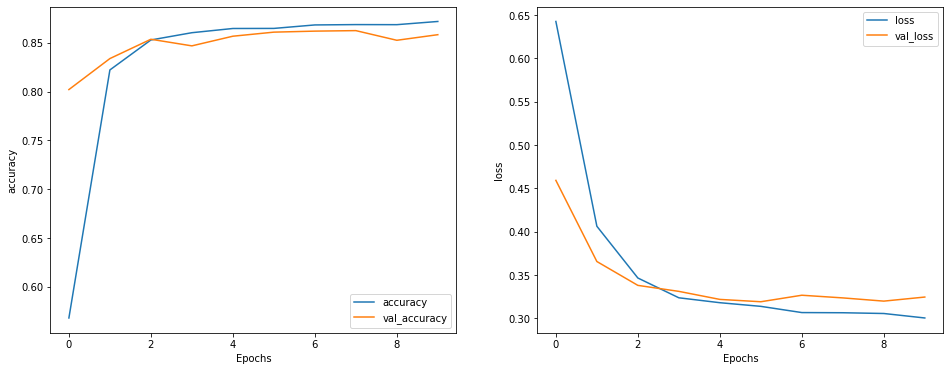

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
